In [1]:
# Use the following to install PyTorch on Windows with Nvidia GPU. Link: https://pytorch.org/get-started/locally/#anaconda-1
#!pip install https://download.pytorch.org/whl/cu90/torch-1.0.1-cp37-cp37m-win_amd64.whl
#!pip install torchvision

# Load required libraries:
import pandas as pd
import numpy as np
import sklearn.model_selection
import torch
import torch.utils.data
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

# Load data:
pcap_flow = pd.read_csv('labeled_test.csv')

# Specify labels data:
labels = pcap_flow.pop('Label')
labels = (labels == 'botnet').astype(float).values

# Select variables:
variables = pcap_flow[['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
'Bwd Pkt Len Std']].apply(pd.to_numeric).values

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(variables, labels, shuffle=True, random_state=100, test_size=0.3)


C:\Users\AcerLaptop\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [121]:
class Deep_Neural_Network(nn.Module):
    def __init__(self, D_in, fc1_size=48, fc2_size=24):
        """
        Neural Network model with 1 hidden layer.

        D_in: Dimension of input
        """
        super(Deep_Neural_Network, self).__init__()
        self.fc1 = nn.Linear(D_in, fc1_size)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.bn1 = nn.BatchNorm1d(fc1_size)
        self.relu1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        nn.init.kaiming_normal_(self.fc2.weight)
        self.bn2 = nn.BatchNorm1d(fc2_size)
        self.relu2 = nn.LeakyReLU()
        self.fc_output = nn.Linear(fc2_size, 1) # 1 because this is binary classification
        self.fc_output_activation = nn.Sigmoid()

    def forward(self, x):
        """
        Forward function acceps a Tensor of input data and returns a tensor of output data.
        """
        out = self.relu1(self.bn1(self.fc1(x)))
        out = self.relu2(self.bn2(self.fc2(out)))
        out = self.fc_output_activation(self.fc_output(out))
        return out

In [122]:
def train_DNN(data, target, batch_size, epochs, learning_rate):
    
    # Making dataset iterable:
    train_tensor = torch.utils.data.TensorDataset(torch.Tensor(data), torch.tensor(target))
    train_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

    # Instantiate Neural Network:
    net = Deep_Neural_Network(D_in=data.shape[1])
    
    # Switch to train mode:
    net.train()
    
    # Create Adam optimizer (recommended for Deep Neural Networks; betas=(0.9, 0.999) is recommended):
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))

    # Create Binary Cross Entropy loss function:
    criterion = nn.BCELoss()
    
    # Create total_losses list for plotting:
    total_losses = []

    # Run the main training loop:
    for epoch in range(epochs):
        
        losses = []

        for batch_i, (x_batch, y_batch) in enumerate(train_loader):
            x_batch, y_batch = Variable(x_batch), Variable(y_batch)

            # Zeros out all "delta" matrices before a new batch iteration:
            optimizer.zero_grad()

            # Forward propagation:
            net_out = net(x_batch)

            # Compute performance criterion:
            actual = y_batch.float().reshape(-1, 1)
            loss = criterion(net_out, actual)

            # Backward propagation:
            loss.backward()

            # Update weights:
            optimizer.step()

            # Append to total losses list:
            losses.append(loss.data.numpy())

            print('Train Epoch #{} [ {}/{} ({:.0f}%) ] Loss: {:.3f}'.format(
                epoch, batch_i * len(x_batch), len(train_loader.dataset),
                100.0 * batch_i / len(train_loader), loss.data.item()))

        total_losses += losses
        
        # Calculate average loss per batch:
        l = len(total_losses)
        no_remainder = l // batch_size * batch_size
        remainder = l - no_remainder
        total_losses_avg = np.append(np.mean(np.array(total_losses[0:no_remainder]).reshape(-1, batch_size), axis=1), np.mean(np.array(total_losses[-remainder:])))

    return [net, total_losses_avg]

def test_DNN(data, target, model, batch_size):
    
    # Switch to evaluate mode:
    model.eval()
    
    # Transform data into desired format with specified batch size:
    test_tensor = torch.utils.data.TensorDataset(torch.Tensor(data), torch.tensor(target))
    test_loader = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = batch_size)
    
    # Initiate accuracy calculation: 
    test_accuracy = 0.0
    
    # Initiate predictions output of the function:
    predictions_output = []
    
    # Run the main testing loop:
    for batch_i, (x_batch, y_batch) in enumerate(test_loader):
        
        # Predict classes of test set:
        outputs = model(x_batch)
        
        # Identify whether prediction is 0 or 1 (1 if probability is >= 0.5):
        predictions = [float(value[0]) for value in (outputs >= 0.5).tolist()]
        
        # Format actuals for comparison:
        actual = y_batch.tolist()
        
        # Append to the output predictions:
        predictions_output.extend(predictions)
        
        # Identify accuracy of predictions and append to accuracy calculation:
        test_accuracy += np.sum([int(prediction == target[i]) for i, prediction in enumerate(predictions)])

    # Compute average accuracy and loss over all test values:
    test_accuracy = test_accuracy / float(data.shape[0])
    print("Testing accuracy of the given model is {0}.".format(round(test_accuracy, 3)))
    
    # Format prediction output as pandas Series:
    predictions_output = pd.Series(predictions_output)
    
    return predictions_output

In [123]:
res = train_DNN(data=X_train, target=y_train, batch_size=50, epochs=10, learning_rate=0.01)

Train Epoch #0 [ 0/249311 (0%) ] Loss: 0.706
Train Epoch #0 [ 50/249311 (0%) ] Loss: 0.686
Train Epoch #0 [ 100/249311 (0%) ] Loss: 0.660
Train Epoch #0 [ 150/249311 (0%) ] Loss: 0.659
Train Epoch #0 [ 200/249311 (0%) ] Loss: 0.669
Train Epoch #0 [ 250/249311 (0%) ] Loss: 0.652
Train Epoch #0 [ 300/249311 (0%) ] Loss: 0.633
Train Epoch #0 [ 350/249311 (0%) ] Loss: 0.585
Train Epoch #0 [ 400/249311 (0%) ] Loss: 0.591
Train Epoch #0 [ 450/249311 (0%) ] Loss: 0.618
Train Epoch #0 [ 500/249311 (0%) ] Loss: 0.584
Train Epoch #0 [ 550/249311 (0%) ] Loss: 0.628
Train Epoch #0 [ 600/249311 (0%) ] Loss: 0.615
Train Epoch #0 [ 650/249311 (0%) ] Loss: 0.623
Train Epoch #0 [ 700/249311 (0%) ] Loss: 0.641
Train Epoch #0 [ 750/249311 (0%) ] Loss: 0.575
Train Epoch #0 [ 800/249311 (0%) ] Loss: 0.625
Train Epoch #0 [ 850/249311 (0%) ] Loss: 0.532
Train Epoch #0 [ 900/249311 (0%) ] Loss: 0.593
Train Epoch #0 [ 950/249311 (0%) ] Loss: 0.684
Train Epoch #0 [ 1000/249311 (0%) ] Loss: 0.588
Train Epoch #0 

Train Epoch #0 [ 10450/249311 (4%) ] Loss: 0.581
Train Epoch #0 [ 10500/249311 (4%) ] Loss: 0.545
Train Epoch #0 [ 10550/249311 (4%) ] Loss: 0.536
Train Epoch #0 [ 10600/249311 (4%) ] Loss: 0.506
Train Epoch #0 [ 10650/249311 (4%) ] Loss: 0.473
Train Epoch #0 [ 10700/249311 (4%) ] Loss: 0.481
Train Epoch #0 [ 10750/249311 (4%) ] Loss: 0.596
Train Epoch #0 [ 10800/249311 (4%) ] Loss: 0.615
Train Epoch #0 [ 10850/249311 (4%) ] Loss: 0.570
Train Epoch #0 [ 10900/249311 (4%) ] Loss: 0.609
Train Epoch #0 [ 10950/249311 (4%) ] Loss: 0.558
Train Epoch #0 [ 11000/249311 (4%) ] Loss: 0.658
Train Epoch #0 [ 11050/249311 (4%) ] Loss: 0.604
Train Epoch #0 [ 11100/249311 (4%) ] Loss: 0.587
Train Epoch #0 [ 11150/249311 (4%) ] Loss: 0.536
Train Epoch #0 [ 11200/249311 (4%) ] Loss: 0.612
Train Epoch #0 [ 11250/249311 (5%) ] Loss: 0.618
Train Epoch #0 [ 11300/249311 (5%) ] Loss: 0.648
Train Epoch #0 [ 11350/249311 (5%) ] Loss: 0.528
Train Epoch #0 [ 11400/249311 (5%) ] Loss: 0.485
Train Epoch #0 [ 114

Train Epoch #0 [ 19750/249311 (8%) ] Loss: 0.647
Train Epoch #0 [ 19800/249311 (8%) ] Loss: 0.598
Train Epoch #0 [ 19850/249311 (8%) ] Loss: 0.691
Train Epoch #0 [ 19900/249311 (8%) ] Loss: 0.715
Train Epoch #0 [ 19950/249311 (8%) ] Loss: 0.624
Train Epoch #0 [ 20000/249311 (8%) ] Loss: 0.478
Train Epoch #0 [ 20050/249311 (8%) ] Loss: 0.584
Train Epoch #0 [ 20100/249311 (8%) ] Loss: 0.535
Train Epoch #0 [ 20150/249311 (8%) ] Loss: 0.548
Train Epoch #0 [ 20200/249311 (8%) ] Loss: 0.564
Train Epoch #0 [ 20250/249311 (8%) ] Loss: 0.572
Train Epoch #0 [ 20300/249311 (8%) ] Loss: 0.563
Train Epoch #0 [ 20350/249311 (8%) ] Loss: 0.562
Train Epoch #0 [ 20400/249311 (8%) ] Loss: 0.632
Train Epoch #0 [ 20450/249311 (8%) ] Loss: 0.635
Train Epoch #0 [ 20500/249311 (8%) ] Loss: 0.578
Train Epoch #0 [ 20550/249311 (8%) ] Loss: 0.564
Train Epoch #0 [ 20600/249311 (8%) ] Loss: 0.573
Train Epoch #0 [ 20650/249311 (8%) ] Loss: 0.578
Train Epoch #0 [ 20700/249311 (8%) ] Loss: 0.586
Train Epoch #0 [ 207

Train Epoch #0 [ 29250/249311 (12%) ] Loss: 0.597
Train Epoch #0 [ 29300/249311 (12%) ] Loss: 0.511
Train Epoch #0 [ 29350/249311 (12%) ] Loss: 0.705
Train Epoch #0 [ 29400/249311 (12%) ] Loss: 0.594
Train Epoch #0 [ 29450/249311 (12%) ] Loss: 0.579
Train Epoch #0 [ 29500/249311 (12%) ] Loss: 0.424
Train Epoch #0 [ 29550/249311 (12%) ] Loss: 0.573
Train Epoch #0 [ 29600/249311 (12%) ] Loss: 0.558
Train Epoch #0 [ 29650/249311 (12%) ] Loss: 0.577
Train Epoch #0 [ 29700/249311 (12%) ] Loss: 0.563
Train Epoch #0 [ 29750/249311 (12%) ] Loss: 0.503
Train Epoch #0 [ 29800/249311 (12%) ] Loss: 0.728
Train Epoch #0 [ 29850/249311 (12%) ] Loss: 0.486
Train Epoch #0 [ 29900/249311 (12%) ] Loss: 0.803
Train Epoch #0 [ 29950/249311 (12%) ] Loss: 0.558
Train Epoch #0 [ 30000/249311 (12%) ] Loss: 0.613
Train Epoch #0 [ 30050/249311 (12%) ] Loss: 0.562
Train Epoch #0 [ 30100/249311 (12%) ] Loss: 0.562
Train Epoch #0 [ 30150/249311 (12%) ] Loss: 0.622
Train Epoch #0 [ 30200/249311 (12%) ] Loss: 0.513


Train Epoch #0 [ 38500/249311 (15%) ] Loss: 0.449
Train Epoch #0 [ 38550/249311 (15%) ] Loss: 0.671
Train Epoch #0 [ 38600/249311 (15%) ] Loss: 0.804
Train Epoch #0 [ 38650/249311 (16%) ] Loss: 0.625
Train Epoch #0 [ 38700/249311 (16%) ] Loss: 0.576
Train Epoch #0 [ 38750/249311 (16%) ] Loss: 0.528
Train Epoch #0 [ 38800/249311 (16%) ] Loss: 0.591
Train Epoch #0 [ 38850/249311 (16%) ] Loss: 0.473
Train Epoch #0 [ 38900/249311 (16%) ] Loss: 0.651
Train Epoch #0 [ 38950/249311 (16%) ] Loss: 0.604
Train Epoch #0 [ 39000/249311 (16%) ] Loss: 0.472
Train Epoch #0 [ 39050/249311 (16%) ] Loss: 0.751
Train Epoch #0 [ 39100/249311 (16%) ] Loss: 0.566
Train Epoch #0 [ 39150/249311 (16%) ] Loss: 0.531
Train Epoch #0 [ 39200/249311 (16%) ] Loss: 0.608
Train Epoch #0 [ 39250/249311 (16%) ] Loss: 0.566
Train Epoch #0 [ 39300/249311 (16%) ] Loss: 0.618
Train Epoch #0 [ 39350/249311 (16%) ] Loss: 0.624
Train Epoch #0 [ 39400/249311 (16%) ] Loss: 0.679
Train Epoch #0 [ 39450/249311 (16%) ] Loss: 0.637


Train Epoch #0 [ 46800/249311 (19%) ] Loss: 0.620
Train Epoch #0 [ 46850/249311 (19%) ] Loss: 0.561
Train Epoch #0 [ 46900/249311 (19%) ] Loss: 0.499
Train Epoch #0 [ 46950/249311 (19%) ] Loss: 0.513
Train Epoch #0 [ 47000/249311 (19%) ] Loss: 0.633
Train Epoch #0 [ 47050/249311 (19%) ] Loss: 0.545
Train Epoch #0 [ 47100/249311 (19%) ] Loss: 0.474
Train Epoch #0 [ 47150/249311 (19%) ] Loss: 0.612
Train Epoch #0 [ 47200/249311 (19%) ] Loss: 0.536
Train Epoch #0 [ 47250/249311 (19%) ] Loss: 0.562
Train Epoch #0 [ 47300/249311 (19%) ] Loss: 0.474
Train Epoch #0 [ 47350/249311 (19%) ] Loss: 0.644
Train Epoch #0 [ 47400/249311 (19%) ] Loss: 0.560
Train Epoch #0 [ 47450/249311 (19%) ] Loss: 0.623
Train Epoch #0 [ 47500/249311 (19%) ] Loss: 0.705
Train Epoch #0 [ 47550/249311 (19%) ] Loss: 0.551
Train Epoch #0 [ 47600/249311 (19%) ] Loss: 0.714
Train Epoch #0 [ 47650/249311 (19%) ] Loss: 0.560
Train Epoch #0 [ 47700/249311 (19%) ] Loss: 0.568
Train Epoch #0 [ 47750/249311 (19%) ] Loss: 0.450


Train Epoch #0 [ 55000/249311 (22%) ] Loss: 0.613
Train Epoch #0 [ 55050/249311 (22%) ] Loss: 0.555
Train Epoch #0 [ 55100/249311 (22%) ] Loss: 0.507
Train Epoch #0 [ 55150/249311 (22%) ] Loss: 0.534
Train Epoch #0 [ 55200/249311 (22%) ] Loss: 0.693
Train Epoch #0 [ 55250/249311 (22%) ] Loss: 0.598
Train Epoch #0 [ 55300/249311 (22%) ] Loss: 0.509
Train Epoch #0 [ 55350/249311 (22%) ] Loss: 0.701
Train Epoch #0 [ 55400/249311 (22%) ] Loss: 0.639
Train Epoch #0 [ 55450/249311 (22%) ] Loss: 0.668
Train Epoch #0 [ 55500/249311 (22%) ] Loss: 0.620
Train Epoch #0 [ 55550/249311 (22%) ] Loss: 0.536
Train Epoch #0 [ 55600/249311 (22%) ] Loss: 0.657
Train Epoch #0 [ 55650/249311 (22%) ] Loss: 0.739
Train Epoch #0 [ 55700/249311 (22%) ] Loss: 0.591
Train Epoch #0 [ 55750/249311 (22%) ] Loss: 0.515
Train Epoch #0 [ 55800/249311 (22%) ] Loss: 0.615
Train Epoch #0 [ 55850/249311 (22%) ] Loss: 0.644
Train Epoch #0 [ 55900/249311 (22%) ] Loss: 0.604
Train Epoch #0 [ 55950/249311 (22%) ] Loss: 0.611


Train Epoch #0 [ 63750/249311 (26%) ] Loss: 0.628
Train Epoch #0 [ 63800/249311 (26%) ] Loss: 0.575
Train Epoch #0 [ 63850/249311 (26%) ] Loss: 0.432
Train Epoch #0 [ 63900/249311 (26%) ] Loss: 0.535
Train Epoch #0 [ 63950/249311 (26%) ] Loss: 0.445
Train Epoch #0 [ 64000/249311 (26%) ] Loss: 0.700
Train Epoch #0 [ 64050/249311 (26%) ] Loss: 0.523
Train Epoch #0 [ 64100/249311 (26%) ] Loss: 0.667
Train Epoch #0 [ 64150/249311 (26%) ] Loss: 0.667
Train Epoch #0 [ 64200/249311 (26%) ] Loss: 0.440
Train Epoch #0 [ 64250/249311 (26%) ] Loss: 0.481
Train Epoch #0 [ 64300/249311 (26%) ] Loss: 0.506
Train Epoch #0 [ 64350/249311 (26%) ] Loss: 0.533
Train Epoch #0 [ 64400/249311 (26%) ] Loss: 0.679
Train Epoch #0 [ 64450/249311 (26%) ] Loss: 0.553
Train Epoch #0 [ 64500/249311 (26%) ] Loss: 0.570
Train Epoch #0 [ 64550/249311 (26%) ] Loss: 0.610
Train Epoch #0 [ 64600/249311 (26%) ] Loss: 0.542
Train Epoch #0 [ 64650/249311 (26%) ] Loss: 0.585
Train Epoch #0 [ 64700/249311 (26%) ] Loss: 0.616


Train Epoch #0 [ 73150/249311 (29%) ] Loss: 0.653
Train Epoch #0 [ 73200/249311 (29%) ] Loss: 0.674
Train Epoch #0 [ 73250/249311 (29%) ] Loss: 0.650
Train Epoch #0 [ 73300/249311 (29%) ] Loss: 0.571
Train Epoch #0 [ 73350/249311 (29%) ] Loss: 0.548
Train Epoch #0 [ 73400/249311 (29%) ] Loss: 0.583
Train Epoch #0 [ 73450/249311 (29%) ] Loss: 0.482
Train Epoch #0 [ 73500/249311 (29%) ] Loss: 0.642
Train Epoch #0 [ 73550/249311 (29%) ] Loss: 0.604
Train Epoch #0 [ 73600/249311 (30%) ] Loss: 0.499
Train Epoch #0 [ 73650/249311 (30%) ] Loss: 0.530
Train Epoch #0 [ 73700/249311 (30%) ] Loss: 0.524
Train Epoch #0 [ 73750/249311 (30%) ] Loss: 0.520
Train Epoch #0 [ 73800/249311 (30%) ] Loss: 0.613
Train Epoch #0 [ 73850/249311 (30%) ] Loss: 0.605
Train Epoch #0 [ 73900/249311 (30%) ] Loss: 0.563
Train Epoch #0 [ 73950/249311 (30%) ] Loss: 0.632
Train Epoch #0 [ 74000/249311 (30%) ] Loss: 0.483
Train Epoch #0 [ 74050/249311 (30%) ] Loss: 0.518
Train Epoch #0 [ 74100/249311 (30%) ] Loss: 0.639


Train Epoch #0 [ 83300/249311 (33%) ] Loss: 0.512
Train Epoch #0 [ 83350/249311 (33%) ] Loss: 0.513
Train Epoch #0 [ 83400/249311 (33%) ] Loss: 0.466
Train Epoch #0 [ 83450/249311 (33%) ] Loss: 0.586
Train Epoch #0 [ 83500/249311 (33%) ] Loss: 0.673
Train Epoch #0 [ 83550/249311 (34%) ] Loss: 0.521
Train Epoch #0 [ 83600/249311 (34%) ] Loss: 0.585
Train Epoch #0 [ 83650/249311 (34%) ] Loss: 0.447
Train Epoch #0 [ 83700/249311 (34%) ] Loss: 0.615
Train Epoch #0 [ 83750/249311 (34%) ] Loss: 0.541
Train Epoch #0 [ 83800/249311 (34%) ] Loss: 0.492
Train Epoch #0 [ 83850/249311 (34%) ] Loss: 0.542
Train Epoch #0 [ 83900/249311 (34%) ] Loss: 0.663
Train Epoch #0 [ 83950/249311 (34%) ] Loss: 0.639
Train Epoch #0 [ 84000/249311 (34%) ] Loss: 0.543
Train Epoch #0 [ 84050/249311 (34%) ] Loss: 0.550
Train Epoch #0 [ 84100/249311 (34%) ] Loss: 0.465
Train Epoch #0 [ 84150/249311 (34%) ] Loss: 0.563
Train Epoch #0 [ 84200/249311 (34%) ] Loss: 0.521
Train Epoch #0 [ 84250/249311 (34%) ] Loss: 0.586


Train Epoch #0 [ 92000/249311 (37%) ] Loss: 0.527
Train Epoch #0 [ 92050/249311 (37%) ] Loss: 0.484
Train Epoch #0 [ 92100/249311 (37%) ] Loss: 0.740
Train Epoch #0 [ 92150/249311 (37%) ] Loss: 0.725
Train Epoch #0 [ 92200/249311 (37%) ] Loss: 0.551
Train Epoch #0 [ 92250/249311 (37%) ] Loss: 0.535
Train Epoch #0 [ 92300/249311 (37%) ] Loss: 0.424
Train Epoch #0 [ 92350/249311 (37%) ] Loss: 0.563
Train Epoch #0 [ 92400/249311 (37%) ] Loss: 0.553
Train Epoch #0 [ 92450/249311 (37%) ] Loss: 0.600
Train Epoch #0 [ 92500/249311 (37%) ] Loss: 0.647
Train Epoch #0 [ 92550/249311 (37%) ] Loss: 0.590
Train Epoch #0 [ 92600/249311 (37%) ] Loss: 0.589
Train Epoch #0 [ 92650/249311 (37%) ] Loss: 0.560
Train Epoch #0 [ 92700/249311 (37%) ] Loss: 0.463
Train Epoch #0 [ 92750/249311 (37%) ] Loss: 0.459
Train Epoch #0 [ 92800/249311 (37%) ] Loss: 0.625
Train Epoch #0 [ 92850/249311 (37%) ] Loss: 0.591
Train Epoch #0 [ 92900/249311 (37%) ] Loss: 0.564
Train Epoch #0 [ 92950/249311 (37%) ] Loss: 0.615


Train Epoch #0 [ 101350/249311 (41%) ] Loss: 0.500
Train Epoch #0 [ 101400/249311 (41%) ] Loss: 0.400
Train Epoch #0 [ 101450/249311 (41%) ] Loss: 0.484
Train Epoch #0 [ 101500/249311 (41%) ] Loss: 0.527
Train Epoch #0 [ 101550/249311 (41%) ] Loss: 0.572
Train Epoch #0 [ 101600/249311 (41%) ] Loss: 0.628
Train Epoch #0 [ 101650/249311 (41%) ] Loss: 0.496
Train Epoch #0 [ 101700/249311 (41%) ] Loss: 0.554
Train Epoch #0 [ 101750/249311 (41%) ] Loss: 0.581
Train Epoch #0 [ 101800/249311 (41%) ] Loss: 0.477
Train Epoch #0 [ 101850/249311 (41%) ] Loss: 0.495
Train Epoch #0 [ 101900/249311 (41%) ] Loss: 0.530
Train Epoch #0 [ 101950/249311 (41%) ] Loss: 0.517
Train Epoch #0 [ 102000/249311 (41%) ] Loss: 0.665
Train Epoch #0 [ 102050/249311 (41%) ] Loss: 0.544
Train Epoch #0 [ 102100/249311 (41%) ] Loss: 0.458
Train Epoch #0 [ 102150/249311 (41%) ] Loss: 0.605
Train Epoch #0 [ 102200/249311 (41%) ] Loss: 0.606
Train Epoch #0 [ 102250/249311 (41%) ] Loss: 0.596
Train Epoch #0 [ 102300/249311 

Train Epoch #0 [ 111000/249311 (45%) ] Loss: 0.560
Train Epoch #0 [ 111050/249311 (45%) ] Loss: 0.530
Train Epoch #0 [ 111100/249311 (45%) ] Loss: 0.700
Train Epoch #0 [ 111150/249311 (45%) ] Loss: 0.647
Train Epoch #0 [ 111200/249311 (45%) ] Loss: 0.470
Train Epoch #0 [ 111250/249311 (45%) ] Loss: 0.524
Train Epoch #0 [ 111300/249311 (45%) ] Loss: 0.589
Train Epoch #0 [ 111350/249311 (45%) ] Loss: 0.527
Train Epoch #0 [ 111400/249311 (45%) ] Loss: 0.670
Train Epoch #0 [ 111450/249311 (45%) ] Loss: 0.557
Train Epoch #0 [ 111500/249311 (45%) ] Loss: 0.519
Train Epoch #0 [ 111550/249311 (45%) ] Loss: 0.492
Train Epoch #0 [ 111600/249311 (45%) ] Loss: 0.633
Train Epoch #0 [ 111650/249311 (45%) ] Loss: 0.674
Train Epoch #0 [ 111700/249311 (45%) ] Loss: 0.684
Train Epoch #0 [ 111750/249311 (45%) ] Loss: 0.468
Train Epoch #0 [ 111800/249311 (45%) ] Loss: 0.635
Train Epoch #0 [ 111850/249311 (45%) ] Loss: 0.536
Train Epoch #0 [ 111900/249311 (45%) ] Loss: 0.532
Train Epoch #0 [ 111950/249311 

Train Epoch #0 [ 120300/249311 (48%) ] Loss: 0.587
Train Epoch #0 [ 120350/249311 (48%) ] Loss: 0.462
Train Epoch #0 [ 120400/249311 (48%) ] Loss: 0.513
Train Epoch #0 [ 120450/249311 (48%) ] Loss: 0.546
Train Epoch #0 [ 120500/249311 (48%) ] Loss: 0.460
Train Epoch #0 [ 120550/249311 (48%) ] Loss: 0.545
Train Epoch #0 [ 120600/249311 (48%) ] Loss: 0.553
Train Epoch #0 [ 120650/249311 (48%) ] Loss: 0.647
Train Epoch #0 [ 120700/249311 (48%) ] Loss: 0.408
Train Epoch #0 [ 120750/249311 (48%) ] Loss: 0.635
Train Epoch #0 [ 120800/249311 (48%) ] Loss: 0.431
Train Epoch #0 [ 120850/249311 (48%) ] Loss: 0.533
Train Epoch #0 [ 120900/249311 (48%) ] Loss: 0.571
Train Epoch #0 [ 120950/249311 (49%) ] Loss: 0.488
Train Epoch #0 [ 121000/249311 (49%) ] Loss: 0.562
Train Epoch #0 [ 121050/249311 (49%) ] Loss: 0.466
Train Epoch #0 [ 121100/249311 (49%) ] Loss: 0.537
Train Epoch #0 [ 121150/249311 (49%) ] Loss: 0.463
Train Epoch #0 [ 121200/249311 (49%) ] Loss: 0.554
Train Epoch #0 [ 121250/249311 

Train Epoch #0 [ 128450/249311 (52%) ] Loss: 0.481
Train Epoch #0 [ 128500/249311 (52%) ] Loss: 0.531
Train Epoch #0 [ 128550/249311 (52%) ] Loss: 0.539
Train Epoch #0 [ 128600/249311 (52%) ] Loss: 0.630
Train Epoch #0 [ 128650/249311 (52%) ] Loss: 0.546
Train Epoch #0 [ 128700/249311 (52%) ] Loss: 0.488
Train Epoch #0 [ 128750/249311 (52%) ] Loss: 0.469
Train Epoch #0 [ 128800/249311 (52%) ] Loss: 0.479
Train Epoch #0 [ 128850/249311 (52%) ] Loss: 0.631
Train Epoch #0 [ 128900/249311 (52%) ] Loss: 0.541
Train Epoch #0 [ 128950/249311 (52%) ] Loss: 0.483
Train Epoch #0 [ 129000/249311 (52%) ] Loss: 0.587
Train Epoch #0 [ 129050/249311 (52%) ] Loss: 0.510
Train Epoch #0 [ 129100/249311 (52%) ] Loss: 0.477
Train Epoch #0 [ 129150/249311 (52%) ] Loss: 0.568
Train Epoch #0 [ 129200/249311 (52%) ] Loss: 0.614
Train Epoch #0 [ 129250/249311 (52%) ] Loss: 0.517
Train Epoch #0 [ 129300/249311 (52%) ] Loss: 0.586
Train Epoch #0 [ 129350/249311 (52%) ] Loss: 0.942
Train Epoch #0 [ 129400/249311 

Train Epoch #0 [ 136550/249311 (55%) ] Loss: 0.473
Train Epoch #0 [ 136600/249311 (55%) ] Loss: 0.455
Train Epoch #0 [ 136650/249311 (55%) ] Loss: 0.563
Train Epoch #0 [ 136700/249311 (55%) ] Loss: 0.544
Train Epoch #0 [ 136750/249311 (55%) ] Loss: 0.541
Train Epoch #0 [ 136800/249311 (55%) ] Loss: 0.468
Train Epoch #0 [ 136850/249311 (55%) ] Loss: 0.569
Train Epoch #0 [ 136900/249311 (55%) ] Loss: 0.578
Train Epoch #0 [ 136950/249311 (55%) ] Loss: 0.516
Train Epoch #0 [ 137000/249311 (55%) ] Loss: 0.607
Train Epoch #0 [ 137050/249311 (55%) ] Loss: 0.510
Train Epoch #0 [ 137100/249311 (55%) ] Loss: 0.525
Train Epoch #0 [ 137150/249311 (55%) ] Loss: 0.469
Train Epoch #0 [ 137200/249311 (55%) ] Loss: 0.498
Train Epoch #0 [ 137250/249311 (55%) ] Loss: 0.622
Train Epoch #0 [ 137300/249311 (55%) ] Loss: 0.566
Train Epoch #0 [ 137350/249311 (55%) ] Loss: 0.805
Train Epoch #0 [ 137400/249311 (55%) ] Loss: 0.556
Train Epoch #0 [ 137450/249311 (55%) ] Loss: 0.483
Train Epoch #0 [ 137500/249311 

Train Epoch #0 [ 145300/249311 (58%) ] Loss: 0.532
Train Epoch #0 [ 145350/249311 (58%) ] Loss: 0.516
Train Epoch #0 [ 145400/249311 (58%) ] Loss: 0.626
Train Epoch #0 [ 145450/249311 (58%) ] Loss: 0.435
Train Epoch #0 [ 145500/249311 (58%) ] Loss: 0.534
Train Epoch #0 [ 145550/249311 (58%) ] Loss: 0.617
Train Epoch #0 [ 145600/249311 (58%) ] Loss: 0.563
Train Epoch #0 [ 145650/249311 (58%) ] Loss: 0.685
Train Epoch #0 [ 145700/249311 (58%) ] Loss: 0.524
Train Epoch #0 [ 145750/249311 (58%) ] Loss: 0.487
Train Epoch #0 [ 145800/249311 (58%) ] Loss: 0.510
Train Epoch #0 [ 145850/249311 (58%) ] Loss: 0.572
Train Epoch #0 [ 145900/249311 (59%) ] Loss: 0.409
Train Epoch #0 [ 145950/249311 (59%) ] Loss: 0.587
Train Epoch #0 [ 146000/249311 (59%) ] Loss: 0.620
Train Epoch #0 [ 146050/249311 (59%) ] Loss: 0.650
Train Epoch #0 [ 146100/249311 (59%) ] Loss: 0.556
Train Epoch #0 [ 146150/249311 (59%) ] Loss: 0.547
Train Epoch #0 [ 146200/249311 (59%) ] Loss: 0.528
Train Epoch #0 [ 146250/249311 

Train Epoch #0 [ 154000/249311 (62%) ] Loss: 0.499
Train Epoch #0 [ 154050/249311 (62%) ] Loss: 0.635
Train Epoch #0 [ 154100/249311 (62%) ] Loss: 0.505
Train Epoch #0 [ 154150/249311 (62%) ] Loss: 0.535
Train Epoch #0 [ 154200/249311 (62%) ] Loss: 0.504
Train Epoch #0 [ 154250/249311 (62%) ] Loss: 0.575
Train Epoch #0 [ 154300/249311 (62%) ] Loss: 0.573
Train Epoch #0 [ 154350/249311 (62%) ] Loss: 0.584
Train Epoch #0 [ 154400/249311 (62%) ] Loss: 0.576
Train Epoch #0 [ 154450/249311 (62%) ] Loss: 0.511
Train Epoch #0 [ 154500/249311 (62%) ] Loss: 0.565
Train Epoch #0 [ 154550/249311 (62%) ] Loss: 0.534
Train Epoch #0 [ 154600/249311 (62%) ] Loss: 0.502
Train Epoch #0 [ 154650/249311 (62%) ] Loss: 0.571
Train Epoch #0 [ 154700/249311 (62%) ] Loss: 0.586
Train Epoch #0 [ 154750/249311 (62%) ] Loss: 0.641
Train Epoch #0 [ 154800/249311 (62%) ] Loss: 0.466
Train Epoch #0 [ 154850/249311 (62%) ] Loss: 0.482
Train Epoch #0 [ 154900/249311 (62%) ] Loss: 0.597
Train Epoch #0 [ 154950/249311 

Train Epoch #0 [ 162100/249311 (65%) ] Loss: 0.432
Train Epoch #0 [ 162150/249311 (65%) ] Loss: 0.498
Train Epoch #0 [ 162200/249311 (65%) ] Loss: 0.462
Train Epoch #0 [ 162250/249311 (65%) ] Loss: 0.507
Train Epoch #0 [ 162300/249311 (65%) ] Loss: 0.564
Train Epoch #0 [ 162350/249311 (65%) ] Loss: 0.530
Train Epoch #0 [ 162400/249311 (65%) ] Loss: 0.582
Train Epoch #0 [ 162450/249311 (65%) ] Loss: 0.650
Train Epoch #0 [ 162500/249311 (65%) ] Loss: 0.508
Train Epoch #0 [ 162550/249311 (65%) ] Loss: 0.570
Train Epoch #0 [ 162600/249311 (65%) ] Loss: 0.672
Train Epoch #0 [ 162650/249311 (65%) ] Loss: 0.569
Train Epoch #0 [ 162700/249311 (65%) ] Loss: 0.492
Train Epoch #0 [ 162750/249311 (65%) ] Loss: 0.527
Train Epoch #0 [ 162800/249311 (65%) ] Loss: 0.624
Train Epoch #0 [ 162850/249311 (65%) ] Loss: 0.499
Train Epoch #0 [ 162900/249311 (65%) ] Loss: 0.519
Train Epoch #0 [ 162950/249311 (65%) ] Loss: 0.466
Train Epoch #0 [ 163000/249311 (65%) ] Loss: 0.588
Train Epoch #0 [ 163050/249311 

Train Epoch #0 [ 170700/249311 (68%) ] Loss: 0.554
Train Epoch #0 [ 170750/249311 (68%) ] Loss: 0.559
Train Epoch #0 [ 170800/249311 (68%) ] Loss: 0.496
Train Epoch #0 [ 170850/249311 (69%) ] Loss: 0.541
Train Epoch #0 [ 170900/249311 (69%) ] Loss: 0.510
Train Epoch #0 [ 170950/249311 (69%) ] Loss: 0.588
Train Epoch #0 [ 171000/249311 (69%) ] Loss: 0.428
Train Epoch #0 [ 171050/249311 (69%) ] Loss: 0.636
Train Epoch #0 [ 171100/249311 (69%) ] Loss: 0.521
Train Epoch #0 [ 171150/249311 (69%) ] Loss: 0.544
Train Epoch #0 [ 171200/249311 (69%) ] Loss: 0.578
Train Epoch #0 [ 171250/249311 (69%) ] Loss: 0.574
Train Epoch #0 [ 171300/249311 (69%) ] Loss: 0.466
Train Epoch #0 [ 171350/249311 (69%) ] Loss: 0.517
Train Epoch #0 [ 171400/249311 (69%) ] Loss: 0.568
Train Epoch #0 [ 171450/249311 (69%) ] Loss: 0.619
Train Epoch #0 [ 171500/249311 (69%) ] Loss: 0.776
Train Epoch #0 [ 171550/249311 (69%) ] Loss: 0.495
Train Epoch #0 [ 171600/249311 (69%) ] Loss: 0.577
Train Epoch #0 [ 171650/249311 

Train Epoch #0 [ 180100/249311 (72%) ] Loss: 0.533
Train Epoch #0 [ 180150/249311 (72%) ] Loss: 0.422
Train Epoch #0 [ 180200/249311 (72%) ] Loss: 0.541
Train Epoch #0 [ 180250/249311 (72%) ] Loss: 0.581
Train Epoch #0 [ 180300/249311 (72%) ] Loss: 0.464
Train Epoch #0 [ 180350/249311 (72%) ] Loss: 0.554
Train Epoch #0 [ 180400/249311 (72%) ] Loss: 0.499
Train Epoch #0 [ 180450/249311 (72%) ] Loss: 0.469
Train Epoch #0 [ 180500/249311 (72%) ] Loss: 0.505
Train Epoch #0 [ 180550/249311 (72%) ] Loss: 0.536
Train Epoch #0 [ 180600/249311 (72%) ] Loss: 0.595
Train Epoch #0 [ 180650/249311 (72%) ] Loss: 0.731
Train Epoch #0 [ 180700/249311 (72%) ] Loss: 0.561
Train Epoch #0 [ 180750/249311 (72%) ] Loss: 0.723
Train Epoch #0 [ 180800/249311 (73%) ] Loss: 0.626
Train Epoch #0 [ 180850/249311 (73%) ] Loss: 0.469
Train Epoch #0 [ 180900/249311 (73%) ] Loss: 0.645
Train Epoch #0 [ 180950/249311 (73%) ] Loss: 0.663
Train Epoch #0 [ 181000/249311 (73%) ] Loss: 0.773
Train Epoch #0 [ 181050/249311 

Train Epoch #0 [ 189200/249311 (76%) ] Loss: 0.462
Train Epoch #0 [ 189250/249311 (76%) ] Loss: 0.570
Train Epoch #0 [ 189300/249311 (76%) ] Loss: 0.463
Train Epoch #0 [ 189350/249311 (76%) ] Loss: 0.560
Train Epoch #0 [ 189400/249311 (76%) ] Loss: 0.516
Train Epoch #0 [ 189450/249311 (76%) ] Loss: 0.601
Train Epoch #0 [ 189500/249311 (76%) ] Loss: 0.622
Train Epoch #0 [ 189550/249311 (76%) ] Loss: 0.592
Train Epoch #0 [ 189600/249311 (76%) ] Loss: 0.533
Train Epoch #0 [ 189650/249311 (76%) ] Loss: 0.480
Train Epoch #0 [ 189700/249311 (76%) ] Loss: 0.457
Train Epoch #0 [ 189750/249311 (76%) ] Loss: 0.395
Train Epoch #0 [ 189800/249311 (76%) ] Loss: 0.545
Train Epoch #0 [ 189850/249311 (76%) ] Loss: 0.608
Train Epoch #0 [ 189900/249311 (76%) ] Loss: 0.518
Train Epoch #0 [ 189950/249311 (76%) ] Loss: 0.454
Train Epoch #0 [ 190000/249311 (76%) ] Loss: 0.568
Train Epoch #0 [ 190050/249311 (76%) ] Loss: 0.499
Train Epoch #0 [ 190100/249311 (76%) ] Loss: 0.490
Train Epoch #0 [ 190150/249311 

Train Epoch #0 [ 198050/249311 (79%) ] Loss: 0.527
Train Epoch #0 [ 198100/249311 (79%) ] Loss: 0.659
Train Epoch #0 [ 198150/249311 (79%) ] Loss: 0.423
Train Epoch #0 [ 198200/249311 (79%) ] Loss: 0.419
Train Epoch #0 [ 198250/249311 (80%) ] Loss: 0.557
Train Epoch #0 [ 198300/249311 (80%) ] Loss: 0.542
Train Epoch #0 [ 198350/249311 (80%) ] Loss: 0.521
Train Epoch #0 [ 198400/249311 (80%) ] Loss: 0.610
Train Epoch #0 [ 198450/249311 (80%) ] Loss: 0.653
Train Epoch #0 [ 198500/249311 (80%) ] Loss: 0.446
Train Epoch #0 [ 198550/249311 (80%) ] Loss: 0.508
Train Epoch #0 [ 198600/249311 (80%) ] Loss: 0.461
Train Epoch #0 [ 198650/249311 (80%) ] Loss: 0.571
Train Epoch #0 [ 198700/249311 (80%) ] Loss: 0.480
Train Epoch #0 [ 198750/249311 (80%) ] Loss: 0.565
Train Epoch #0 [ 198800/249311 (80%) ] Loss: 0.612
Train Epoch #0 [ 198850/249311 (80%) ] Loss: 0.628
Train Epoch #0 [ 198900/249311 (80%) ] Loss: 0.601
Train Epoch #0 [ 198950/249311 (80%) ] Loss: 0.460
Train Epoch #0 [ 199000/249311 

Train Epoch #0 [ 206500/249311 (83%) ] Loss: 0.597
Train Epoch #0 [ 206550/249311 (83%) ] Loss: 0.559
Train Epoch #0 [ 206600/249311 (83%) ] Loss: 0.676
Train Epoch #0 [ 206650/249311 (83%) ] Loss: 0.527
Train Epoch #0 [ 206700/249311 (83%) ] Loss: 0.502
Train Epoch #0 [ 206750/249311 (83%) ] Loss: 0.463
Train Epoch #0 [ 206800/249311 (83%) ] Loss: 0.447
Train Epoch #0 [ 206850/249311 (83%) ] Loss: 0.642
Train Epoch #0 [ 206900/249311 (83%) ] Loss: 0.591
Train Epoch #0 [ 206950/249311 (83%) ] Loss: 0.562
Train Epoch #0 [ 207000/249311 (83%) ] Loss: 0.548
Train Epoch #0 [ 207050/249311 (83%) ] Loss: 0.659
Train Epoch #0 [ 207100/249311 (83%) ] Loss: 0.605
Train Epoch #0 [ 207150/249311 (83%) ] Loss: 0.604
Train Epoch #0 [ 207200/249311 (83%) ] Loss: 0.637
Train Epoch #0 [ 207250/249311 (83%) ] Loss: 0.546
Train Epoch #0 [ 207300/249311 (83%) ] Loss: 0.606
Train Epoch #0 [ 207350/249311 (83%) ] Loss: 0.657
Train Epoch #0 [ 207400/249311 (83%) ] Loss: 0.626
Train Epoch #0 [ 207450/249311 

Train Epoch #0 [ 215850/249311 (87%) ] Loss: 0.544
Train Epoch #0 [ 215900/249311 (87%) ] Loss: 0.619
Train Epoch #0 [ 215950/249311 (87%) ] Loss: 0.517
Train Epoch #0 [ 216000/249311 (87%) ] Loss: 0.660
Train Epoch #0 [ 216050/249311 (87%) ] Loss: 0.536
Train Epoch #0 [ 216100/249311 (87%) ] Loss: 0.556
Train Epoch #0 [ 216150/249311 (87%) ] Loss: 0.550
Train Epoch #0 [ 216200/249311 (87%) ] Loss: 0.504
Train Epoch #0 [ 216250/249311 (87%) ] Loss: 0.542
Train Epoch #0 [ 216300/249311 (87%) ] Loss: 0.494
Train Epoch #0 [ 216350/249311 (87%) ] Loss: 0.442
Train Epoch #0 [ 216400/249311 (87%) ] Loss: 0.586
Train Epoch #0 [ 216450/249311 (87%) ] Loss: 0.468
Train Epoch #0 [ 216500/249311 (87%) ] Loss: 0.588
Train Epoch #0 [ 216550/249311 (87%) ] Loss: 0.539
Train Epoch #0 [ 216600/249311 (87%) ] Loss: 0.619
Train Epoch #0 [ 216650/249311 (87%) ] Loss: 0.503
Train Epoch #0 [ 216700/249311 (87%) ] Loss: 0.678
Train Epoch #0 [ 216750/249311 (87%) ] Loss: 0.490
Train Epoch #0 [ 216800/249311 

Train Epoch #0 [ 225400/249311 (90%) ] Loss: 0.484
Train Epoch #0 [ 225450/249311 (90%) ] Loss: 0.570
Train Epoch #0 [ 225500/249311 (90%) ] Loss: 0.565
Train Epoch #0 [ 225550/249311 (90%) ] Loss: 0.499
Train Epoch #0 [ 225600/249311 (90%) ] Loss: 0.496
Train Epoch #0 [ 225650/249311 (90%) ] Loss: 0.507
Train Epoch #0 [ 225700/249311 (91%) ] Loss: 0.527
Train Epoch #0 [ 225750/249311 (91%) ] Loss: 0.437
Train Epoch #0 [ 225800/249311 (91%) ] Loss: 0.425
Train Epoch #0 [ 225850/249311 (91%) ] Loss: 0.472
Train Epoch #0 [ 225900/249311 (91%) ] Loss: 0.532
Train Epoch #0 [ 225950/249311 (91%) ] Loss: 0.476
Train Epoch #0 [ 226000/249311 (91%) ] Loss: 0.515
Train Epoch #0 [ 226050/249311 (91%) ] Loss: 0.582
Train Epoch #0 [ 226100/249311 (91%) ] Loss: 0.541
Train Epoch #0 [ 226150/249311 (91%) ] Loss: 0.599
Train Epoch #0 [ 226200/249311 (91%) ] Loss: 0.444
Train Epoch #0 [ 226250/249311 (91%) ] Loss: 0.524
Train Epoch #0 [ 226300/249311 (91%) ] Loss: 0.535
Train Epoch #0 [ 226350/249311 

Train Epoch #0 [ 235350/249311 (94%) ] Loss: 0.673
Train Epoch #0 [ 235400/249311 (94%) ] Loss: 0.476
Train Epoch #0 [ 235450/249311 (94%) ] Loss: 0.405
Train Epoch #0 [ 235500/249311 (94%) ] Loss: 0.488
Train Epoch #0 [ 235550/249311 (94%) ] Loss: 0.483
Train Epoch #0 [ 235600/249311 (94%) ] Loss: 0.495
Train Epoch #0 [ 235650/249311 (95%) ] Loss: 0.554
Train Epoch #0 [ 235700/249311 (95%) ] Loss: 0.526
Train Epoch #0 [ 235750/249311 (95%) ] Loss: 0.530
Train Epoch #0 [ 235800/249311 (95%) ] Loss: 0.653
Train Epoch #0 [ 235850/249311 (95%) ] Loss: 0.606
Train Epoch #0 [ 235900/249311 (95%) ] Loss: 0.538
Train Epoch #0 [ 235950/249311 (95%) ] Loss: 0.790
Train Epoch #0 [ 236000/249311 (95%) ] Loss: 0.511
Train Epoch #0 [ 236050/249311 (95%) ] Loss: 0.496
Train Epoch #0 [ 236100/249311 (95%) ] Loss: 0.547
Train Epoch #0 [ 236150/249311 (95%) ] Loss: 0.531
Train Epoch #0 [ 236200/249311 (95%) ] Loss: 0.603
Train Epoch #0 [ 236250/249311 (95%) ] Loss: 0.477
Train Epoch #0 [ 236300/249311 

Train Epoch #0 [ 243700/249311 (98%) ] Loss: 0.545
Train Epoch #0 [ 243750/249311 (98%) ] Loss: 0.589
Train Epoch #0 [ 243800/249311 (98%) ] Loss: 0.411
Train Epoch #0 [ 243850/249311 (98%) ] Loss: 0.568
Train Epoch #0 [ 243900/249311 (98%) ] Loss: 0.535
Train Epoch #0 [ 243950/249311 (98%) ] Loss: 0.539
Train Epoch #0 [ 244000/249311 (98%) ] Loss: 0.574
Train Epoch #0 [ 244050/249311 (98%) ] Loss: 0.366
Train Epoch #0 [ 244100/249311 (98%) ] Loss: 0.461
Train Epoch #0 [ 244150/249311 (98%) ] Loss: 0.396
Train Epoch #0 [ 244200/249311 (98%) ] Loss: 0.741
Train Epoch #0 [ 244250/249311 (98%) ] Loss: 0.490
Train Epoch #0 [ 244300/249311 (98%) ] Loss: 0.423
Train Epoch #0 [ 244350/249311 (98%) ] Loss: 0.510
Train Epoch #0 [ 244400/249311 (98%) ] Loss: 0.621
Train Epoch #0 [ 244450/249311 (98%) ] Loss: 0.530
Train Epoch #0 [ 244500/249311 (98%) ] Loss: 0.578
Train Epoch #0 [ 244550/249311 (98%) ] Loss: 0.516
Train Epoch #0 [ 244600/249311 (98%) ] Loss: 0.481
Train Epoch #0 [ 244650/249311 

Train Epoch #1 [ 2850/249311 (1%) ] Loss: 0.449
Train Epoch #1 [ 2900/249311 (1%) ] Loss: 0.587
Train Epoch #1 [ 2950/249311 (1%) ] Loss: 0.475
Train Epoch #1 [ 3000/249311 (1%) ] Loss: 0.577
Train Epoch #1 [ 3050/249311 (1%) ] Loss: 0.465
Train Epoch #1 [ 3100/249311 (1%) ] Loss: 0.565
Train Epoch #1 [ 3150/249311 (1%) ] Loss: 0.500
Train Epoch #1 [ 3200/249311 (1%) ] Loss: 0.456
Train Epoch #1 [ 3250/249311 (1%) ] Loss: 0.643
Train Epoch #1 [ 3300/249311 (1%) ] Loss: 0.713
Train Epoch #1 [ 3350/249311 (1%) ] Loss: 0.635
Train Epoch #1 [ 3400/249311 (1%) ] Loss: 0.605
Train Epoch #1 [ 3450/249311 (1%) ] Loss: 0.433
Train Epoch #1 [ 3500/249311 (1%) ] Loss: 0.601
Train Epoch #1 [ 3550/249311 (1%) ] Loss: 0.671
Train Epoch #1 [ 3600/249311 (1%) ] Loss: 0.502
Train Epoch #1 [ 3650/249311 (1%) ] Loss: 0.546
Train Epoch #1 [ 3700/249311 (1%) ] Loss: 0.583
Train Epoch #1 [ 3750/249311 (2%) ] Loss: 0.516
Train Epoch #1 [ 3800/249311 (2%) ] Loss: 0.531
Train Epoch #1 [ 3850/249311 (2%) ] Loss

Train Epoch #1 [ 12050/249311 (5%) ] Loss: 0.637
Train Epoch #1 [ 12100/249311 (5%) ] Loss: 0.498
Train Epoch #1 [ 12150/249311 (5%) ] Loss: 0.526
Train Epoch #1 [ 12200/249311 (5%) ] Loss: 0.566
Train Epoch #1 [ 12250/249311 (5%) ] Loss: 0.590
Train Epoch #1 [ 12300/249311 (5%) ] Loss: 0.631
Train Epoch #1 [ 12350/249311 (5%) ] Loss: 0.564
Train Epoch #1 [ 12400/249311 (5%) ] Loss: 0.520
Train Epoch #1 [ 12450/249311 (5%) ] Loss: 0.550
Train Epoch #1 [ 12500/249311 (5%) ] Loss: 0.483
Train Epoch #1 [ 12550/249311 (5%) ] Loss: 0.518
Train Epoch #1 [ 12600/249311 (5%) ] Loss: 0.529
Train Epoch #1 [ 12650/249311 (5%) ] Loss: 0.581
Train Epoch #1 [ 12700/249311 (5%) ] Loss: 0.605
Train Epoch #1 [ 12750/249311 (5%) ] Loss: 0.534
Train Epoch #1 [ 12800/249311 (5%) ] Loss: 0.592
Train Epoch #1 [ 12850/249311 (5%) ] Loss: 0.631
Train Epoch #1 [ 12900/249311 (5%) ] Loss: 0.536
Train Epoch #1 [ 12950/249311 (5%) ] Loss: 0.505
Train Epoch #1 [ 13000/249311 (5%) ] Loss: 0.572
Train Epoch #1 [ 130

Train Epoch #1 [ 20700/249311 (8%) ] Loss: 0.496
Train Epoch #1 [ 20750/249311 (8%) ] Loss: 0.428
Train Epoch #1 [ 20800/249311 (8%) ] Loss: 0.580
Train Epoch #1 [ 20850/249311 (8%) ] Loss: 0.466
Train Epoch #1 [ 20900/249311 (8%) ] Loss: 0.547
Train Epoch #1 [ 20950/249311 (8%) ] Loss: 0.609
Train Epoch #1 [ 21000/249311 (8%) ] Loss: 0.552
Train Epoch #1 [ 21050/249311 (8%) ] Loss: 0.627
Train Epoch #1 [ 21100/249311 (8%) ] Loss: 0.412
Train Epoch #1 [ 21150/249311 (8%) ] Loss: 0.461
Train Epoch #1 [ 21200/249311 (9%) ] Loss: 0.508
Train Epoch #1 [ 21250/249311 (9%) ] Loss: 0.430
Train Epoch #1 [ 21300/249311 (9%) ] Loss: 0.578
Train Epoch #1 [ 21350/249311 (9%) ] Loss: 0.552
Train Epoch #1 [ 21400/249311 (9%) ] Loss: 0.497
Train Epoch #1 [ 21450/249311 (9%) ] Loss: 0.644
Train Epoch #1 [ 21500/249311 (9%) ] Loss: 0.484
Train Epoch #1 [ 21550/249311 (9%) ] Loss: 0.535
Train Epoch #1 [ 21600/249311 (9%) ] Loss: 0.466
Train Epoch #1 [ 21650/249311 (9%) ] Loss: 0.439
Train Epoch #1 [ 217

Train Epoch #1 [ 30150/249311 (12%) ] Loss: 0.447
Train Epoch #1 [ 30200/249311 (12%) ] Loss: 0.467
Train Epoch #1 [ 30250/249311 (12%) ] Loss: 0.527
Train Epoch #1 [ 30300/249311 (12%) ] Loss: 0.511
Train Epoch #1 [ 30350/249311 (12%) ] Loss: 0.567
Train Epoch #1 [ 30400/249311 (12%) ] Loss: 0.461
Train Epoch #1 [ 30450/249311 (12%) ] Loss: 0.572
Train Epoch #1 [ 30500/249311 (12%) ] Loss: 0.465
Train Epoch #1 [ 30550/249311 (12%) ] Loss: 0.546
Train Epoch #1 [ 30600/249311 (12%) ] Loss: 0.525
Train Epoch #1 [ 30650/249311 (12%) ] Loss: 0.595
Train Epoch #1 [ 30700/249311 (12%) ] Loss: 0.667
Train Epoch #1 [ 30750/249311 (12%) ] Loss: 0.490
Train Epoch #1 [ 30800/249311 (12%) ] Loss: 0.479
Train Epoch #1 [ 30850/249311 (12%) ] Loss: 0.656
Train Epoch #1 [ 30900/249311 (12%) ] Loss: 0.496
Train Epoch #1 [ 30950/249311 (12%) ] Loss: 0.470
Train Epoch #1 [ 31000/249311 (12%) ] Loss: 0.556
Train Epoch #1 [ 31050/249311 (12%) ] Loss: 0.501
Train Epoch #1 [ 31100/249311 (12%) ] Loss: 0.489


Train Epoch #1 [ 39100/249311 (16%) ] Loss: 0.520
Train Epoch #1 [ 39150/249311 (16%) ] Loss: 0.514
Train Epoch #1 [ 39200/249311 (16%) ] Loss: 0.575
Train Epoch #1 [ 39250/249311 (16%) ] Loss: 0.450
Train Epoch #1 [ 39300/249311 (16%) ] Loss: 0.626
Train Epoch #1 [ 39350/249311 (16%) ] Loss: 0.625
Train Epoch #1 [ 39400/249311 (16%) ] Loss: 0.582
Train Epoch #1 [ 39450/249311 (16%) ] Loss: 0.491
Train Epoch #1 [ 39500/249311 (16%) ] Loss: 0.508
Train Epoch #1 [ 39550/249311 (16%) ] Loss: 0.474
Train Epoch #1 [ 39600/249311 (16%) ] Loss: 0.486
Train Epoch #1 [ 39650/249311 (16%) ] Loss: 0.496
Train Epoch #1 [ 39700/249311 (16%) ] Loss: 0.422
Train Epoch #1 [ 39750/249311 (16%) ] Loss: 0.601
Train Epoch #1 [ 39800/249311 (16%) ] Loss: 0.451
Train Epoch #1 [ 39850/249311 (16%) ] Loss: 0.562
Train Epoch #1 [ 39900/249311 (16%) ] Loss: 0.546
Train Epoch #1 [ 39950/249311 (16%) ] Loss: 0.680
Train Epoch #1 [ 40000/249311 (16%) ] Loss: 0.513
Train Epoch #1 [ 40050/249311 (16%) ] Loss: 0.504


Train Epoch #1 [ 48150/249311 (19%) ] Loss: 0.701
Train Epoch #1 [ 48200/249311 (19%) ] Loss: 0.589
Train Epoch #1 [ 48250/249311 (19%) ] Loss: 0.577
Train Epoch #1 [ 48300/249311 (19%) ] Loss: 0.560
Train Epoch #1 [ 48350/249311 (19%) ] Loss: 0.533
Train Epoch #1 [ 48400/249311 (19%) ] Loss: 0.573
Train Epoch #1 [ 48450/249311 (19%) ] Loss: 0.528
Train Epoch #1 [ 48500/249311 (19%) ] Loss: 0.499
Train Epoch #1 [ 48550/249311 (19%) ] Loss: 0.491
Train Epoch #1 [ 48600/249311 (19%) ] Loss: 0.655
Train Epoch #1 [ 48650/249311 (20%) ] Loss: 0.460
Train Epoch #1 [ 48700/249311 (20%) ] Loss: 0.768
Train Epoch #1 [ 48750/249311 (20%) ] Loss: 0.422
Train Epoch #1 [ 48800/249311 (20%) ] Loss: 0.451
Train Epoch #1 [ 48850/249311 (20%) ] Loss: 0.412
Train Epoch #1 [ 48900/249311 (20%) ] Loss: 0.522
Train Epoch #1 [ 48950/249311 (20%) ] Loss: 0.679
Train Epoch #1 [ 49000/249311 (20%) ] Loss: 0.645
Train Epoch #1 [ 49050/249311 (20%) ] Loss: 0.562
Train Epoch #1 [ 49100/249311 (20%) ] Loss: 0.528


Train Epoch #1 [ 57100/249311 (23%) ] Loss: 0.606
Train Epoch #1 [ 57150/249311 (23%) ] Loss: 0.538
Train Epoch #1 [ 57200/249311 (23%) ] Loss: 0.535
Train Epoch #1 [ 57250/249311 (23%) ] Loss: 0.501
Train Epoch #1 [ 57300/249311 (23%) ] Loss: 0.414
Train Epoch #1 [ 57350/249311 (23%) ] Loss: 0.508
Train Epoch #1 [ 57400/249311 (23%) ] Loss: 0.490
Train Epoch #1 [ 57450/249311 (23%) ] Loss: 0.468
Train Epoch #1 [ 57500/249311 (23%) ] Loss: 0.521
Train Epoch #1 [ 57550/249311 (23%) ] Loss: 0.560
Train Epoch #1 [ 57600/249311 (23%) ] Loss: 0.627
Train Epoch #1 [ 57650/249311 (23%) ] Loss: 0.393
Train Epoch #1 [ 57700/249311 (23%) ] Loss: 0.744
Train Epoch #1 [ 57750/249311 (23%) ] Loss: 0.552
Train Epoch #1 [ 57800/249311 (23%) ] Loss: 0.404
Train Epoch #1 [ 57850/249311 (23%) ] Loss: 0.670
Train Epoch #1 [ 57900/249311 (23%) ] Loss: 0.680
Train Epoch #1 [ 57950/249311 (23%) ] Loss: 0.571
Train Epoch #1 [ 58000/249311 (23%) ] Loss: 0.472
Train Epoch #1 [ 58050/249311 (23%) ] Loss: 0.629


Train Epoch #1 [ 66550/249311 (27%) ] Loss: 0.536
Train Epoch #1 [ 66600/249311 (27%) ] Loss: 0.591
Train Epoch #1 [ 66650/249311 (27%) ] Loss: 0.549
Train Epoch #1 [ 66700/249311 (27%) ] Loss: 0.607
Train Epoch #1 [ 66750/249311 (27%) ] Loss: 0.552
Train Epoch #1 [ 66800/249311 (27%) ] Loss: 0.451
Train Epoch #1 [ 66850/249311 (27%) ] Loss: 0.609
Train Epoch #1 [ 66900/249311 (27%) ] Loss: 0.573
Train Epoch #1 [ 66950/249311 (27%) ] Loss: 0.528
Train Epoch #1 [ 67000/249311 (27%) ] Loss: 0.392
Train Epoch #1 [ 67050/249311 (27%) ] Loss: 0.633
Train Epoch #1 [ 67100/249311 (27%) ] Loss: 0.564
Train Epoch #1 [ 67150/249311 (27%) ] Loss: 0.543
Train Epoch #1 [ 67200/249311 (27%) ] Loss: 0.723
Train Epoch #1 [ 67250/249311 (27%) ] Loss: 0.598
Train Epoch #1 [ 67300/249311 (27%) ] Loss: 0.588
Train Epoch #1 [ 67350/249311 (27%) ] Loss: 0.682
Train Epoch #1 [ 67400/249311 (27%) ] Loss: 0.650
Train Epoch #1 [ 67450/249311 (27%) ] Loss: 0.496
Train Epoch #1 [ 67500/249311 (27%) ] Loss: 0.583


Train Epoch #1 [ 74900/249311 (30%) ] Loss: 0.631
Train Epoch #1 [ 74950/249311 (30%) ] Loss: 0.722
Train Epoch #1 [ 75000/249311 (30%) ] Loss: 0.606
Train Epoch #1 [ 75050/249311 (30%) ] Loss: 0.557
Train Epoch #1 [ 75100/249311 (30%) ] Loss: 0.591
Train Epoch #1 [ 75150/249311 (30%) ] Loss: 0.500
Train Epoch #1 [ 75200/249311 (30%) ] Loss: 0.697
Train Epoch #1 [ 75250/249311 (30%) ] Loss: 0.559
Train Epoch #1 [ 75300/249311 (30%) ] Loss: 0.496
Train Epoch #1 [ 75350/249311 (30%) ] Loss: 0.467
Train Epoch #1 [ 75400/249311 (30%) ] Loss: 0.591
Train Epoch #1 [ 75450/249311 (30%) ] Loss: 0.566
Train Epoch #1 [ 75500/249311 (30%) ] Loss: 0.614
Train Epoch #1 [ 75550/249311 (30%) ] Loss: 0.619
Train Epoch #1 [ 75600/249311 (30%) ] Loss: 0.540
Train Epoch #1 [ 75650/249311 (30%) ] Loss: 0.568
Train Epoch #1 [ 75700/249311 (30%) ] Loss: 0.479
Train Epoch #1 [ 75750/249311 (30%) ] Loss: 0.593
Train Epoch #1 [ 75800/249311 (30%) ] Loss: 0.656
Train Epoch #1 [ 75850/249311 (30%) ] Loss: 0.488


Train Epoch #1 [ 83550/249311 (34%) ] Loss: 0.680
Train Epoch #1 [ 83600/249311 (34%) ] Loss: 0.566
Train Epoch #1 [ 83650/249311 (34%) ] Loss: 0.584
Train Epoch #1 [ 83700/249311 (34%) ] Loss: 0.480
Train Epoch #1 [ 83750/249311 (34%) ] Loss: 0.506
Train Epoch #1 [ 83800/249311 (34%) ] Loss: 0.482
Train Epoch #1 [ 83850/249311 (34%) ] Loss: 0.547
Train Epoch #1 [ 83900/249311 (34%) ] Loss: 0.595
Train Epoch #1 [ 83950/249311 (34%) ] Loss: 0.521
Train Epoch #1 [ 84000/249311 (34%) ] Loss: 0.503
Train Epoch #1 [ 84050/249311 (34%) ] Loss: 0.560
Train Epoch #1 [ 84100/249311 (34%) ] Loss: 0.406
Train Epoch #1 [ 84150/249311 (34%) ] Loss: 0.572
Train Epoch #1 [ 84200/249311 (34%) ] Loss: 0.536
Train Epoch #1 [ 84250/249311 (34%) ] Loss: 0.570
Train Epoch #1 [ 84300/249311 (34%) ] Loss: 0.716
Train Epoch #1 [ 84350/249311 (34%) ] Loss: 0.689
Train Epoch #1 [ 84400/249311 (34%) ] Loss: 0.655
Train Epoch #1 [ 84450/249311 (34%) ] Loss: 0.520
Train Epoch #1 [ 84500/249311 (34%) ] Loss: 0.494


Train Epoch #1 [ 92800/249311 (37%) ] Loss: 0.549
Train Epoch #1 [ 92850/249311 (37%) ] Loss: 0.540
Train Epoch #1 [ 92900/249311 (37%) ] Loss: 0.560
Train Epoch #1 [ 92950/249311 (37%) ] Loss: 0.560
Train Epoch #1 [ 93000/249311 (37%) ] Loss: 0.533
Train Epoch #1 [ 93050/249311 (37%) ] Loss: 0.513
Train Epoch #1 [ 93100/249311 (37%) ] Loss: 0.600
Train Epoch #1 [ 93150/249311 (37%) ] Loss: 0.483
Train Epoch #1 [ 93200/249311 (37%) ] Loss: 0.471
Train Epoch #1 [ 93250/249311 (37%) ] Loss: 0.636
Train Epoch #1 [ 93300/249311 (37%) ] Loss: 0.585
Train Epoch #1 [ 93350/249311 (37%) ] Loss: 0.583
Train Epoch #1 [ 93400/249311 (37%) ] Loss: 0.524
Train Epoch #1 [ 93450/249311 (37%) ] Loss: 0.570
Train Epoch #1 [ 93500/249311 (37%) ] Loss: 0.502
Train Epoch #1 [ 93550/249311 (38%) ] Loss: 0.565
Train Epoch #1 [ 93600/249311 (38%) ] Loss: 0.624
Train Epoch #1 [ 93650/249311 (38%) ] Loss: 0.457
Train Epoch #1 [ 93700/249311 (38%) ] Loss: 0.535
Train Epoch #1 [ 93750/249311 (38%) ] Loss: 0.544


Train Epoch #1 [ 102350/249311 (41%) ] Loss: 0.754
Train Epoch #1 [ 102400/249311 (41%) ] Loss: 0.515
Train Epoch #1 [ 102450/249311 (41%) ] Loss: 0.550
Train Epoch #1 [ 102500/249311 (41%) ] Loss: 0.525
Train Epoch #1 [ 102550/249311 (41%) ] Loss: 0.565
Train Epoch #1 [ 102600/249311 (41%) ] Loss: 0.536
Train Epoch #1 [ 102650/249311 (41%) ] Loss: 0.638
Train Epoch #1 [ 102700/249311 (41%) ] Loss: 0.599
Train Epoch #1 [ 102750/249311 (41%) ] Loss: 0.447
Train Epoch #1 [ 102800/249311 (41%) ] Loss: 0.433
Train Epoch #1 [ 102850/249311 (41%) ] Loss: 0.582
Train Epoch #1 [ 102900/249311 (41%) ] Loss: 0.588
Train Epoch #1 [ 102950/249311 (41%) ] Loss: 0.699
Train Epoch #1 [ 103000/249311 (41%) ] Loss: 0.551
Train Epoch #1 [ 103050/249311 (41%) ] Loss: 0.527
Train Epoch #1 [ 103100/249311 (41%) ] Loss: 0.662
Train Epoch #1 [ 103150/249311 (41%) ] Loss: 0.505
Train Epoch #1 [ 103200/249311 (41%) ] Loss: 0.565
Train Epoch #1 [ 103250/249311 (41%) ] Loss: 0.604
Train Epoch #1 [ 103300/249311 

Train Epoch #1 [ 110950/249311 (44%) ] Loss: 0.578
Train Epoch #1 [ 111000/249311 (45%) ] Loss: 0.456
Train Epoch #1 [ 111050/249311 (45%) ] Loss: 0.522
Train Epoch #1 [ 111100/249311 (45%) ] Loss: 0.461
Train Epoch #1 [ 111150/249311 (45%) ] Loss: 0.529
Train Epoch #1 [ 111200/249311 (45%) ] Loss: 0.545
Train Epoch #1 [ 111250/249311 (45%) ] Loss: 0.669
Train Epoch #1 [ 111300/249311 (45%) ] Loss: 0.481
Train Epoch #1 [ 111350/249311 (45%) ] Loss: 0.609
Train Epoch #1 [ 111400/249311 (45%) ] Loss: 0.563
Train Epoch #1 [ 111450/249311 (45%) ] Loss: 0.512
Train Epoch #1 [ 111500/249311 (45%) ] Loss: 0.448
Train Epoch #1 [ 111550/249311 (45%) ] Loss: 0.570
Train Epoch #1 [ 111600/249311 (45%) ] Loss: 0.529
Train Epoch #1 [ 111650/249311 (45%) ] Loss: 0.571
Train Epoch #1 [ 111700/249311 (45%) ] Loss: 0.486
Train Epoch #1 [ 111750/249311 (45%) ] Loss: 0.429
Train Epoch #1 [ 111800/249311 (45%) ] Loss: 0.590
Train Epoch #1 [ 111850/249311 (45%) ] Loss: 0.670
Train Epoch #1 [ 111900/249311 

Train Epoch #1 [ 120450/249311 (48%) ] Loss: 0.462
Train Epoch #1 [ 120500/249311 (48%) ] Loss: 0.648
Train Epoch #1 [ 120550/249311 (48%) ] Loss: 0.620
Train Epoch #1 [ 120600/249311 (48%) ] Loss: 0.409
Train Epoch #1 [ 120650/249311 (48%) ] Loss: 0.584
Train Epoch #1 [ 120700/249311 (48%) ] Loss: 0.515
Train Epoch #1 [ 120750/249311 (48%) ] Loss: 0.406
Train Epoch #1 [ 120800/249311 (48%) ] Loss: 0.541
Train Epoch #1 [ 120850/249311 (48%) ] Loss: 0.519
Train Epoch #1 [ 120900/249311 (48%) ] Loss: 0.518
Train Epoch #1 [ 120950/249311 (49%) ] Loss: 0.533
Train Epoch #1 [ 121000/249311 (49%) ] Loss: 0.574
Train Epoch #1 [ 121050/249311 (49%) ] Loss: 0.556
Train Epoch #1 [ 121100/249311 (49%) ] Loss: 0.531
Train Epoch #1 [ 121150/249311 (49%) ] Loss: 0.539
Train Epoch #1 [ 121200/249311 (49%) ] Loss: 0.517
Train Epoch #1 [ 121250/249311 (49%) ] Loss: 0.658
Train Epoch #1 [ 121300/249311 (49%) ] Loss: 0.533
Train Epoch #1 [ 121350/249311 (49%) ] Loss: 0.558
Train Epoch #1 [ 121400/249311 

Train Epoch #1 [ 130050/249311 (52%) ] Loss: 0.606
Train Epoch #1 [ 130100/249311 (52%) ] Loss: 0.585
Train Epoch #1 [ 130150/249311 (52%) ] Loss: 0.482
Train Epoch #1 [ 130200/249311 (52%) ] Loss: 0.580
Train Epoch #1 [ 130250/249311 (52%) ] Loss: 0.553
Train Epoch #1 [ 130300/249311 (52%) ] Loss: 0.451
Train Epoch #1 [ 130350/249311 (52%) ] Loss: 0.533
Train Epoch #1 [ 130400/249311 (52%) ] Loss: 0.694
Train Epoch #1 [ 130450/249311 (52%) ] Loss: 0.779
Train Epoch #1 [ 130500/249311 (52%) ] Loss: 0.589
Train Epoch #1 [ 130550/249311 (52%) ] Loss: 0.459
Train Epoch #1 [ 130600/249311 (52%) ] Loss: 0.482
Train Epoch #1 [ 130650/249311 (52%) ] Loss: 0.598
Train Epoch #1 [ 130700/249311 (52%) ] Loss: 0.509
Train Epoch #1 [ 130750/249311 (52%) ] Loss: 0.522
Train Epoch #1 [ 130800/249311 (52%) ] Loss: 0.485
Train Epoch #1 [ 130850/249311 (52%) ] Loss: 0.513
Train Epoch #1 [ 130900/249311 (52%) ] Loss: 0.582
Train Epoch #1 [ 130950/249311 (53%) ] Loss: 0.505
Train Epoch #1 [ 131000/249311 

Train Epoch #1 [ 139050/249311 (56%) ] Loss: 0.614
Train Epoch #1 [ 139100/249311 (56%) ] Loss: 0.542
Train Epoch #1 [ 139150/249311 (56%) ] Loss: 0.479
Train Epoch #1 [ 139200/249311 (56%) ] Loss: 0.530
Train Epoch #1 [ 139250/249311 (56%) ] Loss: 0.523
Train Epoch #1 [ 139300/249311 (56%) ] Loss: 0.530
Train Epoch #1 [ 139350/249311 (56%) ] Loss: 0.638
Train Epoch #1 [ 139400/249311 (56%) ] Loss: 0.604
Train Epoch #1 [ 139450/249311 (56%) ] Loss: 0.603
Train Epoch #1 [ 139500/249311 (56%) ] Loss: 0.580
Train Epoch #1 [ 139550/249311 (56%) ] Loss: 0.475
Train Epoch #1 [ 139600/249311 (56%) ] Loss: 0.499
Train Epoch #1 [ 139650/249311 (56%) ] Loss: 0.457
Train Epoch #1 [ 139700/249311 (56%) ] Loss: 0.469
Train Epoch #1 [ 139750/249311 (56%) ] Loss: 0.469
Train Epoch #1 [ 139800/249311 (56%) ] Loss: 0.555
Train Epoch #1 [ 139850/249311 (56%) ] Loss: 0.576
Train Epoch #1 [ 139900/249311 (56%) ] Loss: 0.398
Train Epoch #1 [ 139950/249311 (56%) ] Loss: 0.748
Train Epoch #1 [ 140000/249311 

Train Epoch #1 [ 148550/249311 (60%) ] Loss: 0.706
Train Epoch #1 [ 148600/249311 (60%) ] Loss: 0.488
Train Epoch #1 [ 148650/249311 (60%) ] Loss: 0.483
Train Epoch #1 [ 148700/249311 (60%) ] Loss: 0.620
Train Epoch #1 [ 148750/249311 (60%) ] Loss: 0.585
Train Epoch #1 [ 148800/249311 (60%) ] Loss: 0.716
Train Epoch #1 [ 148850/249311 (60%) ] Loss: 0.569
Train Epoch #1 [ 148900/249311 (60%) ] Loss: 0.621
Train Epoch #1 [ 148950/249311 (60%) ] Loss: 0.668
Train Epoch #1 [ 149000/249311 (60%) ] Loss: 0.569
Train Epoch #1 [ 149050/249311 (60%) ] Loss: 0.340
Train Epoch #1 [ 149100/249311 (60%) ] Loss: 0.564
Train Epoch #1 [ 149150/249311 (60%) ] Loss: 0.570
Train Epoch #1 [ 149200/249311 (60%) ] Loss: 0.490
Train Epoch #1 [ 149250/249311 (60%) ] Loss: 0.497
Train Epoch #1 [ 149300/249311 (60%) ] Loss: 0.468
Train Epoch #1 [ 149350/249311 (60%) ] Loss: 0.564
Train Epoch #1 [ 149400/249311 (60%) ] Loss: 0.552
Train Epoch #1 [ 149450/249311 (60%) ] Loss: 0.512
Train Epoch #1 [ 149500/249311 

Train Epoch #1 [ 157800/249311 (63%) ] Loss: 0.464
Train Epoch #1 [ 157850/249311 (63%) ] Loss: 0.479
Train Epoch #1 [ 157900/249311 (63%) ] Loss: 0.449
Train Epoch #1 [ 157950/249311 (63%) ] Loss: 0.486
Train Epoch #1 [ 158000/249311 (63%) ] Loss: 0.567
Train Epoch #1 [ 158050/249311 (63%) ] Loss: 0.422
Train Epoch #1 [ 158100/249311 (63%) ] Loss: 0.440
Train Epoch #1 [ 158150/249311 (63%) ] Loss: 0.491
Train Epoch #1 [ 158200/249311 (63%) ] Loss: 0.506
Train Epoch #1 [ 158250/249311 (63%) ] Loss: 0.592
Train Epoch #1 [ 158300/249311 (63%) ] Loss: 0.550
Train Epoch #1 [ 158350/249311 (64%) ] Loss: 0.566
Train Epoch #1 [ 158400/249311 (64%) ] Loss: 0.486
Train Epoch #1 [ 158450/249311 (64%) ] Loss: 0.530
Train Epoch #1 [ 158500/249311 (64%) ] Loss: 0.556
Train Epoch #1 [ 158550/249311 (64%) ] Loss: 0.606
Train Epoch #1 [ 158600/249311 (64%) ] Loss: 0.533
Train Epoch #1 [ 158650/249311 (64%) ] Loss: 0.541
Train Epoch #1 [ 158700/249311 (64%) ] Loss: 0.542
Train Epoch #1 [ 158750/249311 

Train Epoch #1 [ 167000/249311 (67%) ] Loss: 0.565
Train Epoch #1 [ 167050/249311 (67%) ] Loss: 0.596
Train Epoch #1 [ 167100/249311 (67%) ] Loss: 0.634
Train Epoch #1 [ 167150/249311 (67%) ] Loss: 0.568
Train Epoch #1 [ 167200/249311 (67%) ] Loss: 0.542
Train Epoch #1 [ 167250/249311 (67%) ] Loss: 0.550
Train Epoch #1 [ 167300/249311 (67%) ] Loss: 0.595
Train Epoch #1 [ 167350/249311 (67%) ] Loss: 0.554
Train Epoch #1 [ 167400/249311 (67%) ] Loss: 0.531
Train Epoch #1 [ 167450/249311 (67%) ] Loss: 0.505
Train Epoch #1 [ 167500/249311 (67%) ] Loss: 0.489
Train Epoch #1 [ 167550/249311 (67%) ] Loss: 0.493
Train Epoch #1 [ 167600/249311 (67%) ] Loss: 0.545
Train Epoch #1 [ 167650/249311 (67%) ] Loss: 0.542
Train Epoch #1 [ 167700/249311 (67%) ] Loss: 0.593
Train Epoch #1 [ 167750/249311 (67%) ] Loss: 0.521
Train Epoch #1 [ 167800/249311 (67%) ] Loss: 0.580
Train Epoch #1 [ 167850/249311 (67%) ] Loss: 0.581
Train Epoch #1 [ 167900/249311 (67%) ] Loss: 0.524
Train Epoch #1 [ 167950/249311 

Train Epoch #1 [ 176650/249311 (71%) ] Loss: 0.645
Train Epoch #1 [ 176700/249311 (71%) ] Loss: 0.477
Train Epoch #1 [ 176750/249311 (71%) ] Loss: 0.600
Train Epoch #1 [ 176800/249311 (71%) ] Loss: 0.578
Train Epoch #1 [ 176850/249311 (71%) ] Loss: 0.480
Train Epoch #1 [ 176900/249311 (71%) ] Loss: 0.482
Train Epoch #1 [ 176950/249311 (71%) ] Loss: 0.444
Train Epoch #1 [ 177000/249311 (71%) ] Loss: 0.468
Train Epoch #1 [ 177050/249311 (71%) ] Loss: 0.499
Train Epoch #1 [ 177100/249311 (71%) ] Loss: 0.449
Train Epoch #1 [ 177150/249311 (71%) ] Loss: 0.444
Train Epoch #1 [ 177200/249311 (71%) ] Loss: 0.827
Train Epoch #1 [ 177250/249311 (71%) ] Loss: 0.617
Train Epoch #1 [ 177300/249311 (71%) ] Loss: 0.460
Train Epoch #1 [ 177350/249311 (71%) ] Loss: 0.526
Train Epoch #1 [ 177400/249311 (71%) ] Loss: 0.412
Train Epoch #1 [ 177450/249311 (71%) ] Loss: 0.467
Train Epoch #1 [ 177500/249311 (71%) ] Loss: 0.475
Train Epoch #1 [ 177550/249311 (71%) ] Loss: 0.529
Train Epoch #1 [ 177600/249311 

Train Epoch #1 [ 186000/249311 (75%) ] Loss: 0.783
Train Epoch #1 [ 186050/249311 (75%) ] Loss: 0.604
Train Epoch #1 [ 186100/249311 (75%) ] Loss: 0.596
Train Epoch #1 [ 186150/249311 (75%) ] Loss: 0.525
Train Epoch #1 [ 186200/249311 (75%) ] Loss: 0.598
Train Epoch #1 [ 186250/249311 (75%) ] Loss: 0.596
Train Epoch #1 [ 186300/249311 (75%) ] Loss: 0.495
Train Epoch #1 [ 186350/249311 (75%) ] Loss: 0.653
Train Epoch #1 [ 186400/249311 (75%) ] Loss: 0.552
Train Epoch #1 [ 186450/249311 (75%) ] Loss: 0.544
Train Epoch #1 [ 186500/249311 (75%) ] Loss: 0.589
Train Epoch #1 [ 186550/249311 (75%) ] Loss: 0.406
Train Epoch #1 [ 186600/249311 (75%) ] Loss: 0.493
Train Epoch #1 [ 186650/249311 (75%) ] Loss: 0.554
Train Epoch #1 [ 186700/249311 (75%) ] Loss: 0.671
Train Epoch #1 [ 186750/249311 (75%) ] Loss: 0.463
Train Epoch #1 [ 186800/249311 (75%) ] Loss: 0.687
Train Epoch #1 [ 186850/249311 (75%) ] Loss: 0.504
Train Epoch #1 [ 186900/249311 (75%) ] Loss: 0.610
Train Epoch #1 [ 186950/249311 

Train Epoch #1 [ 195600/249311 (78%) ] Loss: 0.437
Train Epoch #1 [ 195650/249311 (78%) ] Loss: 0.472
Train Epoch #1 [ 195700/249311 (78%) ] Loss: 0.451
Train Epoch #1 [ 195750/249311 (79%) ] Loss: 0.704
Train Epoch #1 [ 195800/249311 (79%) ] Loss: 0.499
Train Epoch #1 [ 195850/249311 (79%) ] Loss: 0.485
Train Epoch #1 [ 195900/249311 (79%) ] Loss: 0.444
Train Epoch #1 [ 195950/249311 (79%) ] Loss: 0.521
Train Epoch #1 [ 196000/249311 (79%) ] Loss: 0.626
Train Epoch #1 [ 196050/249311 (79%) ] Loss: 0.637
Train Epoch #1 [ 196100/249311 (79%) ] Loss: 0.528
Train Epoch #1 [ 196150/249311 (79%) ] Loss: 0.555
Train Epoch #1 [ 196200/249311 (79%) ] Loss: 0.476
Train Epoch #1 [ 196250/249311 (79%) ] Loss: 0.555
Train Epoch #1 [ 196300/249311 (79%) ] Loss: 0.579
Train Epoch #1 [ 196350/249311 (79%) ] Loss: 0.582
Train Epoch #1 [ 196400/249311 (79%) ] Loss: 0.624
Train Epoch #1 [ 196450/249311 (79%) ] Loss: 0.438
Train Epoch #1 [ 196500/249311 (79%) ] Loss: 0.577
Train Epoch #1 [ 196550/249311 

Train Epoch #1 [ 205250/249311 (82%) ] Loss: 0.497
Train Epoch #1 [ 205300/249311 (82%) ] Loss: 0.526
Train Epoch #1 [ 205350/249311 (82%) ] Loss: 0.673
Train Epoch #1 [ 205400/249311 (82%) ] Loss: 0.568
Train Epoch #1 [ 205450/249311 (82%) ] Loss: 0.432
Train Epoch #1 [ 205500/249311 (82%) ] Loss: 0.439
Train Epoch #1 [ 205550/249311 (82%) ] Loss: 0.548
Train Epoch #1 [ 205600/249311 (82%) ] Loss: 0.485
Train Epoch #1 [ 205650/249311 (82%) ] Loss: 0.502
Train Epoch #1 [ 205700/249311 (82%) ] Loss: 0.538
Train Epoch #1 [ 205750/249311 (83%) ] Loss: 0.361
Train Epoch #1 [ 205800/249311 (83%) ] Loss: 0.671
Train Epoch #1 [ 205850/249311 (83%) ] Loss: 0.515
Train Epoch #1 [ 205900/249311 (83%) ] Loss: 0.590
Train Epoch #1 [ 205950/249311 (83%) ] Loss: 0.449
Train Epoch #1 [ 206000/249311 (83%) ] Loss: 0.475
Train Epoch #1 [ 206050/249311 (83%) ] Loss: 0.722
Train Epoch #1 [ 206100/249311 (83%) ] Loss: 0.410
Train Epoch #1 [ 206150/249311 (83%) ] Loss: 0.474
Train Epoch #1 [ 206200/249311 

Train Epoch #1 [ 214650/249311 (86%) ] Loss: 0.455
Train Epoch #1 [ 214700/249311 (86%) ] Loss: 0.669
Train Epoch #1 [ 214750/249311 (86%) ] Loss: 0.534
Train Epoch #1 [ 214800/249311 (86%) ] Loss: 0.517
Train Epoch #1 [ 214850/249311 (86%) ] Loss: 0.474
Train Epoch #1 [ 214900/249311 (86%) ] Loss: 0.592
Train Epoch #1 [ 214950/249311 (86%) ] Loss: 0.429
Train Epoch #1 [ 215000/249311 (86%) ] Loss: 0.585
Train Epoch #1 [ 215050/249311 (86%) ] Loss: 0.449
Train Epoch #1 [ 215100/249311 (86%) ] Loss: 0.596
Train Epoch #1 [ 215150/249311 (86%) ] Loss: 0.499
Train Epoch #1 [ 215200/249311 (86%) ] Loss: 0.496
Train Epoch #1 [ 215250/249311 (86%) ] Loss: 0.515
Train Epoch #1 [ 215300/249311 (86%) ] Loss: 0.414
Train Epoch #1 [ 215350/249311 (86%) ] Loss: 0.642
Train Epoch #1 [ 215400/249311 (86%) ] Loss: 0.592
Train Epoch #1 [ 215450/249311 (86%) ] Loss: 0.538
Train Epoch #1 [ 215500/249311 (86%) ] Loss: 0.479
Train Epoch #1 [ 215550/249311 (86%) ] Loss: 0.507
Train Epoch #1 [ 215600/249311 

Train Epoch #1 [ 223150/249311 (89%) ] Loss: 0.492
Train Epoch #1 [ 223200/249311 (90%) ] Loss: 0.476
Train Epoch #1 [ 223250/249311 (90%) ] Loss: 0.563
Train Epoch #1 [ 223300/249311 (90%) ] Loss: 0.533
Train Epoch #1 [ 223350/249311 (90%) ] Loss: 0.651
Train Epoch #1 [ 223400/249311 (90%) ] Loss: 0.419
Train Epoch #1 [ 223450/249311 (90%) ] Loss: 0.459
Train Epoch #1 [ 223500/249311 (90%) ] Loss: 0.586
Train Epoch #1 [ 223550/249311 (90%) ] Loss: 0.619
Train Epoch #1 [ 223600/249311 (90%) ] Loss: 0.556
Train Epoch #1 [ 223650/249311 (90%) ] Loss: 0.531
Train Epoch #1 [ 223700/249311 (90%) ] Loss: 0.411
Train Epoch #1 [ 223750/249311 (90%) ] Loss: 0.507
Train Epoch #1 [ 223800/249311 (90%) ] Loss: 0.601
Train Epoch #1 [ 223850/249311 (90%) ] Loss: 0.561
Train Epoch #1 [ 223900/249311 (90%) ] Loss: 0.653
Train Epoch #1 [ 223950/249311 (90%) ] Loss: 0.660
Train Epoch #1 [ 224000/249311 (90%) ] Loss: 0.541
Train Epoch #1 [ 224050/249311 (90%) ] Loss: 0.539
Train Epoch #1 [ 224100/249311 

Train Epoch #1 [ 231550/249311 (93%) ] Loss: 0.539
Train Epoch #1 [ 231600/249311 (93%) ] Loss: 0.445
Train Epoch #1 [ 231650/249311 (93%) ] Loss: 0.609
Train Epoch #1 [ 231700/249311 (93%) ] Loss: 0.543
Train Epoch #1 [ 231750/249311 (93%) ] Loss: 0.470
Train Epoch #1 [ 231800/249311 (93%) ] Loss: 0.561
Train Epoch #1 [ 231850/249311 (93%) ] Loss: 0.591
Train Epoch #1 [ 231900/249311 (93%) ] Loss: 0.494
Train Epoch #1 [ 231950/249311 (93%) ] Loss: 0.533
Train Epoch #1 [ 232000/249311 (93%) ] Loss: 0.569
Train Epoch #1 [ 232050/249311 (93%) ] Loss: 0.586
Train Epoch #1 [ 232100/249311 (93%) ] Loss: 0.424
Train Epoch #1 [ 232150/249311 (93%) ] Loss: 0.491
Train Epoch #1 [ 232200/249311 (93%) ] Loss: 0.697
Train Epoch #1 [ 232250/249311 (93%) ] Loss: 0.496
Train Epoch #1 [ 232300/249311 (93%) ] Loss: 0.512
Train Epoch #1 [ 232350/249311 (93%) ] Loss: 0.441
Train Epoch #1 [ 232400/249311 (93%) ] Loss: 0.592
Train Epoch #1 [ 232450/249311 (93%) ] Loss: 0.630
Train Epoch #1 [ 232500/249311 

Train Epoch #1 [ 241650/249311 (97%) ] Loss: 0.625
Train Epoch #1 [ 241700/249311 (97%) ] Loss: 0.555
Train Epoch #1 [ 241750/249311 (97%) ] Loss: 0.562
Train Epoch #1 [ 241800/249311 (97%) ] Loss: 0.506
Train Epoch #1 [ 241850/249311 (97%) ] Loss: 0.561
Train Epoch #1 [ 241900/249311 (97%) ] Loss: 0.486
Train Epoch #1 [ 241950/249311 (97%) ] Loss: 0.536
Train Epoch #1 [ 242000/249311 (97%) ] Loss: 0.553
Train Epoch #1 [ 242050/249311 (97%) ] Loss: 0.513
Train Epoch #1 [ 242100/249311 (97%) ] Loss: 0.517
Train Epoch #1 [ 242150/249311 (97%) ] Loss: 0.539
Train Epoch #1 [ 242200/249311 (97%) ] Loss: 0.590
Train Epoch #1 [ 242250/249311 (97%) ] Loss: 0.447
Train Epoch #1 [ 242300/249311 (97%) ] Loss: 0.564
Train Epoch #1 [ 242350/249311 (97%) ] Loss: 0.540
Train Epoch #1 [ 242400/249311 (97%) ] Loss: 0.515
Train Epoch #1 [ 242450/249311 (97%) ] Loss: 0.529
Train Epoch #1 [ 242500/249311 (97%) ] Loss: 0.549
Train Epoch #1 [ 242550/249311 (97%) ] Loss: 0.614
Train Epoch #1 [ 242600/249311 

Train Epoch #2 [ 700/249311 (0%) ] Loss: 0.487
Train Epoch #2 [ 750/249311 (0%) ] Loss: 0.510
Train Epoch #2 [ 800/249311 (0%) ] Loss: 0.550
Train Epoch #2 [ 850/249311 (0%) ] Loss: 0.563
Train Epoch #2 [ 900/249311 (0%) ] Loss: 0.506
Train Epoch #2 [ 950/249311 (0%) ] Loss: 0.449
Train Epoch #2 [ 1000/249311 (0%) ] Loss: 0.722
Train Epoch #2 [ 1050/249311 (0%) ] Loss: 0.637
Train Epoch #2 [ 1100/249311 (0%) ] Loss: 0.468
Train Epoch #2 [ 1150/249311 (0%) ] Loss: 0.407
Train Epoch #2 [ 1200/249311 (0%) ] Loss: 0.594
Train Epoch #2 [ 1250/249311 (1%) ] Loss: 0.598
Train Epoch #2 [ 1300/249311 (1%) ] Loss: 0.589
Train Epoch #2 [ 1350/249311 (1%) ] Loss: 0.684
Train Epoch #2 [ 1400/249311 (1%) ] Loss: 0.627
Train Epoch #2 [ 1450/249311 (1%) ] Loss: 0.538
Train Epoch #2 [ 1500/249311 (1%) ] Loss: 0.524
Train Epoch #2 [ 1550/249311 (1%) ] Loss: 0.574
Train Epoch #2 [ 1600/249311 (1%) ] Loss: 0.536
Train Epoch #2 [ 1650/249311 (1%) ] Loss: 0.511
Train Epoch #2 [ 1700/249311 (1%) ] Loss: 0.47

Train Epoch #2 [ 9800/249311 (4%) ] Loss: 0.509
Train Epoch #2 [ 9850/249311 (4%) ] Loss: 0.641
Train Epoch #2 [ 9900/249311 (4%) ] Loss: 0.474
Train Epoch #2 [ 9950/249311 (4%) ] Loss: 0.448
Train Epoch #2 [ 10000/249311 (4%) ] Loss: 0.547
Train Epoch #2 [ 10050/249311 (4%) ] Loss: 0.556
Train Epoch #2 [ 10100/249311 (4%) ] Loss: 0.547
Train Epoch #2 [ 10150/249311 (4%) ] Loss: 0.478
Train Epoch #2 [ 10200/249311 (4%) ] Loss: 0.672
Train Epoch #2 [ 10250/249311 (4%) ] Loss: 0.813
Train Epoch #2 [ 10300/249311 (4%) ] Loss: 0.515
Train Epoch #2 [ 10350/249311 (4%) ] Loss: 0.550
Train Epoch #2 [ 10400/249311 (4%) ] Loss: 0.505
Train Epoch #2 [ 10450/249311 (4%) ] Loss: 0.572
Train Epoch #2 [ 10500/249311 (4%) ] Loss: 0.546
Train Epoch #2 [ 10550/249311 (4%) ] Loss: 0.477
Train Epoch #2 [ 10600/249311 (4%) ] Loss: 0.457
Train Epoch #2 [ 10650/249311 (4%) ] Loss: 0.527
Train Epoch #2 [ 10700/249311 (4%) ] Loss: 0.556
Train Epoch #2 [ 10750/249311 (4%) ] Loss: 0.495
Train Epoch #2 [ 10800/2

Train Epoch #2 [ 18850/249311 (8%) ] Loss: 0.489
Train Epoch #2 [ 18900/249311 (8%) ] Loss: 0.475
Train Epoch #2 [ 18950/249311 (8%) ] Loss: 0.587
Train Epoch #2 [ 19000/249311 (8%) ] Loss: 0.503
Train Epoch #2 [ 19050/249311 (8%) ] Loss: 0.484
Train Epoch #2 [ 19100/249311 (8%) ] Loss: 0.499
Train Epoch #2 [ 19150/249311 (8%) ] Loss: 0.460
Train Epoch #2 [ 19200/249311 (8%) ] Loss: 0.539
Train Epoch #2 [ 19250/249311 (8%) ] Loss: 0.635
Train Epoch #2 [ 19300/249311 (8%) ] Loss: 0.558
Train Epoch #2 [ 19350/249311 (8%) ] Loss: 0.540
Train Epoch #2 [ 19400/249311 (8%) ] Loss: 0.383
Train Epoch #2 [ 19450/249311 (8%) ] Loss: 0.521
Train Epoch #2 [ 19500/249311 (8%) ] Loss: 0.650
Train Epoch #2 [ 19550/249311 (8%) ] Loss: 0.473
Train Epoch #2 [ 19600/249311 (8%) ] Loss: 0.565
Train Epoch #2 [ 19650/249311 (8%) ] Loss: 0.513
Train Epoch #2 [ 19700/249311 (8%) ] Loss: 0.519
Train Epoch #2 [ 19750/249311 (8%) ] Loss: 0.455
Train Epoch #2 [ 19800/249311 (8%) ] Loss: 0.560
Train Epoch #2 [ 198

Train Epoch #2 [ 27550/249311 (11%) ] Loss: 0.599
Train Epoch #2 [ 27600/249311 (11%) ] Loss: 0.491
Train Epoch #2 [ 27650/249311 (11%) ] Loss: 0.600
Train Epoch #2 [ 27700/249311 (11%) ] Loss: 0.533
Train Epoch #2 [ 27750/249311 (11%) ] Loss: 0.558
Train Epoch #2 [ 27800/249311 (11%) ] Loss: 0.552
Train Epoch #2 [ 27850/249311 (11%) ] Loss: 0.580
Train Epoch #2 [ 27900/249311 (11%) ] Loss: 0.458
Train Epoch #2 [ 27950/249311 (11%) ] Loss: 0.536
Train Epoch #2 [ 28000/249311 (11%) ] Loss: 0.562
Train Epoch #2 [ 28050/249311 (11%) ] Loss: 0.507
Train Epoch #2 [ 28100/249311 (11%) ] Loss: 0.572
Train Epoch #2 [ 28150/249311 (11%) ] Loss: 0.569
Train Epoch #2 [ 28200/249311 (11%) ] Loss: 0.565
Train Epoch #2 [ 28250/249311 (11%) ] Loss: 0.471
Train Epoch #2 [ 28300/249311 (11%) ] Loss: 0.523
Train Epoch #2 [ 28350/249311 (11%) ] Loss: 0.498
Train Epoch #2 [ 28400/249311 (11%) ] Loss: 0.525
Train Epoch #2 [ 28450/249311 (11%) ] Loss: 0.650
Train Epoch #2 [ 28500/249311 (11%) ] Loss: 0.566


Train Epoch #2 [ 36150/249311 (14%) ] Loss: 0.503
Train Epoch #2 [ 36200/249311 (15%) ] Loss: 0.513
Train Epoch #2 [ 36250/249311 (15%) ] Loss: 0.457
Train Epoch #2 [ 36300/249311 (15%) ] Loss: 0.635
Train Epoch #2 [ 36350/249311 (15%) ] Loss: 0.559
Train Epoch #2 [ 36400/249311 (15%) ] Loss: 0.559
Train Epoch #2 [ 36450/249311 (15%) ] Loss: 0.507
Train Epoch #2 [ 36500/249311 (15%) ] Loss: 0.660
Train Epoch #2 [ 36550/249311 (15%) ] Loss: 0.519
Train Epoch #2 [ 36600/249311 (15%) ] Loss: 0.473
Train Epoch #2 [ 36650/249311 (15%) ] Loss: 0.616
Train Epoch #2 [ 36700/249311 (15%) ] Loss: 0.587
Train Epoch #2 [ 36750/249311 (15%) ] Loss: 0.461
Train Epoch #2 [ 36800/249311 (15%) ] Loss: 0.623
Train Epoch #2 [ 36850/249311 (15%) ] Loss: 0.495
Train Epoch #2 [ 36900/249311 (15%) ] Loss: 0.550
Train Epoch #2 [ 36950/249311 (15%) ] Loss: 0.455
Train Epoch #2 [ 37000/249311 (15%) ] Loss: 0.625
Train Epoch #2 [ 37050/249311 (15%) ] Loss: 0.507
Train Epoch #2 [ 37100/249311 (15%) ] Loss: 0.487


Train Epoch #2 [ 45600/249311 (18%) ] Loss: 0.667
Train Epoch #2 [ 45650/249311 (18%) ] Loss: 0.621
Train Epoch #2 [ 45700/249311 (18%) ] Loss: 0.549
Train Epoch #2 [ 45750/249311 (18%) ] Loss: 0.442
Train Epoch #2 [ 45800/249311 (18%) ] Loss: 0.450
Train Epoch #2 [ 45850/249311 (18%) ] Loss: 0.599
Train Epoch #2 [ 45900/249311 (18%) ] Loss: 0.595
Train Epoch #2 [ 45950/249311 (18%) ] Loss: 0.517
Train Epoch #2 [ 46000/249311 (18%) ] Loss: 0.624
Train Epoch #2 [ 46050/249311 (18%) ] Loss: 0.600
Train Epoch #2 [ 46100/249311 (18%) ] Loss: 0.455
Train Epoch #2 [ 46150/249311 (19%) ] Loss: 0.551
Train Epoch #2 [ 46200/249311 (19%) ] Loss: 0.533
Train Epoch #2 [ 46250/249311 (19%) ] Loss: 0.619
Train Epoch #2 [ 46300/249311 (19%) ] Loss: 0.600
Train Epoch #2 [ 46350/249311 (19%) ] Loss: 0.514
Train Epoch #2 [ 46400/249311 (19%) ] Loss: 0.530
Train Epoch #2 [ 46450/249311 (19%) ] Loss: 0.688
Train Epoch #2 [ 46500/249311 (19%) ] Loss: 0.502
Train Epoch #2 [ 46550/249311 (19%) ] Loss: 0.491


Train Epoch #2 [ 54700/249311 (22%) ] Loss: 0.582
Train Epoch #2 [ 54750/249311 (22%) ] Loss: 0.464
Train Epoch #2 [ 54800/249311 (22%) ] Loss: 0.597
Train Epoch #2 [ 54850/249311 (22%) ] Loss: 0.493
Train Epoch #2 [ 54900/249311 (22%) ] Loss: 0.411
Train Epoch #2 [ 54950/249311 (22%) ] Loss: 0.546
Train Epoch #2 [ 55000/249311 (22%) ] Loss: 0.802
Train Epoch #2 [ 55050/249311 (22%) ] Loss: 0.536
Train Epoch #2 [ 55100/249311 (22%) ] Loss: 0.613
Train Epoch #2 [ 55150/249311 (22%) ] Loss: 0.545
Train Epoch #2 [ 55200/249311 (22%) ] Loss: 0.478
Train Epoch #2 [ 55250/249311 (22%) ] Loss: 0.441
Train Epoch #2 [ 55300/249311 (22%) ] Loss: 0.467
Train Epoch #2 [ 55350/249311 (22%) ] Loss: 0.547
Train Epoch #2 [ 55400/249311 (22%) ] Loss: 0.452
Train Epoch #2 [ 55450/249311 (22%) ] Loss: 0.686
Train Epoch #2 [ 55500/249311 (22%) ] Loss: 0.599
Train Epoch #2 [ 55550/249311 (22%) ] Loss: 0.551
Train Epoch #2 [ 55600/249311 (22%) ] Loss: 0.516
Train Epoch #2 [ 55650/249311 (22%) ] Loss: 0.588


Train Epoch #2 [ 63300/249311 (25%) ] Loss: 0.619
Train Epoch #2 [ 63350/249311 (25%) ] Loss: 0.527
Train Epoch #2 [ 63400/249311 (25%) ] Loss: 0.526
Train Epoch #2 [ 63450/249311 (25%) ] Loss: 0.537
Train Epoch #2 [ 63500/249311 (25%) ] Loss: 0.597
Train Epoch #2 [ 63550/249311 (25%) ] Loss: 0.621
Train Epoch #2 [ 63600/249311 (26%) ] Loss: 0.570
Train Epoch #2 [ 63650/249311 (26%) ] Loss: 0.676
Train Epoch #2 [ 63700/249311 (26%) ] Loss: 0.659
Train Epoch #2 [ 63750/249311 (26%) ] Loss: 0.412
Train Epoch #2 [ 63800/249311 (26%) ] Loss: 0.465
Train Epoch #2 [ 63850/249311 (26%) ] Loss: 0.481
Train Epoch #2 [ 63900/249311 (26%) ] Loss: 0.446
Train Epoch #2 [ 63950/249311 (26%) ] Loss: 0.518
Train Epoch #2 [ 64000/249311 (26%) ] Loss: 0.757
Train Epoch #2 [ 64050/249311 (26%) ] Loss: 0.526
Train Epoch #2 [ 64100/249311 (26%) ] Loss: 0.402
Train Epoch #2 [ 64150/249311 (26%) ] Loss: 0.536
Train Epoch #2 [ 64200/249311 (26%) ] Loss: 0.362
Train Epoch #2 [ 64250/249311 (26%) ] Loss: 0.496


Train Epoch #2 [ 71750/249311 (29%) ] Loss: 0.374
Train Epoch #2 [ 71800/249311 (29%) ] Loss: 0.507
Train Epoch #2 [ 71850/249311 (29%) ] Loss: 0.505
Train Epoch #2 [ 71900/249311 (29%) ] Loss: 0.567
Train Epoch #2 [ 71950/249311 (29%) ] Loss: 0.597
Train Epoch #2 [ 72000/249311 (29%) ] Loss: 0.432
Train Epoch #2 [ 72050/249311 (29%) ] Loss: 0.561
Train Epoch #2 [ 72100/249311 (29%) ] Loss: 0.463
Train Epoch #2 [ 72150/249311 (29%) ] Loss: 0.463
Train Epoch #2 [ 72200/249311 (29%) ] Loss: 0.444
Train Epoch #2 [ 72250/249311 (29%) ] Loss: 0.510
Train Epoch #2 [ 72300/249311 (29%) ] Loss: 0.546
Train Epoch #2 [ 72350/249311 (29%) ] Loss: 0.637
Train Epoch #2 [ 72400/249311 (29%) ] Loss: 0.426
Train Epoch #2 [ 72450/249311 (29%) ] Loss: 0.512
Train Epoch #2 [ 72500/249311 (29%) ] Loss: 0.353
Train Epoch #2 [ 72550/249311 (29%) ] Loss: 0.552
Train Epoch #2 [ 72600/249311 (29%) ] Loss: 0.516
Train Epoch #2 [ 72650/249311 (29%) ] Loss: 0.643
Train Epoch #2 [ 72700/249311 (29%) ] Loss: 0.543


Train Epoch #2 [ 80350/249311 (32%) ] Loss: 0.649
Train Epoch #2 [ 80400/249311 (32%) ] Loss: 0.478
Train Epoch #2 [ 80450/249311 (32%) ] Loss: 0.660
Train Epoch #2 [ 80500/249311 (32%) ] Loss: 0.547
Train Epoch #2 [ 80550/249311 (32%) ] Loss: 0.577
Train Epoch #2 [ 80600/249311 (32%) ] Loss: 0.382
Train Epoch #2 [ 80650/249311 (32%) ] Loss: 0.471
Train Epoch #2 [ 80700/249311 (32%) ] Loss: 0.473
Train Epoch #2 [ 80750/249311 (32%) ] Loss: 0.427
Train Epoch #2 [ 80800/249311 (32%) ] Loss: 0.592
Train Epoch #2 [ 80850/249311 (32%) ] Loss: 0.520
Train Epoch #2 [ 80900/249311 (32%) ] Loss: 0.444
Train Epoch #2 [ 80950/249311 (32%) ] Loss: 0.491
Train Epoch #2 [ 81000/249311 (32%) ] Loss: 0.714
Train Epoch #2 [ 81050/249311 (33%) ] Loss: 0.658
Train Epoch #2 [ 81100/249311 (33%) ] Loss: 0.368
Train Epoch #2 [ 81150/249311 (33%) ] Loss: 0.628
Train Epoch #2 [ 81200/249311 (33%) ] Loss: 0.699
Train Epoch #2 [ 81250/249311 (33%) ] Loss: 0.400
Train Epoch #2 [ 81300/249311 (33%) ] Loss: 0.410


Train Epoch #2 [ 89100/249311 (36%) ] Loss: 0.514
Train Epoch #2 [ 89150/249311 (36%) ] Loss: 0.514
Train Epoch #2 [ 89200/249311 (36%) ] Loss: 0.455
Train Epoch #2 [ 89250/249311 (36%) ] Loss: 0.662
Train Epoch #2 [ 89300/249311 (36%) ] Loss: 0.423
Train Epoch #2 [ 89350/249311 (36%) ] Loss: 0.454
Train Epoch #2 [ 89400/249311 (36%) ] Loss: 0.547
Train Epoch #2 [ 89450/249311 (36%) ] Loss: 0.507
Train Epoch #2 [ 89500/249311 (36%) ] Loss: 0.384
Train Epoch #2 [ 89550/249311 (36%) ] Loss: 0.609
Train Epoch #2 [ 89600/249311 (36%) ] Loss: 0.617
Train Epoch #2 [ 89650/249311 (36%) ] Loss: 0.500
Train Epoch #2 [ 89700/249311 (36%) ] Loss: 0.438
Train Epoch #2 [ 89750/249311 (36%) ] Loss: 0.495
Train Epoch #2 [ 89800/249311 (36%) ] Loss: 0.543
Train Epoch #2 [ 89850/249311 (36%) ] Loss: 0.437
Train Epoch #2 [ 89900/249311 (36%) ] Loss: 0.532
Train Epoch #2 [ 89950/249311 (36%) ] Loss: 0.666
Train Epoch #2 [ 90000/249311 (36%) ] Loss: 0.574
Train Epoch #2 [ 90050/249311 (36%) ] Loss: 0.539


Train Epoch #2 [ 98050/249311 (39%) ] Loss: 0.538
Train Epoch #2 [ 98100/249311 (39%) ] Loss: 0.613
Train Epoch #2 [ 98150/249311 (39%) ] Loss: 0.476
Train Epoch #2 [ 98200/249311 (39%) ] Loss: 0.417
Train Epoch #2 [ 98250/249311 (39%) ] Loss: 0.440
Train Epoch #2 [ 98300/249311 (39%) ] Loss: 0.472
Train Epoch #2 [ 98350/249311 (39%) ] Loss: 0.452
Train Epoch #2 [ 98400/249311 (39%) ] Loss: 0.449
Train Epoch #2 [ 98450/249311 (39%) ] Loss: 0.650
Train Epoch #2 [ 98500/249311 (40%) ] Loss: 0.468
Train Epoch #2 [ 98550/249311 (40%) ] Loss: 0.531
Train Epoch #2 [ 98600/249311 (40%) ] Loss: 0.701
Train Epoch #2 [ 98650/249311 (40%) ] Loss: 0.487
Train Epoch #2 [ 98700/249311 (40%) ] Loss: 0.605
Train Epoch #2 [ 98750/249311 (40%) ] Loss: 0.529
Train Epoch #2 [ 98800/249311 (40%) ] Loss: 0.760
Train Epoch #2 [ 98850/249311 (40%) ] Loss: 0.438
Train Epoch #2 [ 98900/249311 (40%) ] Loss: 0.494
Train Epoch #2 [ 98950/249311 (40%) ] Loss: 0.547
Train Epoch #2 [ 99000/249311 (40%) ] Loss: 0.462


Train Epoch #2 [ 106450/249311 (43%) ] Loss: 0.569
Train Epoch #2 [ 106500/249311 (43%) ] Loss: 0.492
Train Epoch #2 [ 106550/249311 (43%) ] Loss: 0.468
Train Epoch #2 [ 106600/249311 (43%) ] Loss: 0.451
Train Epoch #2 [ 106650/249311 (43%) ] Loss: 0.521
Train Epoch #2 [ 106700/249311 (43%) ] Loss: 0.501
Train Epoch #2 [ 106750/249311 (43%) ] Loss: 0.659
Train Epoch #2 [ 106800/249311 (43%) ] Loss: 0.473
Train Epoch #2 [ 106850/249311 (43%) ] Loss: 0.550
Train Epoch #2 [ 106900/249311 (43%) ] Loss: 0.635
Train Epoch #2 [ 106950/249311 (43%) ] Loss: 0.620
Train Epoch #2 [ 107000/249311 (43%) ] Loss: 0.494
Train Epoch #2 [ 107050/249311 (43%) ] Loss: 0.506
Train Epoch #2 [ 107100/249311 (43%) ] Loss: 0.458
Train Epoch #2 [ 107150/249311 (43%) ] Loss: 0.507
Train Epoch #2 [ 107200/249311 (43%) ] Loss: 0.619
Train Epoch #2 [ 107250/249311 (43%) ] Loss: 0.508
Train Epoch #2 [ 107300/249311 (43%) ] Loss: 0.410
Train Epoch #2 [ 107350/249311 (43%) ] Loss: 0.534
Train Epoch #2 [ 107400/249311 

Train Epoch #2 [ 114500/249311 (46%) ] Loss: 0.582
Train Epoch #2 [ 114550/249311 (46%) ] Loss: 0.459
Train Epoch #2 [ 114600/249311 (46%) ] Loss: 0.645
Train Epoch #2 [ 114650/249311 (46%) ] Loss: 0.447
Train Epoch #2 [ 114700/249311 (46%) ] Loss: 0.627
Train Epoch #2 [ 114750/249311 (46%) ] Loss: 0.507
Train Epoch #2 [ 114800/249311 (46%) ] Loss: 0.552
Train Epoch #2 [ 114850/249311 (46%) ] Loss: 0.487
Train Epoch #2 [ 114900/249311 (46%) ] Loss: 0.452
Train Epoch #2 [ 114950/249311 (46%) ] Loss: 0.665
Train Epoch #2 [ 115000/249311 (46%) ] Loss: 0.570
Train Epoch #2 [ 115050/249311 (46%) ] Loss: 0.452
Train Epoch #2 [ 115100/249311 (46%) ] Loss: 0.613
Train Epoch #2 [ 115150/249311 (46%) ] Loss: 0.513
Train Epoch #2 [ 115200/249311 (46%) ] Loss: 0.563
Train Epoch #2 [ 115250/249311 (46%) ] Loss: 0.464
Train Epoch #2 [ 115300/249311 (46%) ] Loss: 0.466
Train Epoch #2 [ 115350/249311 (46%) ] Loss: 0.481
Train Epoch #2 [ 115400/249311 (46%) ] Loss: 0.639
Train Epoch #2 [ 115450/249311 

Train Epoch #2 [ 122700/249311 (49%) ] Loss: 0.568
Train Epoch #2 [ 122750/249311 (49%) ] Loss: 0.481
Train Epoch #2 [ 122800/249311 (49%) ] Loss: 0.398
Train Epoch #2 [ 122850/249311 (49%) ] Loss: 0.452
Train Epoch #2 [ 122900/249311 (49%) ] Loss: 0.521
Train Epoch #2 [ 122950/249311 (49%) ] Loss: 0.578
Train Epoch #2 [ 123000/249311 (49%) ] Loss: 0.523
Train Epoch #2 [ 123050/249311 (49%) ] Loss: 0.766
Train Epoch #2 [ 123100/249311 (49%) ] Loss: 0.546
Train Epoch #2 [ 123150/249311 (49%) ] Loss: 0.481
Train Epoch #2 [ 123200/249311 (49%) ] Loss: 0.450
Train Epoch #2 [ 123250/249311 (49%) ] Loss: 0.535
Train Epoch #2 [ 123300/249311 (49%) ] Loss: 0.483
Train Epoch #2 [ 123350/249311 (49%) ] Loss: 0.535
Train Epoch #2 [ 123400/249311 (49%) ] Loss: 0.516
Train Epoch #2 [ 123450/249311 (50%) ] Loss: 0.573
Train Epoch #2 [ 123500/249311 (50%) ] Loss: 0.424
Train Epoch #2 [ 123550/249311 (50%) ] Loss: 0.592
Train Epoch #2 [ 123600/249311 (50%) ] Loss: 0.404
Train Epoch #2 [ 123650/249311 

Train Epoch #2 [ 131150/249311 (53%) ] Loss: 0.452
Train Epoch #2 [ 131200/249311 (53%) ] Loss: 0.533
Train Epoch #2 [ 131250/249311 (53%) ] Loss: 0.411
Train Epoch #2 [ 131300/249311 (53%) ] Loss: 0.501
Train Epoch #2 [ 131350/249311 (53%) ] Loss: 0.388
Train Epoch #2 [ 131400/249311 (53%) ] Loss: 0.491
Train Epoch #2 [ 131450/249311 (53%) ] Loss: 0.452
Train Epoch #2 [ 131500/249311 (53%) ] Loss: 0.563
Train Epoch #2 [ 131550/249311 (53%) ] Loss: 0.524
Train Epoch #2 [ 131600/249311 (53%) ] Loss: 0.453
Train Epoch #2 [ 131650/249311 (53%) ] Loss: 0.415
Train Epoch #2 [ 131700/249311 (53%) ] Loss: 0.448
Train Epoch #2 [ 131750/249311 (53%) ] Loss: 0.474
Train Epoch #2 [ 131800/249311 (53%) ] Loss: 0.398
Train Epoch #2 [ 131850/249311 (53%) ] Loss: 0.527
Train Epoch #2 [ 131900/249311 (53%) ] Loss: 0.477
Train Epoch #2 [ 131950/249311 (53%) ] Loss: 0.476
Train Epoch #2 [ 132000/249311 (53%) ] Loss: 0.466
Train Epoch #2 [ 132050/249311 (53%) ] Loss: 0.461
Train Epoch #2 [ 132100/249311 

Train Epoch #2 [ 139600/249311 (56%) ] Loss: 0.520
Train Epoch #2 [ 139650/249311 (56%) ] Loss: 0.444
Train Epoch #2 [ 139700/249311 (56%) ] Loss: 0.495
Train Epoch #2 [ 139750/249311 (56%) ] Loss: 0.557
Train Epoch #2 [ 139800/249311 (56%) ] Loss: 0.650
Train Epoch #2 [ 139850/249311 (56%) ] Loss: 0.492
Train Epoch #2 [ 139900/249311 (56%) ] Loss: 0.499
Train Epoch #2 [ 139950/249311 (56%) ] Loss: 0.606
Train Epoch #2 [ 140000/249311 (56%) ] Loss: 0.629
Train Epoch #2 [ 140050/249311 (56%) ] Loss: 0.530
Train Epoch #2 [ 140100/249311 (56%) ] Loss: 0.460
Train Epoch #2 [ 140150/249311 (56%) ] Loss: 0.480
Train Epoch #2 [ 140200/249311 (56%) ] Loss: 0.607
Train Epoch #2 [ 140250/249311 (56%) ] Loss: 0.502
Train Epoch #2 [ 140300/249311 (56%) ] Loss: 0.466
Train Epoch #2 [ 140350/249311 (56%) ] Loss: 0.531
Train Epoch #2 [ 140400/249311 (56%) ] Loss: 0.538
Train Epoch #2 [ 140450/249311 (56%) ] Loss: 0.739
Train Epoch #2 [ 140500/249311 (56%) ] Loss: 0.496
Train Epoch #2 [ 140550/249311 

Train Epoch #2 [ 148750/249311 (60%) ] Loss: 0.485
Train Epoch #2 [ 148800/249311 (60%) ] Loss: 0.452
Train Epoch #2 [ 148850/249311 (60%) ] Loss: 0.411
Train Epoch #2 [ 148900/249311 (60%) ] Loss: 0.437
Train Epoch #2 [ 148950/249311 (60%) ] Loss: 0.538
Train Epoch #2 [ 149000/249311 (60%) ] Loss: 0.552
Train Epoch #2 [ 149050/249311 (60%) ] Loss: 0.600
Train Epoch #2 [ 149100/249311 (60%) ] Loss: 0.668
Train Epoch #2 [ 149150/249311 (60%) ] Loss: 0.524
Train Epoch #2 [ 149200/249311 (60%) ] Loss: 0.427
Train Epoch #2 [ 149250/249311 (60%) ] Loss: 0.489
Train Epoch #2 [ 149300/249311 (60%) ] Loss: 0.514
Train Epoch #2 [ 149350/249311 (60%) ] Loss: 0.468
Train Epoch #2 [ 149400/249311 (60%) ] Loss: 0.549
Train Epoch #2 [ 149450/249311 (60%) ] Loss: 0.601
Train Epoch #2 [ 149500/249311 (60%) ] Loss: 0.664
Train Epoch #2 [ 149550/249311 (60%) ] Loss: 0.492
Train Epoch #2 [ 149600/249311 (60%) ] Loss: 0.549
Train Epoch #2 [ 149650/249311 (60%) ] Loss: 0.552
Train Epoch #2 [ 149700/249311 

Train Epoch #2 [ 156800/249311 (63%) ] Loss: 0.414
Train Epoch #2 [ 156850/249311 (63%) ] Loss: 0.395
Train Epoch #2 [ 156900/249311 (63%) ] Loss: 0.529
Train Epoch #2 [ 156950/249311 (63%) ] Loss: 0.490
Train Epoch #2 [ 157000/249311 (63%) ] Loss: 0.531
Train Epoch #2 [ 157050/249311 (63%) ] Loss: 0.612
Train Epoch #2 [ 157100/249311 (63%) ] Loss: 0.644
Train Epoch #2 [ 157150/249311 (63%) ] Loss: 0.594
Train Epoch #2 [ 157200/249311 (63%) ] Loss: 0.564
Train Epoch #2 [ 157250/249311 (63%) ] Loss: 0.715
Train Epoch #2 [ 157300/249311 (63%) ] Loss: 0.540
Train Epoch #2 [ 157350/249311 (63%) ] Loss: 0.495
Train Epoch #2 [ 157400/249311 (63%) ] Loss: 0.603
Train Epoch #2 [ 157450/249311 (63%) ] Loss: 0.475
Train Epoch #2 [ 157500/249311 (63%) ] Loss: 0.524
Train Epoch #2 [ 157550/249311 (63%) ] Loss: 0.468
Train Epoch #2 [ 157600/249311 (63%) ] Loss: 0.576
Train Epoch #2 [ 157650/249311 (63%) ] Loss: 0.467
Train Epoch #2 [ 157700/249311 (63%) ] Loss: 0.590
Train Epoch #2 [ 157750/249311 

Train Epoch #2 [ 165050/249311 (66%) ] Loss: 0.550
Train Epoch #2 [ 165100/249311 (66%) ] Loss: 0.538
Train Epoch #2 [ 165150/249311 (66%) ] Loss: 0.535
Train Epoch #2 [ 165200/249311 (66%) ] Loss: 0.614
Train Epoch #2 [ 165250/249311 (66%) ] Loss: 0.606
Train Epoch #2 [ 165300/249311 (66%) ] Loss: 0.516
Train Epoch #2 [ 165350/249311 (66%) ] Loss: 0.584
Train Epoch #2 [ 165400/249311 (66%) ] Loss: 0.526
Train Epoch #2 [ 165450/249311 (66%) ] Loss: 0.453
Train Epoch #2 [ 165500/249311 (66%) ] Loss: 0.648
Train Epoch #2 [ 165550/249311 (66%) ] Loss: 0.516
Train Epoch #2 [ 165600/249311 (66%) ] Loss: 0.574
Train Epoch #2 [ 165650/249311 (66%) ] Loss: 0.576
Train Epoch #2 [ 165700/249311 (66%) ] Loss: 0.553
Train Epoch #2 [ 165750/249311 (66%) ] Loss: 0.565
Train Epoch #2 [ 165800/249311 (66%) ] Loss: 0.483
Train Epoch #2 [ 165850/249311 (67%) ] Loss: 0.620
Train Epoch #2 [ 165900/249311 (67%) ] Loss: 0.542
Train Epoch #2 [ 165950/249311 (67%) ] Loss: 0.500
Train Epoch #2 [ 166000/249311 

Train Epoch #2 [ 173100/249311 (69%) ] Loss: 0.540
Train Epoch #2 [ 173150/249311 (69%) ] Loss: 0.591
Train Epoch #2 [ 173200/249311 (69%) ] Loss: 0.693
Train Epoch #2 [ 173250/249311 (69%) ] Loss: 0.650
Train Epoch #2 [ 173300/249311 (70%) ] Loss: 0.526
Train Epoch #2 [ 173350/249311 (70%) ] Loss: 0.465
Train Epoch #2 [ 173400/249311 (70%) ] Loss: 0.623
Train Epoch #2 [ 173450/249311 (70%) ] Loss: 0.658
Train Epoch #2 [ 173500/249311 (70%) ] Loss: 0.468
Train Epoch #2 [ 173550/249311 (70%) ] Loss: 0.524
Train Epoch #2 [ 173600/249311 (70%) ] Loss: 0.504
Train Epoch #2 [ 173650/249311 (70%) ] Loss: 0.505
Train Epoch #2 [ 173700/249311 (70%) ] Loss: 0.516
Train Epoch #2 [ 173750/249311 (70%) ] Loss: 0.530
Train Epoch #2 [ 173800/249311 (70%) ] Loss: 0.650
Train Epoch #2 [ 173850/249311 (70%) ] Loss: 0.523
Train Epoch #2 [ 173900/249311 (70%) ] Loss: 0.698
Train Epoch #2 [ 173950/249311 (70%) ] Loss: 0.592
Train Epoch #2 [ 174000/249311 (70%) ] Loss: 0.474
Train Epoch #2 [ 174050/249311 

Train Epoch #2 [ 181750/249311 (73%) ] Loss: 0.624
Train Epoch #2 [ 181800/249311 (73%) ] Loss: 0.601
Train Epoch #2 [ 181850/249311 (73%) ] Loss: 0.433
Train Epoch #2 [ 181900/249311 (73%) ] Loss: 0.575
Train Epoch #2 [ 181950/249311 (73%) ] Loss: 0.498
Train Epoch #2 [ 182000/249311 (73%) ] Loss: 0.725
Train Epoch #2 [ 182050/249311 (73%) ] Loss: 0.613
Train Epoch #2 [ 182100/249311 (73%) ] Loss: 0.577
Train Epoch #2 [ 182150/249311 (73%) ] Loss: 0.519
Train Epoch #2 [ 182200/249311 (73%) ] Loss: 0.514
Train Epoch #2 [ 182250/249311 (73%) ] Loss: 0.513
Train Epoch #2 [ 182300/249311 (73%) ] Loss: 0.539
Train Epoch #2 [ 182350/249311 (73%) ] Loss: 0.620
Train Epoch #2 [ 182400/249311 (73%) ] Loss: 0.667
Train Epoch #2 [ 182450/249311 (73%) ] Loss: 0.551
Train Epoch #2 [ 182500/249311 (73%) ] Loss: 0.545
Train Epoch #2 [ 182550/249311 (73%) ] Loss: 0.499
Train Epoch #2 [ 182600/249311 (73%) ] Loss: 0.520
Train Epoch #2 [ 182650/249311 (73%) ] Loss: 0.478
Train Epoch #2 [ 182700/249311 

Train Epoch #2 [ 191350/249311 (77%) ] Loss: 0.544
Train Epoch #2 [ 191400/249311 (77%) ] Loss: 0.567
Train Epoch #2 [ 191450/249311 (77%) ] Loss: 0.510
Train Epoch #2 [ 191500/249311 (77%) ] Loss: 0.498
Train Epoch #2 [ 191550/249311 (77%) ] Loss: 0.445
Train Epoch #2 [ 191600/249311 (77%) ] Loss: 0.533
Train Epoch #2 [ 191650/249311 (77%) ] Loss: 0.505
Train Epoch #2 [ 191700/249311 (77%) ] Loss: 0.476
Train Epoch #2 [ 191750/249311 (77%) ] Loss: 0.561
Train Epoch #2 [ 191800/249311 (77%) ] Loss: 0.601
Train Epoch #2 [ 191850/249311 (77%) ] Loss: 0.437
Train Epoch #2 [ 191900/249311 (77%) ] Loss: 0.428
Train Epoch #2 [ 191950/249311 (77%) ] Loss: 0.579
Train Epoch #2 [ 192000/249311 (77%) ] Loss: 0.497
Train Epoch #2 [ 192050/249311 (77%) ] Loss: 0.508
Train Epoch #2 [ 192100/249311 (77%) ] Loss: 0.582
Train Epoch #2 [ 192150/249311 (77%) ] Loss: 0.630
Train Epoch #2 [ 192200/249311 (77%) ] Loss: 0.501
Train Epoch #2 [ 192250/249311 (77%) ] Loss: 0.547
Train Epoch #2 [ 192300/249311 

Train Epoch #2 [ 200300/249311 (80%) ] Loss: 0.559
Train Epoch #2 [ 200350/249311 (80%) ] Loss: 0.519
Train Epoch #2 [ 200400/249311 (80%) ] Loss: 0.600
Train Epoch #2 [ 200450/249311 (80%) ] Loss: 0.488
Train Epoch #2 [ 200500/249311 (80%) ] Loss: 0.593
Train Epoch #2 [ 200550/249311 (80%) ] Loss: 0.582
Train Epoch #2 [ 200600/249311 (80%) ] Loss: 0.522
Train Epoch #2 [ 200650/249311 (80%) ] Loss: 0.427
Train Epoch #2 [ 200700/249311 (80%) ] Loss: 0.609
Train Epoch #2 [ 200750/249311 (81%) ] Loss: 0.467
Train Epoch #2 [ 200800/249311 (81%) ] Loss: 0.410
Train Epoch #2 [ 200850/249311 (81%) ] Loss: 0.531
Train Epoch #2 [ 200900/249311 (81%) ] Loss: 0.439
Train Epoch #2 [ 200950/249311 (81%) ] Loss: 0.620
Train Epoch #2 [ 201000/249311 (81%) ] Loss: 0.659
Train Epoch #2 [ 201050/249311 (81%) ] Loss: 0.474
Train Epoch #2 [ 201100/249311 (81%) ] Loss: 0.464
Train Epoch #2 [ 201150/249311 (81%) ] Loss: 0.572
Train Epoch #2 [ 201200/249311 (81%) ] Loss: 0.615
Train Epoch #2 [ 201250/249311 

Train Epoch #2 [ 208450/249311 (84%) ] Loss: 0.510
Train Epoch #2 [ 208500/249311 (84%) ] Loss: 0.483
Train Epoch #2 [ 208550/249311 (84%) ] Loss: 0.541
Train Epoch #2 [ 208600/249311 (84%) ] Loss: 0.461
Train Epoch #2 [ 208650/249311 (84%) ] Loss: 0.458
Train Epoch #2 [ 208700/249311 (84%) ] Loss: 0.501
Train Epoch #2 [ 208750/249311 (84%) ] Loss: 0.561
Train Epoch #2 [ 208800/249311 (84%) ] Loss: 0.461
Train Epoch #2 [ 208850/249311 (84%) ] Loss: 0.517
Train Epoch #2 [ 208900/249311 (84%) ] Loss: 0.501
Train Epoch #2 [ 208950/249311 (84%) ] Loss: 0.722
Train Epoch #2 [ 209000/249311 (84%) ] Loss: 0.556
Train Epoch #2 [ 209050/249311 (84%) ] Loss: 0.514
Train Epoch #2 [ 209100/249311 (84%) ] Loss: 0.432
Train Epoch #2 [ 209150/249311 (84%) ] Loss: 0.507
Train Epoch #2 [ 209200/249311 (84%) ] Loss: 0.737
Train Epoch #2 [ 209250/249311 (84%) ] Loss: 0.495
Train Epoch #2 [ 209300/249311 (84%) ] Loss: 0.643
Train Epoch #2 [ 209350/249311 (84%) ] Loss: 0.430
Train Epoch #2 [ 209400/249311 

Train Epoch #2 [ 216450/249311 (87%) ] Loss: 0.561
Train Epoch #2 [ 216500/249311 (87%) ] Loss: 0.507
Train Epoch #2 [ 216550/249311 (87%) ] Loss: 0.462
Train Epoch #2 [ 216600/249311 (87%) ] Loss: 0.606
Train Epoch #2 [ 216650/249311 (87%) ] Loss: 0.666
Train Epoch #2 [ 216700/249311 (87%) ] Loss: 0.497
Train Epoch #2 [ 216750/249311 (87%) ] Loss: 0.665
Train Epoch #2 [ 216800/249311 (87%) ] Loss: 0.514
Train Epoch #2 [ 216850/249311 (87%) ] Loss: 0.555
Train Epoch #2 [ 216900/249311 (87%) ] Loss: 0.551
Train Epoch #2 [ 216950/249311 (87%) ] Loss: 0.551
Train Epoch #2 [ 217000/249311 (87%) ] Loss: 0.522
Train Epoch #2 [ 217050/249311 (87%) ] Loss: 0.564
Train Epoch #2 [ 217100/249311 (87%) ] Loss: 0.471
Train Epoch #2 [ 217150/249311 (87%) ] Loss: 0.495
Train Epoch #2 [ 217200/249311 (87%) ] Loss: 0.619
Train Epoch #2 [ 217250/249311 (87%) ] Loss: 0.542
Train Epoch #2 [ 217300/249311 (87%) ] Loss: 0.612
Train Epoch #2 [ 217350/249311 (87%) ] Loss: 0.522
Train Epoch #2 [ 217400/249311 

Train Epoch #2 [ 224450/249311 (90%) ] Loss: 0.610
Train Epoch #2 [ 224500/249311 (90%) ] Loss: 0.553
Train Epoch #2 [ 224550/249311 (90%) ] Loss: 0.449
Train Epoch #2 [ 224600/249311 (90%) ] Loss: 0.610
Train Epoch #2 [ 224650/249311 (90%) ] Loss: 0.510
Train Epoch #2 [ 224700/249311 (90%) ] Loss: 0.503
Train Epoch #2 [ 224750/249311 (90%) ] Loss: 0.455
Train Epoch #2 [ 224800/249311 (90%) ] Loss: 0.444
Train Epoch #2 [ 224850/249311 (90%) ] Loss: 0.559
Train Epoch #2 [ 224900/249311 (90%) ] Loss: 0.428
Train Epoch #2 [ 224950/249311 (90%) ] Loss: 0.555
Train Epoch #2 [ 225000/249311 (90%) ] Loss: 0.604
Train Epoch #2 [ 225050/249311 (90%) ] Loss: 0.589
Train Epoch #2 [ 225100/249311 (90%) ] Loss: 0.511
Train Epoch #2 [ 225150/249311 (90%) ] Loss: 0.449
Train Epoch #2 [ 225200/249311 (90%) ] Loss: 0.556
Train Epoch #2 [ 225250/249311 (90%) ] Loss: 0.422
Train Epoch #2 [ 225300/249311 (90%) ] Loss: 0.492
Train Epoch #2 [ 225350/249311 (90%) ] Loss: 0.452
Train Epoch #2 [ 225400/249311 

Train Epoch #2 [ 232450/249311 (93%) ] Loss: 0.563
Train Epoch #2 [ 232500/249311 (93%) ] Loss: 0.578
Train Epoch #2 [ 232550/249311 (93%) ] Loss: 0.541
Train Epoch #2 [ 232600/249311 (93%) ] Loss: 0.561
Train Epoch #2 [ 232650/249311 (93%) ] Loss: 0.520
Train Epoch #2 [ 232700/249311 (93%) ] Loss: 0.533
Train Epoch #2 [ 232750/249311 (93%) ] Loss: 0.570
Train Epoch #2 [ 232800/249311 (93%) ] Loss: 0.540
Train Epoch #2 [ 232850/249311 (93%) ] Loss: 0.482
Train Epoch #2 [ 232900/249311 (93%) ] Loss: 0.530
Train Epoch #2 [ 232950/249311 (93%) ] Loss: 0.569
Train Epoch #2 [ 233000/249311 (93%) ] Loss: 0.487
Train Epoch #2 [ 233050/249311 (93%) ] Loss: 0.447
Train Epoch #2 [ 233100/249311 (93%) ] Loss: 0.454
Train Epoch #2 [ 233150/249311 (94%) ] Loss: 0.459
Train Epoch #2 [ 233200/249311 (94%) ] Loss: 0.451
Train Epoch #2 [ 233250/249311 (94%) ] Loss: 0.580
Train Epoch #2 [ 233300/249311 (94%) ] Loss: 0.463
Train Epoch #2 [ 233350/249311 (94%) ] Loss: 0.502
Train Epoch #2 [ 233400/249311 

Train Epoch #2 [ 242000/249311 (97%) ] Loss: 0.444
Train Epoch #2 [ 242050/249311 (97%) ] Loss: 0.529
Train Epoch #2 [ 242100/249311 (97%) ] Loss: 0.584
Train Epoch #2 [ 242150/249311 (97%) ] Loss: 0.392
Train Epoch #2 [ 242200/249311 (97%) ] Loss: 0.721
Train Epoch #2 [ 242250/249311 (97%) ] Loss: 0.529
Train Epoch #2 [ 242300/249311 (97%) ] Loss: 0.576
Train Epoch #2 [ 242350/249311 (97%) ] Loss: 0.522
Train Epoch #2 [ 242400/249311 (97%) ] Loss: 0.563
Train Epoch #2 [ 242450/249311 (97%) ] Loss: 0.543
Train Epoch #2 [ 242500/249311 (97%) ] Loss: 0.506
Train Epoch #2 [ 242550/249311 (97%) ] Loss: 0.644
Train Epoch #2 [ 242600/249311 (97%) ] Loss: 0.585
Train Epoch #2 [ 242650/249311 (97%) ] Loss: 0.582
Train Epoch #2 [ 242700/249311 (97%) ] Loss: 0.505
Train Epoch #2 [ 242750/249311 (97%) ] Loss: 0.570
Train Epoch #2 [ 242800/249311 (97%) ] Loss: 0.542
Train Epoch #2 [ 242850/249311 (97%) ] Loss: 0.524
Train Epoch #2 [ 242900/249311 (97%) ] Loss: 0.568
Train Epoch #2 [ 242950/249311 

Train Epoch #3 [ 1900/249311 (1%) ] Loss: 0.546
Train Epoch #3 [ 1950/249311 (1%) ] Loss: 0.511
Train Epoch #3 [ 2000/249311 (1%) ] Loss: 0.538
Train Epoch #3 [ 2050/249311 (1%) ] Loss: 0.625
Train Epoch #3 [ 2100/249311 (1%) ] Loss: 0.508
Train Epoch #3 [ 2150/249311 (1%) ] Loss: 0.585
Train Epoch #3 [ 2200/249311 (1%) ] Loss: 0.460
Train Epoch #3 [ 2250/249311 (1%) ] Loss: 0.543
Train Epoch #3 [ 2300/249311 (1%) ] Loss: 0.424
Train Epoch #3 [ 2350/249311 (1%) ] Loss: 0.495
Train Epoch #3 [ 2400/249311 (1%) ] Loss: 0.615
Train Epoch #3 [ 2450/249311 (1%) ] Loss: 0.441
Train Epoch #3 [ 2500/249311 (1%) ] Loss: 0.606
Train Epoch #3 [ 2550/249311 (1%) ] Loss: 0.538
Train Epoch #3 [ 2600/249311 (1%) ] Loss: 0.532
Train Epoch #3 [ 2650/249311 (1%) ] Loss: 0.599
Train Epoch #3 [ 2700/249311 (1%) ] Loss: 0.556
Train Epoch #3 [ 2750/249311 (1%) ] Loss: 0.495
Train Epoch #3 [ 2800/249311 (1%) ] Loss: 0.466
Train Epoch #3 [ 2850/249311 (1%) ] Loss: 0.501
Train Epoch #3 [ 2900/249311 (1%) ] Loss

Train Epoch #3 [ 12050/249311 (5%) ] Loss: 0.634
Train Epoch #3 [ 12100/249311 (5%) ] Loss: 0.576
Train Epoch #3 [ 12150/249311 (5%) ] Loss: 0.563
Train Epoch #3 [ 12200/249311 (5%) ] Loss: 0.459
Train Epoch #3 [ 12250/249311 (5%) ] Loss: 0.552
Train Epoch #3 [ 12300/249311 (5%) ] Loss: 0.483
Train Epoch #3 [ 12350/249311 (5%) ] Loss: 0.528
Train Epoch #3 [ 12400/249311 (5%) ] Loss: 0.393
Train Epoch #3 [ 12450/249311 (5%) ] Loss: 0.436
Train Epoch #3 [ 12500/249311 (5%) ] Loss: 0.580
Train Epoch #3 [ 12550/249311 (5%) ] Loss: 0.467
Train Epoch #3 [ 12600/249311 (5%) ] Loss: 0.518
Train Epoch #3 [ 12650/249311 (5%) ] Loss: 0.434
Train Epoch #3 [ 12700/249311 (5%) ] Loss: 0.444
Train Epoch #3 [ 12750/249311 (5%) ] Loss: 0.643
Train Epoch #3 [ 12800/249311 (5%) ] Loss: 0.581
Train Epoch #3 [ 12850/249311 (5%) ] Loss: 0.682
Train Epoch #3 [ 12900/249311 (5%) ] Loss: 0.662
Train Epoch #3 [ 12950/249311 (5%) ] Loss: 0.591
Train Epoch #3 [ 13000/249311 (5%) ] Loss: 0.561
Train Epoch #3 [ 130

Train Epoch #3 [ 22100/249311 (9%) ] Loss: 0.571
Train Epoch #3 [ 22150/249311 (9%) ] Loss: 0.681
Train Epoch #3 [ 22200/249311 (9%) ] Loss: 0.646
Train Epoch #3 [ 22250/249311 (9%) ] Loss: 0.521
Train Epoch #3 [ 22300/249311 (9%) ] Loss: 0.466
Train Epoch #3 [ 22350/249311 (9%) ] Loss: 0.490
Train Epoch #3 [ 22400/249311 (9%) ] Loss: 0.517
Train Epoch #3 [ 22450/249311 (9%) ] Loss: 0.529
Train Epoch #3 [ 22500/249311 (9%) ] Loss: 0.560
Train Epoch #3 [ 22550/249311 (9%) ] Loss: 0.472
Train Epoch #3 [ 22600/249311 (9%) ] Loss: 0.548
Train Epoch #3 [ 22650/249311 (9%) ] Loss: 0.675
Train Epoch #3 [ 22700/249311 (9%) ] Loss: 0.470
Train Epoch #3 [ 22750/249311 (9%) ] Loss: 0.540
Train Epoch #3 [ 22800/249311 (9%) ] Loss: 0.458
Train Epoch #3 [ 22850/249311 (9%) ] Loss: 0.447
Train Epoch #3 [ 22900/249311 (9%) ] Loss: 0.675
Train Epoch #3 [ 22950/249311 (9%) ] Loss: 0.701
Train Epoch #3 [ 23000/249311 (9%) ] Loss: 0.474
Train Epoch #3 [ 23050/249311 (9%) ] Loss: 0.568
Train Epoch #3 [ 231

Train Epoch #3 [ 32200/249311 (13%) ] Loss: 0.578
Train Epoch #3 [ 32250/249311 (13%) ] Loss: 0.502
Train Epoch #3 [ 32300/249311 (13%) ] Loss: 0.551
Train Epoch #3 [ 32350/249311 (13%) ] Loss: 0.550
Train Epoch #3 [ 32400/249311 (13%) ] Loss: 0.513
Train Epoch #3 [ 32450/249311 (13%) ] Loss: 0.550
Train Epoch #3 [ 32500/249311 (13%) ] Loss: 0.497
Train Epoch #3 [ 32550/249311 (13%) ] Loss: 0.485
Train Epoch #3 [ 32600/249311 (13%) ] Loss: 0.530
Train Epoch #3 [ 32650/249311 (13%) ] Loss: 0.559
Train Epoch #3 [ 32700/249311 (13%) ] Loss: 0.518
Train Epoch #3 [ 32750/249311 (13%) ] Loss: 0.489
Train Epoch #3 [ 32800/249311 (13%) ] Loss: 0.555
Train Epoch #3 [ 32850/249311 (13%) ] Loss: 0.493
Train Epoch #3 [ 32900/249311 (13%) ] Loss: 0.534
Train Epoch #3 [ 32950/249311 (13%) ] Loss: 0.594
Train Epoch #3 [ 33000/249311 (13%) ] Loss: 0.641
Train Epoch #3 [ 33050/249311 (13%) ] Loss: 0.452
Train Epoch #3 [ 33100/249311 (13%) ] Loss: 0.492
Train Epoch #3 [ 33150/249311 (13%) ] Loss: 0.538


Train Epoch #3 [ 42250/249311 (17%) ] Loss: 0.594
Train Epoch #3 [ 42300/249311 (17%) ] Loss: 0.596
Train Epoch #3 [ 42350/249311 (17%) ] Loss: 0.564
Train Epoch #3 [ 42400/249311 (17%) ] Loss: 0.603
Train Epoch #3 [ 42450/249311 (17%) ] Loss: 0.511
Train Epoch #3 [ 42500/249311 (17%) ] Loss: 0.540
Train Epoch #3 [ 42550/249311 (17%) ] Loss: 0.565
Train Epoch #3 [ 42600/249311 (17%) ] Loss: 0.553
Train Epoch #3 [ 42650/249311 (17%) ] Loss: 0.503
Train Epoch #3 [ 42700/249311 (17%) ] Loss: 0.548
Train Epoch #3 [ 42750/249311 (17%) ] Loss: 0.532
Train Epoch #3 [ 42800/249311 (17%) ] Loss: 0.530
Train Epoch #3 [ 42850/249311 (17%) ] Loss: 0.600
Train Epoch #3 [ 42900/249311 (17%) ] Loss: 0.554
Train Epoch #3 [ 42950/249311 (17%) ] Loss: 0.543
Train Epoch #3 [ 43000/249311 (17%) ] Loss: 0.501
Train Epoch #3 [ 43050/249311 (17%) ] Loss: 0.575
Train Epoch #3 [ 43100/249311 (17%) ] Loss: 0.541
Train Epoch #3 [ 43150/249311 (17%) ] Loss: 0.458
Train Epoch #3 [ 43200/249311 (17%) ] Loss: 0.564


Train Epoch #3 [ 52200/249311 (21%) ] Loss: 0.557
Train Epoch #3 [ 52250/249311 (21%) ] Loss: 0.593
Train Epoch #3 [ 52300/249311 (21%) ] Loss: 0.447
Train Epoch #3 [ 52350/249311 (21%) ] Loss: 0.499
Train Epoch #3 [ 52400/249311 (21%) ] Loss: 0.518
Train Epoch #3 [ 52450/249311 (21%) ] Loss: 0.535
Train Epoch #3 [ 52500/249311 (21%) ] Loss: 0.562
Train Epoch #3 [ 52550/249311 (21%) ] Loss: 0.517
Train Epoch #3 [ 52600/249311 (21%) ] Loss: 0.604
Train Epoch #3 [ 52650/249311 (21%) ] Loss: 0.568
Train Epoch #3 [ 52700/249311 (21%) ] Loss: 0.626
Train Epoch #3 [ 52750/249311 (21%) ] Loss: 0.634
Train Epoch #3 [ 52800/249311 (21%) ] Loss: 0.568
Train Epoch #3 [ 52850/249311 (21%) ] Loss: 0.516
Train Epoch #3 [ 52900/249311 (21%) ] Loss: 0.562
Train Epoch #3 [ 52950/249311 (21%) ] Loss: 0.517
Train Epoch #3 [ 53000/249311 (21%) ] Loss: 0.497
Train Epoch #3 [ 53050/249311 (21%) ] Loss: 0.624
Train Epoch #3 [ 53100/249311 (21%) ] Loss: 0.501
Train Epoch #3 [ 53150/249311 (21%) ] Loss: 0.546


Train Epoch #3 [ 61800/249311 (25%) ] Loss: 0.566
Train Epoch #3 [ 61850/249311 (25%) ] Loss: 0.484
Train Epoch #3 [ 61900/249311 (25%) ] Loss: 0.544
Train Epoch #3 [ 61950/249311 (25%) ] Loss: 0.575
Train Epoch #3 [ 62000/249311 (25%) ] Loss: 0.522
Train Epoch #3 [ 62050/249311 (25%) ] Loss: 0.596
Train Epoch #3 [ 62100/249311 (25%) ] Loss: 0.640
Train Epoch #3 [ 62150/249311 (25%) ] Loss: 0.602
Train Epoch #3 [ 62200/249311 (25%) ] Loss: 0.625
Train Epoch #3 [ 62250/249311 (25%) ] Loss: 0.595
Train Epoch #3 [ 62300/249311 (25%) ] Loss: 0.507
Train Epoch #3 [ 62350/249311 (25%) ] Loss: 0.554
Train Epoch #3 [ 62400/249311 (25%) ] Loss: 0.594
Train Epoch #3 [ 62450/249311 (25%) ] Loss: 0.572
Train Epoch #3 [ 62500/249311 (25%) ] Loss: 0.593
Train Epoch #3 [ 62550/249311 (25%) ] Loss: 0.541
Train Epoch #3 [ 62600/249311 (25%) ] Loss: 0.418
Train Epoch #3 [ 62650/249311 (25%) ] Loss: 0.609
Train Epoch #3 [ 62700/249311 (25%) ] Loss: 0.528
Train Epoch #3 [ 62750/249311 (25%) ] Loss: 0.527


Train Epoch #3 [ 71500/249311 (29%) ] Loss: 0.623
Train Epoch #3 [ 71550/249311 (29%) ] Loss: 0.545
Train Epoch #3 [ 71600/249311 (29%) ] Loss: 0.555
Train Epoch #3 [ 71650/249311 (29%) ] Loss: 0.619
Train Epoch #3 [ 71700/249311 (29%) ] Loss: 0.521
Train Epoch #3 [ 71750/249311 (29%) ] Loss: 0.478
Train Epoch #3 [ 71800/249311 (29%) ] Loss: 0.545
Train Epoch #3 [ 71850/249311 (29%) ] Loss: 0.499
Train Epoch #3 [ 71900/249311 (29%) ] Loss: 0.577
Train Epoch #3 [ 71950/249311 (29%) ] Loss: 0.728
Train Epoch #3 [ 72000/249311 (29%) ] Loss: 0.599
Train Epoch #3 [ 72050/249311 (29%) ] Loss: 0.466
Train Epoch #3 [ 72100/249311 (29%) ] Loss: 0.518
Train Epoch #3 [ 72150/249311 (29%) ] Loss: 0.586
Train Epoch #3 [ 72200/249311 (29%) ] Loss: 0.618
Train Epoch #3 [ 72250/249311 (29%) ] Loss: 0.621
Train Epoch #3 [ 72300/249311 (29%) ] Loss: 0.610
Train Epoch #3 [ 72350/249311 (29%) ] Loss: 0.515
Train Epoch #3 [ 72400/249311 (29%) ] Loss: 0.573
Train Epoch #3 [ 72450/249311 (29%) ] Loss: 0.520


Train Epoch #3 [ 80400/249311 (32%) ] Loss: 0.443
Train Epoch #3 [ 80450/249311 (32%) ] Loss: 0.532
Train Epoch #3 [ 80500/249311 (32%) ] Loss: 0.597
Train Epoch #3 [ 80550/249311 (32%) ] Loss: 0.479
Train Epoch #3 [ 80600/249311 (32%) ] Loss: 0.598
Train Epoch #3 [ 80650/249311 (32%) ] Loss: 0.569
Train Epoch #3 [ 80700/249311 (32%) ] Loss: 0.482
Train Epoch #3 [ 80750/249311 (32%) ] Loss: 0.637
Train Epoch #3 [ 80800/249311 (32%) ] Loss: 0.504
Train Epoch #3 [ 80850/249311 (32%) ] Loss: 0.578
Train Epoch #3 [ 80900/249311 (32%) ] Loss: 0.524
Train Epoch #3 [ 80950/249311 (32%) ] Loss: 0.637
Train Epoch #3 [ 81000/249311 (32%) ] Loss: 0.565
Train Epoch #3 [ 81050/249311 (33%) ] Loss: 0.507
Train Epoch #3 [ 81100/249311 (33%) ] Loss: 0.525
Train Epoch #3 [ 81150/249311 (33%) ] Loss: 0.501
Train Epoch #3 [ 81200/249311 (33%) ] Loss: 0.527
Train Epoch #3 [ 81250/249311 (33%) ] Loss: 0.581
Train Epoch #3 [ 81300/249311 (33%) ] Loss: 0.639
Train Epoch #3 [ 81350/249311 (33%) ] Loss: 0.536


Train Epoch #3 [ 88950/249311 (36%) ] Loss: 0.516
Train Epoch #3 [ 89000/249311 (36%) ] Loss: 0.423
Train Epoch #3 [ 89050/249311 (36%) ] Loss: 0.557
Train Epoch #3 [ 89100/249311 (36%) ] Loss: 0.554
Train Epoch #3 [ 89150/249311 (36%) ] Loss: 0.411
Train Epoch #3 [ 89200/249311 (36%) ] Loss: 0.547
Train Epoch #3 [ 89250/249311 (36%) ] Loss: 0.491
Train Epoch #3 [ 89300/249311 (36%) ] Loss: 0.619
Train Epoch #3 [ 89350/249311 (36%) ] Loss: 0.507
Train Epoch #3 [ 89400/249311 (36%) ] Loss: 0.569
Train Epoch #3 [ 89450/249311 (36%) ] Loss: 0.513
Train Epoch #3 [ 89500/249311 (36%) ] Loss: 0.593
Train Epoch #3 [ 89550/249311 (36%) ] Loss: 0.609
Train Epoch #3 [ 89600/249311 (36%) ] Loss: 0.542
Train Epoch #3 [ 89650/249311 (36%) ] Loss: 0.691
Train Epoch #3 [ 89700/249311 (36%) ] Loss: 0.480
Train Epoch #3 [ 89750/249311 (36%) ] Loss: 0.573
Train Epoch #3 [ 89800/249311 (36%) ] Loss: 0.544
Train Epoch #3 [ 89850/249311 (36%) ] Loss: 0.446
Train Epoch #3 [ 89900/249311 (36%) ] Loss: 0.448


Train Epoch #3 [ 98800/249311 (40%) ] Loss: 0.516
Train Epoch #3 [ 98850/249311 (40%) ] Loss: 0.568
Train Epoch #3 [ 98900/249311 (40%) ] Loss: 0.658
Train Epoch #3 [ 98950/249311 (40%) ] Loss: 0.527
Train Epoch #3 [ 99000/249311 (40%) ] Loss: 0.585
Train Epoch #3 [ 99050/249311 (40%) ] Loss: 0.601
Train Epoch #3 [ 99100/249311 (40%) ] Loss: 0.616
Train Epoch #3 [ 99150/249311 (40%) ] Loss: 0.476
Train Epoch #3 [ 99200/249311 (40%) ] Loss: 0.625
Train Epoch #3 [ 99250/249311 (40%) ] Loss: 0.494
Train Epoch #3 [ 99300/249311 (40%) ] Loss: 0.522
Train Epoch #3 [ 99350/249311 (40%) ] Loss: 0.571
Train Epoch #3 [ 99400/249311 (40%) ] Loss: 0.513
Train Epoch #3 [ 99450/249311 (40%) ] Loss: 0.503
Train Epoch #3 [ 99500/249311 (40%) ] Loss: 0.544
Train Epoch #3 [ 99550/249311 (40%) ] Loss: 0.495
Train Epoch #3 [ 99600/249311 (40%) ] Loss: 0.585
Train Epoch #3 [ 99650/249311 (40%) ] Loss: 0.540
Train Epoch #3 [ 99700/249311 (40%) ] Loss: 0.513
Train Epoch #3 [ 99750/249311 (40%) ] Loss: 0.504


Train Epoch #3 [ 107550/249311 (43%) ] Loss: 0.664
Train Epoch #3 [ 107600/249311 (43%) ] Loss: 0.568
Train Epoch #3 [ 107650/249311 (43%) ] Loss: 0.595
Train Epoch #3 [ 107700/249311 (43%) ] Loss: 0.565
Train Epoch #3 [ 107750/249311 (43%) ] Loss: 0.711
Train Epoch #3 [ 107800/249311 (43%) ] Loss: 0.499
Train Epoch #3 [ 107850/249311 (43%) ] Loss: 0.618
Train Epoch #3 [ 107900/249311 (43%) ] Loss: 0.525
Train Epoch #3 [ 107950/249311 (43%) ] Loss: 0.620
Train Epoch #3 [ 108000/249311 (43%) ] Loss: 0.495
Train Epoch #3 [ 108050/249311 (43%) ] Loss: 0.535
Train Epoch #3 [ 108100/249311 (43%) ] Loss: 0.466
Train Epoch #3 [ 108150/249311 (43%) ] Loss: 0.572
Train Epoch #3 [ 108200/249311 (43%) ] Loss: 0.636
Train Epoch #3 [ 108250/249311 (43%) ] Loss: 0.570
Train Epoch #3 [ 108300/249311 (43%) ] Loss: 0.614
Train Epoch #3 [ 108350/249311 (43%) ] Loss: 0.661
Train Epoch #3 [ 108400/249311 (43%) ] Loss: 0.579
Train Epoch #3 [ 108450/249311 (43%) ] Loss: 0.539
Train Epoch #3 [ 108500/249311 

Train Epoch #3 [ 116000/249311 (47%) ] Loss: 0.514
Train Epoch #3 [ 116050/249311 (47%) ] Loss: 0.556
Train Epoch #3 [ 116100/249311 (47%) ] Loss: 0.554
Train Epoch #3 [ 116150/249311 (47%) ] Loss: 0.512
Train Epoch #3 [ 116200/249311 (47%) ] Loss: 0.524
Train Epoch #3 [ 116250/249311 (47%) ] Loss: 0.523
Train Epoch #3 [ 116300/249311 (47%) ] Loss: 0.537
Train Epoch #3 [ 116350/249311 (47%) ] Loss: 0.459
Train Epoch #3 [ 116400/249311 (47%) ] Loss: 0.608
Train Epoch #3 [ 116450/249311 (47%) ] Loss: 0.506
Train Epoch #3 [ 116500/249311 (47%) ] Loss: 0.654
Train Epoch #3 [ 116550/249311 (47%) ] Loss: 0.474
Train Epoch #3 [ 116600/249311 (47%) ] Loss: 0.495
Train Epoch #3 [ 116650/249311 (47%) ] Loss: 0.468
Train Epoch #3 [ 116700/249311 (47%) ] Loss: 0.624
Train Epoch #3 [ 116750/249311 (47%) ] Loss: 0.466
Train Epoch #3 [ 116800/249311 (47%) ] Loss: 0.471
Train Epoch #3 [ 116850/249311 (47%) ] Loss: 0.515
Train Epoch #3 [ 116900/249311 (47%) ] Loss: 0.518
Train Epoch #3 [ 116950/249311 

Train Epoch #3 [ 125600/249311 (50%) ] Loss: 0.437
Train Epoch #3 [ 125650/249311 (50%) ] Loss: 0.458
Train Epoch #3 [ 125700/249311 (50%) ] Loss: 0.648
Train Epoch #3 [ 125750/249311 (50%) ] Loss: 0.568
Train Epoch #3 [ 125800/249311 (50%) ] Loss: 0.474
Train Epoch #3 [ 125850/249311 (50%) ] Loss: 0.514
Train Epoch #3 [ 125900/249311 (50%) ] Loss: 0.508
Train Epoch #3 [ 125950/249311 (51%) ] Loss: 0.451
Train Epoch #3 [ 126000/249311 (51%) ] Loss: 0.485
Train Epoch #3 [ 126050/249311 (51%) ] Loss: 0.518
Train Epoch #3 [ 126100/249311 (51%) ] Loss: 0.594
Train Epoch #3 [ 126150/249311 (51%) ] Loss: 0.519
Train Epoch #3 [ 126200/249311 (51%) ] Loss: 0.435
Train Epoch #3 [ 126250/249311 (51%) ] Loss: 0.482
Train Epoch #3 [ 126300/249311 (51%) ] Loss: 0.550
Train Epoch #3 [ 126350/249311 (51%) ] Loss: 0.463
Train Epoch #3 [ 126400/249311 (51%) ] Loss: 0.543
Train Epoch #3 [ 126450/249311 (51%) ] Loss: 0.456
Train Epoch #3 [ 126500/249311 (51%) ] Loss: 0.448
Train Epoch #3 [ 126550/249311 

Train Epoch #3 [ 134350/249311 (54%) ] Loss: 0.532
Train Epoch #3 [ 134400/249311 (54%) ] Loss: 0.514
Train Epoch #3 [ 134450/249311 (54%) ] Loss: 0.454
Train Epoch #3 [ 134500/249311 (54%) ] Loss: 0.653
Train Epoch #3 [ 134550/249311 (54%) ] Loss: 0.657
Train Epoch #3 [ 134600/249311 (54%) ] Loss: 0.615
Train Epoch #3 [ 134650/249311 (54%) ] Loss: 0.504
Train Epoch #3 [ 134700/249311 (54%) ] Loss: 0.634
Train Epoch #3 [ 134750/249311 (54%) ] Loss: 0.365
Train Epoch #3 [ 134800/249311 (54%) ] Loss: 0.463
Train Epoch #3 [ 134850/249311 (54%) ] Loss: 0.493
Train Epoch #3 [ 134900/249311 (54%) ] Loss: 0.510
Train Epoch #3 [ 134950/249311 (54%) ] Loss: 0.628
Train Epoch #3 [ 135000/249311 (54%) ] Loss: 0.402
Train Epoch #3 [ 135050/249311 (54%) ] Loss: 0.526
Train Epoch #3 [ 135100/249311 (54%) ] Loss: 0.409
Train Epoch #3 [ 135150/249311 (54%) ] Loss: 0.526
Train Epoch #3 [ 135200/249311 (54%) ] Loss: 0.501
Train Epoch #3 [ 135250/249311 (54%) ] Loss: 0.495
Train Epoch #3 [ 135300/249311 

Train Epoch #3 [ 143300/249311 (57%) ] Loss: 0.478
Train Epoch #3 [ 143350/249311 (57%) ] Loss: 0.557
Train Epoch #3 [ 143400/249311 (58%) ] Loss: 0.545
Train Epoch #3 [ 143450/249311 (58%) ] Loss: 0.552
Train Epoch #3 [ 143500/249311 (58%) ] Loss: 0.484
Train Epoch #3 [ 143550/249311 (58%) ] Loss: 0.453
Train Epoch #3 [ 143600/249311 (58%) ] Loss: 0.468
Train Epoch #3 [ 143650/249311 (58%) ] Loss: 0.513
Train Epoch #3 [ 143700/249311 (58%) ] Loss: 0.560
Train Epoch #3 [ 143750/249311 (58%) ] Loss: 0.467
Train Epoch #3 [ 143800/249311 (58%) ] Loss: 0.529
Train Epoch #3 [ 143850/249311 (58%) ] Loss: 0.504
Train Epoch #3 [ 143900/249311 (58%) ] Loss: 0.494
Train Epoch #3 [ 143950/249311 (58%) ] Loss: 0.537
Train Epoch #3 [ 144000/249311 (58%) ] Loss: 0.510
Train Epoch #3 [ 144050/249311 (58%) ] Loss: 0.502
Train Epoch #3 [ 144100/249311 (58%) ] Loss: 0.562
Train Epoch #3 [ 144150/249311 (58%) ] Loss: 0.555
Train Epoch #3 [ 144200/249311 (58%) ] Loss: 0.489
Train Epoch #3 [ 144250/249311 

Train Epoch #3 [ 151900/249311 (61%) ] Loss: 0.474
Train Epoch #3 [ 151950/249311 (61%) ] Loss: 0.534
Train Epoch #3 [ 152000/249311 (61%) ] Loss: 0.687
Train Epoch #3 [ 152050/249311 (61%) ] Loss: 0.556
Train Epoch #3 [ 152100/249311 (61%) ] Loss: 0.535
Train Epoch #3 [ 152150/249311 (61%) ] Loss: 0.469
Train Epoch #3 [ 152200/249311 (61%) ] Loss: 0.565
Train Epoch #3 [ 152250/249311 (61%) ] Loss: 0.493
Train Epoch #3 [ 152300/249311 (61%) ] Loss: 0.588
Train Epoch #3 [ 152350/249311 (61%) ] Loss: 0.605
Train Epoch #3 [ 152400/249311 (61%) ] Loss: 0.509
Train Epoch #3 [ 152450/249311 (61%) ] Loss: 0.567
Train Epoch #3 [ 152500/249311 (61%) ] Loss: 0.455
Train Epoch #3 [ 152550/249311 (61%) ] Loss: 0.534
Train Epoch #3 [ 152600/249311 (61%) ] Loss: 0.456
Train Epoch #3 [ 152650/249311 (61%) ] Loss: 0.510
Train Epoch #3 [ 152700/249311 (61%) ] Loss: 0.527
Train Epoch #3 [ 152750/249311 (61%) ] Loss: 0.418
Train Epoch #3 [ 152800/249311 (61%) ] Loss: 0.623
Train Epoch #3 [ 152850/249311 

Train Epoch #3 [ 161750/249311 (65%) ] Loss: 0.519
Train Epoch #3 [ 161800/249311 (65%) ] Loss: 0.403
Train Epoch #3 [ 161850/249311 (65%) ] Loss: 0.544
Train Epoch #3 [ 161900/249311 (65%) ] Loss: 0.468
Train Epoch #3 [ 161950/249311 (65%) ] Loss: 0.572
Train Epoch #3 [ 162000/249311 (65%) ] Loss: 0.471
Train Epoch #3 [ 162050/249311 (65%) ] Loss: 0.515
Train Epoch #3 [ 162100/249311 (65%) ] Loss: 0.538
Train Epoch #3 [ 162150/249311 (65%) ] Loss: 0.570
Train Epoch #3 [ 162200/249311 (65%) ] Loss: 0.517
Train Epoch #3 [ 162250/249311 (65%) ] Loss: 0.542
Train Epoch #3 [ 162300/249311 (65%) ] Loss: 0.608
Train Epoch #3 [ 162350/249311 (65%) ] Loss: 0.515
Train Epoch #3 [ 162400/249311 (65%) ] Loss: 0.560
Train Epoch #3 [ 162450/249311 (65%) ] Loss: 0.494
Train Epoch #3 [ 162500/249311 (65%) ] Loss: 0.550
Train Epoch #3 [ 162550/249311 (65%) ] Loss: 0.595
Train Epoch #3 [ 162600/249311 (65%) ] Loss: 0.720
Train Epoch #3 [ 162650/249311 (65%) ] Loss: 0.458
Train Epoch #3 [ 162700/249311 

Train Epoch #3 [ 169750/249311 (68%) ] Loss: 0.501
Train Epoch #3 [ 169800/249311 (68%) ] Loss: 0.521
Train Epoch #3 [ 169850/249311 (68%) ] Loss: 0.465
Train Epoch #3 [ 169900/249311 (68%) ] Loss: 0.558
Train Epoch #3 [ 169950/249311 (68%) ] Loss: 0.538
Train Epoch #3 [ 170000/249311 (68%) ] Loss: 0.568
Train Epoch #3 [ 170050/249311 (68%) ] Loss: 0.530
Train Epoch #3 [ 170100/249311 (68%) ] Loss: 0.376
Train Epoch #3 [ 170150/249311 (68%) ] Loss: 0.721
Train Epoch #3 [ 170200/249311 (68%) ] Loss: 0.406
Train Epoch #3 [ 170250/249311 (68%) ] Loss: 0.517
Train Epoch #3 [ 170300/249311 (68%) ] Loss: 0.467
Train Epoch #3 [ 170350/249311 (68%) ] Loss: 0.428
Train Epoch #3 [ 170400/249311 (68%) ] Loss: 0.486
Train Epoch #3 [ 170450/249311 (68%) ] Loss: 0.492
Train Epoch #3 [ 170500/249311 (68%) ] Loss: 0.421
Train Epoch #3 [ 170550/249311 (68%) ] Loss: 0.456
Train Epoch #3 [ 170600/249311 (68%) ] Loss: 0.656
Train Epoch #3 [ 170650/249311 (68%) ] Loss: 0.672
Train Epoch #3 [ 170700/249311 

Train Epoch #3 [ 178950/249311 (72%) ] Loss: 0.493
Train Epoch #3 [ 179000/249311 (72%) ] Loss: 0.574
Train Epoch #3 [ 179050/249311 (72%) ] Loss: 0.605
Train Epoch #3 [ 179100/249311 (72%) ] Loss: 0.529
Train Epoch #3 [ 179150/249311 (72%) ] Loss: 0.481
Train Epoch #3 [ 179200/249311 (72%) ] Loss: 0.587
Train Epoch #3 [ 179250/249311 (72%) ] Loss: 0.518
Train Epoch #3 [ 179300/249311 (72%) ] Loss: 0.544
Train Epoch #3 [ 179350/249311 (72%) ] Loss: 0.433
Train Epoch #3 [ 179400/249311 (72%) ] Loss: 0.511
Train Epoch #3 [ 179450/249311 (72%) ] Loss: 0.536
Train Epoch #3 [ 179500/249311 (72%) ] Loss: 0.551
Train Epoch #3 [ 179550/249311 (72%) ] Loss: 0.511
Train Epoch #3 [ 179600/249311 (72%) ] Loss: 0.529
Train Epoch #3 [ 179650/249311 (72%) ] Loss: 0.517
Train Epoch #3 [ 179700/249311 (72%) ] Loss: 0.523
Train Epoch #3 [ 179750/249311 (72%) ] Loss: 0.452
Train Epoch #3 [ 179800/249311 (72%) ] Loss: 0.472
Train Epoch #3 [ 179850/249311 (72%) ] Loss: 0.618
Train Epoch #3 [ 179900/249311 

Train Epoch #3 [ 188250/249311 (75%) ] Loss: 0.518
Train Epoch #3 [ 188300/249311 (76%) ] Loss: 0.727
Train Epoch #3 [ 188350/249311 (76%) ] Loss: 0.499
Train Epoch #3 [ 188400/249311 (76%) ] Loss: 0.512
Train Epoch #3 [ 188450/249311 (76%) ] Loss: 0.651
Train Epoch #3 [ 188500/249311 (76%) ] Loss: 0.491
Train Epoch #3 [ 188550/249311 (76%) ] Loss: 0.529
Train Epoch #3 [ 188600/249311 (76%) ] Loss: 0.432
Train Epoch #3 [ 188650/249311 (76%) ] Loss: 0.452
Train Epoch #3 [ 188700/249311 (76%) ] Loss: 0.715
Train Epoch #3 [ 188750/249311 (76%) ] Loss: 0.451
Train Epoch #3 [ 188800/249311 (76%) ] Loss: 0.618
Train Epoch #3 [ 188850/249311 (76%) ] Loss: 0.559
Train Epoch #3 [ 188900/249311 (76%) ] Loss: 0.527
Train Epoch #3 [ 188950/249311 (76%) ] Loss: 0.569
Train Epoch #3 [ 189000/249311 (76%) ] Loss: 0.460
Train Epoch #3 [ 189050/249311 (76%) ] Loss: 0.546
Train Epoch #3 [ 189100/249311 (76%) ] Loss: 0.450
Train Epoch #3 [ 189150/249311 (76%) ] Loss: 0.546
Train Epoch #3 [ 189200/249311 

Train Epoch #3 [ 197350/249311 (79%) ] Loss: 0.523
Train Epoch #3 [ 197400/249311 (79%) ] Loss: 0.543
Train Epoch #3 [ 197450/249311 (79%) ] Loss: 0.606
Train Epoch #3 [ 197500/249311 (79%) ] Loss: 0.487
Train Epoch #3 [ 197550/249311 (79%) ] Loss: 0.489
Train Epoch #3 [ 197600/249311 (79%) ] Loss: 0.515
Train Epoch #3 [ 197650/249311 (79%) ] Loss: 0.495
Train Epoch #3 [ 197700/249311 (79%) ] Loss: 0.442
Train Epoch #3 [ 197750/249311 (79%) ] Loss: 0.662
Train Epoch #3 [ 197800/249311 (79%) ] Loss: 0.450
Train Epoch #3 [ 197850/249311 (79%) ] Loss: 0.683
Train Epoch #3 [ 197900/249311 (79%) ] Loss: 0.577
Train Epoch #3 [ 197950/249311 (79%) ] Loss: 0.515
Train Epoch #3 [ 198000/249311 (79%) ] Loss: 0.442
Train Epoch #3 [ 198050/249311 (79%) ] Loss: 0.488
Train Epoch #3 [ 198100/249311 (79%) ] Loss: 0.429
Train Epoch #3 [ 198150/249311 (79%) ] Loss: 0.524
Train Epoch #3 [ 198200/249311 (79%) ] Loss: 0.498
Train Epoch #3 [ 198250/249311 (80%) ] Loss: 0.516
Train Epoch #3 [ 198300/249311 

Train Epoch #3 [ 205350/249311 (82%) ] Loss: 0.515
Train Epoch #3 [ 205400/249311 (82%) ] Loss: 0.581
Train Epoch #3 [ 205450/249311 (82%) ] Loss: 0.555
Train Epoch #3 [ 205500/249311 (82%) ] Loss: 0.492
Train Epoch #3 [ 205550/249311 (82%) ] Loss: 0.510
Train Epoch #3 [ 205600/249311 (82%) ] Loss: 0.639
Train Epoch #3 [ 205650/249311 (82%) ] Loss: 0.464
Train Epoch #3 [ 205700/249311 (82%) ] Loss: 0.667
Train Epoch #3 [ 205750/249311 (83%) ] Loss: 0.534
Train Epoch #3 [ 205800/249311 (83%) ] Loss: 0.514
Train Epoch #3 [ 205850/249311 (83%) ] Loss: 0.542
Train Epoch #3 [ 205900/249311 (83%) ] Loss: 0.529
Train Epoch #3 [ 205950/249311 (83%) ] Loss: 0.546
Train Epoch #3 [ 206000/249311 (83%) ] Loss: 0.590
Train Epoch #3 [ 206050/249311 (83%) ] Loss: 0.640
Train Epoch #3 [ 206100/249311 (83%) ] Loss: 0.495
Train Epoch #3 [ 206150/249311 (83%) ] Loss: 0.444
Train Epoch #3 [ 206200/249311 (83%) ] Loss: 0.509
Train Epoch #3 [ 206250/249311 (83%) ] Loss: 0.466
Train Epoch #3 [ 206300/249311 

Train Epoch #3 [ 214950/249311 (86%) ] Loss: 0.525
Train Epoch #3 [ 215000/249311 (86%) ] Loss: 0.409
Train Epoch #3 [ 215050/249311 (86%) ] Loss: 0.447
Train Epoch #3 [ 215100/249311 (86%) ] Loss: 0.520
Train Epoch #3 [ 215150/249311 (86%) ] Loss: 0.585
Train Epoch #3 [ 215200/249311 (86%) ] Loss: 0.447
Train Epoch #3 [ 215250/249311 (86%) ] Loss: 0.506
Train Epoch #3 [ 215300/249311 (86%) ] Loss: 0.557
Train Epoch #3 [ 215350/249311 (86%) ] Loss: 0.636
Train Epoch #3 [ 215400/249311 (86%) ] Loss: 0.576
Train Epoch #3 [ 215450/249311 (86%) ] Loss: 0.549
Train Epoch #3 [ 215500/249311 (86%) ] Loss: 0.484
Train Epoch #3 [ 215550/249311 (86%) ] Loss: 0.565
Train Epoch #3 [ 215600/249311 (86%) ] Loss: 0.475
Train Epoch #3 [ 215650/249311 (86%) ] Loss: 0.454
Train Epoch #3 [ 215700/249311 (87%) ] Loss: 0.417
Train Epoch #3 [ 215750/249311 (87%) ] Loss: 0.465
Train Epoch #3 [ 215800/249311 (87%) ] Loss: 0.422
Train Epoch #3 [ 215850/249311 (87%) ] Loss: 0.554
Train Epoch #3 [ 215900/249311 

Train Epoch #3 [ 223650/249311 (90%) ] Loss: 0.456
Train Epoch #3 [ 223700/249311 (90%) ] Loss: 0.562
Train Epoch #3 [ 223750/249311 (90%) ] Loss: 0.510
Train Epoch #3 [ 223800/249311 (90%) ] Loss: 0.546
Train Epoch #3 [ 223850/249311 (90%) ] Loss: 0.548
Train Epoch #3 [ 223900/249311 (90%) ] Loss: 0.489
Train Epoch #3 [ 223950/249311 (90%) ] Loss: 0.558
Train Epoch #3 [ 224000/249311 (90%) ] Loss: 0.511
Train Epoch #3 [ 224050/249311 (90%) ] Loss: 0.554
Train Epoch #3 [ 224100/249311 (90%) ] Loss: 0.559
Train Epoch #3 [ 224150/249311 (90%) ] Loss: 0.634
Train Epoch #3 [ 224200/249311 (90%) ] Loss: 0.635
Train Epoch #3 [ 224250/249311 (90%) ] Loss: 0.461
Train Epoch #3 [ 224300/249311 (90%) ] Loss: 0.480
Train Epoch #3 [ 224350/249311 (90%) ] Loss: 0.386
Train Epoch #3 [ 224400/249311 (90%) ] Loss: 0.583
Train Epoch #3 [ 224450/249311 (90%) ] Loss: 0.623
Train Epoch #3 [ 224500/249311 (90%) ] Loss: 0.659
Train Epoch #3 [ 224550/249311 (90%) ] Loss: 0.529
Train Epoch #3 [ 224600/249311 

Train Epoch #3 [ 231850/249311 (93%) ] Loss: 0.639
Train Epoch #3 [ 231900/249311 (93%) ] Loss: 0.492
Train Epoch #3 [ 231950/249311 (93%) ] Loss: 0.569
Train Epoch #3 [ 232000/249311 (93%) ] Loss: 0.527
Train Epoch #3 [ 232050/249311 (93%) ] Loss: 0.487
Train Epoch #3 [ 232100/249311 (93%) ] Loss: 0.506
Train Epoch #3 [ 232150/249311 (93%) ] Loss: 0.674
Train Epoch #3 [ 232200/249311 (93%) ] Loss: 0.667
Train Epoch #3 [ 232250/249311 (93%) ] Loss: 0.659
Train Epoch #3 [ 232300/249311 (93%) ] Loss: 0.742
Train Epoch #3 [ 232350/249311 (93%) ] Loss: 0.579
Train Epoch #3 [ 232400/249311 (93%) ] Loss: 0.433
Train Epoch #3 [ 232450/249311 (93%) ] Loss: 0.500
Train Epoch #3 [ 232500/249311 (93%) ] Loss: 0.521
Train Epoch #3 [ 232550/249311 (93%) ] Loss: 0.626
Train Epoch #3 [ 232600/249311 (93%) ] Loss: 0.654
Train Epoch #3 [ 232650/249311 (93%) ] Loss: 0.767
Train Epoch #3 [ 232700/249311 (93%) ] Loss: 0.611
Train Epoch #3 [ 232750/249311 (93%) ] Loss: 0.569
Train Epoch #3 [ 232800/249311 

Train Epoch #3 [ 241050/249311 (97%) ] Loss: 0.620
Train Epoch #3 [ 241100/249311 (97%) ] Loss: 0.408
Train Epoch #3 [ 241150/249311 (97%) ] Loss: 0.642
Train Epoch #3 [ 241200/249311 (97%) ] Loss: 0.522
Train Epoch #3 [ 241250/249311 (97%) ] Loss: 0.603
Train Epoch #3 [ 241300/249311 (97%) ] Loss: 0.481
Train Epoch #3 [ 241350/249311 (97%) ] Loss: 0.647
Train Epoch #3 [ 241400/249311 (97%) ] Loss: 0.508
Train Epoch #3 [ 241450/249311 (97%) ] Loss: 0.592
Train Epoch #3 [ 241500/249311 (97%) ] Loss: 0.754
Train Epoch #3 [ 241550/249311 (97%) ] Loss: 0.582
Train Epoch #3 [ 241600/249311 (97%) ] Loss: 0.519
Train Epoch #3 [ 241650/249311 (97%) ] Loss: 0.467
Train Epoch #3 [ 241700/249311 (97%) ] Loss: 0.599
Train Epoch #3 [ 241750/249311 (97%) ] Loss: 0.497
Train Epoch #3 [ 241800/249311 (97%) ] Loss: 0.601
Train Epoch #3 [ 241850/249311 (97%) ] Loss: 0.486
Train Epoch #3 [ 241900/249311 (97%) ] Loss: 0.511
Train Epoch #3 [ 241950/249311 (97%) ] Loss: 0.425
Train Epoch #3 [ 242000/249311 

Train Epoch #4 [ 750/249311 (0%) ] Loss: 0.582
Train Epoch #4 [ 800/249311 (0%) ] Loss: 0.661
Train Epoch #4 [ 850/249311 (0%) ] Loss: 0.518
Train Epoch #4 [ 900/249311 (0%) ] Loss: 0.451
Train Epoch #4 [ 950/249311 (0%) ] Loss: 0.393
Train Epoch #4 [ 1000/249311 (0%) ] Loss: 0.485
Train Epoch #4 [ 1050/249311 (0%) ] Loss: 0.509
Train Epoch #4 [ 1100/249311 (0%) ] Loss: 0.531
Train Epoch #4 [ 1150/249311 (0%) ] Loss: 0.456
Train Epoch #4 [ 1200/249311 (0%) ] Loss: 0.632
Train Epoch #4 [ 1250/249311 (1%) ] Loss: 0.496
Train Epoch #4 [ 1300/249311 (1%) ] Loss: 0.675
Train Epoch #4 [ 1350/249311 (1%) ] Loss: 0.452
Train Epoch #4 [ 1400/249311 (1%) ] Loss: 0.627
Train Epoch #4 [ 1450/249311 (1%) ] Loss: 0.560
Train Epoch #4 [ 1500/249311 (1%) ] Loss: 0.413
Train Epoch #4 [ 1550/249311 (1%) ] Loss: 0.607
Train Epoch #4 [ 1600/249311 (1%) ] Loss: 0.538
Train Epoch #4 [ 1650/249311 (1%) ] Loss: 0.708
Train Epoch #4 [ 1700/249311 (1%) ] Loss: 0.602
Train Epoch #4 [ 1750/249311 (1%) ] Loss: 0.5

Train Epoch #4 [ 10750/249311 (4%) ] Loss: 0.599
Train Epoch #4 [ 10800/249311 (4%) ] Loss: 0.515
Train Epoch #4 [ 10850/249311 (4%) ] Loss: 0.537
Train Epoch #4 [ 10900/249311 (4%) ] Loss: 0.496
Train Epoch #4 [ 10950/249311 (4%) ] Loss: 0.479
Train Epoch #4 [ 11000/249311 (4%) ] Loss: 0.563
Train Epoch #4 [ 11050/249311 (4%) ] Loss: 0.545
Train Epoch #4 [ 11100/249311 (4%) ] Loss: 0.567
Train Epoch #4 [ 11150/249311 (4%) ] Loss: 0.579
Train Epoch #4 [ 11200/249311 (4%) ] Loss: 0.530
Train Epoch #4 [ 11250/249311 (5%) ] Loss: 0.580
Train Epoch #4 [ 11300/249311 (5%) ] Loss: 0.543
Train Epoch #4 [ 11350/249311 (5%) ] Loss: 0.399
Train Epoch #4 [ 11400/249311 (5%) ] Loss: 0.551
Train Epoch #4 [ 11450/249311 (5%) ] Loss: 0.395
Train Epoch #4 [ 11500/249311 (5%) ] Loss: 0.577
Train Epoch #4 [ 11550/249311 (5%) ] Loss: 0.571
Train Epoch #4 [ 11600/249311 (5%) ] Loss: 0.546
Train Epoch #4 [ 11650/249311 (5%) ] Loss: 0.493
Train Epoch #4 [ 11700/249311 (5%) ] Loss: 0.538
Train Epoch #4 [ 117

Train Epoch #4 [ 20050/249311 (8%) ] Loss: 0.559
Train Epoch #4 [ 20100/249311 (8%) ] Loss: 0.518
Train Epoch #4 [ 20150/249311 (8%) ] Loss: 0.551
Train Epoch #4 [ 20200/249311 (8%) ] Loss: 0.420
Train Epoch #4 [ 20250/249311 (8%) ] Loss: 0.593
Train Epoch #4 [ 20300/249311 (8%) ] Loss: 0.626
Train Epoch #4 [ 20350/249311 (8%) ] Loss: 0.708
Train Epoch #4 [ 20400/249311 (8%) ] Loss: 0.602
Train Epoch #4 [ 20450/249311 (8%) ] Loss: 0.451
Train Epoch #4 [ 20500/249311 (8%) ] Loss: 0.532
Train Epoch #4 [ 20550/249311 (8%) ] Loss: 0.640
Train Epoch #4 [ 20600/249311 (8%) ] Loss: 0.604
Train Epoch #4 [ 20650/249311 (8%) ] Loss: 0.562
Train Epoch #4 [ 20700/249311 (8%) ] Loss: 0.581
Train Epoch #4 [ 20750/249311 (8%) ] Loss: 0.529
Train Epoch #4 [ 20800/249311 (8%) ] Loss: 0.441
Train Epoch #4 [ 20850/249311 (8%) ] Loss: 0.550
Train Epoch #4 [ 20900/249311 (8%) ] Loss: 0.563
Train Epoch #4 [ 20950/249311 (8%) ] Loss: 0.570
Train Epoch #4 [ 21000/249311 (8%) ] Loss: 0.620
Train Epoch #4 [ 210

Train Epoch #4 [ 30300/249311 (12%) ] Loss: 0.608
Train Epoch #4 [ 30350/249311 (12%) ] Loss: 0.539
Train Epoch #4 [ 30400/249311 (12%) ] Loss: 0.485
Train Epoch #4 [ 30450/249311 (12%) ] Loss: 0.438
Train Epoch #4 [ 30500/249311 (12%) ] Loss: 0.608
Train Epoch #4 [ 30550/249311 (12%) ] Loss: 0.505
Train Epoch #4 [ 30600/249311 (12%) ] Loss: 0.959
Train Epoch #4 [ 30650/249311 (12%) ] Loss: 0.422
Train Epoch #4 [ 30700/249311 (12%) ] Loss: 0.503
Train Epoch #4 [ 30750/249311 (12%) ] Loss: 0.511
Train Epoch #4 [ 30800/249311 (12%) ] Loss: 0.597
Train Epoch #4 [ 30850/249311 (12%) ] Loss: 0.519
Train Epoch #4 [ 30900/249311 (12%) ] Loss: 0.627
Train Epoch #4 [ 30950/249311 (12%) ] Loss: 0.549
Train Epoch #4 [ 31000/249311 (12%) ] Loss: 0.531
Train Epoch #4 [ 31050/249311 (12%) ] Loss: 0.523
Train Epoch #4 [ 31100/249311 (12%) ] Loss: 0.486
Train Epoch #4 [ 31150/249311 (12%) ] Loss: 0.513
Train Epoch #4 [ 31200/249311 (13%) ] Loss: 0.545
Train Epoch #4 [ 31250/249311 (13%) ] Loss: 0.481


Train Epoch #4 [ 39200/249311 (16%) ] Loss: 0.566
Train Epoch #4 [ 39250/249311 (16%) ] Loss: 0.580
Train Epoch #4 [ 39300/249311 (16%) ] Loss: 0.542
Train Epoch #4 [ 39350/249311 (16%) ] Loss: 0.595
Train Epoch #4 [ 39400/249311 (16%) ] Loss: 0.549
Train Epoch #4 [ 39450/249311 (16%) ] Loss: 0.576
Train Epoch #4 [ 39500/249311 (16%) ] Loss: 0.542
Train Epoch #4 [ 39550/249311 (16%) ] Loss: 0.443
Train Epoch #4 [ 39600/249311 (16%) ] Loss: 0.606
Train Epoch #4 [ 39650/249311 (16%) ] Loss: 0.496
Train Epoch #4 [ 39700/249311 (16%) ] Loss: 0.570
Train Epoch #4 [ 39750/249311 (16%) ] Loss: 0.564
Train Epoch #4 [ 39800/249311 (16%) ] Loss: 0.476
Train Epoch #4 [ 39850/249311 (16%) ] Loss: 0.624
Train Epoch #4 [ 39900/249311 (16%) ] Loss: 0.431
Train Epoch #4 [ 39950/249311 (16%) ] Loss: 0.444
Train Epoch #4 [ 40000/249311 (16%) ] Loss: 0.546
Train Epoch #4 [ 40050/249311 (16%) ] Loss: 0.525
Train Epoch #4 [ 40100/249311 (16%) ] Loss: 0.585
Train Epoch #4 [ 40150/249311 (16%) ] Loss: 0.628


Train Epoch #4 [ 48400/249311 (19%) ] Loss: 0.540
Train Epoch #4 [ 48450/249311 (19%) ] Loss: 0.548
Train Epoch #4 [ 48500/249311 (19%) ] Loss: 0.575
Train Epoch #4 [ 48550/249311 (19%) ] Loss: 0.526
Train Epoch #4 [ 48600/249311 (19%) ] Loss: 0.656
Train Epoch #4 [ 48650/249311 (20%) ] Loss: 0.662
Train Epoch #4 [ 48700/249311 (20%) ] Loss: 0.626
Train Epoch #4 [ 48750/249311 (20%) ] Loss: 0.451
Train Epoch #4 [ 48800/249311 (20%) ] Loss: 0.543
Train Epoch #4 [ 48850/249311 (20%) ] Loss: 0.526
Train Epoch #4 [ 48900/249311 (20%) ] Loss: 0.499
Train Epoch #4 [ 48950/249311 (20%) ] Loss: 0.514
Train Epoch #4 [ 49000/249311 (20%) ] Loss: 0.545
Train Epoch #4 [ 49050/249311 (20%) ] Loss: 0.546
Train Epoch #4 [ 49100/249311 (20%) ] Loss: 0.573
Train Epoch #4 [ 49150/249311 (20%) ] Loss: 0.561
Train Epoch #4 [ 49200/249311 (20%) ] Loss: 0.518
Train Epoch #4 [ 49250/249311 (20%) ] Loss: 0.552
Train Epoch #4 [ 49300/249311 (20%) ] Loss: 0.550
Train Epoch #4 [ 49350/249311 (20%) ] Loss: 0.570


Train Epoch #4 [ 56850/249311 (23%) ] Loss: 0.516
Train Epoch #4 [ 56900/249311 (23%) ] Loss: 0.586
Train Epoch #4 [ 56950/249311 (23%) ] Loss: 0.565
Train Epoch #4 [ 57000/249311 (23%) ] Loss: 0.650
Train Epoch #4 [ 57050/249311 (23%) ] Loss: 0.483
Train Epoch #4 [ 57100/249311 (23%) ] Loss: 0.498
Train Epoch #4 [ 57150/249311 (23%) ] Loss: 0.982
Train Epoch #4 [ 57200/249311 (23%) ] Loss: 0.625
Train Epoch #4 [ 57250/249311 (23%) ] Loss: 0.523
Train Epoch #4 [ 57300/249311 (23%) ] Loss: 0.406
Train Epoch #4 [ 57350/249311 (23%) ] Loss: 0.540
Train Epoch #4 [ 57400/249311 (23%) ] Loss: 0.526
Train Epoch #4 [ 57450/249311 (23%) ] Loss: 0.611
Train Epoch #4 [ 57500/249311 (23%) ] Loss: 0.571
Train Epoch #4 [ 57550/249311 (23%) ] Loss: 0.585
Train Epoch #4 [ 57600/249311 (23%) ] Loss: 0.569
Train Epoch #4 [ 57650/249311 (23%) ] Loss: 0.521
Train Epoch #4 [ 57700/249311 (23%) ] Loss: 0.533
Train Epoch #4 [ 57750/249311 (23%) ] Loss: 0.512
Train Epoch #4 [ 57800/249311 (23%) ] Loss: 0.536


Train Epoch #4 [ 65450/249311 (26%) ] Loss: 0.629
Train Epoch #4 [ 65500/249311 (26%) ] Loss: 0.643
Train Epoch #4 [ 65550/249311 (26%) ] Loss: 0.521
Train Epoch #4 [ 65600/249311 (26%) ] Loss: 0.487
Train Epoch #4 [ 65650/249311 (26%) ] Loss: 0.629
Train Epoch #4 [ 65700/249311 (26%) ] Loss: 0.548
Train Epoch #4 [ 65750/249311 (26%) ] Loss: 0.565
Train Epoch #4 [ 65800/249311 (26%) ] Loss: 0.625
Train Epoch #4 [ 65850/249311 (26%) ] Loss: 0.332
Train Epoch #4 [ 65900/249311 (26%) ] Loss: 0.472
Train Epoch #4 [ 65950/249311 (26%) ] Loss: 0.530
Train Epoch #4 [ 66000/249311 (26%) ] Loss: 0.499
Train Epoch #4 [ 66050/249311 (26%) ] Loss: 0.466
Train Epoch #4 [ 66100/249311 (27%) ] Loss: 0.532
Train Epoch #4 [ 66150/249311 (27%) ] Loss: 0.566
Train Epoch #4 [ 66200/249311 (27%) ] Loss: 0.713
Train Epoch #4 [ 66250/249311 (27%) ] Loss: 0.527
Train Epoch #4 [ 66300/249311 (27%) ] Loss: 0.669
Train Epoch #4 [ 66350/249311 (27%) ] Loss: 0.516
Train Epoch #4 [ 66400/249311 (27%) ] Loss: 0.524


Train Epoch #4 [ 73950/249311 (30%) ] Loss: 0.437
Train Epoch #4 [ 74000/249311 (30%) ] Loss: 0.595
Train Epoch #4 [ 74050/249311 (30%) ] Loss: 0.571
Train Epoch #4 [ 74100/249311 (30%) ] Loss: 0.636
Train Epoch #4 [ 74150/249311 (30%) ] Loss: 0.530
Train Epoch #4 [ 74200/249311 (30%) ] Loss: 0.499
Train Epoch #4 [ 74250/249311 (30%) ] Loss: 0.557
Train Epoch #4 [ 74300/249311 (30%) ] Loss: 0.585
Train Epoch #4 [ 74350/249311 (30%) ] Loss: 0.518
Train Epoch #4 [ 74400/249311 (30%) ] Loss: 0.552
Train Epoch #4 [ 74450/249311 (30%) ] Loss: 0.630
Train Epoch #4 [ 74500/249311 (30%) ] Loss: 0.518
Train Epoch #4 [ 74550/249311 (30%) ] Loss: 0.534
Train Epoch #4 [ 74600/249311 (30%) ] Loss: 0.516
Train Epoch #4 [ 74650/249311 (30%) ] Loss: 0.475
Train Epoch #4 [ 74700/249311 (30%) ] Loss: 0.538
Train Epoch #4 [ 74750/249311 (30%) ] Loss: 0.566
Train Epoch #4 [ 74800/249311 (30%) ] Loss: 0.453
Train Epoch #4 [ 74850/249311 (30%) ] Loss: 0.549
Train Epoch #4 [ 74900/249311 (30%) ] Loss: 0.448


Train Epoch #4 [ 82450/249311 (33%) ] Loss: 0.590
Train Epoch #4 [ 82500/249311 (33%) ] Loss: 0.541
Train Epoch #4 [ 82550/249311 (33%) ] Loss: 0.525
Train Epoch #4 [ 82600/249311 (33%) ] Loss: 0.429
Train Epoch #4 [ 82650/249311 (33%) ] Loss: 0.669
Train Epoch #4 [ 82700/249311 (33%) ] Loss: 0.479
Train Epoch #4 [ 82750/249311 (33%) ] Loss: 0.519
Train Epoch #4 [ 82800/249311 (33%) ] Loss: 0.507
Train Epoch #4 [ 82850/249311 (33%) ] Loss: 0.466
Train Epoch #4 [ 82900/249311 (33%) ] Loss: 0.504
Train Epoch #4 [ 82950/249311 (33%) ] Loss: 0.650
Train Epoch #4 [ 83000/249311 (33%) ] Loss: 0.530
Train Epoch #4 [ 83050/249311 (33%) ] Loss: 0.523
Train Epoch #4 [ 83100/249311 (33%) ] Loss: 0.503
Train Epoch #4 [ 83150/249311 (33%) ] Loss: 0.706
Train Epoch #4 [ 83200/249311 (33%) ] Loss: 0.532
Train Epoch #4 [ 83250/249311 (33%) ] Loss: 0.445
Train Epoch #4 [ 83300/249311 (33%) ] Loss: 0.477
Train Epoch #4 [ 83350/249311 (33%) ] Loss: 0.655
Train Epoch #4 [ 83400/249311 (33%) ] Loss: 0.473


Train Epoch #4 [ 90850/249311 (36%) ] Loss: 0.550
Train Epoch #4 [ 90900/249311 (36%) ] Loss: 0.518
Train Epoch #4 [ 90950/249311 (36%) ] Loss: 0.566
Train Epoch #4 [ 91000/249311 (36%) ] Loss: 0.497
Train Epoch #4 [ 91050/249311 (37%) ] Loss: 0.599
Train Epoch #4 [ 91100/249311 (37%) ] Loss: 0.622
Train Epoch #4 [ 91150/249311 (37%) ] Loss: 0.523
Train Epoch #4 [ 91200/249311 (37%) ] Loss: 0.523
Train Epoch #4 [ 91250/249311 (37%) ] Loss: 0.465
Train Epoch #4 [ 91300/249311 (37%) ] Loss: 0.525
Train Epoch #4 [ 91350/249311 (37%) ] Loss: 0.520
Train Epoch #4 [ 91400/249311 (37%) ] Loss: 0.537
Train Epoch #4 [ 91450/249311 (37%) ] Loss: 0.424
Train Epoch #4 [ 91500/249311 (37%) ] Loss: 0.635
Train Epoch #4 [ 91550/249311 (37%) ] Loss: 0.450
Train Epoch #4 [ 91600/249311 (37%) ] Loss: 0.417
Train Epoch #4 [ 91650/249311 (37%) ] Loss: 0.508
Train Epoch #4 [ 91700/249311 (37%) ] Loss: 0.521
Train Epoch #4 [ 91750/249311 (37%) ] Loss: 0.672
Train Epoch #4 [ 91800/249311 (37%) ] Loss: 0.485


Train Epoch #4 [ 99200/249311 (40%) ] Loss: 0.566
Train Epoch #4 [ 99250/249311 (40%) ] Loss: 0.469
Train Epoch #4 [ 99300/249311 (40%) ] Loss: 0.676
Train Epoch #4 [ 99350/249311 (40%) ] Loss: 0.473
Train Epoch #4 [ 99400/249311 (40%) ] Loss: 0.576
Train Epoch #4 [ 99450/249311 (40%) ] Loss: 0.577
Train Epoch #4 [ 99500/249311 (40%) ] Loss: 0.520
Train Epoch #4 [ 99550/249311 (40%) ] Loss: 0.609
Train Epoch #4 [ 99600/249311 (40%) ] Loss: 0.635
Train Epoch #4 [ 99650/249311 (40%) ] Loss: 0.519
Train Epoch #4 [ 99700/249311 (40%) ] Loss: 0.492
Train Epoch #4 [ 99750/249311 (40%) ] Loss: 0.540
Train Epoch #4 [ 99800/249311 (40%) ] Loss: 0.525
Train Epoch #4 [ 99850/249311 (40%) ] Loss: 0.645
Train Epoch #4 [ 99900/249311 (40%) ] Loss: 0.610
Train Epoch #4 [ 99950/249311 (40%) ] Loss: 0.558
Train Epoch #4 [ 100000/249311 (40%) ] Loss: 0.498
Train Epoch #4 [ 100050/249311 (40%) ] Loss: 0.619
Train Epoch #4 [ 100100/249311 (40%) ] Loss: 0.495
Train Epoch #4 [ 100150/249311 (40%) ] Loss: 0.

Train Epoch #4 [ 107200/249311 (43%) ] Loss: 0.459
Train Epoch #4 [ 107250/249311 (43%) ] Loss: 0.562
Train Epoch #4 [ 107300/249311 (43%) ] Loss: 0.566
Train Epoch #4 [ 107350/249311 (43%) ] Loss: 0.541
Train Epoch #4 [ 107400/249311 (43%) ] Loss: 0.691
Train Epoch #4 [ 107450/249311 (43%) ] Loss: 0.577
Train Epoch #4 [ 107500/249311 (43%) ] Loss: 0.614
Train Epoch #4 [ 107550/249311 (43%) ] Loss: 0.454
Train Epoch #4 [ 107600/249311 (43%) ] Loss: 0.546
Train Epoch #4 [ 107650/249311 (43%) ] Loss: 0.520
Train Epoch #4 [ 107700/249311 (43%) ] Loss: 0.528
Train Epoch #4 [ 107750/249311 (43%) ] Loss: 0.537
Train Epoch #4 [ 107800/249311 (43%) ] Loss: 0.529
Train Epoch #4 [ 107850/249311 (43%) ] Loss: 0.518
Train Epoch #4 [ 107900/249311 (43%) ] Loss: 0.513
Train Epoch #4 [ 107950/249311 (43%) ] Loss: 0.441
Train Epoch #4 [ 108000/249311 (43%) ] Loss: 0.552
Train Epoch #4 [ 108050/249311 (43%) ] Loss: 0.614
Train Epoch #4 [ 108100/249311 (43%) ] Loss: 0.744
Train Epoch #4 [ 108150/249311 

Train Epoch #4 [ 115850/249311 (46%) ] Loss: 0.482
Train Epoch #4 [ 115900/249311 (46%) ] Loss: 0.528
Train Epoch #4 [ 115950/249311 (47%) ] Loss: 0.529
Train Epoch #4 [ 116000/249311 (47%) ] Loss: 0.506
Train Epoch #4 [ 116050/249311 (47%) ] Loss: 0.507
Train Epoch #4 [ 116100/249311 (47%) ] Loss: 0.571
Train Epoch #4 [ 116150/249311 (47%) ] Loss: 0.543
Train Epoch #4 [ 116200/249311 (47%) ] Loss: 0.659
Train Epoch #4 [ 116250/249311 (47%) ] Loss: 0.518
Train Epoch #4 [ 116300/249311 (47%) ] Loss: 0.501
Train Epoch #4 [ 116350/249311 (47%) ] Loss: 0.497
Train Epoch #4 [ 116400/249311 (47%) ] Loss: 0.454
Train Epoch #4 [ 116450/249311 (47%) ] Loss: 0.493
Train Epoch #4 [ 116500/249311 (47%) ] Loss: 0.579
Train Epoch #4 [ 116550/249311 (47%) ] Loss: 0.539
Train Epoch #4 [ 116600/249311 (47%) ] Loss: 0.519
Train Epoch #4 [ 116650/249311 (47%) ] Loss: 0.540
Train Epoch #4 [ 116700/249311 (47%) ] Loss: 0.515
Train Epoch #4 [ 116750/249311 (47%) ] Loss: 0.541
Train Epoch #4 [ 116800/249311 

Train Epoch #4 [ 124350/249311 (50%) ] Loss: 0.552
Train Epoch #4 [ 124400/249311 (50%) ] Loss: 0.522
Train Epoch #4 [ 124450/249311 (50%) ] Loss: 0.557
Train Epoch #4 [ 124500/249311 (50%) ] Loss: 0.802
Train Epoch #4 [ 124550/249311 (50%) ] Loss: 0.475
Train Epoch #4 [ 124600/249311 (50%) ] Loss: 0.541
Train Epoch #4 [ 124650/249311 (50%) ] Loss: 0.573
Train Epoch #4 [ 124700/249311 (50%) ] Loss: 0.623
Train Epoch #4 [ 124750/249311 (50%) ] Loss: 0.616
Train Epoch #4 [ 124800/249311 (50%) ] Loss: 0.582
Train Epoch #4 [ 124850/249311 (50%) ] Loss: 0.556
Train Epoch #4 [ 124900/249311 (50%) ] Loss: 0.418
Train Epoch #4 [ 124950/249311 (50%) ] Loss: 0.577
Train Epoch #4 [ 125000/249311 (50%) ] Loss: 0.503
Train Epoch #4 [ 125050/249311 (50%) ] Loss: 0.499
Train Epoch #4 [ 125100/249311 (50%) ] Loss: 0.546
Train Epoch #4 [ 125150/249311 (50%) ] Loss: 0.582
Train Epoch #4 [ 125200/249311 (50%) ] Loss: 0.527
Train Epoch #4 [ 125250/249311 (50%) ] Loss: 0.586
Train Epoch #4 [ 125300/249311 

Train Epoch #4 [ 132450/249311 (53%) ] Loss: 0.472
Train Epoch #4 [ 132500/249311 (53%) ] Loss: 0.461
Train Epoch #4 [ 132550/249311 (53%) ] Loss: 0.543
Train Epoch #4 [ 132600/249311 (53%) ] Loss: 0.652
Train Epoch #4 [ 132650/249311 (53%) ] Loss: 0.513
Train Epoch #4 [ 132700/249311 (53%) ] Loss: 0.463
Train Epoch #4 [ 132750/249311 (53%) ] Loss: 0.551
Train Epoch #4 [ 132800/249311 (53%) ] Loss: 0.433
Train Epoch #4 [ 132850/249311 (53%) ] Loss: 0.572
Train Epoch #4 [ 132900/249311 (53%) ] Loss: 0.549
Train Epoch #4 [ 132950/249311 (53%) ] Loss: 0.466
Train Epoch #4 [ 133000/249311 (53%) ] Loss: 0.481
Train Epoch #4 [ 133050/249311 (53%) ] Loss: 0.487
Train Epoch #4 [ 133100/249311 (53%) ] Loss: 0.636
Train Epoch #4 [ 133150/249311 (53%) ] Loss: 0.595
Train Epoch #4 [ 133200/249311 (53%) ] Loss: 0.529
Train Epoch #4 [ 133250/249311 (53%) ] Loss: 0.407
Train Epoch #4 [ 133300/249311 (53%) ] Loss: 0.498
Train Epoch #4 [ 133350/249311 (53%) ] Loss: 0.622
Train Epoch #4 [ 133400/249311 

Train Epoch #4 [ 140850/249311 (56%) ] Loss: 0.618
Train Epoch #4 [ 140900/249311 (57%) ] Loss: 0.567
Train Epoch #4 [ 140950/249311 (57%) ] Loss: 0.451
Train Epoch #4 [ 141000/249311 (57%) ] Loss: 0.396
Train Epoch #4 [ 141050/249311 (57%) ] Loss: 0.480
Train Epoch #4 [ 141100/249311 (57%) ] Loss: 0.449
Train Epoch #4 [ 141150/249311 (57%) ] Loss: 0.545
Train Epoch #4 [ 141200/249311 (57%) ] Loss: 0.681
Train Epoch #4 [ 141250/249311 (57%) ] Loss: 0.580
Train Epoch #4 [ 141300/249311 (57%) ] Loss: 0.539
Train Epoch #4 [ 141350/249311 (57%) ] Loss: 0.459
Train Epoch #4 [ 141400/249311 (57%) ] Loss: 0.588
Train Epoch #4 [ 141450/249311 (57%) ] Loss: 0.485
Train Epoch #4 [ 141500/249311 (57%) ] Loss: 0.549
Train Epoch #4 [ 141550/249311 (57%) ] Loss: 0.685
Train Epoch #4 [ 141600/249311 (57%) ] Loss: 0.598
Train Epoch #4 [ 141650/249311 (57%) ] Loss: 0.649
Train Epoch #4 [ 141700/249311 (57%) ] Loss: 0.588
Train Epoch #4 [ 141750/249311 (57%) ] Loss: 0.519
Train Epoch #4 [ 141800/249311 

Train Epoch #4 [ 150150/249311 (60%) ] Loss: 0.467
Train Epoch #4 [ 150200/249311 (60%) ] Loss: 0.597
Train Epoch #4 [ 150250/249311 (60%) ] Loss: 0.458
Train Epoch #4 [ 150300/249311 (60%) ] Loss: 0.465
Train Epoch #4 [ 150350/249311 (60%) ] Loss: 0.593
Train Epoch #4 [ 150400/249311 (60%) ] Loss: 0.505
Train Epoch #4 [ 150450/249311 (60%) ] Loss: 0.474
Train Epoch #4 [ 150500/249311 (60%) ] Loss: 0.497
Train Epoch #4 [ 150550/249311 (60%) ] Loss: 0.603
Train Epoch #4 [ 150600/249311 (60%) ] Loss: 0.557
Train Epoch #4 [ 150650/249311 (60%) ] Loss: 0.411
Train Epoch #4 [ 150700/249311 (60%) ] Loss: 0.534
Train Epoch #4 [ 150750/249311 (60%) ] Loss: 0.606
Train Epoch #4 [ 150800/249311 (60%) ] Loss: 0.496
Train Epoch #4 [ 150850/249311 (60%) ] Loss: 0.510
Train Epoch #4 [ 150900/249311 (61%) ] Loss: 0.553
Train Epoch #4 [ 150950/249311 (61%) ] Loss: 0.509
Train Epoch #4 [ 151000/249311 (61%) ] Loss: 0.495
Train Epoch #4 [ 151050/249311 (61%) ] Loss: 0.518
Train Epoch #4 [ 151100/249311 

Train Epoch #4 [ 158350/249311 (64%) ] Loss: 0.474
Train Epoch #4 [ 158400/249311 (64%) ] Loss: 0.472
Train Epoch #4 [ 158450/249311 (64%) ] Loss: 0.453
Train Epoch #4 [ 158500/249311 (64%) ] Loss: 0.453
Train Epoch #4 [ 158550/249311 (64%) ] Loss: 0.518
Train Epoch #4 [ 158600/249311 (64%) ] Loss: 0.576
Train Epoch #4 [ 158650/249311 (64%) ] Loss: 0.571
Train Epoch #4 [ 158700/249311 (64%) ] Loss: 0.569
Train Epoch #4 [ 158750/249311 (64%) ] Loss: 0.461
Train Epoch #4 [ 158800/249311 (64%) ] Loss: 0.529
Train Epoch #4 [ 158850/249311 (64%) ] Loss: 0.446
Train Epoch #4 [ 158900/249311 (64%) ] Loss: 0.572
Train Epoch #4 [ 158950/249311 (64%) ] Loss: 0.509
Train Epoch #4 [ 159000/249311 (64%) ] Loss: 0.641
Train Epoch #4 [ 159050/249311 (64%) ] Loss: 0.573
Train Epoch #4 [ 159100/249311 (64%) ] Loss: 0.527
Train Epoch #4 [ 159150/249311 (64%) ] Loss: 0.415
Train Epoch #4 [ 159200/249311 (64%) ] Loss: 0.489
Train Epoch #4 [ 159250/249311 (64%) ] Loss: 0.613
Train Epoch #4 [ 159300/249311 

Train Epoch #4 [ 166700/249311 (67%) ] Loss: 0.457
Train Epoch #4 [ 166750/249311 (67%) ] Loss: 0.588
Train Epoch #4 [ 166800/249311 (67%) ] Loss: 0.505
Train Epoch #4 [ 166850/249311 (67%) ] Loss: 0.569
Train Epoch #4 [ 166900/249311 (67%) ] Loss: 0.442
Train Epoch #4 [ 166950/249311 (67%) ] Loss: 0.566
Train Epoch #4 [ 167000/249311 (67%) ] Loss: 0.510
Train Epoch #4 [ 167050/249311 (67%) ] Loss: 0.449
Train Epoch #4 [ 167100/249311 (67%) ] Loss: 0.595
Train Epoch #4 [ 167150/249311 (67%) ] Loss: 0.606
Train Epoch #4 [ 167200/249311 (67%) ] Loss: 0.501
Train Epoch #4 [ 167250/249311 (67%) ] Loss: 0.522
Train Epoch #4 [ 167300/249311 (67%) ] Loss: 0.661
Train Epoch #4 [ 167350/249311 (67%) ] Loss: 0.427
Train Epoch #4 [ 167400/249311 (67%) ] Loss: 0.638
Train Epoch #4 [ 167450/249311 (67%) ] Loss: 0.483
Train Epoch #4 [ 167500/249311 (67%) ] Loss: 0.483
Train Epoch #4 [ 167550/249311 (67%) ] Loss: 0.473
Train Epoch #4 [ 167600/249311 (67%) ] Loss: 0.553
Train Epoch #4 [ 167650/249311 

Train Epoch #4 [ 174800/249311 (70%) ] Loss: 0.459
Train Epoch #4 [ 174850/249311 (70%) ] Loss: 0.583
Train Epoch #4 [ 174900/249311 (70%) ] Loss: 0.572
Train Epoch #4 [ 174950/249311 (70%) ] Loss: 0.548
Train Epoch #4 [ 175000/249311 (70%) ] Loss: 0.467
Train Epoch #4 [ 175050/249311 (70%) ] Loss: 0.560
Train Epoch #4 [ 175100/249311 (70%) ] Loss: 0.534
Train Epoch #4 [ 175150/249311 (70%) ] Loss: 0.533
Train Epoch #4 [ 175200/249311 (70%) ] Loss: 0.539
Train Epoch #4 [ 175250/249311 (70%) ] Loss: 0.543
Train Epoch #4 [ 175300/249311 (70%) ] Loss: 0.593
Train Epoch #4 [ 175350/249311 (70%) ] Loss: 0.618
Train Epoch #4 [ 175400/249311 (70%) ] Loss: 0.543
Train Epoch #4 [ 175450/249311 (70%) ] Loss: 0.532
Train Epoch #4 [ 175500/249311 (70%) ] Loss: 0.603
Train Epoch #4 [ 175550/249311 (70%) ] Loss: 0.607
Train Epoch #4 [ 175600/249311 (70%) ] Loss: 0.484
Train Epoch #4 [ 175650/249311 (70%) ] Loss: 0.618
Train Epoch #4 [ 175700/249311 (70%) ] Loss: 0.647
Train Epoch #4 [ 175750/249311 

Train Epoch #4 [ 184200/249311 (74%) ] Loss: 0.528
Train Epoch #4 [ 184250/249311 (74%) ] Loss: 0.497
Train Epoch #4 [ 184300/249311 (74%) ] Loss: 0.470
Train Epoch #4 [ 184350/249311 (74%) ] Loss: 0.517
Train Epoch #4 [ 184400/249311 (74%) ] Loss: 0.567
Train Epoch #4 [ 184450/249311 (74%) ] Loss: 0.511
Train Epoch #4 [ 184500/249311 (74%) ] Loss: 0.552
Train Epoch #4 [ 184550/249311 (74%) ] Loss: 0.581
Train Epoch #4 [ 184600/249311 (74%) ] Loss: 0.516
Train Epoch #4 [ 184650/249311 (74%) ] Loss: 0.468
Train Epoch #4 [ 184700/249311 (74%) ] Loss: 0.589
Train Epoch #4 [ 184750/249311 (74%) ] Loss: 0.475
Train Epoch #4 [ 184800/249311 (74%) ] Loss: 0.599
Train Epoch #4 [ 184850/249311 (74%) ] Loss: 0.518
Train Epoch #4 [ 184900/249311 (74%) ] Loss: 0.601
Train Epoch #4 [ 184950/249311 (74%) ] Loss: 0.402
Train Epoch #4 [ 185000/249311 (74%) ] Loss: 0.603
Train Epoch #4 [ 185050/249311 (74%) ] Loss: 0.623
Train Epoch #4 [ 185100/249311 (74%) ] Loss: 0.422
Train Epoch #4 [ 185150/249311 

Train Epoch #4 [ 192850/249311 (77%) ] Loss: 0.476
Train Epoch #4 [ 192900/249311 (77%) ] Loss: 0.532
Train Epoch #4 [ 192950/249311 (77%) ] Loss: 0.759
Train Epoch #4 [ 193000/249311 (77%) ] Loss: 0.456
Train Epoch #4 [ 193050/249311 (77%) ] Loss: 0.526
Train Epoch #4 [ 193100/249311 (77%) ] Loss: 0.554
Train Epoch #4 [ 193150/249311 (77%) ] Loss: 0.540
Train Epoch #4 [ 193200/249311 (77%) ] Loss: 0.479
Train Epoch #4 [ 193250/249311 (78%) ] Loss: 0.541
Train Epoch #4 [ 193300/249311 (78%) ] Loss: 0.492
Train Epoch #4 [ 193350/249311 (78%) ] Loss: 0.651
Train Epoch #4 [ 193400/249311 (78%) ] Loss: 0.489
Train Epoch #4 [ 193450/249311 (78%) ] Loss: 0.448
Train Epoch #4 [ 193500/249311 (78%) ] Loss: 0.569
Train Epoch #4 [ 193550/249311 (78%) ] Loss: 0.462
Train Epoch #4 [ 193600/249311 (78%) ] Loss: 0.495
Train Epoch #4 [ 193650/249311 (78%) ] Loss: 0.503
Train Epoch #4 [ 193700/249311 (78%) ] Loss: 0.494
Train Epoch #4 [ 193750/249311 (78%) ] Loss: 0.309
Train Epoch #4 [ 193800/249311 

Train Epoch #4 [ 201150/249311 (81%) ] Loss: 0.536
Train Epoch #4 [ 201200/249311 (81%) ] Loss: 0.523
Train Epoch #4 [ 201250/249311 (81%) ] Loss: 0.501
Train Epoch #4 [ 201300/249311 (81%) ] Loss: 0.561
Train Epoch #4 [ 201350/249311 (81%) ] Loss: 0.453
Train Epoch #4 [ 201400/249311 (81%) ] Loss: 0.541
Train Epoch #4 [ 201450/249311 (81%) ] Loss: 0.532
Train Epoch #4 [ 201500/249311 (81%) ] Loss: 0.563
Train Epoch #4 [ 201550/249311 (81%) ] Loss: 0.603
Train Epoch #4 [ 201600/249311 (81%) ] Loss: 0.661
Train Epoch #4 [ 201650/249311 (81%) ] Loss: 0.534
Train Epoch #4 [ 201700/249311 (81%) ] Loss: 0.585
Train Epoch #4 [ 201750/249311 (81%) ] Loss: 0.511
Train Epoch #4 [ 201800/249311 (81%) ] Loss: 0.608
Train Epoch #4 [ 201850/249311 (81%) ] Loss: 0.573
Train Epoch #4 [ 201900/249311 (81%) ] Loss: 0.578
Train Epoch #4 [ 201950/249311 (81%) ] Loss: 0.512
Train Epoch #4 [ 202000/249311 (81%) ] Loss: 0.532
Train Epoch #4 [ 202050/249311 (81%) ] Loss: 0.580
Train Epoch #4 [ 202100/249311 

Train Epoch #4 [ 210600/249311 (84%) ] Loss: 0.479
Train Epoch #4 [ 210650/249311 (84%) ] Loss: 0.552
Train Epoch #4 [ 210700/249311 (84%) ] Loss: 0.485
Train Epoch #4 [ 210750/249311 (85%) ] Loss: 0.634
Train Epoch #4 [ 210800/249311 (85%) ] Loss: 0.568
Train Epoch #4 [ 210850/249311 (85%) ] Loss: 0.508
Train Epoch #4 [ 210900/249311 (85%) ] Loss: 0.617
Train Epoch #4 [ 210950/249311 (85%) ] Loss: 0.564
Train Epoch #4 [ 211000/249311 (85%) ] Loss: 0.591
Train Epoch #4 [ 211050/249311 (85%) ] Loss: 0.533
Train Epoch #4 [ 211100/249311 (85%) ] Loss: 0.493
Train Epoch #4 [ 211150/249311 (85%) ] Loss: 0.479
Train Epoch #4 [ 211200/249311 (85%) ] Loss: 0.550
Train Epoch #4 [ 211250/249311 (85%) ] Loss: 0.454
Train Epoch #4 [ 211300/249311 (85%) ] Loss: 0.517
Train Epoch #4 [ 211350/249311 (85%) ] Loss: 0.558
Train Epoch #4 [ 211400/249311 (85%) ] Loss: 0.479
Train Epoch #4 [ 211450/249311 (85%) ] Loss: 0.451
Train Epoch #4 [ 211500/249311 (85%) ] Loss: 0.561
Train Epoch #4 [ 211550/249311 

Train Epoch #4 [ 219750/249311 (88%) ] Loss: 0.391
Train Epoch #4 [ 219800/249311 (88%) ] Loss: 0.649
Train Epoch #4 [ 219850/249311 (88%) ] Loss: 0.549
Train Epoch #4 [ 219900/249311 (88%) ] Loss: 0.554
Train Epoch #4 [ 219950/249311 (88%) ] Loss: 0.643
Train Epoch #4 [ 220000/249311 (88%) ] Loss: 0.677
Train Epoch #4 [ 220050/249311 (88%) ] Loss: 0.512
Train Epoch #4 [ 220100/249311 (88%) ] Loss: 0.461
Train Epoch #4 [ 220150/249311 (88%) ] Loss: 0.566
Train Epoch #4 [ 220200/249311 (88%) ] Loss: 0.584
Train Epoch #4 [ 220250/249311 (88%) ] Loss: 0.684
Train Epoch #4 [ 220300/249311 (88%) ] Loss: 0.508
Train Epoch #4 [ 220350/249311 (88%) ] Loss: 0.586
Train Epoch #4 [ 220400/249311 (88%) ] Loss: 0.594
Train Epoch #4 [ 220450/249311 (88%) ] Loss: 0.518
Train Epoch #4 [ 220500/249311 (88%) ] Loss: 0.598
Train Epoch #4 [ 220550/249311 (88%) ] Loss: 0.444
Train Epoch #4 [ 220600/249311 (88%) ] Loss: 0.475
Train Epoch #4 [ 220650/249311 (88%) ] Loss: 0.470
Train Epoch #4 [ 220700/249311 

Train Epoch #4 [ 228950/249311 (92%) ] Loss: 0.435
Train Epoch #4 [ 229000/249311 (92%) ] Loss: 0.546
Train Epoch #4 [ 229050/249311 (92%) ] Loss: 0.655
Train Epoch #4 [ 229100/249311 (92%) ] Loss: 0.548
Train Epoch #4 [ 229150/249311 (92%) ] Loss: 0.481
Train Epoch #4 [ 229200/249311 (92%) ] Loss: 0.496
Train Epoch #4 [ 229250/249311 (92%) ] Loss: 0.560
Train Epoch #4 [ 229300/249311 (92%) ] Loss: 0.572
Train Epoch #4 [ 229350/249311 (92%) ] Loss: 0.537
Train Epoch #4 [ 229400/249311 (92%) ] Loss: 0.469
Train Epoch #4 [ 229450/249311 (92%) ] Loss: 0.507
Train Epoch #4 [ 229500/249311 (92%) ] Loss: 0.491
Train Epoch #4 [ 229550/249311 (92%) ] Loss: 0.465
Train Epoch #4 [ 229600/249311 (92%) ] Loss: 0.467
Train Epoch #4 [ 229650/249311 (92%) ] Loss: 0.621
Train Epoch #4 [ 229700/249311 (92%) ] Loss: 0.573
Train Epoch #4 [ 229750/249311 (92%) ] Loss: 0.632
Train Epoch #4 [ 229800/249311 (92%) ] Loss: 0.505
Train Epoch #4 [ 229850/249311 (92%) ] Loss: 0.561
Train Epoch #4 [ 229900/249311 

Train Epoch #4 [ 238300/249311 (96%) ] Loss: 0.597
Train Epoch #4 [ 238350/249311 (96%) ] Loss: 0.456
Train Epoch #4 [ 238400/249311 (96%) ] Loss: 0.492
Train Epoch #4 [ 238450/249311 (96%) ] Loss: 0.581
Train Epoch #4 [ 238500/249311 (96%) ] Loss: 0.533
Train Epoch #4 [ 238550/249311 (96%) ] Loss: 0.522
Train Epoch #4 [ 238600/249311 (96%) ] Loss: 0.631
Train Epoch #4 [ 238650/249311 (96%) ] Loss: 0.558
Train Epoch #4 [ 238700/249311 (96%) ] Loss: 0.405
Train Epoch #4 [ 238750/249311 (96%) ] Loss: 0.582
Train Epoch #4 [ 238800/249311 (96%) ] Loss: 0.597
Train Epoch #4 [ 238850/249311 (96%) ] Loss: 0.565
Train Epoch #4 [ 238900/249311 (96%) ] Loss: 0.727
Train Epoch #4 [ 238950/249311 (96%) ] Loss: 0.421
Train Epoch #4 [ 239000/249311 (96%) ] Loss: 0.546
Train Epoch #4 [ 239050/249311 (96%) ] Loss: 0.436
Train Epoch #4 [ 239100/249311 (96%) ] Loss: 0.601
Train Epoch #4 [ 239150/249311 (96%) ] Loss: 0.503
Train Epoch #4 [ 239200/249311 (96%) ] Loss: 0.508
Train Epoch #4 [ 239250/249311 

Train Epoch #4 [ 247450/249311 (99%) ] Loss: 0.659
Train Epoch #4 [ 247500/249311 (99%) ] Loss: 0.524
Train Epoch #4 [ 247550/249311 (99%) ] Loss: 0.545
Train Epoch #4 [ 247600/249311 (99%) ] Loss: 0.569
Train Epoch #4 [ 247650/249311 (99%) ] Loss: 0.458
Train Epoch #4 [ 247700/249311 (99%) ] Loss: 0.478
Train Epoch #4 [ 247750/249311 (99%) ] Loss: 0.477
Train Epoch #4 [ 247800/249311 (99%) ] Loss: 0.449
Train Epoch #4 [ 247850/249311 (99%) ] Loss: 0.535
Train Epoch #4 [ 247900/249311 (99%) ] Loss: 0.456
Train Epoch #4 [ 247950/249311 (99%) ] Loss: 0.549
Train Epoch #4 [ 248000/249311 (99%) ] Loss: 0.533
Train Epoch #4 [ 248050/249311 (99%) ] Loss: 0.541
Train Epoch #4 [ 248100/249311 (99%) ] Loss: 0.535
Train Epoch #4 [ 248150/249311 (100%) ] Loss: 0.560
Train Epoch #4 [ 248200/249311 (100%) ] Loss: 0.674
Train Epoch #4 [ 248250/249311 (100%) ] Loss: 0.473
Train Epoch #4 [ 248300/249311 (100%) ] Loss: 0.482
Train Epoch #4 [ 248350/249311 (100%) ] Loss: 0.589
Train Epoch #4 [ 248400/24

Train Epoch #5 [ 7550/249311 (3%) ] Loss: 0.459
Train Epoch #5 [ 7600/249311 (3%) ] Loss: 0.514
Train Epoch #5 [ 7650/249311 (3%) ] Loss: 0.481
Train Epoch #5 [ 7700/249311 (3%) ] Loss: 0.583
Train Epoch #5 [ 7750/249311 (3%) ] Loss: 0.515
Train Epoch #5 [ 7800/249311 (3%) ] Loss: 0.438
Train Epoch #5 [ 7850/249311 (3%) ] Loss: 0.453
Train Epoch #5 [ 7900/249311 (3%) ] Loss: 0.782
Train Epoch #5 [ 7950/249311 (3%) ] Loss: 0.645
Train Epoch #5 [ 8000/249311 (3%) ] Loss: 0.551
Train Epoch #5 [ 8050/249311 (3%) ] Loss: 0.476
Train Epoch #5 [ 8100/249311 (3%) ] Loss: 0.479
Train Epoch #5 [ 8150/249311 (3%) ] Loss: 0.580
Train Epoch #5 [ 8200/249311 (3%) ] Loss: 0.429
Train Epoch #5 [ 8250/249311 (3%) ] Loss: 0.770
Train Epoch #5 [ 8300/249311 (3%) ] Loss: 0.447
Train Epoch #5 [ 8350/249311 (3%) ] Loss: 0.635
Train Epoch #5 [ 8400/249311 (3%) ] Loss: 0.687
Train Epoch #5 [ 8450/249311 (3%) ] Loss: 0.429
Train Epoch #5 [ 8500/249311 (3%) ] Loss: 0.477
Train Epoch #5 [ 8550/249311 (3%) ] Loss

Train Epoch #5 [ 17150/249311 (7%) ] Loss: 0.469
Train Epoch #5 [ 17200/249311 (7%) ] Loss: 0.428
Train Epoch #5 [ 17250/249311 (7%) ] Loss: 0.546
Train Epoch #5 [ 17300/249311 (7%) ] Loss: 0.583
Train Epoch #5 [ 17350/249311 (7%) ] Loss: 0.458
Train Epoch #5 [ 17400/249311 (7%) ] Loss: 0.607
Train Epoch #5 [ 17450/249311 (7%) ] Loss: 0.365
Train Epoch #5 [ 17500/249311 (7%) ] Loss: 0.420
Train Epoch #5 [ 17550/249311 (7%) ] Loss: 0.510
Train Epoch #5 [ 17600/249311 (7%) ] Loss: 0.547
Train Epoch #5 [ 17650/249311 (7%) ] Loss: 0.484
Train Epoch #5 [ 17700/249311 (7%) ] Loss: 0.606
Train Epoch #5 [ 17750/249311 (7%) ] Loss: 0.479
Train Epoch #5 [ 17800/249311 (7%) ] Loss: 0.474
Train Epoch #5 [ 17850/249311 (7%) ] Loss: 0.523
Train Epoch #5 [ 17900/249311 (7%) ] Loss: 0.377
Train Epoch #5 [ 17950/249311 (7%) ] Loss: 0.643
Train Epoch #5 [ 18000/249311 (7%) ] Loss: 0.618
Train Epoch #5 [ 18050/249311 (7%) ] Loss: 0.610
Train Epoch #5 [ 18100/249311 (7%) ] Loss: 0.396
Train Epoch #5 [ 181

Train Epoch #5 [ 26600/249311 (11%) ] Loss: 0.407
Train Epoch #5 [ 26650/249311 (11%) ] Loss: 0.445
Train Epoch #5 [ 26700/249311 (11%) ] Loss: 0.570
Train Epoch #5 [ 26750/249311 (11%) ] Loss: 0.512
Train Epoch #5 [ 26800/249311 (11%) ] Loss: 0.776
Train Epoch #5 [ 26850/249311 (11%) ] Loss: 0.497
Train Epoch #5 [ 26900/249311 (11%) ] Loss: 0.522
Train Epoch #5 [ 26950/249311 (11%) ] Loss: 0.443
Train Epoch #5 [ 27000/249311 (11%) ] Loss: 0.456
Train Epoch #5 [ 27050/249311 (11%) ] Loss: 0.541
Train Epoch #5 [ 27100/249311 (11%) ] Loss: 0.552
Train Epoch #5 [ 27150/249311 (11%) ] Loss: 0.549
Train Epoch #5 [ 27200/249311 (11%) ] Loss: 0.497
Train Epoch #5 [ 27250/249311 (11%) ] Loss: 0.466
Train Epoch #5 [ 27300/249311 (11%) ] Loss: 0.525
Train Epoch #5 [ 27350/249311 (11%) ] Loss: 0.496
Train Epoch #5 [ 27400/249311 (11%) ] Loss: 0.513
Train Epoch #5 [ 27450/249311 (11%) ] Loss: 0.490
Train Epoch #5 [ 27500/249311 (11%) ] Loss: 0.511
Train Epoch #5 [ 27550/249311 (11%) ] Loss: 0.612


Train Epoch #5 [ 34800/249311 (14%) ] Loss: 0.451
Train Epoch #5 [ 34850/249311 (14%) ] Loss: 0.481
Train Epoch #5 [ 34900/249311 (14%) ] Loss: 0.425
Train Epoch #5 [ 34950/249311 (14%) ] Loss: 0.520
Train Epoch #5 [ 35000/249311 (14%) ] Loss: 0.463
Train Epoch #5 [ 35050/249311 (14%) ] Loss: 0.657
Train Epoch #5 [ 35100/249311 (14%) ] Loss: 0.418
Train Epoch #5 [ 35150/249311 (14%) ] Loss: 0.524
Train Epoch #5 [ 35200/249311 (14%) ] Loss: 0.384
Train Epoch #5 [ 35250/249311 (14%) ] Loss: 0.788
Train Epoch #5 [ 35300/249311 (14%) ] Loss: 0.447
Train Epoch #5 [ 35350/249311 (14%) ] Loss: 0.434
Train Epoch #5 [ 35400/249311 (14%) ] Loss: 0.587
Train Epoch #5 [ 35450/249311 (14%) ] Loss: 0.440
Train Epoch #5 [ 35500/249311 (14%) ] Loss: 0.619
Train Epoch #5 [ 35550/249311 (14%) ] Loss: 0.447
Train Epoch #5 [ 35600/249311 (14%) ] Loss: 0.452
Train Epoch #5 [ 35650/249311 (14%) ] Loss: 0.456
Train Epoch #5 [ 35700/249311 (14%) ] Loss: 0.361
Train Epoch #5 [ 35750/249311 (14%) ] Loss: 0.462


Train Epoch #5 [ 44500/249311 (18%) ] Loss: 0.541
Train Epoch #5 [ 44550/249311 (18%) ] Loss: 0.599
Train Epoch #5 [ 44600/249311 (18%) ] Loss: 0.498
Train Epoch #5 [ 44650/249311 (18%) ] Loss: 0.536
Train Epoch #5 [ 44700/249311 (18%) ] Loss: 0.514
Train Epoch #5 [ 44750/249311 (18%) ] Loss: 0.516
Train Epoch #5 [ 44800/249311 (18%) ] Loss: 0.522
Train Epoch #5 [ 44850/249311 (18%) ] Loss: 0.703
Train Epoch #5 [ 44900/249311 (18%) ] Loss: 0.520
Train Epoch #5 [ 44950/249311 (18%) ] Loss: 0.555
Train Epoch #5 [ 45000/249311 (18%) ] Loss: 0.466
Train Epoch #5 [ 45050/249311 (18%) ] Loss: 0.507
Train Epoch #5 [ 45100/249311 (18%) ] Loss: 0.618
Train Epoch #5 [ 45150/249311 (18%) ] Loss: 0.482
Train Epoch #5 [ 45200/249311 (18%) ] Loss: 0.502
Train Epoch #5 [ 45250/249311 (18%) ] Loss: 0.548
Train Epoch #5 [ 45300/249311 (18%) ] Loss: 0.439
Train Epoch #5 [ 45350/249311 (18%) ] Loss: 0.433
Train Epoch #5 [ 45400/249311 (18%) ] Loss: 0.518
Train Epoch #5 [ 45450/249311 (18%) ] Loss: 0.508


Train Epoch #5 [ 54200/249311 (22%) ] Loss: 0.524
Train Epoch #5 [ 54250/249311 (22%) ] Loss: 0.556
Train Epoch #5 [ 54300/249311 (22%) ] Loss: 0.482
Train Epoch #5 [ 54350/249311 (22%) ] Loss: 0.598
Train Epoch #5 [ 54400/249311 (22%) ] Loss: 0.484
Train Epoch #5 [ 54450/249311 (22%) ] Loss: 0.461
Train Epoch #5 [ 54500/249311 (22%) ] Loss: 0.370
Train Epoch #5 [ 54550/249311 (22%) ] Loss: 0.439
Train Epoch #5 [ 54600/249311 (22%) ] Loss: 0.618
Train Epoch #5 [ 54650/249311 (22%) ] Loss: 0.552
Train Epoch #5 [ 54700/249311 (22%) ] Loss: 0.487
Train Epoch #5 [ 54750/249311 (22%) ] Loss: 0.595
Train Epoch #5 [ 54800/249311 (22%) ] Loss: 0.742
Train Epoch #5 [ 54850/249311 (22%) ] Loss: 0.519
Train Epoch #5 [ 54900/249311 (22%) ] Loss: 0.513
Train Epoch #5 [ 54950/249311 (22%) ] Loss: 0.598
Train Epoch #5 [ 55000/249311 (22%) ] Loss: 0.736
Train Epoch #5 [ 55050/249311 (22%) ] Loss: 0.452
Train Epoch #5 [ 55100/249311 (22%) ] Loss: 0.541
Train Epoch #5 [ 55150/249311 (22%) ] Loss: 0.607


Train Epoch #5 [ 63700/249311 (26%) ] Loss: 0.625
Train Epoch #5 [ 63750/249311 (26%) ] Loss: 0.551
Train Epoch #5 [ 63800/249311 (26%) ] Loss: 0.475
Train Epoch #5 [ 63850/249311 (26%) ] Loss: 0.522
Train Epoch #5 [ 63900/249311 (26%) ] Loss: 0.576
Train Epoch #5 [ 63950/249311 (26%) ] Loss: 0.673
Train Epoch #5 [ 64000/249311 (26%) ] Loss: 0.547
Train Epoch #5 [ 64050/249311 (26%) ] Loss: 0.515
Train Epoch #5 [ 64100/249311 (26%) ] Loss: 0.839
Train Epoch #5 [ 64150/249311 (26%) ] Loss: 0.670
Train Epoch #5 [ 64200/249311 (26%) ] Loss: 0.581
Train Epoch #5 [ 64250/249311 (26%) ] Loss: 0.453
Train Epoch #5 [ 64300/249311 (26%) ] Loss: 0.649
Train Epoch #5 [ 64350/249311 (26%) ] Loss: 0.651
Train Epoch #5 [ 64400/249311 (26%) ] Loss: 0.637
Train Epoch #5 [ 64450/249311 (26%) ] Loss: 0.482
Train Epoch #5 [ 64500/249311 (26%) ] Loss: 0.468
Train Epoch #5 [ 64550/249311 (26%) ] Loss: 0.594
Train Epoch #5 [ 64600/249311 (26%) ] Loss: 0.598
Train Epoch #5 [ 64650/249311 (26%) ] Loss: 0.513


Train Epoch #5 [ 73450/249311 (29%) ] Loss: 0.454
Train Epoch #5 [ 73500/249311 (29%) ] Loss: 0.511
Train Epoch #5 [ 73550/249311 (29%) ] Loss: 0.490
Train Epoch #5 [ 73600/249311 (30%) ] Loss: 0.624
Train Epoch #5 [ 73650/249311 (30%) ] Loss: 0.528
Train Epoch #5 [ 73700/249311 (30%) ] Loss: 0.547
Train Epoch #5 [ 73750/249311 (30%) ] Loss: 0.527
Train Epoch #5 [ 73800/249311 (30%) ] Loss: 0.548
Train Epoch #5 [ 73850/249311 (30%) ] Loss: 0.481
Train Epoch #5 [ 73900/249311 (30%) ] Loss: 0.437
Train Epoch #5 [ 73950/249311 (30%) ] Loss: 0.538
Train Epoch #5 [ 74000/249311 (30%) ] Loss: 0.465
Train Epoch #5 [ 74050/249311 (30%) ] Loss: 0.427
Train Epoch #5 [ 74100/249311 (30%) ] Loss: 0.474
Train Epoch #5 [ 74150/249311 (30%) ] Loss: 0.494
Train Epoch #5 [ 74200/249311 (30%) ] Loss: 0.493
Train Epoch #5 [ 74250/249311 (30%) ] Loss: 0.638
Train Epoch #5 [ 74300/249311 (30%) ] Loss: 0.663
Train Epoch #5 [ 74350/249311 (30%) ] Loss: 0.455
Train Epoch #5 [ 74400/249311 (30%) ] Loss: 0.540


Train Epoch #5 [ 83150/249311 (33%) ] Loss: 0.589
Train Epoch #5 [ 83200/249311 (33%) ] Loss: 0.606
Train Epoch #5 [ 83250/249311 (33%) ] Loss: 0.572
Train Epoch #5 [ 83300/249311 (33%) ] Loss: 0.597
Train Epoch #5 [ 83350/249311 (33%) ] Loss: 0.593
Train Epoch #5 [ 83400/249311 (33%) ] Loss: 0.604
Train Epoch #5 [ 83450/249311 (33%) ] Loss: 0.537
Train Epoch #5 [ 83500/249311 (33%) ] Loss: 0.412
Train Epoch #5 [ 83550/249311 (34%) ] Loss: 0.521
Train Epoch #5 [ 83600/249311 (34%) ] Loss: 0.440
Train Epoch #5 [ 83650/249311 (34%) ] Loss: 0.590
Train Epoch #5 [ 83700/249311 (34%) ] Loss: 0.709
Train Epoch #5 [ 83750/249311 (34%) ] Loss: 0.532
Train Epoch #5 [ 83800/249311 (34%) ] Loss: 0.583
Train Epoch #5 [ 83850/249311 (34%) ] Loss: 0.445
Train Epoch #5 [ 83900/249311 (34%) ] Loss: 0.525
Train Epoch #5 [ 83950/249311 (34%) ] Loss: 0.426
Train Epoch #5 [ 84000/249311 (34%) ] Loss: 0.454
Train Epoch #5 [ 84050/249311 (34%) ] Loss: 0.416
Train Epoch #5 [ 84100/249311 (34%) ] Loss: 0.547


Train Epoch #5 [ 92950/249311 (37%) ] Loss: 0.523
Train Epoch #5 [ 93000/249311 (37%) ] Loss: 0.521
Train Epoch #5 [ 93050/249311 (37%) ] Loss: 0.612
Train Epoch #5 [ 93100/249311 (37%) ] Loss: 0.475
Train Epoch #5 [ 93150/249311 (37%) ] Loss: 0.537
Train Epoch #5 [ 93200/249311 (37%) ] Loss: 0.414
Train Epoch #5 [ 93250/249311 (37%) ] Loss: 0.622
Train Epoch #5 [ 93300/249311 (37%) ] Loss: 0.432
Train Epoch #5 [ 93350/249311 (37%) ] Loss: 0.548
Train Epoch #5 [ 93400/249311 (37%) ] Loss: 0.444
Train Epoch #5 [ 93450/249311 (37%) ] Loss: 0.499
Train Epoch #5 [ 93500/249311 (37%) ] Loss: 0.642
Train Epoch #5 [ 93550/249311 (38%) ] Loss: 0.455
Train Epoch #5 [ 93600/249311 (38%) ] Loss: 0.574
Train Epoch #5 [ 93650/249311 (38%) ] Loss: 0.465
Train Epoch #5 [ 93700/249311 (38%) ] Loss: 0.439
Train Epoch #5 [ 93750/249311 (38%) ] Loss: 0.439
Train Epoch #5 [ 93800/249311 (38%) ] Loss: 0.587
Train Epoch #5 [ 93850/249311 (38%) ] Loss: 0.438
Train Epoch #5 [ 93900/249311 (38%) ] Loss: 0.523


Train Epoch #5 [ 102400/249311 (41%) ] Loss: 0.534
Train Epoch #5 [ 102450/249311 (41%) ] Loss: 0.543
Train Epoch #5 [ 102500/249311 (41%) ] Loss: 0.477
Train Epoch #5 [ 102550/249311 (41%) ] Loss: 0.498
Train Epoch #5 [ 102600/249311 (41%) ] Loss: 0.583
Train Epoch #5 [ 102650/249311 (41%) ] Loss: 0.633
Train Epoch #5 [ 102700/249311 (41%) ] Loss: 0.599
Train Epoch #5 [ 102750/249311 (41%) ] Loss: 0.726
Train Epoch #5 [ 102800/249311 (41%) ] Loss: 0.588
Train Epoch #5 [ 102850/249311 (41%) ] Loss: 0.502
Train Epoch #5 [ 102900/249311 (41%) ] Loss: 0.535
Train Epoch #5 [ 102950/249311 (41%) ] Loss: 0.588
Train Epoch #5 [ 103000/249311 (41%) ] Loss: 0.455
Train Epoch #5 [ 103050/249311 (41%) ] Loss: 0.652
Train Epoch #5 [ 103100/249311 (41%) ] Loss: 0.415
Train Epoch #5 [ 103150/249311 (41%) ] Loss: 0.398
Train Epoch #5 [ 103200/249311 (41%) ] Loss: 0.452
Train Epoch #5 [ 103250/249311 (41%) ] Loss: 0.517
Train Epoch #5 [ 103300/249311 (41%) ] Loss: 0.457
Train Epoch #5 [ 103350/249311 

Train Epoch #5 [ 111550/249311 (45%) ] Loss: 0.523
Train Epoch #5 [ 111600/249311 (45%) ] Loss: 0.502
Train Epoch #5 [ 111650/249311 (45%) ] Loss: 0.400
Train Epoch #5 [ 111700/249311 (45%) ] Loss: 0.588
Train Epoch #5 [ 111750/249311 (45%) ] Loss: 0.381
Train Epoch #5 [ 111800/249311 (45%) ] Loss: 0.335
Train Epoch #5 [ 111850/249311 (45%) ] Loss: 0.500
Train Epoch #5 [ 111900/249311 (45%) ] Loss: 0.441
Train Epoch #5 [ 111950/249311 (45%) ] Loss: 0.642
Train Epoch #5 [ 112000/249311 (45%) ] Loss: 0.409
Train Epoch #5 [ 112050/249311 (45%) ] Loss: 0.424
Train Epoch #5 [ 112100/249311 (45%) ] Loss: 0.487
Train Epoch #5 [ 112150/249311 (45%) ] Loss: 0.584
Train Epoch #5 [ 112200/249311 (45%) ] Loss: 0.499
Train Epoch #5 [ 112250/249311 (45%) ] Loss: 0.547
Train Epoch #5 [ 112300/249311 (45%) ] Loss: 0.434
Train Epoch #5 [ 112350/249311 (45%) ] Loss: 0.566
Train Epoch #5 [ 112400/249311 (45%) ] Loss: 0.614
Train Epoch #5 [ 112450/249311 (45%) ] Loss: 0.559
Train Epoch #5 [ 112500/249311 

Train Epoch #5 [ 120900/249311 (48%) ] Loss: 0.687
Train Epoch #5 [ 120950/249311 (49%) ] Loss: 0.631
Train Epoch #5 [ 121000/249311 (49%) ] Loss: 0.547
Train Epoch #5 [ 121050/249311 (49%) ] Loss: 0.616
Train Epoch #5 [ 121100/249311 (49%) ] Loss: 0.448
Train Epoch #5 [ 121150/249311 (49%) ] Loss: 0.490
Train Epoch #5 [ 121200/249311 (49%) ] Loss: 0.559
Train Epoch #5 [ 121250/249311 (49%) ] Loss: 0.462
Train Epoch #5 [ 121300/249311 (49%) ] Loss: 0.479
Train Epoch #5 [ 121350/249311 (49%) ] Loss: 0.503
Train Epoch #5 [ 121400/249311 (49%) ] Loss: 0.453
Train Epoch #5 [ 121450/249311 (49%) ] Loss: 0.546
Train Epoch #5 [ 121500/249311 (49%) ] Loss: 0.543
Train Epoch #5 [ 121550/249311 (49%) ] Loss: 0.413
Train Epoch #5 [ 121600/249311 (49%) ] Loss: 0.591
Train Epoch #5 [ 121650/249311 (49%) ] Loss: 0.579
Train Epoch #5 [ 121700/249311 (49%) ] Loss: 0.433
Train Epoch #5 [ 121750/249311 (49%) ] Loss: 0.529
Train Epoch #5 [ 121800/249311 (49%) ] Loss: 0.616
Train Epoch #5 [ 121850/249311 

Train Epoch #5 [ 129550/249311 (52%) ] Loss: 0.533
Train Epoch #5 [ 129600/249311 (52%) ] Loss: 0.524
Train Epoch #5 [ 129650/249311 (52%) ] Loss: 0.498
Train Epoch #5 [ 129700/249311 (52%) ] Loss: 0.626
Train Epoch #5 [ 129750/249311 (52%) ] Loss: 0.503
Train Epoch #5 [ 129800/249311 (52%) ] Loss: 0.482
Train Epoch #5 [ 129850/249311 (52%) ] Loss: 0.554
Train Epoch #5 [ 129900/249311 (52%) ] Loss: 0.644
Train Epoch #5 [ 129950/249311 (52%) ] Loss: 0.613
Train Epoch #5 [ 130000/249311 (52%) ] Loss: 0.516
Train Epoch #5 [ 130050/249311 (52%) ] Loss: 0.607
Train Epoch #5 [ 130100/249311 (52%) ] Loss: 0.484
Train Epoch #5 [ 130150/249311 (52%) ] Loss: 0.525
Train Epoch #5 [ 130200/249311 (52%) ] Loss: 0.550
Train Epoch #5 [ 130250/249311 (52%) ] Loss: 0.470
Train Epoch #5 [ 130300/249311 (52%) ] Loss: 0.563
Train Epoch #5 [ 130350/249311 (52%) ] Loss: 0.562
Train Epoch #5 [ 130400/249311 (52%) ] Loss: 0.612
Train Epoch #5 [ 130450/249311 (52%) ] Loss: 0.500
Train Epoch #5 [ 130500/249311 

Train Epoch #5 [ 138750/249311 (56%) ] Loss: 0.616
Train Epoch #5 [ 138800/249311 (56%) ] Loss: 0.506
Train Epoch #5 [ 138850/249311 (56%) ] Loss: 0.639
Train Epoch #5 [ 138900/249311 (56%) ] Loss: 0.468
Train Epoch #5 [ 138950/249311 (56%) ] Loss: 0.718
Train Epoch #5 [ 139000/249311 (56%) ] Loss: 0.596
Train Epoch #5 [ 139050/249311 (56%) ] Loss: 0.516
Train Epoch #5 [ 139100/249311 (56%) ] Loss: 0.476
Train Epoch #5 [ 139150/249311 (56%) ] Loss: 0.543
Train Epoch #5 [ 139200/249311 (56%) ] Loss: 0.492
Train Epoch #5 [ 139250/249311 (56%) ] Loss: 0.512
Train Epoch #5 [ 139300/249311 (56%) ] Loss: 0.616
Train Epoch #5 [ 139350/249311 (56%) ] Loss: 0.579
Train Epoch #5 [ 139400/249311 (56%) ] Loss: 0.512
Train Epoch #5 [ 139450/249311 (56%) ] Loss: 0.480
Train Epoch #5 [ 139500/249311 (56%) ] Loss: 0.458
Train Epoch #5 [ 139550/249311 (56%) ] Loss: 0.603
Train Epoch #5 [ 139600/249311 (56%) ] Loss: 0.585
Train Epoch #5 [ 139650/249311 (56%) ] Loss: 0.541
Train Epoch #5 [ 139700/249311 

Train Epoch #5 [ 148200/249311 (59%) ] Loss: 0.530
Train Epoch #5 [ 148250/249311 (59%) ] Loss: 0.565
Train Epoch #5 [ 148300/249311 (59%) ] Loss: 0.646
Train Epoch #5 [ 148350/249311 (59%) ] Loss: 0.589
Train Epoch #5 [ 148400/249311 (60%) ] Loss: 0.561
Train Epoch #5 [ 148450/249311 (60%) ] Loss: 0.429
Train Epoch #5 [ 148500/249311 (60%) ] Loss: 0.565
Train Epoch #5 [ 148550/249311 (60%) ] Loss: 0.776
Train Epoch #5 [ 148600/249311 (60%) ] Loss: 0.570
Train Epoch #5 [ 148650/249311 (60%) ] Loss: 0.589
Train Epoch #5 [ 148700/249311 (60%) ] Loss: 0.625
Train Epoch #5 [ 148750/249311 (60%) ] Loss: 0.516
Train Epoch #5 [ 148800/249311 (60%) ] Loss: 0.713
Train Epoch #5 [ 148850/249311 (60%) ] Loss: 1.139
Train Epoch #5 [ 148900/249311 (60%) ] Loss: 0.644
Train Epoch #5 [ 148950/249311 (60%) ] Loss: 0.585
Train Epoch #5 [ 149000/249311 (60%) ] Loss: 0.468
Train Epoch #5 [ 149050/249311 (60%) ] Loss: 0.655
Train Epoch #5 [ 149100/249311 (60%) ] Loss: 0.519
Train Epoch #5 [ 149150/249311 

Train Epoch #5 [ 158000/249311 (63%) ] Loss: 0.457
Train Epoch #5 [ 158050/249311 (63%) ] Loss: 0.523
Train Epoch #5 [ 158100/249311 (63%) ] Loss: 0.518
Train Epoch #5 [ 158150/249311 (63%) ] Loss: 0.559
Train Epoch #5 [ 158200/249311 (63%) ] Loss: 0.465
Train Epoch #5 [ 158250/249311 (63%) ] Loss: 0.495
Train Epoch #5 [ 158300/249311 (63%) ] Loss: 0.449
Train Epoch #5 [ 158350/249311 (64%) ] Loss: 0.507
Train Epoch #5 [ 158400/249311 (64%) ] Loss: 0.531
Train Epoch #5 [ 158450/249311 (64%) ] Loss: 0.489
Train Epoch #5 [ 158500/249311 (64%) ] Loss: 0.475
Train Epoch #5 [ 158550/249311 (64%) ] Loss: 0.514
Train Epoch #5 [ 158600/249311 (64%) ] Loss: 0.512
Train Epoch #5 [ 158650/249311 (64%) ] Loss: 0.719
Train Epoch #5 [ 158700/249311 (64%) ] Loss: 0.402
Train Epoch #5 [ 158750/249311 (64%) ] Loss: 0.514
Train Epoch #5 [ 158800/249311 (64%) ] Loss: 0.474
Train Epoch #5 [ 158850/249311 (64%) ] Loss: 0.490
Train Epoch #5 [ 158900/249311 (64%) ] Loss: 0.612
Train Epoch #5 [ 158950/249311 

Train Epoch #5 [ 167100/249311 (67%) ] Loss: 0.517
Train Epoch #5 [ 167150/249311 (67%) ] Loss: 0.587
Train Epoch #5 [ 167200/249311 (67%) ] Loss: 0.489
Train Epoch #5 [ 167250/249311 (67%) ] Loss: 0.562
Train Epoch #5 [ 167300/249311 (67%) ] Loss: 0.509
Train Epoch #5 [ 167350/249311 (67%) ] Loss: 0.641
Train Epoch #5 [ 167400/249311 (67%) ] Loss: 0.599
Train Epoch #5 [ 167450/249311 (67%) ] Loss: 0.494
Train Epoch #5 [ 167500/249311 (67%) ] Loss: 0.378
Train Epoch #5 [ 167550/249311 (67%) ] Loss: 0.559
Train Epoch #5 [ 167600/249311 (67%) ] Loss: 0.596
Train Epoch #5 [ 167650/249311 (67%) ] Loss: 0.504
Train Epoch #5 [ 167700/249311 (67%) ] Loss: 0.585
Train Epoch #5 [ 167750/249311 (67%) ] Loss: 0.496
Train Epoch #5 [ 167800/249311 (67%) ] Loss: 0.468
Train Epoch #5 [ 167850/249311 (67%) ] Loss: 0.439
Train Epoch #5 [ 167900/249311 (67%) ] Loss: 0.556
Train Epoch #5 [ 167950/249311 (67%) ] Loss: 0.560
Train Epoch #5 [ 168000/249311 (67%) ] Loss: 0.579
Train Epoch #5 [ 168050/249311 

Train Epoch #5 [ 176050/249311 (71%) ] Loss: 0.549
Train Epoch #5 [ 176100/249311 (71%) ] Loss: 0.634
Train Epoch #5 [ 176150/249311 (71%) ] Loss: 0.602
Train Epoch #5 [ 176200/249311 (71%) ] Loss: 0.485
Train Epoch #5 [ 176250/249311 (71%) ] Loss: 0.687
Train Epoch #5 [ 176300/249311 (71%) ] Loss: 0.498
Train Epoch #5 [ 176350/249311 (71%) ] Loss: 0.630
Train Epoch #5 [ 176400/249311 (71%) ] Loss: 0.528
Train Epoch #5 [ 176450/249311 (71%) ] Loss: 0.516
Train Epoch #5 [ 176500/249311 (71%) ] Loss: 0.611
Train Epoch #5 [ 176550/249311 (71%) ] Loss: 0.506
Train Epoch #5 [ 176600/249311 (71%) ] Loss: 0.508
Train Epoch #5 [ 176650/249311 (71%) ] Loss: 0.517
Train Epoch #5 [ 176700/249311 (71%) ] Loss: 0.517
Train Epoch #5 [ 176750/249311 (71%) ] Loss: 0.503
Train Epoch #5 [ 176800/249311 (71%) ] Loss: 0.555
Train Epoch #5 [ 176850/249311 (71%) ] Loss: 0.454
Train Epoch #5 [ 176900/249311 (71%) ] Loss: 0.540
Train Epoch #5 [ 176950/249311 (71%) ] Loss: 0.506
Train Epoch #5 [ 177000/249311 

Train Epoch #5 [ 184850/249311 (74%) ] Loss: 0.735
Train Epoch #5 [ 184900/249311 (74%) ] Loss: 0.662
Train Epoch #5 [ 184950/249311 (74%) ] Loss: 0.421
Train Epoch #5 [ 185000/249311 (74%) ] Loss: 0.460
Train Epoch #5 [ 185050/249311 (74%) ] Loss: 0.495
Train Epoch #5 [ 185100/249311 (74%) ] Loss: 0.421
Train Epoch #5 [ 185150/249311 (74%) ] Loss: 0.614
Train Epoch #5 [ 185200/249311 (74%) ] Loss: 0.457
Train Epoch #5 [ 185250/249311 (74%) ] Loss: 0.655
Train Epoch #5 [ 185300/249311 (74%) ] Loss: 0.555
Train Epoch #5 [ 185350/249311 (74%) ] Loss: 0.590
Train Epoch #5 [ 185400/249311 (74%) ] Loss: 0.515
Train Epoch #5 [ 185450/249311 (74%) ] Loss: 0.443
Train Epoch #5 [ 185500/249311 (74%) ] Loss: 0.631
Train Epoch #5 [ 185550/249311 (74%) ] Loss: 0.583
Train Epoch #5 [ 185600/249311 (74%) ] Loss: 0.543
Train Epoch #5 [ 185650/249311 (74%) ] Loss: 0.582
Train Epoch #5 [ 185700/249311 (74%) ] Loss: 0.556
Train Epoch #5 [ 185750/249311 (74%) ] Loss: 0.485
Train Epoch #5 [ 185800/249311 

Train Epoch #5 [ 194250/249311 (78%) ] Loss: 0.574
Train Epoch #5 [ 194300/249311 (78%) ] Loss: 0.589
Train Epoch #5 [ 194350/249311 (78%) ] Loss: 0.642
Train Epoch #5 [ 194400/249311 (78%) ] Loss: 0.475
Train Epoch #5 [ 194450/249311 (78%) ] Loss: 0.634
Train Epoch #5 [ 194500/249311 (78%) ] Loss: 0.722
Train Epoch #5 [ 194550/249311 (78%) ] Loss: 0.735
Train Epoch #5 [ 194600/249311 (78%) ] Loss: 0.465
Train Epoch #5 [ 194650/249311 (78%) ] Loss: 0.797
Train Epoch #5 [ 194700/249311 (78%) ] Loss: 0.564
Train Epoch #5 [ 194750/249311 (78%) ] Loss: 0.581
Train Epoch #5 [ 194800/249311 (78%) ] Loss: 0.571
Train Epoch #5 [ 194850/249311 (78%) ] Loss: 0.585
Train Epoch #5 [ 194900/249311 (78%) ] Loss: 0.436
Train Epoch #5 [ 194950/249311 (78%) ] Loss: 0.522
Train Epoch #5 [ 195000/249311 (78%) ] Loss: 0.573
Train Epoch #5 [ 195050/249311 (78%) ] Loss: 0.569
Train Epoch #5 [ 195100/249311 (78%) ] Loss: 0.571
Train Epoch #5 [ 195150/249311 (78%) ] Loss: 0.469
Train Epoch #5 [ 195200/249311 

Train Epoch #5 [ 203550/249311 (82%) ] Loss: 0.610
Train Epoch #5 [ 203600/249311 (82%) ] Loss: 0.455
Train Epoch #5 [ 203650/249311 (82%) ] Loss: 0.643
Train Epoch #5 [ 203700/249311 (82%) ] Loss: 0.537
Train Epoch #5 [ 203750/249311 (82%) ] Loss: 0.478
Train Epoch #5 [ 203800/249311 (82%) ] Loss: 0.572
Train Epoch #5 [ 203850/249311 (82%) ] Loss: 0.491
Train Epoch #5 [ 203900/249311 (82%) ] Loss: 0.583
Train Epoch #5 [ 203950/249311 (82%) ] Loss: 0.443
Train Epoch #5 [ 204000/249311 (82%) ] Loss: 0.531
Train Epoch #5 [ 204050/249311 (82%) ] Loss: 0.490
Train Epoch #5 [ 204100/249311 (82%) ] Loss: 0.580
Train Epoch #5 [ 204150/249311 (82%) ] Loss: 0.566
Train Epoch #5 [ 204200/249311 (82%) ] Loss: 0.425
Train Epoch #5 [ 204250/249311 (82%) ] Loss: 0.631
Train Epoch #5 [ 204300/249311 (82%) ] Loss: 0.650
Train Epoch #5 [ 204350/249311 (82%) ] Loss: 0.427
Train Epoch #5 [ 204400/249311 (82%) ] Loss: 0.720
Train Epoch #5 [ 204450/249311 (82%) ] Loss: 0.562
Train Epoch #5 [ 204500/249311 

Train Epoch #5 [ 212100/249311 (85%) ] Loss: 0.419
Train Epoch #5 [ 212150/249311 (85%) ] Loss: 0.537
Train Epoch #5 [ 212200/249311 (85%) ] Loss: 0.408
Train Epoch #5 [ 212250/249311 (85%) ] Loss: 0.450
Train Epoch #5 [ 212300/249311 (85%) ] Loss: 0.527
Train Epoch #5 [ 212350/249311 (85%) ] Loss: 0.486
Train Epoch #5 [ 212400/249311 (85%) ] Loss: 0.670
Train Epoch #5 [ 212450/249311 (85%) ] Loss: 0.548
Train Epoch #5 [ 212500/249311 (85%) ] Loss: 0.406
Train Epoch #5 [ 212550/249311 (85%) ] Loss: 0.416
Train Epoch #5 [ 212600/249311 (85%) ] Loss: 0.632
Train Epoch #5 [ 212650/249311 (85%) ] Loss: 0.607
Train Epoch #5 [ 212700/249311 (85%) ] Loss: 0.560
Train Epoch #5 [ 212750/249311 (85%) ] Loss: 0.546
Train Epoch #5 [ 212800/249311 (85%) ] Loss: 0.548
Train Epoch #5 [ 212850/249311 (85%) ] Loss: 0.417
Train Epoch #5 [ 212900/249311 (85%) ] Loss: 0.648
Train Epoch #5 [ 212950/249311 (85%) ] Loss: 0.559
Train Epoch #5 [ 213000/249311 (85%) ] Loss: 0.544
Train Epoch #5 [ 213050/249311 

Train Epoch #5 [ 221750/249311 (89%) ] Loss: 0.534
Train Epoch #5 [ 221800/249311 (89%) ] Loss: 0.551
Train Epoch #5 [ 221850/249311 (89%) ] Loss: 0.620
Train Epoch #5 [ 221900/249311 (89%) ] Loss: 0.627
Train Epoch #5 [ 221950/249311 (89%) ] Loss: 0.493
Train Epoch #5 [ 222000/249311 (89%) ] Loss: 0.477
Train Epoch #5 [ 222050/249311 (89%) ] Loss: 0.556
Train Epoch #5 [ 222100/249311 (89%) ] Loss: 0.473
Train Epoch #5 [ 222150/249311 (89%) ] Loss: 0.363
Train Epoch #5 [ 222200/249311 (89%) ] Loss: 0.427
Train Epoch #5 [ 222250/249311 (89%) ] Loss: 0.544
Train Epoch #5 [ 222300/249311 (89%) ] Loss: 0.575
Train Epoch #5 [ 222350/249311 (89%) ] Loss: 0.566
Train Epoch #5 [ 222400/249311 (89%) ] Loss: 0.465
Train Epoch #5 [ 222450/249311 (89%) ] Loss: 0.495
Train Epoch #5 [ 222500/249311 (89%) ] Loss: 0.506
Train Epoch #5 [ 222550/249311 (89%) ] Loss: 0.479
Train Epoch #5 [ 222600/249311 (89%) ] Loss: 0.510
Train Epoch #5 [ 222650/249311 (89%) ] Loss: 0.547
Train Epoch #5 [ 222700/249311 

Train Epoch #5 [ 231450/249311 (93%) ] Loss: 0.431
Train Epoch #5 [ 231500/249311 (93%) ] Loss: 0.400
Train Epoch #5 [ 231550/249311 (93%) ] Loss: 0.566
Train Epoch #5 [ 231600/249311 (93%) ] Loss: 0.533
Train Epoch #5 [ 231650/249311 (93%) ] Loss: 0.604
Train Epoch #5 [ 231700/249311 (93%) ] Loss: 0.521
Train Epoch #5 [ 231750/249311 (93%) ] Loss: 0.537
Train Epoch #5 [ 231800/249311 (93%) ] Loss: 0.531
Train Epoch #5 [ 231850/249311 (93%) ] Loss: 0.645
Train Epoch #5 [ 231900/249311 (93%) ] Loss: 0.635
Train Epoch #5 [ 231950/249311 (93%) ] Loss: 0.430
Train Epoch #5 [ 232000/249311 (93%) ] Loss: 0.608
Train Epoch #5 [ 232050/249311 (93%) ] Loss: 0.489
Train Epoch #5 [ 232100/249311 (93%) ] Loss: 0.510
Train Epoch #5 [ 232150/249311 (93%) ] Loss: 0.501
Train Epoch #5 [ 232200/249311 (93%) ] Loss: 0.639
Train Epoch #5 [ 232250/249311 (93%) ] Loss: 0.446
Train Epoch #5 [ 232300/249311 (93%) ] Loss: 0.498
Train Epoch #5 [ 232350/249311 (93%) ] Loss: 0.487
Train Epoch #5 [ 232400/249311 

Train Epoch #5 [ 241050/249311 (97%) ] Loss: 0.500
Train Epoch #5 [ 241100/249311 (97%) ] Loss: 0.466
Train Epoch #5 [ 241150/249311 (97%) ] Loss: 0.591
Train Epoch #5 [ 241200/249311 (97%) ] Loss: 0.527
Train Epoch #5 [ 241250/249311 (97%) ] Loss: 0.532
Train Epoch #5 [ 241300/249311 (97%) ] Loss: 0.553
Train Epoch #5 [ 241350/249311 (97%) ] Loss: 0.502
Train Epoch #5 [ 241400/249311 (97%) ] Loss: 0.499
Train Epoch #5 [ 241450/249311 (97%) ] Loss: 0.607
Train Epoch #5 [ 241500/249311 (97%) ] Loss: 0.434
Train Epoch #5 [ 241550/249311 (97%) ] Loss: 0.487
Train Epoch #5 [ 241600/249311 (97%) ] Loss: 0.432
Train Epoch #5 [ 241650/249311 (97%) ] Loss: 0.513
Train Epoch #5 [ 241700/249311 (97%) ] Loss: 0.519
Train Epoch #5 [ 241750/249311 (97%) ] Loss: 0.516
Train Epoch #5 [ 241800/249311 (97%) ] Loss: 0.458
Train Epoch #5 [ 241850/249311 (97%) ] Loss: 0.487
Train Epoch #5 [ 241900/249311 (97%) ] Loss: 0.492
Train Epoch #5 [ 241950/249311 (97%) ] Loss: 0.628
Train Epoch #5 [ 242000/249311 

Train Epoch #6 [ 950/249311 (0%) ] Loss: 0.581
Train Epoch #6 [ 1000/249311 (0%) ] Loss: 0.624
Train Epoch #6 [ 1050/249311 (0%) ] Loss: 0.485
Train Epoch #6 [ 1100/249311 (0%) ] Loss: 0.456
Train Epoch #6 [ 1150/249311 (0%) ] Loss: 0.494
Train Epoch #6 [ 1200/249311 (0%) ] Loss: 0.600
Train Epoch #6 [ 1250/249311 (1%) ] Loss: 0.606
Train Epoch #6 [ 1300/249311 (1%) ] Loss: 0.521
Train Epoch #6 [ 1350/249311 (1%) ] Loss: 0.713
Train Epoch #6 [ 1400/249311 (1%) ] Loss: 0.476
Train Epoch #6 [ 1450/249311 (1%) ] Loss: 0.492
Train Epoch #6 [ 1500/249311 (1%) ] Loss: 0.370
Train Epoch #6 [ 1550/249311 (1%) ] Loss: 0.488
Train Epoch #6 [ 1600/249311 (1%) ] Loss: 0.439
Train Epoch #6 [ 1650/249311 (1%) ] Loss: 0.607
Train Epoch #6 [ 1700/249311 (1%) ] Loss: 0.508
Train Epoch #6 [ 1750/249311 (1%) ] Loss: 0.402
Train Epoch #6 [ 1800/249311 (1%) ] Loss: 0.597
Train Epoch #6 [ 1850/249311 (1%) ] Loss: 0.477
Train Epoch #6 [ 1900/249311 (1%) ] Loss: 0.397
Train Epoch #6 [ 1950/249311 (1%) ] Loss:

Train Epoch #6 [ 10350/249311 (4%) ] Loss: 0.411
Train Epoch #6 [ 10400/249311 (4%) ] Loss: 0.582
Train Epoch #6 [ 10450/249311 (4%) ] Loss: 0.423
Train Epoch #6 [ 10500/249311 (4%) ] Loss: 0.630
Train Epoch #6 [ 10550/249311 (4%) ] Loss: 0.380
Train Epoch #6 [ 10600/249311 (4%) ] Loss: 0.596
Train Epoch #6 [ 10650/249311 (4%) ] Loss: 0.475
Train Epoch #6 [ 10700/249311 (4%) ] Loss: 0.661
Train Epoch #6 [ 10750/249311 (4%) ] Loss: 0.595
Train Epoch #6 [ 10800/249311 (4%) ] Loss: 0.472
Train Epoch #6 [ 10850/249311 (4%) ] Loss: 0.596
Train Epoch #6 [ 10900/249311 (4%) ] Loss: 0.428
Train Epoch #6 [ 10950/249311 (4%) ] Loss: 0.514
Train Epoch #6 [ 11000/249311 (4%) ] Loss: 0.547
Train Epoch #6 [ 11050/249311 (4%) ] Loss: 0.426
Train Epoch #6 [ 11100/249311 (4%) ] Loss: 0.477
Train Epoch #6 [ 11150/249311 (4%) ] Loss: 0.578
Train Epoch #6 [ 11200/249311 (4%) ] Loss: 0.576
Train Epoch #6 [ 11250/249311 (5%) ] Loss: 0.573
Train Epoch #6 [ 11300/249311 (5%) ] Loss: 0.600
Train Epoch #6 [ 113

Train Epoch #6 [ 18750/249311 (8%) ] Loss: 0.522
Train Epoch #6 [ 18800/249311 (8%) ] Loss: 0.467
Train Epoch #6 [ 18850/249311 (8%) ] Loss: 0.367
Train Epoch #6 [ 18900/249311 (8%) ] Loss: 0.505
Train Epoch #6 [ 18950/249311 (8%) ] Loss: 0.481
Train Epoch #6 [ 19000/249311 (8%) ] Loss: 0.513
Train Epoch #6 [ 19050/249311 (8%) ] Loss: 0.353
Train Epoch #6 [ 19100/249311 (8%) ] Loss: 0.598
Train Epoch #6 [ 19150/249311 (8%) ] Loss: 0.433
Train Epoch #6 [ 19200/249311 (8%) ] Loss: 0.593
Train Epoch #6 [ 19250/249311 (8%) ] Loss: 0.742
Train Epoch #6 [ 19300/249311 (8%) ] Loss: 0.459
Train Epoch #6 [ 19350/249311 (8%) ] Loss: 0.503
Train Epoch #6 [ 19400/249311 (8%) ] Loss: 0.469
Train Epoch #6 [ 19450/249311 (8%) ] Loss: 0.446
Train Epoch #6 [ 19500/249311 (8%) ] Loss: 0.663
Train Epoch #6 [ 19550/249311 (8%) ] Loss: 0.658
Train Epoch #6 [ 19600/249311 (8%) ] Loss: 0.598
Train Epoch #6 [ 19650/249311 (8%) ] Loss: 0.684
Train Epoch #6 [ 19700/249311 (8%) ] Loss: 0.448
Train Epoch #6 [ 197

Train Epoch #6 [ 28000/249311 (11%) ] Loss: 0.435
Train Epoch #6 [ 28050/249311 (11%) ] Loss: 0.502
Train Epoch #6 [ 28100/249311 (11%) ] Loss: 0.429
Train Epoch #6 [ 28150/249311 (11%) ] Loss: 0.758
Train Epoch #6 [ 28200/249311 (11%) ] Loss: 0.629
Train Epoch #6 [ 28250/249311 (11%) ] Loss: 0.540
Train Epoch #6 [ 28300/249311 (11%) ] Loss: 0.490
Train Epoch #6 [ 28350/249311 (11%) ] Loss: 0.515
Train Epoch #6 [ 28400/249311 (11%) ] Loss: 0.570
Train Epoch #6 [ 28450/249311 (11%) ] Loss: 0.489
Train Epoch #6 [ 28500/249311 (11%) ] Loss: 0.682
Train Epoch #6 [ 28550/249311 (11%) ] Loss: 0.439
Train Epoch #6 [ 28600/249311 (11%) ] Loss: 0.531
Train Epoch #6 [ 28650/249311 (11%) ] Loss: 0.362
Train Epoch #6 [ 28700/249311 (12%) ] Loss: 0.452
Train Epoch #6 [ 28750/249311 (12%) ] Loss: 0.340
Train Epoch #6 [ 28800/249311 (12%) ] Loss: 0.469
Train Epoch #6 [ 28850/249311 (12%) ] Loss: 0.569
Train Epoch #6 [ 28900/249311 (12%) ] Loss: 0.441
Train Epoch #6 [ 28950/249311 (12%) ] Loss: 0.486


Train Epoch #6 [ 37000/249311 (15%) ] Loss: 0.557
Train Epoch #6 [ 37050/249311 (15%) ] Loss: 0.470
Train Epoch #6 [ 37100/249311 (15%) ] Loss: 0.433
Train Epoch #6 [ 37150/249311 (15%) ] Loss: 0.896
Train Epoch #6 [ 37200/249311 (15%) ] Loss: 0.635
Train Epoch #6 [ 37250/249311 (15%) ] Loss: 0.570
Train Epoch #6 [ 37300/249311 (15%) ] Loss: 0.579
Train Epoch #6 [ 37350/249311 (15%) ] Loss: 0.548
Train Epoch #6 [ 37400/249311 (15%) ] Loss: 0.616
Train Epoch #6 [ 37450/249311 (15%) ] Loss: 0.416
Train Epoch #6 [ 37500/249311 (15%) ] Loss: 0.527
Train Epoch #6 [ 37550/249311 (15%) ] Loss: 0.563
Train Epoch #6 [ 37600/249311 (15%) ] Loss: 0.587
Train Epoch #6 [ 37650/249311 (15%) ] Loss: 0.472
Train Epoch #6 [ 37700/249311 (15%) ] Loss: 0.446
Train Epoch #6 [ 37750/249311 (15%) ] Loss: 0.475
Train Epoch #6 [ 37800/249311 (15%) ] Loss: 0.450
Train Epoch #6 [ 37850/249311 (15%) ] Loss: 0.529
Train Epoch #6 [ 37900/249311 (15%) ] Loss: 0.455
Train Epoch #6 [ 37950/249311 (15%) ] Loss: 0.412


Train Epoch #6 [ 45650/249311 (18%) ] Loss: 0.465
Train Epoch #6 [ 45700/249311 (18%) ] Loss: 0.535
Train Epoch #6 [ 45750/249311 (18%) ] Loss: 0.507
Train Epoch #6 [ 45800/249311 (18%) ] Loss: 0.734
Train Epoch #6 [ 45850/249311 (18%) ] Loss: 0.518
Train Epoch #6 [ 45900/249311 (18%) ] Loss: 0.575
Train Epoch #6 [ 45950/249311 (18%) ] Loss: 0.536
Train Epoch #6 [ 46000/249311 (18%) ] Loss: 0.492
Train Epoch #6 [ 46050/249311 (18%) ] Loss: 0.504
Train Epoch #6 [ 46100/249311 (18%) ] Loss: 0.516
Train Epoch #6 [ 46150/249311 (19%) ] Loss: 0.412
Train Epoch #6 [ 46200/249311 (19%) ] Loss: 0.467
Train Epoch #6 [ 46250/249311 (19%) ] Loss: 0.528
Train Epoch #6 [ 46300/249311 (19%) ] Loss: 0.512
Train Epoch #6 [ 46350/249311 (19%) ] Loss: 0.454
Train Epoch #6 [ 46400/249311 (19%) ] Loss: 0.619
Train Epoch #6 [ 46450/249311 (19%) ] Loss: 0.594
Train Epoch #6 [ 46500/249311 (19%) ] Loss: 0.622
Train Epoch #6 [ 46550/249311 (19%) ] Loss: 0.507
Train Epoch #6 [ 46600/249311 (19%) ] Loss: 0.544


Train Epoch #6 [ 54200/249311 (22%) ] Loss: 0.404
Train Epoch #6 [ 54250/249311 (22%) ] Loss: 0.494
Train Epoch #6 [ 54300/249311 (22%) ] Loss: 0.432
Train Epoch #6 [ 54350/249311 (22%) ] Loss: 0.460
Train Epoch #6 [ 54400/249311 (22%) ] Loss: 0.559
Train Epoch #6 [ 54450/249311 (22%) ] Loss: 0.423
Train Epoch #6 [ 54500/249311 (22%) ] Loss: 0.570
Train Epoch #6 [ 54550/249311 (22%) ] Loss: 0.482
Train Epoch #6 [ 54600/249311 (22%) ] Loss: 0.409
Train Epoch #6 [ 54650/249311 (22%) ] Loss: 0.574
Train Epoch #6 [ 54700/249311 (22%) ] Loss: 0.480
Train Epoch #6 [ 54750/249311 (22%) ] Loss: 0.397
Train Epoch #6 [ 54800/249311 (22%) ] Loss: 0.510
Train Epoch #6 [ 54850/249311 (22%) ] Loss: 0.597
Train Epoch #6 [ 54900/249311 (22%) ] Loss: 0.403
Train Epoch #6 [ 54950/249311 (22%) ] Loss: 0.635
Train Epoch #6 [ 55000/249311 (22%) ] Loss: 0.488
Train Epoch #6 [ 55050/249311 (22%) ] Loss: 0.446
Train Epoch #6 [ 55100/249311 (22%) ] Loss: 0.544
Train Epoch #6 [ 55150/249311 (22%) ] Loss: 0.416


Train Epoch #6 [ 63950/249311 (26%) ] Loss: 0.651
Train Epoch #6 [ 64000/249311 (26%) ] Loss: 0.643
Train Epoch #6 [ 64050/249311 (26%) ] Loss: 0.463
Train Epoch #6 [ 64100/249311 (26%) ] Loss: 0.528
Train Epoch #6 [ 64150/249311 (26%) ] Loss: 0.424
Train Epoch #6 [ 64200/249311 (26%) ] Loss: 0.443
Train Epoch #6 [ 64250/249311 (26%) ] Loss: 0.526
Train Epoch #6 [ 64300/249311 (26%) ] Loss: 0.451
Train Epoch #6 [ 64350/249311 (26%) ] Loss: 0.442
Train Epoch #6 [ 64400/249311 (26%) ] Loss: 0.473
Train Epoch #6 [ 64450/249311 (26%) ] Loss: 0.472
Train Epoch #6 [ 64500/249311 (26%) ] Loss: 0.451
Train Epoch #6 [ 64550/249311 (26%) ] Loss: 0.388
Train Epoch #6 [ 64600/249311 (26%) ] Loss: 0.454
Train Epoch #6 [ 64650/249311 (26%) ] Loss: 0.510
Train Epoch #6 [ 64700/249311 (26%) ] Loss: 0.562
Train Epoch #6 [ 64750/249311 (26%) ] Loss: 0.437
Train Epoch #6 [ 64800/249311 (26%) ] Loss: 0.514
Train Epoch #6 [ 64850/249311 (26%) ] Loss: 0.584
Train Epoch #6 [ 64900/249311 (26%) ] Loss: 0.468


Train Epoch #6 [ 73600/249311 (30%) ] Loss: 0.474
Train Epoch #6 [ 73650/249311 (30%) ] Loss: 0.602
Train Epoch #6 [ 73700/249311 (30%) ] Loss: 0.526
Train Epoch #6 [ 73750/249311 (30%) ] Loss: 0.441
Train Epoch #6 [ 73800/249311 (30%) ] Loss: 0.474
Train Epoch #6 [ 73850/249311 (30%) ] Loss: 0.588
Train Epoch #6 [ 73900/249311 (30%) ] Loss: 0.566
Train Epoch #6 [ 73950/249311 (30%) ] Loss: 0.404
Train Epoch #6 [ 74000/249311 (30%) ] Loss: 0.508
Train Epoch #6 [ 74050/249311 (30%) ] Loss: 0.404
Train Epoch #6 [ 74100/249311 (30%) ] Loss: 0.466
Train Epoch #6 [ 74150/249311 (30%) ] Loss: 0.405
Train Epoch #6 [ 74200/249311 (30%) ] Loss: 0.663
Train Epoch #6 [ 74250/249311 (30%) ] Loss: 0.610
Train Epoch #6 [ 74300/249311 (30%) ] Loss: 0.718
Train Epoch #6 [ 74350/249311 (30%) ] Loss: 0.594
Train Epoch #6 [ 74400/249311 (30%) ] Loss: 0.500
Train Epoch #6 [ 74450/249311 (30%) ] Loss: 0.574
Train Epoch #6 [ 74500/249311 (30%) ] Loss: 0.535
Train Epoch #6 [ 74550/249311 (30%) ] Loss: 0.462


Train Epoch #6 [ 83250/249311 (33%) ] Loss: 0.562
Train Epoch #6 [ 83300/249311 (33%) ] Loss: 0.515
Train Epoch #6 [ 83350/249311 (33%) ] Loss: 0.586
Train Epoch #6 [ 83400/249311 (33%) ] Loss: 0.499
Train Epoch #6 [ 83450/249311 (33%) ] Loss: 0.553
Train Epoch #6 [ 83500/249311 (33%) ] Loss: 0.440
Train Epoch #6 [ 83550/249311 (34%) ] Loss: 0.564
Train Epoch #6 [ 83600/249311 (34%) ] Loss: 0.562
Train Epoch #6 [ 83650/249311 (34%) ] Loss: 0.532
Train Epoch #6 [ 83700/249311 (34%) ] Loss: 0.629
Train Epoch #6 [ 83750/249311 (34%) ] Loss: 0.496
Train Epoch #6 [ 83800/249311 (34%) ] Loss: 0.432
Train Epoch #6 [ 83850/249311 (34%) ] Loss: 0.450
Train Epoch #6 [ 83900/249311 (34%) ] Loss: 0.467
Train Epoch #6 [ 83950/249311 (34%) ] Loss: 0.637
Train Epoch #6 [ 84000/249311 (34%) ] Loss: 0.444
Train Epoch #6 [ 84050/249311 (34%) ] Loss: 0.457
Train Epoch #6 [ 84100/249311 (34%) ] Loss: 0.547
Train Epoch #6 [ 84150/249311 (34%) ] Loss: 0.485
Train Epoch #6 [ 84200/249311 (34%) ] Loss: 0.609


Train Epoch #6 [ 92650/249311 (37%) ] Loss: 0.547
Train Epoch #6 [ 92700/249311 (37%) ] Loss: 0.602
Train Epoch #6 [ 92750/249311 (37%) ] Loss: 0.480
Train Epoch #6 [ 92800/249311 (37%) ] Loss: 0.522
Train Epoch #6 [ 92850/249311 (37%) ] Loss: 0.521
Train Epoch #6 [ 92900/249311 (37%) ] Loss: 0.446
Train Epoch #6 [ 92950/249311 (37%) ] Loss: 0.478
Train Epoch #6 [ 93000/249311 (37%) ] Loss: 0.424
Train Epoch #6 [ 93050/249311 (37%) ] Loss: 0.590
Train Epoch #6 [ 93100/249311 (37%) ] Loss: 0.427
Train Epoch #6 [ 93150/249311 (37%) ] Loss: 0.617
Train Epoch #6 [ 93200/249311 (37%) ] Loss: 0.480
Train Epoch #6 [ 93250/249311 (37%) ] Loss: 0.521
Train Epoch #6 [ 93300/249311 (37%) ] Loss: 0.502
Train Epoch #6 [ 93350/249311 (37%) ] Loss: 0.533
Train Epoch #6 [ 93400/249311 (37%) ] Loss: 0.482
Train Epoch #6 [ 93450/249311 (37%) ] Loss: 0.541
Train Epoch #6 [ 93500/249311 (37%) ] Loss: 0.627
Train Epoch #6 [ 93550/249311 (38%) ] Loss: 0.694
Train Epoch #6 [ 93600/249311 (38%) ] Loss: 0.433


Train Epoch #6 [ 102500/249311 (41%) ] Loss: 0.310
Train Epoch #6 [ 102550/249311 (41%) ] Loss: 0.602
Train Epoch #6 [ 102600/249311 (41%) ] Loss: 0.505
Train Epoch #6 [ 102650/249311 (41%) ] Loss: 0.530
Train Epoch #6 [ 102700/249311 (41%) ] Loss: 0.421
Train Epoch #6 [ 102750/249311 (41%) ] Loss: 0.484
Train Epoch #6 [ 102800/249311 (41%) ] Loss: 0.443
Train Epoch #6 [ 102850/249311 (41%) ] Loss: 0.393
Train Epoch #6 [ 102900/249311 (41%) ] Loss: 0.520
Train Epoch #6 [ 102950/249311 (41%) ] Loss: 0.449
Train Epoch #6 [ 103000/249311 (41%) ] Loss: 0.482
Train Epoch #6 [ 103050/249311 (41%) ] Loss: 0.500
Train Epoch #6 [ 103100/249311 (41%) ] Loss: 0.489
Train Epoch #6 [ 103150/249311 (41%) ] Loss: 0.405
Train Epoch #6 [ 103200/249311 (41%) ] Loss: 0.341
Train Epoch #6 [ 103250/249311 (41%) ] Loss: 0.363
Train Epoch #6 [ 103300/249311 (41%) ] Loss: 0.465
Train Epoch #6 [ 103350/249311 (41%) ] Loss: 0.505
Train Epoch #6 [ 103400/249311 (41%) ] Loss: 0.560
Train Epoch #6 [ 103450/249311 

Train Epoch #6 [ 112050/249311 (45%) ] Loss: 0.511
Train Epoch #6 [ 112100/249311 (45%) ] Loss: 0.525
Train Epoch #6 [ 112150/249311 (45%) ] Loss: 0.583
Train Epoch #6 [ 112200/249311 (45%) ] Loss: 0.548
Train Epoch #6 [ 112250/249311 (45%) ] Loss: 0.410
Train Epoch #6 [ 112300/249311 (45%) ] Loss: 0.452
Train Epoch #6 [ 112350/249311 (45%) ] Loss: 0.532
Train Epoch #6 [ 112400/249311 (45%) ] Loss: 0.472
Train Epoch #6 [ 112450/249311 (45%) ] Loss: 0.505
Train Epoch #6 [ 112500/249311 (45%) ] Loss: 0.466
Train Epoch #6 [ 112550/249311 (45%) ] Loss: 0.461
Train Epoch #6 [ 112600/249311 (45%) ] Loss: 0.490
Train Epoch #6 [ 112650/249311 (45%) ] Loss: 0.476
Train Epoch #6 [ 112700/249311 (45%) ] Loss: 0.591
Train Epoch #6 [ 112750/249311 (45%) ] Loss: 0.478
Train Epoch #6 [ 112800/249311 (45%) ] Loss: 0.481
Train Epoch #6 [ 112850/249311 (45%) ] Loss: 0.520
Train Epoch #6 [ 112900/249311 (45%) ] Loss: 0.545
Train Epoch #6 [ 112950/249311 (45%) ] Loss: 0.453
Train Epoch #6 [ 113000/249311 

Train Epoch #6 [ 121950/249311 (49%) ] Loss: 0.542
Train Epoch #6 [ 122000/249311 (49%) ] Loss: 0.451
Train Epoch #6 [ 122050/249311 (49%) ] Loss: 0.494
Train Epoch #6 [ 122100/249311 (49%) ] Loss: 0.441
Train Epoch #6 [ 122150/249311 (49%) ] Loss: 0.635
Train Epoch #6 [ 122200/249311 (49%) ] Loss: 0.438
Train Epoch #6 [ 122250/249311 (49%) ] Loss: 0.490
Train Epoch #6 [ 122300/249311 (49%) ] Loss: 0.432
Train Epoch #6 [ 122350/249311 (49%) ] Loss: 0.554
Train Epoch #6 [ 122400/249311 (49%) ] Loss: 0.644
Train Epoch #6 [ 122450/249311 (49%) ] Loss: 0.411
Train Epoch #6 [ 122500/249311 (49%) ] Loss: 0.501
Train Epoch #6 [ 122550/249311 (49%) ] Loss: 0.420
Train Epoch #6 [ 122600/249311 (49%) ] Loss: 0.481
Train Epoch #6 [ 122650/249311 (49%) ] Loss: 0.501
Train Epoch #6 [ 122700/249311 (49%) ] Loss: 0.562
Train Epoch #6 [ 122750/249311 (49%) ] Loss: 0.534
Train Epoch #6 [ 122800/249311 (49%) ] Loss: 0.642
Train Epoch #6 [ 122850/249311 (49%) ] Loss: 0.643
Train Epoch #6 [ 122900/249311 

Train Epoch #6 [ 131750/249311 (53%) ] Loss: 0.477
Train Epoch #6 [ 131800/249311 (53%) ] Loss: 0.500
Train Epoch #6 [ 131850/249311 (53%) ] Loss: 0.418
Train Epoch #6 [ 131900/249311 (53%) ] Loss: 0.358
Train Epoch #6 [ 131950/249311 (53%) ] Loss: 0.581
Train Epoch #6 [ 132000/249311 (53%) ] Loss: 0.536
Train Epoch #6 [ 132050/249311 (53%) ] Loss: 0.484
Train Epoch #6 [ 132100/249311 (53%) ] Loss: 0.443
Train Epoch #6 [ 132150/249311 (53%) ] Loss: 0.396
Train Epoch #6 [ 132200/249311 (53%) ] Loss: 0.480
Train Epoch #6 [ 132250/249311 (53%) ] Loss: 0.587
Train Epoch #6 [ 132300/249311 (53%) ] Loss: 0.455
Train Epoch #6 [ 132350/249311 (53%) ] Loss: 0.483
Train Epoch #6 [ 132400/249311 (53%) ] Loss: 0.467
Train Epoch #6 [ 132450/249311 (53%) ] Loss: 0.408
Train Epoch #6 [ 132500/249311 (53%) ] Loss: 0.552
Train Epoch #6 [ 132550/249311 (53%) ] Loss: 0.452
Train Epoch #6 [ 132600/249311 (53%) ] Loss: 0.567
Train Epoch #6 [ 132650/249311 (53%) ] Loss: 0.388
Train Epoch #6 [ 132700/249311 

Train Epoch #6 [ 141350/249311 (57%) ] Loss: 0.409
Train Epoch #6 [ 141400/249311 (57%) ] Loss: 0.617
Train Epoch #6 [ 141450/249311 (57%) ] Loss: 0.426
Train Epoch #6 [ 141500/249311 (57%) ] Loss: 0.603
Train Epoch #6 [ 141550/249311 (57%) ] Loss: 0.379
Train Epoch #6 [ 141600/249311 (57%) ] Loss: 0.548
Train Epoch #6 [ 141650/249311 (57%) ] Loss: 0.483
Train Epoch #6 [ 141700/249311 (57%) ] Loss: 0.600
Train Epoch #6 [ 141750/249311 (57%) ] Loss: 0.499
Train Epoch #6 [ 141800/249311 (57%) ] Loss: 0.417
Train Epoch #6 [ 141850/249311 (57%) ] Loss: 0.515
Train Epoch #6 [ 141900/249311 (57%) ] Loss: 0.558
Train Epoch #6 [ 141950/249311 (57%) ] Loss: 0.447
Train Epoch #6 [ 142000/249311 (57%) ] Loss: 0.519
Train Epoch #6 [ 142050/249311 (57%) ] Loss: 0.502
Train Epoch #6 [ 142100/249311 (57%) ] Loss: 0.501
Train Epoch #6 [ 142150/249311 (57%) ] Loss: 0.456
Train Epoch #6 [ 142200/249311 (57%) ] Loss: 0.505
Train Epoch #6 [ 142250/249311 (57%) ] Loss: 0.463
Train Epoch #6 [ 142300/249311 

Train Epoch #6 [ 150950/249311 (61%) ] Loss: 0.416
Train Epoch #6 [ 151000/249311 (61%) ] Loss: 0.491
Train Epoch #6 [ 151050/249311 (61%) ] Loss: 0.439
Train Epoch #6 [ 151100/249311 (61%) ] Loss: 0.564
Train Epoch #6 [ 151150/249311 (61%) ] Loss: 0.533
Train Epoch #6 [ 151200/249311 (61%) ] Loss: 0.495
Train Epoch #6 [ 151250/249311 (61%) ] Loss: 0.509
Train Epoch #6 [ 151300/249311 (61%) ] Loss: 0.594
Train Epoch #6 [ 151350/249311 (61%) ] Loss: 0.380
Train Epoch #6 [ 151400/249311 (61%) ] Loss: 0.423
Train Epoch #6 [ 151450/249311 (61%) ] Loss: 0.584
Train Epoch #6 [ 151500/249311 (61%) ] Loss: 0.413
Train Epoch #6 [ 151550/249311 (61%) ] Loss: 0.369
Train Epoch #6 [ 151600/249311 (61%) ] Loss: 0.365
Train Epoch #6 [ 151650/249311 (61%) ] Loss: 0.444
Train Epoch #6 [ 151700/249311 (61%) ] Loss: 0.478
Train Epoch #6 [ 151750/249311 (61%) ] Loss: 0.385
Train Epoch #6 [ 151800/249311 (61%) ] Loss: 0.509
Train Epoch #6 [ 151850/249311 (61%) ] Loss: 0.447
Train Epoch #6 [ 151900/249311 

Train Epoch #6 [ 159000/249311 (64%) ] Loss: 0.473
Train Epoch #6 [ 159050/249311 (64%) ] Loss: 0.403
Train Epoch #6 [ 159100/249311 (64%) ] Loss: 0.368
Train Epoch #6 [ 159150/249311 (64%) ] Loss: 0.413
Train Epoch #6 [ 159200/249311 (64%) ] Loss: 0.507
Train Epoch #6 [ 159250/249311 (64%) ] Loss: 0.529
Train Epoch #6 [ 159300/249311 (64%) ] Loss: 0.437
Train Epoch #6 [ 159350/249311 (64%) ] Loss: 0.494
Train Epoch #6 [ 159400/249311 (64%) ] Loss: 0.351
Train Epoch #6 [ 159450/249311 (64%) ] Loss: 0.440
Train Epoch #6 [ 159500/249311 (64%) ] Loss: 0.551
Train Epoch #6 [ 159550/249311 (64%) ] Loss: 0.638
Train Epoch #6 [ 159600/249311 (64%) ] Loss: 0.523
Train Epoch #6 [ 159650/249311 (64%) ] Loss: 0.371
Train Epoch #6 [ 159700/249311 (64%) ] Loss: 0.473
Train Epoch #6 [ 159750/249311 (64%) ] Loss: 0.489
Train Epoch #6 [ 159800/249311 (64%) ] Loss: 0.593
Train Epoch #6 [ 159850/249311 (64%) ] Loss: 0.427
Train Epoch #6 [ 159900/249311 (64%) ] Loss: 0.424
Train Epoch #6 [ 159950/249311 

Train Epoch #6 [ 168750/249311 (68%) ] Loss: 0.435
Train Epoch #6 [ 168800/249311 (68%) ] Loss: 0.507
Train Epoch #6 [ 168850/249311 (68%) ] Loss: 0.583
Train Epoch #6 [ 168900/249311 (68%) ] Loss: 0.445
Train Epoch #6 [ 168950/249311 (68%) ] Loss: 0.390
Train Epoch #6 [ 169000/249311 (68%) ] Loss: 0.499
Train Epoch #6 [ 169050/249311 (68%) ] Loss: 0.473
Train Epoch #6 [ 169100/249311 (68%) ] Loss: 0.435
Train Epoch #6 [ 169150/249311 (68%) ] Loss: 0.370
Train Epoch #6 [ 169200/249311 (68%) ] Loss: 0.483
Train Epoch #6 [ 169250/249311 (68%) ] Loss: 0.411
Train Epoch #6 [ 169300/249311 (68%) ] Loss: 0.570
Train Epoch #6 [ 169350/249311 (68%) ] Loss: 0.466
Train Epoch #6 [ 169400/249311 (68%) ] Loss: 0.756
Train Epoch #6 [ 169450/249311 (68%) ] Loss: 0.399
Train Epoch #6 [ 169500/249311 (68%) ] Loss: 0.604
Train Epoch #6 [ 169550/249311 (68%) ] Loss: 0.573
Train Epoch #6 [ 169600/249311 (68%) ] Loss: 0.688
Train Epoch #6 [ 169650/249311 (68%) ] Loss: 0.453
Train Epoch #6 [ 169700/249311 

Train Epoch #6 [ 178550/249311 (72%) ] Loss: 0.466
Train Epoch #6 [ 178600/249311 (72%) ] Loss: 0.497
Train Epoch #6 [ 178650/249311 (72%) ] Loss: 0.474
Train Epoch #6 [ 178700/249311 (72%) ] Loss: 0.617
Train Epoch #6 [ 178750/249311 (72%) ] Loss: 0.466
Train Epoch #6 [ 178800/249311 (72%) ] Loss: 0.421
Train Epoch #6 [ 178850/249311 (72%) ] Loss: 0.510
Train Epoch #6 [ 178900/249311 (72%) ] Loss: 0.590
Train Epoch #6 [ 178950/249311 (72%) ] Loss: 0.612
Train Epoch #6 [ 179000/249311 (72%) ] Loss: 0.566
Train Epoch #6 [ 179050/249311 (72%) ] Loss: 0.543
Train Epoch #6 [ 179100/249311 (72%) ] Loss: 0.465
Train Epoch #6 [ 179150/249311 (72%) ] Loss: 0.355
Train Epoch #6 [ 179200/249311 (72%) ] Loss: 0.577
Train Epoch #6 [ 179250/249311 (72%) ] Loss: 0.303
Train Epoch #6 [ 179300/249311 (72%) ] Loss: 0.404
Train Epoch #6 [ 179350/249311 (72%) ] Loss: 0.487
Train Epoch #6 [ 179400/249311 (72%) ] Loss: 0.678
Train Epoch #6 [ 179450/249311 (72%) ] Loss: 0.559
Train Epoch #6 [ 179500/249311 

Train Epoch #6 [ 188150/249311 (75%) ] Loss: 0.724
Train Epoch #6 [ 188200/249311 (75%) ] Loss: 0.586
Train Epoch #6 [ 188250/249311 (75%) ] Loss: 0.468
Train Epoch #6 [ 188300/249311 (76%) ] Loss: 0.615
Train Epoch #6 [ 188350/249311 (76%) ] Loss: 0.521
Train Epoch #6 [ 188400/249311 (76%) ] Loss: 0.523
Train Epoch #6 [ 188450/249311 (76%) ] Loss: 0.483
Train Epoch #6 [ 188500/249311 (76%) ] Loss: 0.558
Train Epoch #6 [ 188550/249311 (76%) ] Loss: 0.600
Train Epoch #6 [ 188600/249311 (76%) ] Loss: 0.393
Train Epoch #6 [ 188650/249311 (76%) ] Loss: 0.497
Train Epoch #6 [ 188700/249311 (76%) ] Loss: 0.473
Train Epoch #6 [ 188750/249311 (76%) ] Loss: 0.540
Train Epoch #6 [ 188800/249311 (76%) ] Loss: 0.387
Train Epoch #6 [ 188850/249311 (76%) ] Loss: 0.479
Train Epoch #6 [ 188900/249311 (76%) ] Loss: 0.498
Train Epoch #6 [ 188950/249311 (76%) ] Loss: 0.441
Train Epoch #6 [ 189000/249311 (76%) ] Loss: 0.488
Train Epoch #6 [ 189050/249311 (76%) ] Loss: 0.481
Train Epoch #6 [ 189100/249311 

Train Epoch #6 [ 198100/249311 (79%) ] Loss: 0.554
Train Epoch #6 [ 198150/249311 (79%) ] Loss: 0.404
Train Epoch #6 [ 198200/249311 (79%) ] Loss: 0.621
Train Epoch #6 [ 198250/249311 (80%) ] Loss: 0.501
Train Epoch #6 [ 198300/249311 (80%) ] Loss: 0.323
Train Epoch #6 [ 198350/249311 (80%) ] Loss: 0.371
Train Epoch #6 [ 198400/249311 (80%) ] Loss: 0.571
Train Epoch #6 [ 198450/249311 (80%) ] Loss: 0.651
Train Epoch #6 [ 198500/249311 (80%) ] Loss: 0.402
Train Epoch #6 [ 198550/249311 (80%) ] Loss: 0.585
Train Epoch #6 [ 198600/249311 (80%) ] Loss: 0.503
Train Epoch #6 [ 198650/249311 (80%) ] Loss: 0.445
Train Epoch #6 [ 198700/249311 (80%) ] Loss: 0.507
Train Epoch #6 [ 198750/249311 (80%) ] Loss: 0.484
Train Epoch #6 [ 198800/249311 (80%) ] Loss: 0.477
Train Epoch #6 [ 198850/249311 (80%) ] Loss: 0.488
Train Epoch #6 [ 198900/249311 (80%) ] Loss: 0.459
Train Epoch #6 [ 198950/249311 (80%) ] Loss: 0.496
Train Epoch #6 [ 199000/249311 (80%) ] Loss: 0.500
Train Epoch #6 [ 199050/249311 

Train Epoch #6 [ 207550/249311 (83%) ] Loss: 0.495
Train Epoch #6 [ 207600/249311 (83%) ] Loss: 0.523
Train Epoch #6 [ 207650/249311 (83%) ] Loss: 0.459
Train Epoch #6 [ 207700/249311 (83%) ] Loss: 0.391
Train Epoch #6 [ 207750/249311 (83%) ] Loss: 0.456
Train Epoch #6 [ 207800/249311 (83%) ] Loss: 0.528
Train Epoch #6 [ 207850/249311 (83%) ] Loss: 0.463
Train Epoch #6 [ 207900/249311 (83%) ] Loss: 0.476
Train Epoch #6 [ 207950/249311 (83%) ] Loss: 0.511
Train Epoch #6 [ 208000/249311 (83%) ] Loss: 0.512
Train Epoch #6 [ 208050/249311 (83%) ] Loss: 0.444
Train Epoch #6 [ 208100/249311 (83%) ] Loss: 0.489
Train Epoch #6 [ 208150/249311 (83%) ] Loss: 0.473
Train Epoch #6 [ 208200/249311 (83%) ] Loss: 0.474
Train Epoch #6 [ 208250/249311 (84%) ] Loss: 0.507
Train Epoch #6 [ 208300/249311 (84%) ] Loss: 0.544
Train Epoch #6 [ 208350/249311 (84%) ] Loss: 0.614
Train Epoch #6 [ 208400/249311 (84%) ] Loss: 0.680
Train Epoch #6 [ 208450/249311 (84%) ] Loss: 0.464
Train Epoch #6 [ 208500/249311 

Train Epoch #6 [ 217300/249311 (87%) ] Loss: 0.553
Train Epoch #6 [ 217350/249311 (87%) ] Loss: 0.448
Train Epoch #6 [ 217400/249311 (87%) ] Loss: 0.423
Train Epoch #6 [ 217450/249311 (87%) ] Loss: 0.520
Train Epoch #6 [ 217500/249311 (87%) ] Loss: 0.520
Train Epoch #6 [ 217550/249311 (87%) ] Loss: 0.458
Train Epoch #6 [ 217600/249311 (87%) ] Loss: 0.570
Train Epoch #6 [ 217650/249311 (87%) ] Loss: 0.423
Train Epoch #6 [ 217700/249311 (87%) ] Loss: 0.668
Train Epoch #6 [ 217750/249311 (87%) ] Loss: 0.531
Train Epoch #6 [ 217800/249311 (87%) ] Loss: 0.401
Train Epoch #6 [ 217850/249311 (87%) ] Loss: 0.539
Train Epoch #6 [ 217900/249311 (87%) ] Loss: 0.555
Train Epoch #6 [ 217950/249311 (87%) ] Loss: 0.469
Train Epoch #6 [ 218000/249311 (87%) ] Loss: 0.572
Train Epoch #6 [ 218050/249311 (87%) ] Loss: 0.522
Train Epoch #6 [ 218100/249311 (87%) ] Loss: 0.455
Train Epoch #6 [ 218150/249311 (87%) ] Loss: 0.347
Train Epoch #6 [ 218200/249311 (88%) ] Loss: 0.355
Train Epoch #6 [ 218250/249311 

Train Epoch #6 [ 226650/249311 (91%) ] Loss: 0.576
Train Epoch #6 [ 226700/249311 (91%) ] Loss: 0.545
Train Epoch #6 [ 226750/249311 (91%) ] Loss: 0.543
Train Epoch #6 [ 226800/249311 (91%) ] Loss: 0.576
Train Epoch #6 [ 226850/249311 (91%) ] Loss: 0.522
Train Epoch #6 [ 226900/249311 (91%) ] Loss: 0.711
Train Epoch #6 [ 226950/249311 (91%) ] Loss: 0.516
Train Epoch #6 [ 227000/249311 (91%) ] Loss: 0.434
Train Epoch #6 [ 227050/249311 (91%) ] Loss: 0.491
Train Epoch #6 [ 227100/249311 (91%) ] Loss: 0.570
Train Epoch #6 [ 227150/249311 (91%) ] Loss: 0.501
Train Epoch #6 [ 227200/249311 (91%) ] Loss: 0.465
Train Epoch #6 [ 227250/249311 (91%) ] Loss: 0.480
Train Epoch #6 [ 227300/249311 (91%) ] Loss: 0.623
Train Epoch #6 [ 227350/249311 (91%) ] Loss: 0.513
Train Epoch #6 [ 227400/249311 (91%) ] Loss: 0.536
Train Epoch #6 [ 227450/249311 (91%) ] Loss: 0.420
Train Epoch #6 [ 227500/249311 (91%) ] Loss: 0.497
Train Epoch #6 [ 227550/249311 (91%) ] Loss: 0.780
Train Epoch #6 [ 227600/249311 

Train Epoch #6 [ 236400/249311 (95%) ] Loss: 0.827
Train Epoch #6 [ 236450/249311 (95%) ] Loss: 0.633
Train Epoch #6 [ 236500/249311 (95%) ] Loss: 0.543
Train Epoch #6 [ 236550/249311 (95%) ] Loss: 0.481
Train Epoch #6 [ 236600/249311 (95%) ] Loss: 0.575
Train Epoch #6 [ 236650/249311 (95%) ] Loss: 0.528
Train Epoch #6 [ 236700/249311 (95%) ] Loss: 0.562
Train Epoch #6 [ 236750/249311 (95%) ] Loss: 0.536
Train Epoch #6 [ 236800/249311 (95%) ] Loss: 0.412
Train Epoch #6 [ 236850/249311 (95%) ] Loss: 0.452
Train Epoch #6 [ 236900/249311 (95%) ] Loss: 0.549
Train Epoch #6 [ 236950/249311 (95%) ] Loss: 0.600
Train Epoch #6 [ 237000/249311 (95%) ] Loss: 0.537
Train Epoch #6 [ 237050/249311 (95%) ] Loss: 0.607
Train Epoch #6 [ 237100/249311 (95%) ] Loss: 0.586
Train Epoch #6 [ 237150/249311 (95%) ] Loss: 0.539
Train Epoch #6 [ 237200/249311 (95%) ] Loss: 0.586
Train Epoch #6 [ 237250/249311 (95%) ] Loss: 0.574
Train Epoch #6 [ 237300/249311 (95%) ] Loss: 0.599
Train Epoch #6 [ 237350/249311 

Train Epoch #6 [ 244700/249311 (98%) ] Loss: 0.436
Train Epoch #6 [ 244750/249311 (98%) ] Loss: 0.514
Train Epoch #6 [ 244800/249311 (98%) ] Loss: 0.577
Train Epoch #6 [ 244850/249311 (98%) ] Loss: 0.526
Train Epoch #6 [ 244900/249311 (98%) ] Loss: 0.516
Train Epoch #6 [ 244950/249311 (98%) ] Loss: 0.406
Train Epoch #6 [ 245000/249311 (98%) ] Loss: 0.592
Train Epoch #6 [ 245050/249311 (98%) ] Loss: 0.635
Train Epoch #6 [ 245100/249311 (98%) ] Loss: 0.461
Train Epoch #6 [ 245150/249311 (98%) ] Loss: 0.515
Train Epoch #6 [ 245200/249311 (98%) ] Loss: 0.540
Train Epoch #6 [ 245250/249311 (98%) ] Loss: 0.869
Train Epoch #6 [ 245300/249311 (98%) ] Loss: 0.577
Train Epoch #6 [ 245350/249311 (98%) ] Loss: 0.649
Train Epoch #6 [ 245400/249311 (98%) ] Loss: 0.413
Train Epoch #6 [ 245450/249311 (98%) ] Loss: 0.457
Train Epoch #6 [ 245500/249311 (98%) ] Loss: 0.611
Train Epoch #6 [ 245550/249311 (98%) ] Loss: 0.588
Train Epoch #6 [ 245600/249311 (98%) ] Loss: 0.452
Train Epoch #6 [ 245650/249311 

Train Epoch #7 [ 4800/249311 (2%) ] Loss: 0.580
Train Epoch #7 [ 4850/249311 (2%) ] Loss: 0.410
Train Epoch #7 [ 4900/249311 (2%) ] Loss: 0.477
Train Epoch #7 [ 4950/249311 (2%) ] Loss: 0.596
Train Epoch #7 [ 5000/249311 (2%) ] Loss: 0.467
Train Epoch #7 [ 5050/249311 (2%) ] Loss: 0.659
Train Epoch #7 [ 5100/249311 (2%) ] Loss: 0.726
Train Epoch #7 [ 5150/249311 (2%) ] Loss: 0.575
Train Epoch #7 [ 5200/249311 (2%) ] Loss: 0.604
Train Epoch #7 [ 5250/249311 (2%) ] Loss: 0.531
Train Epoch #7 [ 5300/249311 (2%) ] Loss: 0.451
Train Epoch #7 [ 5350/249311 (2%) ] Loss: 0.514
Train Epoch #7 [ 5400/249311 (2%) ] Loss: 0.575
Train Epoch #7 [ 5450/249311 (2%) ] Loss: 0.550
Train Epoch #7 [ 5500/249311 (2%) ] Loss: 0.499
Train Epoch #7 [ 5550/249311 (2%) ] Loss: 0.625
Train Epoch #7 [ 5600/249311 (2%) ] Loss: 0.546
Train Epoch #7 [ 5650/249311 (2%) ] Loss: 0.463
Train Epoch #7 [ 5700/249311 (2%) ] Loss: 0.472
Train Epoch #7 [ 5750/249311 (2%) ] Loss: 0.558
Train Epoch #7 [ 5800/249311 (2%) ] Loss

Train Epoch #7 [ 13600/249311 (5%) ] Loss: 0.715
Train Epoch #7 [ 13650/249311 (5%) ] Loss: 0.650
Train Epoch #7 [ 13700/249311 (5%) ] Loss: 0.570
Train Epoch #7 [ 13750/249311 (6%) ] Loss: 0.575
Train Epoch #7 [ 13800/249311 (6%) ] Loss: 0.517
Train Epoch #7 [ 13850/249311 (6%) ] Loss: 0.491
Train Epoch #7 [ 13900/249311 (6%) ] Loss: 0.414
Train Epoch #7 [ 13950/249311 (6%) ] Loss: 0.692
Train Epoch #7 [ 14000/249311 (6%) ] Loss: 0.468
Train Epoch #7 [ 14050/249311 (6%) ] Loss: 0.582
Train Epoch #7 [ 14100/249311 (6%) ] Loss: 0.533
Train Epoch #7 [ 14150/249311 (6%) ] Loss: 0.543
Train Epoch #7 [ 14200/249311 (6%) ] Loss: 0.631
Train Epoch #7 [ 14250/249311 (6%) ] Loss: 0.459
Train Epoch #7 [ 14300/249311 (6%) ] Loss: 0.453
Train Epoch #7 [ 14350/249311 (6%) ] Loss: 0.528
Train Epoch #7 [ 14400/249311 (6%) ] Loss: 0.545
Train Epoch #7 [ 14450/249311 (6%) ] Loss: 0.441
Train Epoch #7 [ 14500/249311 (6%) ] Loss: 0.582
Train Epoch #7 [ 14550/249311 (6%) ] Loss: 0.446
Train Epoch #7 [ 146

Train Epoch #7 [ 22500/249311 (9%) ] Loss: 0.518
Train Epoch #7 [ 22550/249311 (9%) ] Loss: 0.551
Train Epoch #7 [ 22600/249311 (9%) ] Loss: 0.777
Train Epoch #7 [ 22650/249311 (9%) ] Loss: 0.429
Train Epoch #7 [ 22700/249311 (9%) ] Loss: 0.452
Train Epoch #7 [ 22750/249311 (9%) ] Loss: 0.432
Train Epoch #7 [ 22800/249311 (9%) ] Loss: 0.558
Train Epoch #7 [ 22850/249311 (9%) ] Loss: 0.455
Train Epoch #7 [ 22900/249311 (9%) ] Loss: 0.583
Train Epoch #7 [ 22950/249311 (9%) ] Loss: 0.610
Train Epoch #7 [ 23000/249311 (9%) ] Loss: 0.442
Train Epoch #7 [ 23050/249311 (9%) ] Loss: 0.596
Train Epoch #7 [ 23100/249311 (9%) ] Loss: 0.476
Train Epoch #7 [ 23150/249311 (9%) ] Loss: 0.430
Train Epoch #7 [ 23200/249311 (9%) ] Loss: 0.505
Train Epoch #7 [ 23250/249311 (9%) ] Loss: 0.423
Train Epoch #7 [ 23300/249311 (9%) ] Loss: 0.601
Train Epoch #7 [ 23350/249311 (9%) ] Loss: 0.387
Train Epoch #7 [ 23400/249311 (9%) ] Loss: 0.460
Train Epoch #7 [ 23450/249311 (9%) ] Loss: 0.414
Train Epoch #7 [ 235

Train Epoch #7 [ 32250/249311 (13%) ] Loss: 0.495
Train Epoch #7 [ 32300/249311 (13%) ] Loss: 0.591
Train Epoch #7 [ 32350/249311 (13%) ] Loss: 0.480
Train Epoch #7 [ 32400/249311 (13%) ] Loss: 0.571
Train Epoch #7 [ 32450/249311 (13%) ] Loss: 0.696
Train Epoch #7 [ 32500/249311 (13%) ] Loss: 0.623
Train Epoch #7 [ 32550/249311 (13%) ] Loss: 0.491
Train Epoch #7 [ 32600/249311 (13%) ] Loss: 0.544
Train Epoch #7 [ 32650/249311 (13%) ] Loss: 0.493
Train Epoch #7 [ 32700/249311 (13%) ] Loss: 0.610
Train Epoch #7 [ 32750/249311 (13%) ] Loss: 0.467
Train Epoch #7 [ 32800/249311 (13%) ] Loss: 0.590
Train Epoch #7 [ 32850/249311 (13%) ] Loss: 0.573
Train Epoch #7 [ 32900/249311 (13%) ] Loss: 0.419
Train Epoch #7 [ 32950/249311 (13%) ] Loss: 0.565
Train Epoch #7 [ 33000/249311 (13%) ] Loss: 0.553
Train Epoch #7 [ 33050/249311 (13%) ] Loss: 0.475
Train Epoch #7 [ 33100/249311 (13%) ] Loss: 0.671
Train Epoch #7 [ 33150/249311 (13%) ] Loss: 0.510
Train Epoch #7 [ 33200/249311 (13%) ] Loss: 0.476


Train Epoch #7 [ 41400/249311 (17%) ] Loss: 0.571
Train Epoch #7 [ 41450/249311 (17%) ] Loss: 0.574
Train Epoch #7 [ 41500/249311 (17%) ] Loss: 0.524
Train Epoch #7 [ 41550/249311 (17%) ] Loss: 0.544
Train Epoch #7 [ 41600/249311 (17%) ] Loss: 0.527
Train Epoch #7 [ 41650/249311 (17%) ] Loss: 0.545
Train Epoch #7 [ 41700/249311 (17%) ] Loss: 0.553
Train Epoch #7 [ 41750/249311 (17%) ] Loss: 0.597
Train Epoch #7 [ 41800/249311 (17%) ] Loss: 0.437
Train Epoch #7 [ 41850/249311 (17%) ] Loss: 0.564
Train Epoch #7 [ 41900/249311 (17%) ] Loss: 0.516
Train Epoch #7 [ 41950/249311 (17%) ] Loss: 0.686
Train Epoch #7 [ 42000/249311 (17%) ] Loss: 0.411
Train Epoch #7 [ 42050/249311 (17%) ] Loss: 0.538
Train Epoch #7 [ 42100/249311 (17%) ] Loss: 0.690
Train Epoch #7 [ 42150/249311 (17%) ] Loss: 0.545
Train Epoch #7 [ 42200/249311 (17%) ] Loss: 0.489
Train Epoch #7 [ 42250/249311 (17%) ] Loss: 0.543
Train Epoch #7 [ 42300/249311 (17%) ] Loss: 0.542
Train Epoch #7 [ 42350/249311 (17%) ] Loss: 0.719


Train Epoch #7 [ 50450/249311 (20%) ] Loss: 0.508
Train Epoch #7 [ 50500/249311 (20%) ] Loss: 0.509
Train Epoch #7 [ 50550/249311 (20%) ] Loss: 0.582
Train Epoch #7 [ 50600/249311 (20%) ] Loss: 0.553
Train Epoch #7 [ 50650/249311 (20%) ] Loss: 0.456
Train Epoch #7 [ 50700/249311 (20%) ] Loss: 0.477
Train Epoch #7 [ 50750/249311 (20%) ] Loss: 0.513
Train Epoch #7 [ 50800/249311 (20%) ] Loss: 0.445
Train Epoch #7 [ 50850/249311 (20%) ] Loss: 0.503
Train Epoch #7 [ 50900/249311 (20%) ] Loss: 0.622
Train Epoch #7 [ 50950/249311 (20%) ] Loss: 0.560
Train Epoch #7 [ 51000/249311 (20%) ] Loss: 0.519
Train Epoch #7 [ 51050/249311 (20%) ] Loss: 0.664
Train Epoch #7 [ 51100/249311 (20%) ] Loss: 0.517
Train Epoch #7 [ 51150/249311 (21%) ] Loss: 0.483
Train Epoch #7 [ 51200/249311 (21%) ] Loss: 0.485
Train Epoch #7 [ 51250/249311 (21%) ] Loss: 0.503
Train Epoch #7 [ 51300/249311 (21%) ] Loss: 0.568
Train Epoch #7 [ 51350/249311 (21%) ] Loss: 0.504
Train Epoch #7 [ 51400/249311 (21%) ] Loss: 0.611


Train Epoch #7 [ 59850/249311 (24%) ] Loss: 0.563
Train Epoch #7 [ 59900/249311 (24%) ] Loss: 0.466
Train Epoch #7 [ 59950/249311 (24%) ] Loss: 0.525
Train Epoch #7 [ 60000/249311 (24%) ] Loss: 0.567
Train Epoch #7 [ 60050/249311 (24%) ] Loss: 0.508
Train Epoch #7 [ 60100/249311 (24%) ] Loss: 0.526
Train Epoch #7 [ 60150/249311 (24%) ] Loss: 0.452
Train Epoch #7 [ 60200/249311 (24%) ] Loss: 0.451
Train Epoch #7 [ 60250/249311 (24%) ] Loss: 0.498
Train Epoch #7 [ 60300/249311 (24%) ] Loss: 0.527
Train Epoch #7 [ 60350/249311 (24%) ] Loss: 0.475
Train Epoch #7 [ 60400/249311 (24%) ] Loss: 0.527
Train Epoch #7 [ 60450/249311 (24%) ] Loss: 0.461
Train Epoch #7 [ 60500/249311 (24%) ] Loss: 0.566
Train Epoch #7 [ 60550/249311 (24%) ] Loss: 0.601
Train Epoch #7 [ 60600/249311 (24%) ] Loss: 0.413
Train Epoch #7 [ 60650/249311 (24%) ] Loss: 0.648
Train Epoch #7 [ 60700/249311 (24%) ] Loss: 0.582
Train Epoch #7 [ 60750/249311 (24%) ] Loss: 0.568
Train Epoch #7 [ 60800/249311 (24%) ] Loss: 0.718


Train Epoch #7 [ 68450/249311 (27%) ] Loss: 0.597
Train Epoch #7 [ 68500/249311 (27%) ] Loss: 0.467
Train Epoch #7 [ 68550/249311 (27%) ] Loss: 0.461
Train Epoch #7 [ 68600/249311 (28%) ] Loss: 0.572
Train Epoch #7 [ 68650/249311 (28%) ] Loss: 0.411
Train Epoch #7 [ 68700/249311 (28%) ] Loss: 0.608
Train Epoch #7 [ 68750/249311 (28%) ] Loss: 0.589
Train Epoch #7 [ 68800/249311 (28%) ] Loss: 0.481
Train Epoch #7 [ 68850/249311 (28%) ] Loss: 0.579
Train Epoch #7 [ 68900/249311 (28%) ] Loss: 0.537
Train Epoch #7 [ 68950/249311 (28%) ] Loss: 0.506
Train Epoch #7 [ 69000/249311 (28%) ] Loss: 0.652
Train Epoch #7 [ 69050/249311 (28%) ] Loss: 0.466
Train Epoch #7 [ 69100/249311 (28%) ] Loss: 0.448
Train Epoch #7 [ 69150/249311 (28%) ] Loss: 0.612
Train Epoch #7 [ 69200/249311 (28%) ] Loss: 0.545
Train Epoch #7 [ 69250/249311 (28%) ] Loss: 0.468
Train Epoch #7 [ 69300/249311 (28%) ] Loss: 0.417
Train Epoch #7 [ 69350/249311 (28%) ] Loss: 0.438
Train Epoch #7 [ 69400/249311 (28%) ] Loss: 0.494


Train Epoch #7 [ 77150/249311 (31%) ] Loss: 0.577
Train Epoch #7 [ 77200/249311 (31%) ] Loss: 0.644
Train Epoch #7 [ 77250/249311 (31%) ] Loss: 0.479
Train Epoch #7 [ 77300/249311 (31%) ] Loss: 0.529
Train Epoch #7 [ 77350/249311 (31%) ] Loss: 0.461
Train Epoch #7 [ 77400/249311 (31%) ] Loss: 0.558
Train Epoch #7 [ 77450/249311 (31%) ] Loss: 0.560
Train Epoch #7 [ 77500/249311 (31%) ] Loss: 0.425
Train Epoch #7 [ 77550/249311 (31%) ] Loss: 0.611
Train Epoch #7 [ 77600/249311 (31%) ] Loss: 0.522
Train Epoch #7 [ 77650/249311 (31%) ] Loss: 0.532
Train Epoch #7 [ 77700/249311 (31%) ] Loss: 0.483
Train Epoch #7 [ 77750/249311 (31%) ] Loss: 0.574
Train Epoch #7 [ 77800/249311 (31%) ] Loss: 0.520
Train Epoch #7 [ 77850/249311 (31%) ] Loss: 0.504
Train Epoch #7 [ 77900/249311 (31%) ] Loss: 0.461
Train Epoch #7 [ 77950/249311 (31%) ] Loss: 0.470
Train Epoch #7 [ 78000/249311 (31%) ] Loss: 0.492
Train Epoch #7 [ 78050/249311 (31%) ] Loss: 0.515
Train Epoch #7 [ 78100/249311 (31%) ] Loss: 0.571


Train Epoch #7 [ 86950/249311 (35%) ] Loss: 0.461
Train Epoch #7 [ 87000/249311 (35%) ] Loss: 0.482
Train Epoch #7 [ 87050/249311 (35%) ] Loss: 0.410
Train Epoch #7 [ 87100/249311 (35%) ] Loss: 0.480
Train Epoch #7 [ 87150/249311 (35%) ] Loss: 0.526
Train Epoch #7 [ 87200/249311 (35%) ] Loss: 0.600
Train Epoch #7 [ 87250/249311 (35%) ] Loss: 0.748
Train Epoch #7 [ 87300/249311 (35%) ] Loss: 0.569
Train Epoch #7 [ 87350/249311 (35%) ] Loss: 0.473
Train Epoch #7 [ 87400/249311 (35%) ] Loss: 0.520
Train Epoch #7 [ 87450/249311 (35%) ] Loss: 0.470
Train Epoch #7 [ 87500/249311 (35%) ] Loss: 0.545
Train Epoch #7 [ 87550/249311 (35%) ] Loss: 0.450
Train Epoch #7 [ 87600/249311 (35%) ] Loss: 0.466
Train Epoch #7 [ 87650/249311 (35%) ] Loss: 0.482
Train Epoch #7 [ 87700/249311 (35%) ] Loss: 0.353
Train Epoch #7 [ 87750/249311 (35%) ] Loss: 0.484
Train Epoch #7 [ 87800/249311 (35%) ] Loss: 0.537
Train Epoch #7 [ 87850/249311 (35%) ] Loss: 0.482
Train Epoch #7 [ 87900/249311 (35%) ] Loss: 0.511


Train Epoch #7 [ 95900/249311 (38%) ] Loss: 0.382
Train Epoch #7 [ 95950/249311 (38%) ] Loss: 0.441
Train Epoch #7 [ 96000/249311 (39%) ] Loss: 0.474
Train Epoch #7 [ 96050/249311 (39%) ] Loss: 0.428
Train Epoch #7 [ 96100/249311 (39%) ] Loss: 0.559
Train Epoch #7 [ 96150/249311 (39%) ] Loss: 0.472
Train Epoch #7 [ 96200/249311 (39%) ] Loss: 0.490
Train Epoch #7 [ 96250/249311 (39%) ] Loss: 0.619
Train Epoch #7 [ 96300/249311 (39%) ] Loss: 0.609
Train Epoch #7 [ 96350/249311 (39%) ] Loss: 0.560
Train Epoch #7 [ 96400/249311 (39%) ] Loss: 0.477
Train Epoch #7 [ 96450/249311 (39%) ] Loss: 0.443
Train Epoch #7 [ 96500/249311 (39%) ] Loss: 0.693
Train Epoch #7 [ 96550/249311 (39%) ] Loss: 0.406
Train Epoch #7 [ 96600/249311 (39%) ] Loss: 0.545
Train Epoch #7 [ 96650/249311 (39%) ] Loss: 0.546
Train Epoch #7 [ 96700/249311 (39%) ] Loss: 0.428
Train Epoch #7 [ 96750/249311 (39%) ] Loss: 0.505
Train Epoch #7 [ 96800/249311 (39%) ] Loss: 0.533
Train Epoch #7 [ 96850/249311 (39%) ] Loss: 0.432


Train Epoch #7 [ 105350/249311 (42%) ] Loss: 0.585
Train Epoch #7 [ 105400/249311 (42%) ] Loss: 0.528
Train Epoch #7 [ 105450/249311 (42%) ] Loss: 0.455
Train Epoch #7 [ 105500/249311 (42%) ] Loss: 0.707
Train Epoch #7 [ 105550/249311 (42%) ] Loss: 0.740
Train Epoch #7 [ 105600/249311 (42%) ] Loss: 0.504
Train Epoch #7 [ 105650/249311 (42%) ] Loss: 0.514
Train Epoch #7 [ 105700/249311 (42%) ] Loss: 0.559
Train Epoch #7 [ 105750/249311 (42%) ] Loss: 0.472
Train Epoch #7 [ 105800/249311 (42%) ] Loss: 0.615
Train Epoch #7 [ 105850/249311 (42%) ] Loss: 0.507
Train Epoch #7 [ 105900/249311 (42%) ] Loss: 0.625
Train Epoch #7 [ 105950/249311 (42%) ] Loss: 0.474
Train Epoch #7 [ 106000/249311 (43%) ] Loss: 0.547
Train Epoch #7 [ 106050/249311 (43%) ] Loss: 0.543
Train Epoch #7 [ 106100/249311 (43%) ] Loss: 0.437
Train Epoch #7 [ 106150/249311 (43%) ] Loss: 0.518
Train Epoch #7 [ 106200/249311 (43%) ] Loss: 0.518
Train Epoch #7 [ 106250/249311 (43%) ] Loss: 0.532
Train Epoch #7 [ 106300/249311 

Train Epoch #7 [ 115100/249311 (46%) ] Loss: 0.512
Train Epoch #7 [ 115150/249311 (46%) ] Loss: 0.391
Train Epoch #7 [ 115200/249311 (46%) ] Loss: 0.536
Train Epoch #7 [ 115250/249311 (46%) ] Loss: 0.551
Train Epoch #7 [ 115300/249311 (46%) ] Loss: 0.390
Train Epoch #7 [ 115350/249311 (46%) ] Loss: 0.593
Train Epoch #7 [ 115400/249311 (46%) ] Loss: 0.478
Train Epoch #7 [ 115450/249311 (46%) ] Loss: 0.380
Train Epoch #7 [ 115500/249311 (46%) ] Loss: 0.527
Train Epoch #7 [ 115550/249311 (46%) ] Loss: 0.511
Train Epoch #7 [ 115600/249311 (46%) ] Loss: 0.541
Train Epoch #7 [ 115650/249311 (46%) ] Loss: 0.455
Train Epoch #7 [ 115700/249311 (46%) ] Loss: 0.487
Train Epoch #7 [ 115750/249311 (46%) ] Loss: 0.406
Train Epoch #7 [ 115800/249311 (46%) ] Loss: 0.402
Train Epoch #7 [ 115850/249311 (46%) ] Loss: 0.461
Train Epoch #7 [ 115900/249311 (46%) ] Loss: 0.498
Train Epoch #7 [ 115950/249311 (47%) ] Loss: 0.474
Train Epoch #7 [ 116000/249311 (47%) ] Loss: 0.536
Train Epoch #7 [ 116050/249311 

Train Epoch #7 [ 124750/249311 (50%) ] Loss: 0.529
Train Epoch #7 [ 124800/249311 (50%) ] Loss: 0.351
Train Epoch #7 [ 124850/249311 (50%) ] Loss: 0.469
Train Epoch #7 [ 124900/249311 (50%) ] Loss: 0.454
Train Epoch #7 [ 124950/249311 (50%) ] Loss: 0.428
Train Epoch #7 [ 125000/249311 (50%) ] Loss: 0.446
Train Epoch #7 [ 125050/249311 (50%) ] Loss: 0.472
Train Epoch #7 [ 125100/249311 (50%) ] Loss: 0.513
Train Epoch #7 [ 125150/249311 (50%) ] Loss: 0.613
Train Epoch #7 [ 125200/249311 (50%) ] Loss: 0.516
Train Epoch #7 [ 125250/249311 (50%) ] Loss: 0.472
Train Epoch #7 [ 125300/249311 (50%) ] Loss: 0.412
Train Epoch #7 [ 125350/249311 (50%) ] Loss: 0.494
Train Epoch #7 [ 125400/249311 (50%) ] Loss: 0.483
Train Epoch #7 [ 125450/249311 (50%) ] Loss: 0.525
Train Epoch #7 [ 125500/249311 (50%) ] Loss: 0.478
Train Epoch #7 [ 125550/249311 (50%) ] Loss: 0.439
Train Epoch #7 [ 125600/249311 (50%) ] Loss: 0.538
Train Epoch #7 [ 125650/249311 (50%) ] Loss: 0.515
Train Epoch #7 [ 125700/249311 

Train Epoch #7 [ 134400/249311 (54%) ] Loss: 0.514
Train Epoch #7 [ 134450/249311 (54%) ] Loss: 0.435
Train Epoch #7 [ 134500/249311 (54%) ] Loss: 0.464
Train Epoch #7 [ 134550/249311 (54%) ] Loss: 0.617
Train Epoch #7 [ 134600/249311 (54%) ] Loss: 0.744
Train Epoch #7 [ 134650/249311 (54%) ] Loss: 0.498
Train Epoch #7 [ 134700/249311 (54%) ] Loss: 0.457
Train Epoch #7 [ 134750/249311 (54%) ] Loss: 0.555
Train Epoch #7 [ 134800/249311 (54%) ] Loss: 0.450
Train Epoch #7 [ 134850/249311 (54%) ] Loss: 0.508
Train Epoch #7 [ 134900/249311 (54%) ] Loss: 0.579
Train Epoch #7 [ 134950/249311 (54%) ] Loss: 0.446
Train Epoch #7 [ 135000/249311 (54%) ] Loss: 0.448
Train Epoch #7 [ 135050/249311 (54%) ] Loss: 0.584
Train Epoch #7 [ 135100/249311 (54%) ] Loss: 0.539
Train Epoch #7 [ 135150/249311 (54%) ] Loss: 0.559
Train Epoch #7 [ 135200/249311 (54%) ] Loss: 0.416
Train Epoch #7 [ 135250/249311 (54%) ] Loss: 0.428
Train Epoch #7 [ 135300/249311 (54%) ] Loss: 0.467
Train Epoch #7 [ 135350/249311 

Train Epoch #7 [ 144050/249311 (58%) ] Loss: 0.532
Train Epoch #7 [ 144100/249311 (58%) ] Loss: 0.502
Train Epoch #7 [ 144150/249311 (58%) ] Loss: 0.668
Train Epoch #7 [ 144200/249311 (58%) ] Loss: 0.525
Train Epoch #7 [ 144250/249311 (58%) ] Loss: 0.532
Train Epoch #7 [ 144300/249311 (58%) ] Loss: 0.559
Train Epoch #7 [ 144350/249311 (58%) ] Loss: 0.490
Train Epoch #7 [ 144400/249311 (58%) ] Loss: 0.620
Train Epoch #7 [ 144450/249311 (58%) ] Loss: 0.643
Train Epoch #7 [ 144500/249311 (58%) ] Loss: 0.498
Train Epoch #7 [ 144550/249311 (58%) ] Loss: 0.440
Train Epoch #7 [ 144600/249311 (58%) ] Loss: 0.471
Train Epoch #7 [ 144650/249311 (58%) ] Loss: 0.585
Train Epoch #7 [ 144700/249311 (58%) ] Loss: 0.670
Train Epoch #7 [ 144750/249311 (58%) ] Loss: 0.412
Train Epoch #7 [ 144800/249311 (58%) ] Loss: 0.537
Train Epoch #7 [ 144850/249311 (58%) ] Loss: 0.545
Train Epoch #7 [ 144900/249311 (58%) ] Loss: 0.535
Train Epoch #7 [ 144950/249311 (58%) ] Loss: 0.556
Train Epoch #7 [ 145000/249311 

Train Epoch #7 [ 153200/249311 (61%) ] Loss: 0.407
Train Epoch #7 [ 153250/249311 (61%) ] Loss: 0.537
Train Epoch #7 [ 153300/249311 (61%) ] Loss: 0.517
Train Epoch #7 [ 153350/249311 (61%) ] Loss: 0.481
Train Epoch #7 [ 153400/249311 (62%) ] Loss: 0.476
Train Epoch #7 [ 153450/249311 (62%) ] Loss: 0.548
Train Epoch #7 [ 153500/249311 (62%) ] Loss: 0.547
Train Epoch #7 [ 153550/249311 (62%) ] Loss: 0.438
Train Epoch #7 [ 153600/249311 (62%) ] Loss: 0.566
Train Epoch #7 [ 153650/249311 (62%) ] Loss: 0.436
Train Epoch #7 [ 153700/249311 (62%) ] Loss: 0.768
Train Epoch #7 [ 153750/249311 (62%) ] Loss: 0.741
Train Epoch #7 [ 153800/249311 (62%) ] Loss: 0.520
Train Epoch #7 [ 153850/249311 (62%) ] Loss: 0.515
Train Epoch #7 [ 153900/249311 (62%) ] Loss: 0.516
Train Epoch #7 [ 153950/249311 (62%) ] Loss: 0.419
Train Epoch #7 [ 154000/249311 (62%) ] Loss: 0.513
Train Epoch #7 [ 154050/249311 (62%) ] Loss: 0.629
Train Epoch #7 [ 154100/249311 (62%) ] Loss: 0.508
Train Epoch #7 [ 154150/249311 

Train Epoch #7 [ 161750/249311 (65%) ] Loss: 0.538
Train Epoch #7 [ 161800/249311 (65%) ] Loss: 0.511
Train Epoch #7 [ 161850/249311 (65%) ] Loss: 0.467
Train Epoch #7 [ 161900/249311 (65%) ] Loss: 0.516
Train Epoch #7 [ 161950/249311 (65%) ] Loss: 0.423
Train Epoch #7 [ 162000/249311 (65%) ] Loss: 0.430
Train Epoch #7 [ 162050/249311 (65%) ] Loss: 0.567
Train Epoch #7 [ 162100/249311 (65%) ] Loss: 0.466
Train Epoch #7 [ 162150/249311 (65%) ] Loss: 0.491
Train Epoch #7 [ 162200/249311 (65%) ] Loss: 0.565
Train Epoch #7 [ 162250/249311 (65%) ] Loss: 0.463
Train Epoch #7 [ 162300/249311 (65%) ] Loss: 0.478
Train Epoch #7 [ 162350/249311 (65%) ] Loss: 0.572
Train Epoch #7 [ 162400/249311 (65%) ] Loss: 0.586
Train Epoch #7 [ 162450/249311 (65%) ] Loss: 0.440
Train Epoch #7 [ 162500/249311 (65%) ] Loss: 0.467
Train Epoch #7 [ 162550/249311 (65%) ] Loss: 0.506
Train Epoch #7 [ 162600/249311 (65%) ] Loss: 0.583
Train Epoch #7 [ 162650/249311 (65%) ] Loss: 0.594
Train Epoch #7 [ 162700/249311 

Train Epoch #7 [ 170600/249311 (68%) ] Loss: 0.463
Train Epoch #7 [ 170650/249311 (68%) ] Loss: 0.569
Train Epoch #7 [ 170700/249311 (68%) ] Loss: 0.395
Train Epoch #7 [ 170750/249311 (68%) ] Loss: 0.548
Train Epoch #7 [ 170800/249311 (68%) ] Loss: 0.510
Train Epoch #7 [ 170850/249311 (69%) ] Loss: 0.496
Train Epoch #7 [ 170900/249311 (69%) ] Loss: 0.553
Train Epoch #7 [ 170950/249311 (69%) ] Loss: 0.532
Train Epoch #7 [ 171000/249311 (69%) ] Loss: 0.694
Train Epoch #7 [ 171050/249311 (69%) ] Loss: 0.518
Train Epoch #7 [ 171100/249311 (69%) ] Loss: 0.548
Train Epoch #7 [ 171150/249311 (69%) ] Loss: 0.465
Train Epoch #7 [ 171200/249311 (69%) ] Loss: 0.519
Train Epoch #7 [ 171250/249311 (69%) ] Loss: 0.505
Train Epoch #7 [ 171300/249311 (69%) ] Loss: 0.554
Train Epoch #7 [ 171350/249311 (69%) ] Loss: 0.586
Train Epoch #7 [ 171400/249311 (69%) ] Loss: 0.684
Train Epoch #7 [ 171450/249311 (69%) ] Loss: 0.574
Train Epoch #7 [ 171500/249311 (69%) ] Loss: 0.528
Train Epoch #7 [ 171550/249311 

Train Epoch #7 [ 180550/249311 (72%) ] Loss: 0.545
Train Epoch #7 [ 180600/249311 (72%) ] Loss: 0.631
Train Epoch #7 [ 180650/249311 (72%) ] Loss: 0.445
Train Epoch #7 [ 180700/249311 (72%) ] Loss: 0.532
Train Epoch #7 [ 180750/249311 (72%) ] Loss: 0.643
Train Epoch #7 [ 180800/249311 (73%) ] Loss: 0.595
Train Epoch #7 [ 180850/249311 (73%) ] Loss: 0.525
Train Epoch #7 [ 180900/249311 (73%) ] Loss: 0.641
Train Epoch #7 [ 180950/249311 (73%) ] Loss: 0.433
Train Epoch #7 [ 181000/249311 (73%) ] Loss: 0.703
Train Epoch #7 [ 181050/249311 (73%) ] Loss: 0.515
Train Epoch #7 [ 181100/249311 (73%) ] Loss: 0.530
Train Epoch #7 [ 181150/249311 (73%) ] Loss: 0.477
Train Epoch #7 [ 181200/249311 (73%) ] Loss: 0.622
Train Epoch #7 [ 181250/249311 (73%) ] Loss: 0.540
Train Epoch #7 [ 181300/249311 (73%) ] Loss: 0.533
Train Epoch #7 [ 181350/249311 (73%) ] Loss: 0.631
Train Epoch #7 [ 181400/249311 (73%) ] Loss: 0.479
Train Epoch #7 [ 181450/249311 (73%) ] Loss: 0.555
Train Epoch #7 [ 181500/249311 

Train Epoch #7 [ 190350/249311 (76%) ] Loss: 0.410
Train Epoch #7 [ 190400/249311 (76%) ] Loss: 0.545
Train Epoch #7 [ 190450/249311 (76%) ] Loss: 0.493
Train Epoch #7 [ 190500/249311 (76%) ] Loss: 0.487
Train Epoch #7 [ 190550/249311 (76%) ] Loss: 0.568
Train Epoch #7 [ 190600/249311 (76%) ] Loss: 0.509
Train Epoch #7 [ 190650/249311 (76%) ] Loss: 0.627
Train Epoch #7 [ 190700/249311 (76%) ] Loss: 0.485
Train Epoch #7 [ 190750/249311 (76%) ] Loss: 0.581
Train Epoch #7 [ 190800/249311 (77%) ] Loss: 0.487
Train Epoch #7 [ 190850/249311 (77%) ] Loss: 0.531
Train Epoch #7 [ 190900/249311 (77%) ] Loss: 0.547
Train Epoch #7 [ 190950/249311 (77%) ] Loss: 0.578
Train Epoch #7 [ 191000/249311 (77%) ] Loss: 0.405
Train Epoch #7 [ 191050/249311 (77%) ] Loss: 0.494
Train Epoch #7 [ 191100/249311 (77%) ] Loss: 0.677
Train Epoch #7 [ 191150/249311 (77%) ] Loss: 0.481
Train Epoch #7 [ 191200/249311 (77%) ] Loss: 0.579
Train Epoch #7 [ 191250/249311 (77%) ] Loss: 0.500
Train Epoch #7 [ 191300/249311 

Train Epoch #7 [ 199550/249311 (80%) ] Loss: 0.387
Train Epoch #7 [ 199600/249311 (80%) ] Loss: 0.567
Train Epoch #7 [ 199650/249311 (80%) ] Loss: 0.556
Train Epoch #7 [ 199700/249311 (80%) ] Loss: 0.520
Train Epoch #7 [ 199750/249311 (80%) ] Loss: 0.504
Train Epoch #7 [ 199800/249311 (80%) ] Loss: 0.440
Train Epoch #7 [ 199850/249311 (80%) ] Loss: 0.669
Train Epoch #7 [ 199900/249311 (80%) ] Loss: 0.538
Train Epoch #7 [ 199950/249311 (80%) ] Loss: 0.488
Train Epoch #7 [ 200000/249311 (80%) ] Loss: 0.489
Train Epoch #7 [ 200050/249311 (80%) ] Loss: 0.544
Train Epoch #7 [ 200100/249311 (80%) ] Loss: 0.516
Train Epoch #7 [ 200150/249311 (80%) ] Loss: 0.428
Train Epoch #7 [ 200200/249311 (80%) ] Loss: 0.610
Train Epoch #7 [ 200250/249311 (80%) ] Loss: 0.470
Train Epoch #7 [ 200300/249311 (80%) ] Loss: 0.425
Train Epoch #7 [ 200350/249311 (80%) ] Loss: 0.482
Train Epoch #7 [ 200400/249311 (80%) ] Loss: 0.585
Train Epoch #7 [ 200450/249311 (80%) ] Loss: 0.541
Train Epoch #7 [ 200500/249311 

Train Epoch #7 [ 209200/249311 (84%) ] Loss: 0.552
Train Epoch #7 [ 209250/249311 (84%) ] Loss: 0.511
Train Epoch #7 [ 209300/249311 (84%) ] Loss: 0.525
Train Epoch #7 [ 209350/249311 (84%) ] Loss: 0.527
Train Epoch #7 [ 209400/249311 (84%) ] Loss: 0.519
Train Epoch #7 [ 209450/249311 (84%) ] Loss: 0.582
Train Epoch #7 [ 209500/249311 (84%) ] Loss: 0.478
Train Epoch #7 [ 209550/249311 (84%) ] Loss: 0.564
Train Epoch #7 [ 209600/249311 (84%) ] Loss: 0.533
Train Epoch #7 [ 209650/249311 (84%) ] Loss: 0.492
Train Epoch #7 [ 209700/249311 (84%) ] Loss: 0.612
Train Epoch #7 [ 209750/249311 (84%) ] Loss: 0.517
Train Epoch #7 [ 209800/249311 (84%) ] Loss: 0.548
Train Epoch #7 [ 209850/249311 (84%) ] Loss: 0.560
Train Epoch #7 [ 209900/249311 (84%) ] Loss: 0.455
Train Epoch #7 [ 209950/249311 (84%) ] Loss: 0.520
Train Epoch #7 [ 210000/249311 (84%) ] Loss: 0.565
Train Epoch #7 [ 210050/249311 (84%) ] Loss: 0.424
Train Epoch #7 [ 210100/249311 (84%) ] Loss: 0.542
Train Epoch #7 [ 210150/249311 

Train Epoch #7 [ 218850/249311 (88%) ] Loss: 0.680
Train Epoch #7 [ 218900/249311 (88%) ] Loss: 0.490
Train Epoch #7 [ 218950/249311 (88%) ] Loss: 0.502
Train Epoch #7 [ 219000/249311 (88%) ] Loss: 0.477
Train Epoch #7 [ 219050/249311 (88%) ] Loss: 0.429
Train Epoch #7 [ 219100/249311 (88%) ] Loss: 0.492
Train Epoch #7 [ 219150/249311 (88%) ] Loss: 0.457
Train Epoch #7 [ 219200/249311 (88%) ] Loss: 0.486
Train Epoch #7 [ 219250/249311 (88%) ] Loss: 0.677
Train Epoch #7 [ 219300/249311 (88%) ] Loss: 0.494
Train Epoch #7 [ 219350/249311 (88%) ] Loss: 0.493
Train Epoch #7 [ 219400/249311 (88%) ] Loss: 0.530
Train Epoch #7 [ 219450/249311 (88%) ] Loss: 0.498
Train Epoch #7 [ 219500/249311 (88%) ] Loss: 0.467
Train Epoch #7 [ 219550/249311 (88%) ] Loss: 0.470
Train Epoch #7 [ 219600/249311 (88%) ] Loss: 0.486
Train Epoch #7 [ 219650/249311 (88%) ] Loss: 0.568
Train Epoch #7 [ 219700/249311 (88%) ] Loss: 0.603
Train Epoch #7 [ 219750/249311 (88%) ] Loss: 0.458
Train Epoch #7 [ 219800/249311 

Train Epoch #7 [ 228350/249311 (92%) ] Loss: 0.446
Train Epoch #7 [ 228400/249311 (92%) ] Loss: 0.470
Train Epoch #7 [ 228450/249311 (92%) ] Loss: 0.449
Train Epoch #7 [ 228500/249311 (92%) ] Loss: 0.469
Train Epoch #7 [ 228550/249311 (92%) ] Loss: 0.500
Train Epoch #7 [ 228600/249311 (92%) ] Loss: 0.645
Train Epoch #7 [ 228650/249311 (92%) ] Loss: 0.476
Train Epoch #7 [ 228700/249311 (92%) ] Loss: 0.455
Train Epoch #7 [ 228750/249311 (92%) ] Loss: 0.466
Train Epoch #7 [ 228800/249311 (92%) ] Loss: 0.375
Train Epoch #7 [ 228850/249311 (92%) ] Loss: 0.689
Train Epoch #7 [ 228900/249311 (92%) ] Loss: 0.659
Train Epoch #7 [ 228950/249311 (92%) ] Loss: 0.631
Train Epoch #7 [ 229000/249311 (92%) ] Loss: 0.539
Train Epoch #7 [ 229050/249311 (92%) ] Loss: 0.557
Train Epoch #7 [ 229100/249311 (92%) ] Loss: 0.468
Train Epoch #7 [ 229150/249311 (92%) ] Loss: 0.633
Train Epoch #7 [ 229200/249311 (92%) ] Loss: 0.491
Train Epoch #7 [ 229250/249311 (92%) ] Loss: 0.619
Train Epoch #7 [ 229300/249311 

Train Epoch #7 [ 238100/249311 (95%) ] Loss: 0.532
Train Epoch #7 [ 238150/249311 (96%) ] Loss: 0.410
Train Epoch #7 [ 238200/249311 (96%) ] Loss: 0.505
Train Epoch #7 [ 238250/249311 (96%) ] Loss: 0.679
Train Epoch #7 [ 238300/249311 (96%) ] Loss: 0.532
Train Epoch #7 [ 238350/249311 (96%) ] Loss: 0.526
Train Epoch #7 [ 238400/249311 (96%) ] Loss: 0.629
Train Epoch #7 [ 238450/249311 (96%) ] Loss: 0.565
Train Epoch #7 [ 238500/249311 (96%) ] Loss: 0.504
Train Epoch #7 [ 238550/249311 (96%) ] Loss: 0.574
Train Epoch #7 [ 238600/249311 (96%) ] Loss: 0.468
Train Epoch #7 [ 238650/249311 (96%) ] Loss: 0.539
Train Epoch #7 [ 238700/249311 (96%) ] Loss: 0.602
Train Epoch #7 [ 238750/249311 (96%) ] Loss: 0.463
Train Epoch #7 [ 238800/249311 (96%) ] Loss: 0.484
Train Epoch #7 [ 238850/249311 (96%) ] Loss: 0.576
Train Epoch #7 [ 238900/249311 (96%) ] Loss: 0.502
Train Epoch #7 [ 238950/249311 (96%) ] Loss: 0.514
Train Epoch #7 [ 239000/249311 (96%) ] Loss: 0.475
Train Epoch #7 [ 239050/249311 

Train Epoch #7 [ 247750/249311 (99%) ] Loss: 0.507
Train Epoch #7 [ 247800/249311 (99%) ] Loss: 0.519
Train Epoch #7 [ 247850/249311 (99%) ] Loss: 0.563
Train Epoch #7 [ 247900/249311 (99%) ] Loss: 0.633
Train Epoch #7 [ 247950/249311 (99%) ] Loss: 0.701
Train Epoch #7 [ 248000/249311 (99%) ] Loss: 0.448
Train Epoch #7 [ 248050/249311 (99%) ] Loss: 0.479
Train Epoch #7 [ 248100/249311 (99%) ] Loss: 0.615
Train Epoch #7 [ 248150/249311 (100%) ] Loss: 0.475
Train Epoch #7 [ 248200/249311 (100%) ] Loss: 0.573
Train Epoch #7 [ 248250/249311 (100%) ] Loss: 0.573
Train Epoch #7 [ 248300/249311 (100%) ] Loss: 0.611
Train Epoch #7 [ 248350/249311 (100%) ] Loss: 0.513
Train Epoch #7 [ 248400/249311 (100%) ] Loss: 0.749
Train Epoch #7 [ 248450/249311 (100%) ] Loss: 0.505
Train Epoch #7 [ 248500/249311 (100%) ] Loss: 0.476
Train Epoch #7 [ 248550/249311 (100%) ] Loss: 0.463
Train Epoch #7 [ 248600/249311 (100%) ] Loss: 0.707
Train Epoch #7 [ 248650/249311 (100%) ] Loss: 0.556
Train Epoch #7 [ 248

Train Epoch #8 [ 7850/249311 (3%) ] Loss: 0.395
Train Epoch #8 [ 7900/249311 (3%) ] Loss: 0.602
Train Epoch #8 [ 7950/249311 (3%) ] Loss: 0.625
Train Epoch #8 [ 8000/249311 (3%) ] Loss: 0.460
Train Epoch #8 [ 8050/249311 (3%) ] Loss: 0.495
Train Epoch #8 [ 8100/249311 (3%) ] Loss: 0.454
Train Epoch #8 [ 8150/249311 (3%) ] Loss: 0.635
Train Epoch #8 [ 8200/249311 (3%) ] Loss: 0.519
Train Epoch #8 [ 8250/249311 (3%) ] Loss: 0.610
Train Epoch #8 [ 8300/249311 (3%) ] Loss: 0.452
Train Epoch #8 [ 8350/249311 (3%) ] Loss: 0.495
Train Epoch #8 [ 8400/249311 (3%) ] Loss: 0.617
Train Epoch #8 [ 8450/249311 (3%) ] Loss: 0.472
Train Epoch #8 [ 8500/249311 (3%) ] Loss: 0.396
Train Epoch #8 [ 8550/249311 (3%) ] Loss: 0.532
Train Epoch #8 [ 8600/249311 (3%) ] Loss: 0.605
Train Epoch #8 [ 8650/249311 (3%) ] Loss: 0.388
Train Epoch #8 [ 8700/249311 (3%) ] Loss: 0.513
Train Epoch #8 [ 8750/249311 (4%) ] Loss: 0.427
Train Epoch #8 [ 8800/249311 (4%) ] Loss: 0.546
Train Epoch #8 [ 8850/249311 (4%) ] Loss

Train Epoch #8 [ 17750/249311 (7%) ] Loss: 0.534
Train Epoch #8 [ 17800/249311 (7%) ] Loss: 0.595
Train Epoch #8 [ 17850/249311 (7%) ] Loss: 0.549
Train Epoch #8 [ 17900/249311 (7%) ] Loss: 0.474
Train Epoch #8 [ 17950/249311 (7%) ] Loss: 0.652
Train Epoch #8 [ 18000/249311 (7%) ] Loss: 0.437
Train Epoch #8 [ 18050/249311 (7%) ] Loss: 0.380
Train Epoch #8 [ 18100/249311 (7%) ] Loss: 0.536
Train Epoch #8 [ 18150/249311 (7%) ] Loss: 0.573
Train Epoch #8 [ 18200/249311 (7%) ] Loss: 0.548
Train Epoch #8 [ 18250/249311 (7%) ] Loss: 0.690
Train Epoch #8 [ 18300/249311 (7%) ] Loss: 0.367
Train Epoch #8 [ 18350/249311 (7%) ] Loss: 0.514
Train Epoch #8 [ 18400/249311 (7%) ] Loss: 0.414
Train Epoch #8 [ 18450/249311 (7%) ] Loss: 0.618
Train Epoch #8 [ 18500/249311 (7%) ] Loss: 0.522
Train Epoch #8 [ 18550/249311 (7%) ] Loss: 0.409
Train Epoch #8 [ 18600/249311 (7%) ] Loss: 0.394
Train Epoch #8 [ 18650/249311 (7%) ] Loss: 0.550
Train Epoch #8 [ 18700/249311 (7%) ] Loss: 0.558
Train Epoch #8 [ 187

Train Epoch #8 [ 27550/249311 (11%) ] Loss: 0.450
Train Epoch #8 [ 27600/249311 (11%) ] Loss: 0.530
Train Epoch #8 [ 27650/249311 (11%) ] Loss: 0.601
Train Epoch #8 [ 27700/249311 (11%) ] Loss: 0.537
Train Epoch #8 [ 27750/249311 (11%) ] Loss: 0.605
Train Epoch #8 [ 27800/249311 (11%) ] Loss: 0.722
Train Epoch #8 [ 27850/249311 (11%) ] Loss: 0.399
Train Epoch #8 [ 27900/249311 (11%) ] Loss: 0.490
Train Epoch #8 [ 27950/249311 (11%) ] Loss: 0.456
Train Epoch #8 [ 28000/249311 (11%) ] Loss: 0.432
Train Epoch #8 [ 28050/249311 (11%) ] Loss: 0.667
Train Epoch #8 [ 28100/249311 (11%) ] Loss: 0.457
Train Epoch #8 [ 28150/249311 (11%) ] Loss: 0.538
Train Epoch #8 [ 28200/249311 (11%) ] Loss: 0.516
Train Epoch #8 [ 28250/249311 (11%) ] Loss: 0.550
Train Epoch #8 [ 28300/249311 (11%) ] Loss: 0.586
Train Epoch #8 [ 28350/249311 (11%) ] Loss: 0.422
Train Epoch #8 [ 28400/249311 (11%) ] Loss: 0.609
Train Epoch #8 [ 28450/249311 (11%) ] Loss: 0.568
Train Epoch #8 [ 28500/249311 (11%) ] Loss: 0.543


Train Epoch #8 [ 36950/249311 (15%) ] Loss: 0.664
Train Epoch #8 [ 37000/249311 (15%) ] Loss: 0.457
Train Epoch #8 [ 37050/249311 (15%) ] Loss: 0.580
Train Epoch #8 [ 37100/249311 (15%) ] Loss: 0.455
Train Epoch #8 [ 37150/249311 (15%) ] Loss: 0.446
Train Epoch #8 [ 37200/249311 (15%) ] Loss: 0.407
Train Epoch #8 [ 37250/249311 (15%) ] Loss: 0.545
Train Epoch #8 [ 37300/249311 (15%) ] Loss: 0.488
Train Epoch #8 [ 37350/249311 (15%) ] Loss: 0.473
Train Epoch #8 [ 37400/249311 (15%) ] Loss: 0.463
Train Epoch #8 [ 37450/249311 (15%) ] Loss: 0.484
Train Epoch #8 [ 37500/249311 (15%) ] Loss: 0.396
Train Epoch #8 [ 37550/249311 (15%) ] Loss: 0.447
Train Epoch #8 [ 37600/249311 (15%) ] Loss: 0.403
Train Epoch #8 [ 37650/249311 (15%) ] Loss: 0.577
Train Epoch #8 [ 37700/249311 (15%) ] Loss: 0.476
Train Epoch #8 [ 37750/249311 (15%) ] Loss: 0.536
Train Epoch #8 [ 37800/249311 (15%) ] Loss: 0.480
Train Epoch #8 [ 37850/249311 (15%) ] Loss: 0.542
Train Epoch #8 [ 37900/249311 (15%) ] Loss: 0.483


Train Epoch #8 [ 46600/249311 (19%) ] Loss: 0.383
Train Epoch #8 [ 46650/249311 (19%) ] Loss: 0.553
Train Epoch #8 [ 46700/249311 (19%) ] Loss: 0.593
Train Epoch #8 [ 46750/249311 (19%) ] Loss: 0.444
Train Epoch #8 [ 46800/249311 (19%) ] Loss: 0.633
Train Epoch #8 [ 46850/249311 (19%) ] Loss: 0.447
Train Epoch #8 [ 46900/249311 (19%) ] Loss: 0.531
Train Epoch #8 [ 46950/249311 (19%) ] Loss: 0.410
Train Epoch #8 [ 47000/249311 (19%) ] Loss: 0.423
Train Epoch #8 [ 47050/249311 (19%) ] Loss: 0.557
Train Epoch #8 [ 47100/249311 (19%) ] Loss: 0.633
Train Epoch #8 [ 47150/249311 (19%) ] Loss: 0.641
Train Epoch #8 [ 47200/249311 (19%) ] Loss: 0.550
Train Epoch #8 [ 47250/249311 (19%) ] Loss: 0.520
Train Epoch #8 [ 47300/249311 (19%) ] Loss: 0.590
Train Epoch #8 [ 47350/249311 (19%) ] Loss: 0.473
Train Epoch #8 [ 47400/249311 (19%) ] Loss: 0.428
Train Epoch #8 [ 47450/249311 (19%) ] Loss: 0.408
Train Epoch #8 [ 47500/249311 (19%) ] Loss: 0.629
Train Epoch #8 [ 47550/249311 (19%) ] Loss: 0.327


Train Epoch #8 [ 56250/249311 (23%) ] Loss: 0.388
Train Epoch #8 [ 56300/249311 (23%) ] Loss: 0.408
Train Epoch #8 [ 56350/249311 (23%) ] Loss: 0.382
Train Epoch #8 [ 56400/249311 (23%) ] Loss: 0.766
Train Epoch #8 [ 56450/249311 (23%) ] Loss: 0.553
Train Epoch #8 [ 56500/249311 (23%) ] Loss: 0.560
Train Epoch #8 [ 56550/249311 (23%) ] Loss: 0.483
Train Epoch #8 [ 56600/249311 (23%) ] Loss: 0.676
Train Epoch #8 [ 56650/249311 (23%) ] Loss: 0.563
Train Epoch #8 [ 56700/249311 (23%) ] Loss: 0.494
Train Epoch #8 [ 56750/249311 (23%) ] Loss: 0.496
Train Epoch #8 [ 56800/249311 (23%) ] Loss: 0.375
Train Epoch #8 [ 56850/249311 (23%) ] Loss: 0.541
Train Epoch #8 [ 56900/249311 (23%) ] Loss: 0.510
Train Epoch #8 [ 56950/249311 (23%) ] Loss: 0.629
Train Epoch #8 [ 57000/249311 (23%) ] Loss: 0.542
Train Epoch #8 [ 57050/249311 (23%) ] Loss: 0.490
Train Epoch #8 [ 57100/249311 (23%) ] Loss: 0.611
Train Epoch #8 [ 57150/249311 (23%) ] Loss: 0.487
Train Epoch #8 [ 57200/249311 (23%) ] Loss: 0.483


Train Epoch #8 [ 66050/249311 (26%) ] Loss: 0.560
Train Epoch #8 [ 66100/249311 (27%) ] Loss: 0.615
Train Epoch #8 [ 66150/249311 (27%) ] Loss: 0.680
Train Epoch #8 [ 66200/249311 (27%) ] Loss: 0.615
Train Epoch #8 [ 66250/249311 (27%) ] Loss: 0.582
Train Epoch #8 [ 66300/249311 (27%) ] Loss: 0.489
Train Epoch #8 [ 66350/249311 (27%) ] Loss: 0.497
Train Epoch #8 [ 66400/249311 (27%) ] Loss: 0.708
Train Epoch #8 [ 66450/249311 (27%) ] Loss: 0.408
Train Epoch #8 [ 66500/249311 (27%) ] Loss: 0.539
Train Epoch #8 [ 66550/249311 (27%) ] Loss: 0.606
Train Epoch #8 [ 66600/249311 (27%) ] Loss: 0.631
Train Epoch #8 [ 66650/249311 (27%) ] Loss: 0.591
Train Epoch #8 [ 66700/249311 (27%) ] Loss: 0.567
Train Epoch #8 [ 66750/249311 (27%) ] Loss: 0.522
Train Epoch #8 [ 66800/249311 (27%) ] Loss: 0.461
Train Epoch #8 [ 66850/249311 (27%) ] Loss: 0.426
Train Epoch #8 [ 66900/249311 (27%) ] Loss: 0.396
Train Epoch #8 [ 66950/249311 (27%) ] Loss: 0.615
Train Epoch #8 [ 67000/249311 (27%) ] Loss: 0.682


Train Epoch #8 [ 75700/249311 (30%) ] Loss: 0.533
Train Epoch #8 [ 75750/249311 (30%) ] Loss: 0.525
Train Epoch #8 [ 75800/249311 (30%) ] Loss: 0.518
Train Epoch #8 [ 75850/249311 (30%) ] Loss: 0.590
Train Epoch #8 [ 75900/249311 (30%) ] Loss: 0.603
Train Epoch #8 [ 75950/249311 (30%) ] Loss: 0.554
Train Epoch #8 [ 76000/249311 (30%) ] Loss: 0.476
Train Epoch #8 [ 76050/249311 (30%) ] Loss: 0.500
Train Epoch #8 [ 76100/249311 (31%) ] Loss: 0.537
Train Epoch #8 [ 76150/249311 (31%) ] Loss: 0.604
Train Epoch #8 [ 76200/249311 (31%) ] Loss: 0.463
Train Epoch #8 [ 76250/249311 (31%) ] Loss: 0.481
Train Epoch #8 [ 76300/249311 (31%) ] Loss: 0.626
Train Epoch #8 [ 76350/249311 (31%) ] Loss: 0.398
Train Epoch #8 [ 76400/249311 (31%) ] Loss: 0.464
Train Epoch #8 [ 76450/249311 (31%) ] Loss: 0.577
Train Epoch #8 [ 76500/249311 (31%) ] Loss: 0.395
Train Epoch #8 [ 76550/249311 (31%) ] Loss: 0.391
Train Epoch #8 [ 76600/249311 (31%) ] Loss: 0.643
Train Epoch #8 [ 76650/249311 (31%) ] Loss: 0.458


Train Epoch #8 [ 84950/249311 (34%) ] Loss: 0.480
Train Epoch #8 [ 85000/249311 (34%) ] Loss: 0.638
Train Epoch #8 [ 85050/249311 (34%) ] Loss: 0.563
Train Epoch #8 [ 85100/249311 (34%) ] Loss: 0.615
Train Epoch #8 [ 85150/249311 (34%) ] Loss: 0.744
Train Epoch #8 [ 85200/249311 (34%) ] Loss: 0.535
Train Epoch #8 [ 85250/249311 (34%) ] Loss: 0.523
Train Epoch #8 [ 85300/249311 (34%) ] Loss: 0.459
Train Epoch #8 [ 85350/249311 (34%) ] Loss: 0.519
Train Epoch #8 [ 85400/249311 (34%) ] Loss: 0.613
Train Epoch #8 [ 85450/249311 (34%) ] Loss: 0.632
Train Epoch #8 [ 85500/249311 (34%) ] Loss: 0.713
Train Epoch #8 [ 85550/249311 (34%) ] Loss: 0.603
Train Epoch #8 [ 85600/249311 (34%) ] Loss: 0.505
Train Epoch #8 [ 85650/249311 (34%) ] Loss: 0.467
Train Epoch #8 [ 85700/249311 (34%) ] Loss: 0.481
Train Epoch #8 [ 85750/249311 (34%) ] Loss: 0.490
Train Epoch #8 [ 85800/249311 (34%) ] Loss: 0.642
Train Epoch #8 [ 85850/249311 (34%) ] Loss: 0.511
Train Epoch #8 [ 85900/249311 (34%) ] Loss: 0.455


Train Epoch #8 [ 94250/249311 (38%) ] Loss: 0.571
Train Epoch #8 [ 94300/249311 (38%) ] Loss: 0.496
Train Epoch #8 [ 94350/249311 (38%) ] Loss: 0.536
Train Epoch #8 [ 94400/249311 (38%) ] Loss: 0.530
Train Epoch #8 [ 94450/249311 (38%) ] Loss: 0.439
Train Epoch #8 [ 94500/249311 (38%) ] Loss: 0.658
Train Epoch #8 [ 94550/249311 (38%) ] Loss: 0.491
Train Epoch #8 [ 94600/249311 (38%) ] Loss: 0.560
Train Epoch #8 [ 94650/249311 (38%) ] Loss: 0.581
Train Epoch #8 [ 94700/249311 (38%) ] Loss: 0.492
Train Epoch #8 [ 94750/249311 (38%) ] Loss: 0.588
Train Epoch #8 [ 94800/249311 (38%) ] Loss: 0.535
Train Epoch #8 [ 94850/249311 (38%) ] Loss: 0.552
Train Epoch #8 [ 94900/249311 (38%) ] Loss: 0.610
Train Epoch #8 [ 94950/249311 (38%) ] Loss: 0.606
Train Epoch #8 [ 95000/249311 (38%) ] Loss: 0.676
Train Epoch #8 [ 95050/249311 (38%) ] Loss: 0.548
Train Epoch #8 [ 95100/249311 (38%) ] Loss: 0.621
Train Epoch #8 [ 95150/249311 (38%) ] Loss: 0.511
Train Epoch #8 [ 95200/249311 (38%) ] Loss: 0.602


Train Epoch #8 [ 104100/249311 (42%) ] Loss: 0.447
Train Epoch #8 [ 104150/249311 (42%) ] Loss: 0.360
Train Epoch #8 [ 104200/249311 (42%) ] Loss: 0.662
Train Epoch #8 [ 104250/249311 (42%) ] Loss: 0.514
Train Epoch #8 [ 104300/249311 (42%) ] Loss: 0.539
Train Epoch #8 [ 104350/249311 (42%) ] Loss: 0.458
Train Epoch #8 [ 104400/249311 (42%) ] Loss: 0.679
Train Epoch #8 [ 104450/249311 (42%) ] Loss: 0.511
Train Epoch #8 [ 104500/249311 (42%) ] Loss: 0.530
Train Epoch #8 [ 104550/249311 (42%) ] Loss: 0.438
Train Epoch #8 [ 104600/249311 (42%) ] Loss: 0.518
Train Epoch #8 [ 104650/249311 (42%) ] Loss: 0.496
Train Epoch #8 [ 104700/249311 (42%) ] Loss: 0.633
Train Epoch #8 [ 104750/249311 (42%) ] Loss: 0.494
Train Epoch #8 [ 104800/249311 (42%) ] Loss: 0.541
Train Epoch #8 [ 104850/249311 (42%) ] Loss: 0.430
Train Epoch #8 [ 104900/249311 (42%) ] Loss: 0.569
Train Epoch #8 [ 104950/249311 (42%) ] Loss: 0.541
Train Epoch #8 [ 105000/249311 (42%) ] Loss: 0.524
Train Epoch #8 [ 105050/249311 

Train Epoch #8 [ 113750/249311 (46%) ] Loss: 0.580
Train Epoch #8 [ 113800/249311 (46%) ] Loss: 0.581
Train Epoch #8 [ 113850/249311 (46%) ] Loss: 0.463
Train Epoch #8 [ 113900/249311 (46%) ] Loss: 0.547
Train Epoch #8 [ 113950/249311 (46%) ] Loss: 0.512
Train Epoch #8 [ 114000/249311 (46%) ] Loss: 0.405
Train Epoch #8 [ 114050/249311 (46%) ] Loss: 0.465
Train Epoch #8 [ 114100/249311 (46%) ] Loss: 0.538
Train Epoch #8 [ 114150/249311 (46%) ] Loss: 0.814
Train Epoch #8 [ 114200/249311 (46%) ] Loss: 0.576
Train Epoch #8 [ 114250/249311 (46%) ] Loss: 0.497
Train Epoch #8 [ 114300/249311 (46%) ] Loss: 0.585
Train Epoch #8 [ 114350/249311 (46%) ] Loss: 0.544
Train Epoch #8 [ 114400/249311 (46%) ] Loss: 0.525
Train Epoch #8 [ 114450/249311 (46%) ] Loss: 0.522
Train Epoch #8 [ 114500/249311 (46%) ] Loss: 0.579
Train Epoch #8 [ 114550/249311 (46%) ] Loss: 0.588
Train Epoch #8 [ 114600/249311 (46%) ] Loss: 0.624
Train Epoch #8 [ 114650/249311 (46%) ] Loss: 0.500
Train Epoch #8 [ 114700/249311 

Train Epoch #8 [ 122850/249311 (49%) ] Loss: 0.465
Train Epoch #8 [ 122900/249311 (49%) ] Loss: 0.649
Train Epoch #8 [ 122950/249311 (49%) ] Loss: 0.524
Train Epoch #8 [ 123000/249311 (49%) ] Loss: 0.567
Train Epoch #8 [ 123050/249311 (49%) ] Loss: 0.449
Train Epoch #8 [ 123100/249311 (49%) ] Loss: 0.525
Train Epoch #8 [ 123150/249311 (49%) ] Loss: 0.404
Train Epoch #8 [ 123200/249311 (49%) ] Loss: 0.535
Train Epoch #8 [ 123250/249311 (49%) ] Loss: 0.530
Train Epoch #8 [ 123300/249311 (49%) ] Loss: 0.571
Train Epoch #8 [ 123350/249311 (49%) ] Loss: 0.439
Train Epoch #8 [ 123400/249311 (49%) ] Loss: 0.483
Train Epoch #8 [ 123450/249311 (50%) ] Loss: 0.499
Train Epoch #8 [ 123500/249311 (50%) ] Loss: 0.431
Train Epoch #8 [ 123550/249311 (50%) ] Loss: 0.629
Train Epoch #8 [ 123600/249311 (50%) ] Loss: 0.629
Train Epoch #8 [ 123650/249311 (50%) ] Loss: 0.453
Train Epoch #8 [ 123700/249311 (50%) ] Loss: 0.539
Train Epoch #8 [ 123750/249311 (50%) ] Loss: 0.534
Train Epoch #8 [ 123800/249311 

Train Epoch #8 [ 131700/249311 (53%) ] Loss: 0.514
Train Epoch #8 [ 131750/249311 (53%) ] Loss: 0.459
Train Epoch #8 [ 131800/249311 (53%) ] Loss: 0.512
Train Epoch #8 [ 131850/249311 (53%) ] Loss: 0.448
Train Epoch #8 [ 131900/249311 (53%) ] Loss: 0.576
Train Epoch #8 [ 131950/249311 (53%) ] Loss: 0.770
Train Epoch #8 [ 132000/249311 (53%) ] Loss: 0.629
Train Epoch #8 [ 132050/249311 (53%) ] Loss: 0.484
Train Epoch #8 [ 132100/249311 (53%) ] Loss: 0.569
Train Epoch #8 [ 132150/249311 (53%) ] Loss: 0.448
Train Epoch #8 [ 132200/249311 (53%) ] Loss: 0.381
Train Epoch #8 [ 132250/249311 (53%) ] Loss: 0.665
Train Epoch #8 [ 132300/249311 (53%) ] Loss: 0.347
Train Epoch #8 [ 132350/249311 (53%) ] Loss: 0.569
Train Epoch #8 [ 132400/249311 (53%) ] Loss: 0.583
Train Epoch #8 [ 132450/249311 (53%) ] Loss: 0.390
Train Epoch #8 [ 132500/249311 (53%) ] Loss: 0.425
Train Epoch #8 [ 132550/249311 (53%) ] Loss: 0.640
Train Epoch #8 [ 132600/249311 (53%) ] Loss: 0.451
Train Epoch #8 [ 132650/249311 

Train Epoch #8 [ 140900/249311 (57%) ] Loss: 0.595
Train Epoch #8 [ 140950/249311 (57%) ] Loss: 0.492
Train Epoch #8 [ 141000/249311 (57%) ] Loss: 0.485
Train Epoch #8 [ 141050/249311 (57%) ] Loss: 0.307
Train Epoch #8 [ 141100/249311 (57%) ] Loss: 0.560
Train Epoch #8 [ 141150/249311 (57%) ] Loss: 0.451
Train Epoch #8 [ 141200/249311 (57%) ] Loss: 0.764
Train Epoch #8 [ 141250/249311 (57%) ] Loss: 0.559
Train Epoch #8 [ 141300/249311 (57%) ] Loss: 0.437
Train Epoch #8 [ 141350/249311 (57%) ] Loss: 0.472
Train Epoch #8 [ 141400/249311 (57%) ] Loss: 0.519
Train Epoch #8 [ 141450/249311 (57%) ] Loss: 0.561
Train Epoch #8 [ 141500/249311 (57%) ] Loss: 0.479
Train Epoch #8 [ 141550/249311 (57%) ] Loss: 0.536
Train Epoch #8 [ 141600/249311 (57%) ] Loss: 0.583
Train Epoch #8 [ 141650/249311 (57%) ] Loss: 0.519
Train Epoch #8 [ 141700/249311 (57%) ] Loss: 0.565
Train Epoch #8 [ 141750/249311 (57%) ] Loss: 0.443
Train Epoch #8 [ 141800/249311 (57%) ] Loss: 0.549
Train Epoch #8 [ 141850/249311 

Train Epoch #8 [ 150650/249311 (60%) ] Loss: 0.558
Train Epoch #8 [ 150700/249311 (60%) ] Loss: 0.609
Train Epoch #8 [ 150750/249311 (60%) ] Loss: 0.525
Train Epoch #8 [ 150800/249311 (60%) ] Loss: 0.482
Train Epoch #8 [ 150850/249311 (60%) ] Loss: 0.550
Train Epoch #8 [ 150900/249311 (61%) ] Loss: 0.454
Train Epoch #8 [ 150950/249311 (61%) ] Loss: 0.562
Train Epoch #8 [ 151000/249311 (61%) ] Loss: 0.486
Train Epoch #8 [ 151050/249311 (61%) ] Loss: 0.546
Train Epoch #8 [ 151100/249311 (61%) ] Loss: 0.492
Train Epoch #8 [ 151150/249311 (61%) ] Loss: 0.501
Train Epoch #8 [ 151200/249311 (61%) ] Loss: 0.479
Train Epoch #8 [ 151250/249311 (61%) ] Loss: 0.604
Train Epoch #8 [ 151300/249311 (61%) ] Loss: 0.657
Train Epoch #8 [ 151350/249311 (61%) ] Loss: 0.624
Train Epoch #8 [ 151400/249311 (61%) ] Loss: 0.554
Train Epoch #8 [ 151450/249311 (61%) ] Loss: 0.421
Train Epoch #8 [ 151500/249311 (61%) ] Loss: 0.600
Train Epoch #8 [ 151550/249311 (61%) ] Loss: 0.386
Train Epoch #8 [ 151600/249311 

Train Epoch #8 [ 160450/249311 (64%) ] Loss: 0.464
Train Epoch #8 [ 160500/249311 (64%) ] Loss: 0.622
Train Epoch #8 [ 160550/249311 (64%) ] Loss: 0.525
Train Epoch #8 [ 160600/249311 (64%) ] Loss: 0.564
Train Epoch #8 [ 160650/249311 (64%) ] Loss: 0.611
Train Epoch #8 [ 160700/249311 (64%) ] Loss: 0.492
Train Epoch #8 [ 160750/249311 (64%) ] Loss: 0.434
Train Epoch #8 [ 160800/249311 (64%) ] Loss: 0.413
Train Epoch #8 [ 160850/249311 (65%) ] Loss: 0.508
Train Epoch #8 [ 160900/249311 (65%) ] Loss: 0.594
Train Epoch #8 [ 160950/249311 (65%) ] Loss: 0.411
Train Epoch #8 [ 161000/249311 (65%) ] Loss: 0.591
Train Epoch #8 [ 161050/249311 (65%) ] Loss: 0.573
Train Epoch #8 [ 161100/249311 (65%) ] Loss: 0.459
Train Epoch #8 [ 161150/249311 (65%) ] Loss: 0.528
Train Epoch #8 [ 161200/249311 (65%) ] Loss: 0.502
Train Epoch #8 [ 161250/249311 (65%) ] Loss: 0.601
Train Epoch #8 [ 161300/249311 (65%) ] Loss: 0.445
Train Epoch #8 [ 161350/249311 (65%) ] Loss: 0.509
Train Epoch #8 [ 161400/249311 

Train Epoch #8 [ 170000/249311 (68%) ] Loss: 0.562
Train Epoch #8 [ 170050/249311 (68%) ] Loss: 0.474
Train Epoch #8 [ 170100/249311 (68%) ] Loss: 0.441
Train Epoch #8 [ 170150/249311 (68%) ] Loss: 0.563
Train Epoch #8 [ 170200/249311 (68%) ] Loss: 0.535
Train Epoch #8 [ 170250/249311 (68%) ] Loss: 0.653
Train Epoch #8 [ 170300/249311 (68%) ] Loss: 0.477
Train Epoch #8 [ 170350/249311 (68%) ] Loss: 0.572
Train Epoch #8 [ 170400/249311 (68%) ] Loss: 0.444
Train Epoch #8 [ 170450/249311 (68%) ] Loss: 0.539
Train Epoch #8 [ 170500/249311 (68%) ] Loss: 0.551
Train Epoch #8 [ 170550/249311 (68%) ] Loss: 0.515
Train Epoch #8 [ 170600/249311 (68%) ] Loss: 0.507
Train Epoch #8 [ 170650/249311 (68%) ] Loss: 0.547
Train Epoch #8 [ 170700/249311 (68%) ] Loss: 0.662
Train Epoch #8 [ 170750/249311 (68%) ] Loss: 0.522
Train Epoch #8 [ 170800/249311 (68%) ] Loss: 0.479
Train Epoch #8 [ 170850/249311 (69%) ] Loss: 0.412
Train Epoch #8 [ 170900/249311 (69%) ] Loss: 0.523
Train Epoch #8 [ 170950/249311 

Train Epoch #8 [ 179700/249311 (72%) ] Loss: 0.393
Train Epoch #8 [ 179750/249311 (72%) ] Loss: 0.676
Train Epoch #8 [ 179800/249311 (72%) ] Loss: 0.638
Train Epoch #8 [ 179850/249311 (72%) ] Loss: 0.450
Train Epoch #8 [ 179900/249311 (72%) ] Loss: 0.489
Train Epoch #8 [ 179950/249311 (72%) ] Loss: 0.653
Train Epoch #8 [ 180000/249311 (72%) ] Loss: 0.545
Train Epoch #8 [ 180050/249311 (72%) ] Loss: 0.567
Train Epoch #8 [ 180100/249311 (72%) ] Loss: 0.600
Train Epoch #8 [ 180150/249311 (72%) ] Loss: 0.388
Train Epoch #8 [ 180200/249311 (72%) ] Loss: 0.607
Train Epoch #8 [ 180250/249311 (72%) ] Loss: 0.524
Train Epoch #8 [ 180300/249311 (72%) ] Loss: 0.538
Train Epoch #8 [ 180350/249311 (72%) ] Loss: 0.527
Train Epoch #8 [ 180400/249311 (72%) ] Loss: 0.509
Train Epoch #8 [ 180450/249311 (72%) ] Loss: 0.439
Train Epoch #8 [ 180500/249311 (72%) ] Loss: 0.799
Train Epoch #8 [ 180550/249311 (72%) ] Loss: 0.413
Train Epoch #8 [ 180600/249311 (72%) ] Loss: 0.587
Train Epoch #8 [ 180650/249311 

Train Epoch #8 [ 189250/249311 (76%) ] Loss: 0.541
Train Epoch #8 [ 189300/249311 (76%) ] Loss: 0.596
Train Epoch #8 [ 189350/249311 (76%) ] Loss: 0.424
Train Epoch #8 [ 189400/249311 (76%) ] Loss: 0.507
Train Epoch #8 [ 189450/249311 (76%) ] Loss: 0.514
Train Epoch #8 [ 189500/249311 (76%) ] Loss: 0.484
Train Epoch #8 [ 189550/249311 (76%) ] Loss: 0.607
Train Epoch #8 [ 189600/249311 (76%) ] Loss: 0.567
Train Epoch #8 [ 189650/249311 (76%) ] Loss: 0.470
Train Epoch #8 [ 189700/249311 (76%) ] Loss: 0.474
Train Epoch #8 [ 189750/249311 (76%) ] Loss: 0.447
Train Epoch #8 [ 189800/249311 (76%) ] Loss: 0.481
Train Epoch #8 [ 189850/249311 (76%) ] Loss: 0.538
Train Epoch #8 [ 189900/249311 (76%) ] Loss: 0.540
Train Epoch #8 [ 189950/249311 (76%) ] Loss: 0.412
Train Epoch #8 [ 190000/249311 (76%) ] Loss: 0.457
Train Epoch #8 [ 190050/249311 (76%) ] Loss: 0.544
Train Epoch #8 [ 190100/249311 (76%) ] Loss: 0.571
Train Epoch #8 [ 190150/249311 (76%) ] Loss: 0.625
Train Epoch #8 [ 190200/249311 

Train Epoch #8 [ 198850/249311 (80%) ] Loss: 0.491
Train Epoch #8 [ 198900/249311 (80%) ] Loss: 0.574
Train Epoch #8 [ 198950/249311 (80%) ] Loss: 0.552
Train Epoch #8 [ 199000/249311 (80%) ] Loss: 0.508
Train Epoch #8 [ 199050/249311 (80%) ] Loss: 0.442
Train Epoch #8 [ 199100/249311 (80%) ] Loss: 0.490
Train Epoch #8 [ 199150/249311 (80%) ] Loss: 0.431
Train Epoch #8 [ 199200/249311 (80%) ] Loss: 0.396
Train Epoch #8 [ 199250/249311 (80%) ] Loss: 0.763
Train Epoch #8 [ 199300/249311 (80%) ] Loss: 0.476
Train Epoch #8 [ 199350/249311 (80%) ] Loss: 0.547
Train Epoch #8 [ 199400/249311 (80%) ] Loss: 0.602
Train Epoch #8 [ 199450/249311 (80%) ] Loss: 0.623
Train Epoch #8 [ 199500/249311 (80%) ] Loss: 0.542
Train Epoch #8 [ 199550/249311 (80%) ] Loss: 0.509
Train Epoch #8 [ 199600/249311 (80%) ] Loss: 0.570
Train Epoch #8 [ 199650/249311 (80%) ] Loss: 0.438
Train Epoch #8 [ 199700/249311 (80%) ] Loss: 0.456
Train Epoch #8 [ 199750/249311 (80%) ] Loss: 0.619
Train Epoch #8 [ 199800/249311 

Train Epoch #8 [ 208550/249311 (84%) ] Loss: 0.466
Train Epoch #8 [ 208600/249311 (84%) ] Loss: 0.476
Train Epoch #8 [ 208650/249311 (84%) ] Loss: 0.391
Train Epoch #8 [ 208700/249311 (84%) ] Loss: 0.445
Train Epoch #8 [ 208750/249311 (84%) ] Loss: 0.551
Train Epoch #8 [ 208800/249311 (84%) ] Loss: 0.465
Train Epoch #8 [ 208850/249311 (84%) ] Loss: 0.544
Train Epoch #8 [ 208900/249311 (84%) ] Loss: 0.458
Train Epoch #8 [ 208950/249311 (84%) ] Loss: 0.518
Train Epoch #8 [ 209000/249311 (84%) ] Loss: 0.459
Train Epoch #8 [ 209050/249311 (84%) ] Loss: 0.564
Train Epoch #8 [ 209100/249311 (84%) ] Loss: 0.598
Train Epoch #8 [ 209150/249311 (84%) ] Loss: 0.576
Train Epoch #8 [ 209200/249311 (84%) ] Loss: 0.460
Train Epoch #8 [ 209250/249311 (84%) ] Loss: 0.500
Train Epoch #8 [ 209300/249311 (84%) ] Loss: 0.445
Train Epoch #8 [ 209350/249311 (84%) ] Loss: 0.513
Train Epoch #8 [ 209400/249311 (84%) ] Loss: 0.493
Train Epoch #8 [ 209450/249311 (84%) ] Loss: 0.429
Train Epoch #8 [ 209500/249311 

Train Epoch #8 [ 216550/249311 (87%) ] Loss: 0.542
Train Epoch #8 [ 216600/249311 (87%) ] Loss: 0.455
Train Epoch #8 [ 216650/249311 (87%) ] Loss: 0.599
Train Epoch #8 [ 216700/249311 (87%) ] Loss: 0.643
Train Epoch #8 [ 216750/249311 (87%) ] Loss: 0.496
Train Epoch #8 [ 216800/249311 (87%) ] Loss: 0.506
Train Epoch #8 [ 216850/249311 (87%) ] Loss: 0.509
Train Epoch #8 [ 216900/249311 (87%) ] Loss: 0.469
Train Epoch #8 [ 216950/249311 (87%) ] Loss: 0.451
Train Epoch #8 [ 217000/249311 (87%) ] Loss: 0.483
Train Epoch #8 [ 217050/249311 (87%) ] Loss: 0.454
Train Epoch #8 [ 217100/249311 (87%) ] Loss: 0.481
Train Epoch #8 [ 217150/249311 (87%) ] Loss: 0.487
Train Epoch #8 [ 217200/249311 (87%) ] Loss: 0.500
Train Epoch #8 [ 217250/249311 (87%) ] Loss: 0.582
Train Epoch #8 [ 217300/249311 (87%) ] Loss: 0.532
Train Epoch #8 [ 217350/249311 (87%) ] Loss: 0.583
Train Epoch #8 [ 217400/249311 (87%) ] Loss: 0.610
Train Epoch #8 [ 217450/249311 (87%) ] Loss: 0.640
Train Epoch #8 [ 217500/249311 

Train Epoch #8 [ 226150/249311 (91%) ] Loss: 0.662
Train Epoch #8 [ 226200/249311 (91%) ] Loss: 0.477
Train Epoch #8 [ 226250/249311 (91%) ] Loss: 0.385
Train Epoch #8 [ 226300/249311 (91%) ] Loss: 0.478
Train Epoch #8 [ 226350/249311 (91%) ] Loss: 0.547
Train Epoch #8 [ 226400/249311 (91%) ] Loss: 0.392
Train Epoch #8 [ 226450/249311 (91%) ] Loss: 0.563
Train Epoch #8 [ 226500/249311 (91%) ] Loss: 0.561
Train Epoch #8 [ 226550/249311 (91%) ] Loss: 0.502
Train Epoch #8 [ 226600/249311 (91%) ] Loss: 0.549
Train Epoch #8 [ 226650/249311 (91%) ] Loss: 0.555
Train Epoch #8 [ 226700/249311 (91%) ] Loss: 0.605
Train Epoch #8 [ 226750/249311 (91%) ] Loss: 0.509
Train Epoch #8 [ 226800/249311 (91%) ] Loss: 0.596
Train Epoch #8 [ 226850/249311 (91%) ] Loss: 0.476
Train Epoch #8 [ 226900/249311 (91%) ] Loss: 0.514
Train Epoch #8 [ 226950/249311 (91%) ] Loss: 0.502
Train Epoch #8 [ 227000/249311 (91%) ] Loss: 0.517
Train Epoch #8 [ 227050/249311 (91%) ] Loss: 0.656
Train Epoch #8 [ 227100/249311 

Train Epoch #8 [ 235050/249311 (94%) ] Loss: 0.411
Train Epoch #8 [ 235100/249311 (94%) ] Loss: 0.500
Train Epoch #8 [ 235150/249311 (94%) ] Loss: 0.316
Train Epoch #8 [ 235200/249311 (94%) ] Loss: 0.467
Train Epoch #8 [ 235250/249311 (94%) ] Loss: 0.392
Train Epoch #8 [ 235300/249311 (94%) ] Loss: 0.632
Train Epoch #8 [ 235350/249311 (94%) ] Loss: 0.453
Train Epoch #8 [ 235400/249311 (94%) ] Loss: 0.434
Train Epoch #8 [ 235450/249311 (94%) ] Loss: 0.538
Train Epoch #8 [ 235500/249311 (94%) ] Loss: 0.489
Train Epoch #8 [ 235550/249311 (94%) ] Loss: 0.468
Train Epoch #8 [ 235600/249311 (94%) ] Loss: 0.478
Train Epoch #8 [ 235650/249311 (95%) ] Loss: 0.444
Train Epoch #8 [ 235700/249311 (95%) ] Loss: 0.618
Train Epoch #8 [ 235750/249311 (95%) ] Loss: 0.470
Train Epoch #8 [ 235800/249311 (95%) ] Loss: 0.376
Train Epoch #8 [ 235850/249311 (95%) ] Loss: 0.465
Train Epoch #8 [ 235900/249311 (95%) ] Loss: 0.653
Train Epoch #8 [ 235950/249311 (95%) ] Loss: 0.534
Train Epoch #8 [ 236000/249311 

Train Epoch #8 [ 244250/249311 (98%) ] Loss: 0.432
Train Epoch #8 [ 244300/249311 (98%) ] Loss: 0.618
Train Epoch #8 [ 244350/249311 (98%) ] Loss: 0.464
Train Epoch #8 [ 244400/249311 (98%) ] Loss: 0.479
Train Epoch #8 [ 244450/249311 (98%) ] Loss: 0.486
Train Epoch #8 [ 244500/249311 (98%) ] Loss: 0.522
Train Epoch #8 [ 244550/249311 (98%) ] Loss: 0.528
Train Epoch #8 [ 244600/249311 (98%) ] Loss: 0.696
Train Epoch #8 [ 244650/249311 (98%) ] Loss: 0.338
Train Epoch #8 [ 244700/249311 (98%) ] Loss: 0.476
Train Epoch #8 [ 244750/249311 (98%) ] Loss: 0.448
Train Epoch #8 [ 244800/249311 (98%) ] Loss: 0.495
Train Epoch #8 [ 244850/249311 (98%) ] Loss: 0.464
Train Epoch #8 [ 244900/249311 (98%) ] Loss: 0.613
Train Epoch #8 [ 244950/249311 (98%) ] Loss: 0.530
Train Epoch #8 [ 245000/249311 (98%) ] Loss: 0.460
Train Epoch #8 [ 245050/249311 (98%) ] Loss: 0.337
Train Epoch #8 [ 245100/249311 (98%) ] Loss: 0.563
Train Epoch #8 [ 245150/249311 (98%) ] Loss: 0.431
Train Epoch #8 [ 245200/249311 

Train Epoch #9 [ 3900/249311 (2%) ] Loss: 0.425
Train Epoch #9 [ 3950/249311 (2%) ] Loss: 0.583
Train Epoch #9 [ 4000/249311 (2%) ] Loss: 0.617
Train Epoch #9 [ 4050/249311 (2%) ] Loss: 0.478
Train Epoch #9 [ 4100/249311 (2%) ] Loss: 0.629
Train Epoch #9 [ 4150/249311 (2%) ] Loss: 0.633
Train Epoch #9 [ 4200/249311 (2%) ] Loss: 0.423
Train Epoch #9 [ 4250/249311 (2%) ] Loss: 0.571
Train Epoch #9 [ 4300/249311 (2%) ] Loss: 0.398
Train Epoch #9 [ 4350/249311 (2%) ] Loss: 0.474
Train Epoch #9 [ 4400/249311 (2%) ] Loss: 0.469
Train Epoch #9 [ 4450/249311 (2%) ] Loss: 0.387
Train Epoch #9 [ 4500/249311 (2%) ] Loss: 0.540
Train Epoch #9 [ 4550/249311 (2%) ] Loss: 0.640
Train Epoch #9 [ 4600/249311 (2%) ] Loss: 0.455
Train Epoch #9 [ 4650/249311 (2%) ] Loss: 0.394
Train Epoch #9 [ 4700/249311 (2%) ] Loss: 0.597
Train Epoch #9 [ 4750/249311 (2%) ] Loss: 0.474
Train Epoch #9 [ 4800/249311 (2%) ] Loss: 0.509
Train Epoch #9 [ 4850/249311 (2%) ] Loss: 0.552
Train Epoch #9 [ 4900/249311 (2%) ] Loss

Train Epoch #9 [ 13400/249311 (5%) ] Loss: 0.489
Train Epoch #9 [ 13450/249311 (5%) ] Loss: 0.463
Train Epoch #9 [ 13500/249311 (5%) ] Loss: 0.557
Train Epoch #9 [ 13550/249311 (5%) ] Loss: 0.406
Train Epoch #9 [ 13600/249311 (5%) ] Loss: 0.583
Train Epoch #9 [ 13650/249311 (5%) ] Loss: 0.570
Train Epoch #9 [ 13700/249311 (5%) ] Loss: 0.668
Train Epoch #9 [ 13750/249311 (6%) ] Loss: 0.552
Train Epoch #9 [ 13800/249311 (6%) ] Loss: 0.496
Train Epoch #9 [ 13850/249311 (6%) ] Loss: 0.639
Train Epoch #9 [ 13900/249311 (6%) ] Loss: 0.449
Train Epoch #9 [ 13950/249311 (6%) ] Loss: 0.572
Train Epoch #9 [ 14000/249311 (6%) ] Loss: 0.532
Train Epoch #9 [ 14050/249311 (6%) ] Loss: 0.365
Train Epoch #9 [ 14100/249311 (6%) ] Loss: 0.533
Train Epoch #9 [ 14150/249311 (6%) ] Loss: 0.635
Train Epoch #9 [ 14200/249311 (6%) ] Loss: 0.545
Train Epoch #9 [ 14250/249311 (6%) ] Loss: 0.478
Train Epoch #9 [ 14300/249311 (6%) ] Loss: 0.565
Train Epoch #9 [ 14350/249311 (6%) ] Loss: 0.448
Train Epoch #9 [ 144

Train Epoch #9 [ 22950/249311 (9%) ] Loss: 0.520
Train Epoch #9 [ 23000/249311 (9%) ] Loss: 0.515
Train Epoch #9 [ 23050/249311 (9%) ] Loss: 0.494
Train Epoch #9 [ 23100/249311 (9%) ] Loss: 0.537
Train Epoch #9 [ 23150/249311 (9%) ] Loss: 0.537
Train Epoch #9 [ 23200/249311 (9%) ] Loss: 0.739
Train Epoch #9 [ 23250/249311 (9%) ] Loss: 0.484
Train Epoch #9 [ 23300/249311 (9%) ] Loss: 0.421
Train Epoch #9 [ 23350/249311 (9%) ] Loss: 0.508
Train Epoch #9 [ 23400/249311 (9%) ] Loss: 0.525
Train Epoch #9 [ 23450/249311 (9%) ] Loss: 0.602
Train Epoch #9 [ 23500/249311 (9%) ] Loss: 0.567
Train Epoch #9 [ 23550/249311 (9%) ] Loss: 0.515
Train Epoch #9 [ 23600/249311 (9%) ] Loss: 0.463
Train Epoch #9 [ 23650/249311 (9%) ] Loss: 0.477
Train Epoch #9 [ 23700/249311 (10%) ] Loss: 0.456
Train Epoch #9 [ 23750/249311 (10%) ] Loss: 0.514
Train Epoch #9 [ 23800/249311 (10%) ] Loss: 0.522
Train Epoch #9 [ 23850/249311 (10%) ] Loss: 0.481
Train Epoch #9 [ 23900/249311 (10%) ] Loss: 0.464
Train Epoch #9 

Train Epoch #9 [ 32600/249311 (13%) ] Loss: 0.553
Train Epoch #9 [ 32650/249311 (13%) ] Loss: 0.500
Train Epoch #9 [ 32700/249311 (13%) ] Loss: 0.707
Train Epoch #9 [ 32750/249311 (13%) ] Loss: 0.494
Train Epoch #9 [ 32800/249311 (13%) ] Loss: 0.495
Train Epoch #9 [ 32850/249311 (13%) ] Loss: 0.537
Train Epoch #9 [ 32900/249311 (13%) ] Loss: 0.666
Train Epoch #9 [ 32950/249311 (13%) ] Loss: 0.656
Train Epoch #9 [ 33000/249311 (13%) ] Loss: 0.478
Train Epoch #9 [ 33050/249311 (13%) ] Loss: 0.451
Train Epoch #9 [ 33100/249311 (13%) ] Loss: 0.546
Train Epoch #9 [ 33150/249311 (13%) ] Loss: 0.514
Train Epoch #9 [ 33200/249311 (13%) ] Loss: 0.645
Train Epoch #9 [ 33250/249311 (13%) ] Loss: 0.601
Train Epoch #9 [ 33300/249311 (13%) ] Loss: 0.512
Train Epoch #9 [ 33350/249311 (13%) ] Loss: 0.452
Train Epoch #9 [ 33400/249311 (13%) ] Loss: 0.488
Train Epoch #9 [ 33450/249311 (13%) ] Loss: 0.467
Train Epoch #9 [ 33500/249311 (13%) ] Loss: 0.471
Train Epoch #9 [ 33550/249311 (13%) ] Loss: 0.478


Train Epoch #9 [ 42500/249311 (17%) ] Loss: 0.490
Train Epoch #9 [ 42550/249311 (17%) ] Loss: 0.475
Train Epoch #9 [ 42600/249311 (17%) ] Loss: 0.603
Train Epoch #9 [ 42650/249311 (17%) ] Loss: 0.469
Train Epoch #9 [ 42700/249311 (17%) ] Loss: 0.537
Train Epoch #9 [ 42750/249311 (17%) ] Loss: 0.616
Train Epoch #9 [ 42800/249311 (17%) ] Loss: 0.488
Train Epoch #9 [ 42850/249311 (17%) ] Loss: 0.558
Train Epoch #9 [ 42900/249311 (17%) ] Loss: 0.560
Train Epoch #9 [ 42950/249311 (17%) ] Loss: 0.581
Train Epoch #9 [ 43000/249311 (17%) ] Loss: 0.526
Train Epoch #9 [ 43050/249311 (17%) ] Loss: 0.651
Train Epoch #9 [ 43100/249311 (17%) ] Loss: 0.553
Train Epoch #9 [ 43150/249311 (17%) ] Loss: 0.594
Train Epoch #9 [ 43200/249311 (17%) ] Loss: 0.751
Train Epoch #9 [ 43250/249311 (17%) ] Loss: 0.516
Train Epoch #9 [ 43300/249311 (17%) ] Loss: 0.529
Train Epoch #9 [ 43350/249311 (17%) ] Loss: 0.487
Train Epoch #9 [ 43400/249311 (17%) ] Loss: 0.429
Train Epoch #9 [ 43450/249311 (17%) ] Loss: 0.447


Train Epoch #9 [ 52000/249311 (21%) ] Loss: 0.548
Train Epoch #9 [ 52050/249311 (21%) ] Loss: 0.504
Train Epoch #9 [ 52100/249311 (21%) ] Loss: 0.439
Train Epoch #9 [ 52150/249311 (21%) ] Loss: 0.517
Train Epoch #9 [ 52200/249311 (21%) ] Loss: 0.799
Train Epoch #9 [ 52250/249311 (21%) ] Loss: 0.510
Train Epoch #9 [ 52300/249311 (21%) ] Loss: 0.569
Train Epoch #9 [ 52350/249311 (21%) ] Loss: 0.607
Train Epoch #9 [ 52400/249311 (21%) ] Loss: 0.558
Train Epoch #9 [ 52450/249311 (21%) ] Loss: 0.418
Train Epoch #9 [ 52500/249311 (21%) ] Loss: 0.606
Train Epoch #9 [ 52550/249311 (21%) ] Loss: 0.434
Train Epoch #9 [ 52600/249311 (21%) ] Loss: 0.456
Train Epoch #9 [ 52650/249311 (21%) ] Loss: 0.471
Train Epoch #9 [ 52700/249311 (21%) ] Loss: 0.481
Train Epoch #9 [ 52750/249311 (21%) ] Loss: 0.579
Train Epoch #9 [ 52800/249311 (21%) ] Loss: 0.461
Train Epoch #9 [ 52850/249311 (21%) ] Loss: 0.436
Train Epoch #9 [ 52900/249311 (21%) ] Loss: 0.474
Train Epoch #9 [ 52950/249311 (21%) ] Loss: 0.494


Train Epoch #9 [ 61850/249311 (25%) ] Loss: 0.485
Train Epoch #9 [ 61900/249311 (25%) ] Loss: 0.378
Train Epoch #9 [ 61950/249311 (25%) ] Loss: 0.616
Train Epoch #9 [ 62000/249311 (25%) ] Loss: 0.510
Train Epoch #9 [ 62050/249311 (25%) ] Loss: 0.478
Train Epoch #9 [ 62100/249311 (25%) ] Loss: 0.492
Train Epoch #9 [ 62150/249311 (25%) ] Loss: 0.592
Train Epoch #9 [ 62200/249311 (25%) ] Loss: 0.489
Train Epoch #9 [ 62250/249311 (25%) ] Loss: 0.459
Train Epoch #9 [ 62300/249311 (25%) ] Loss: 0.448
Train Epoch #9 [ 62350/249311 (25%) ] Loss: 0.415
Train Epoch #9 [ 62400/249311 (25%) ] Loss: 0.575
Train Epoch #9 [ 62450/249311 (25%) ] Loss: 0.466
Train Epoch #9 [ 62500/249311 (25%) ] Loss: 0.553
Train Epoch #9 [ 62550/249311 (25%) ] Loss: 0.654
Train Epoch #9 [ 62600/249311 (25%) ] Loss: 0.509
Train Epoch #9 [ 62650/249311 (25%) ] Loss: 0.483
Train Epoch #9 [ 62700/249311 (25%) ] Loss: 0.440
Train Epoch #9 [ 62750/249311 (25%) ] Loss: 0.449
Train Epoch #9 [ 62800/249311 (25%) ] Loss: 0.713


Train Epoch #9 [ 71300/249311 (29%) ] Loss: 0.403
Train Epoch #9 [ 71350/249311 (29%) ] Loss: 0.560
Train Epoch #9 [ 71400/249311 (29%) ] Loss: 0.504
Train Epoch #9 [ 71450/249311 (29%) ] Loss: 0.421
Train Epoch #9 [ 71500/249311 (29%) ] Loss: 0.461
Train Epoch #9 [ 71550/249311 (29%) ] Loss: 0.442
Train Epoch #9 [ 71600/249311 (29%) ] Loss: 0.442
Train Epoch #9 [ 71650/249311 (29%) ] Loss: 0.615
Train Epoch #9 [ 71700/249311 (29%) ] Loss: 0.519
Train Epoch #9 [ 71750/249311 (29%) ] Loss: 0.573
Train Epoch #9 [ 71800/249311 (29%) ] Loss: 0.428
Train Epoch #9 [ 71850/249311 (29%) ] Loss: 0.513
Train Epoch #9 [ 71900/249311 (29%) ] Loss: 0.550
Train Epoch #9 [ 71950/249311 (29%) ] Loss: 0.418
Train Epoch #9 [ 72000/249311 (29%) ] Loss: 0.507
Train Epoch #9 [ 72050/249311 (29%) ] Loss: 0.454
Train Epoch #9 [ 72100/249311 (29%) ] Loss: 0.562
Train Epoch #9 [ 72150/249311 (29%) ] Loss: 0.643
Train Epoch #9 [ 72200/249311 (29%) ] Loss: 0.473
Train Epoch #9 [ 72250/249311 (29%) ] Loss: 0.474


Train Epoch #9 [ 80750/249311 (32%) ] Loss: 0.515
Train Epoch #9 [ 80800/249311 (32%) ] Loss: 0.468
Train Epoch #9 [ 80850/249311 (32%) ] Loss: 0.485
Train Epoch #9 [ 80900/249311 (32%) ] Loss: 0.414
Train Epoch #9 [ 80950/249311 (32%) ] Loss: 0.429
Train Epoch #9 [ 81000/249311 (32%) ] Loss: 0.400
Train Epoch #9 [ 81050/249311 (33%) ] Loss: 0.396
Train Epoch #9 [ 81100/249311 (33%) ] Loss: 0.372
Train Epoch #9 [ 81150/249311 (33%) ] Loss: 0.555
Train Epoch #9 [ 81200/249311 (33%) ] Loss: 0.441
Train Epoch #9 [ 81250/249311 (33%) ] Loss: 0.378
Train Epoch #9 [ 81300/249311 (33%) ] Loss: 0.343
Train Epoch #9 [ 81350/249311 (33%) ] Loss: 0.530
Train Epoch #9 [ 81400/249311 (33%) ] Loss: 0.475
Train Epoch #9 [ 81450/249311 (33%) ] Loss: 0.610
Train Epoch #9 [ 81500/249311 (33%) ] Loss: 0.580
Train Epoch #9 [ 81550/249311 (33%) ] Loss: 0.402
Train Epoch #9 [ 81600/249311 (33%) ] Loss: 0.418
Train Epoch #9 [ 81650/249311 (33%) ] Loss: 0.431
Train Epoch #9 [ 81700/249311 (33%) ] Loss: 0.665


Train Epoch #9 [ 89300/249311 (36%) ] Loss: 0.493
Train Epoch #9 [ 89350/249311 (36%) ] Loss: 0.468
Train Epoch #9 [ 89400/249311 (36%) ] Loss: 0.495
Train Epoch #9 [ 89450/249311 (36%) ] Loss: 0.472
Train Epoch #9 [ 89500/249311 (36%) ] Loss: 0.549
Train Epoch #9 [ 89550/249311 (36%) ] Loss: 0.482
Train Epoch #9 [ 89600/249311 (36%) ] Loss: 0.470
Train Epoch #9 [ 89650/249311 (36%) ] Loss: 0.529
Train Epoch #9 [ 89700/249311 (36%) ] Loss: 0.527
Train Epoch #9 [ 89750/249311 (36%) ] Loss: 0.499
Train Epoch #9 [ 89800/249311 (36%) ] Loss: 0.499
Train Epoch #9 [ 89850/249311 (36%) ] Loss: 0.530
Train Epoch #9 [ 89900/249311 (36%) ] Loss: 0.652
Train Epoch #9 [ 89950/249311 (36%) ] Loss: 0.578
Train Epoch #9 [ 90000/249311 (36%) ] Loss: 0.393
Train Epoch #9 [ 90050/249311 (36%) ] Loss: 0.480
Train Epoch #9 [ 90100/249311 (36%) ] Loss: 0.583
Train Epoch #9 [ 90150/249311 (36%) ] Loss: 0.341
Train Epoch #9 [ 90200/249311 (36%) ] Loss: 0.540
Train Epoch #9 [ 90250/249311 (36%) ] Loss: 0.474


Train Epoch #9 [ 98750/249311 (40%) ] Loss: 0.501
Train Epoch #9 [ 98800/249311 (40%) ] Loss: 0.498
Train Epoch #9 [ 98850/249311 (40%) ] Loss: 0.479
Train Epoch #9 [ 98900/249311 (40%) ] Loss: 0.592
Train Epoch #9 [ 98950/249311 (40%) ] Loss: 0.529
Train Epoch #9 [ 99000/249311 (40%) ] Loss: 0.448
Train Epoch #9 [ 99050/249311 (40%) ] Loss: 0.584
Train Epoch #9 [ 99100/249311 (40%) ] Loss: 0.501
Train Epoch #9 [ 99150/249311 (40%) ] Loss: 0.493
Train Epoch #9 [ 99200/249311 (40%) ] Loss: 0.520
Train Epoch #9 [ 99250/249311 (40%) ] Loss: 0.756
Train Epoch #9 [ 99300/249311 (40%) ] Loss: 0.527
Train Epoch #9 [ 99350/249311 (40%) ] Loss: 0.422
Train Epoch #9 [ 99400/249311 (40%) ] Loss: 0.465
Train Epoch #9 [ 99450/249311 (40%) ] Loss: 0.454
Train Epoch #9 [ 99500/249311 (40%) ] Loss: 0.456
Train Epoch #9 [ 99550/249311 (40%) ] Loss: 0.566
Train Epoch #9 [ 99600/249311 (40%) ] Loss: 0.542
Train Epoch #9 [ 99650/249311 (40%) ] Loss: 0.519
Train Epoch #9 [ 99700/249311 (40%) ] Loss: 0.648


Train Epoch #9 [ 108450/249311 (43%) ] Loss: 0.495
Train Epoch #9 [ 108500/249311 (44%) ] Loss: 0.461
Train Epoch #9 [ 108550/249311 (44%) ] Loss: 0.454
Train Epoch #9 [ 108600/249311 (44%) ] Loss: 0.619
Train Epoch #9 [ 108650/249311 (44%) ] Loss: 0.395
Train Epoch #9 [ 108700/249311 (44%) ] Loss: 0.448
Train Epoch #9 [ 108750/249311 (44%) ] Loss: 0.421
Train Epoch #9 [ 108800/249311 (44%) ] Loss: 0.346
Train Epoch #9 [ 108850/249311 (44%) ] Loss: 0.536
Train Epoch #9 [ 108900/249311 (44%) ] Loss: 0.656
Train Epoch #9 [ 108950/249311 (44%) ] Loss: 0.657
Train Epoch #9 [ 109000/249311 (44%) ] Loss: 0.345
Train Epoch #9 [ 109050/249311 (44%) ] Loss: 0.653
Train Epoch #9 [ 109100/249311 (44%) ] Loss: 0.412
Train Epoch #9 [ 109150/249311 (44%) ] Loss: 0.433
Train Epoch #9 [ 109200/249311 (44%) ] Loss: 0.590
Train Epoch #9 [ 109250/249311 (44%) ] Loss: 0.586
Train Epoch #9 [ 109300/249311 (44%) ] Loss: 0.472
Train Epoch #9 [ 109350/249311 (44%) ] Loss: 0.540
Train Epoch #9 [ 109400/249311 

Train Epoch #9 [ 118400/249311 (47%) ] Loss: 0.595
Train Epoch #9 [ 118450/249311 (48%) ] Loss: 0.437
Train Epoch #9 [ 118500/249311 (48%) ] Loss: 0.579
Train Epoch #9 [ 118550/249311 (48%) ] Loss: 0.562
Train Epoch #9 [ 118600/249311 (48%) ] Loss: 0.521
Train Epoch #9 [ 118650/249311 (48%) ] Loss: 0.388
Train Epoch #9 [ 118700/249311 (48%) ] Loss: 0.628
Train Epoch #9 [ 118750/249311 (48%) ] Loss: 0.598
Train Epoch #9 [ 118800/249311 (48%) ] Loss: 0.459
Train Epoch #9 [ 118850/249311 (48%) ] Loss: 0.665
Train Epoch #9 [ 118900/249311 (48%) ] Loss: 0.461
Train Epoch #9 [ 118950/249311 (48%) ] Loss: 0.615
Train Epoch #9 [ 119000/249311 (48%) ] Loss: 0.484
Train Epoch #9 [ 119050/249311 (48%) ] Loss: 0.451
Train Epoch #9 [ 119100/249311 (48%) ] Loss: 0.539
Train Epoch #9 [ 119150/249311 (48%) ] Loss: 0.545
Train Epoch #9 [ 119200/249311 (48%) ] Loss: 0.460
Train Epoch #9 [ 119250/249311 (48%) ] Loss: 0.495
Train Epoch #9 [ 119300/249311 (48%) ] Loss: 0.592
Train Epoch #9 [ 119350/249311 

Train Epoch #9 [ 126400/249311 (51%) ] Loss: 0.520
Train Epoch #9 [ 126450/249311 (51%) ] Loss: 0.370
Train Epoch #9 [ 126500/249311 (51%) ] Loss: 0.414
Train Epoch #9 [ 126550/249311 (51%) ] Loss: 0.492
Train Epoch #9 [ 126600/249311 (51%) ] Loss: 0.548
Train Epoch #9 [ 126650/249311 (51%) ] Loss: 0.537
Train Epoch #9 [ 126700/249311 (51%) ] Loss: 0.508
Train Epoch #9 [ 126750/249311 (51%) ] Loss: 0.555
Train Epoch #9 [ 126800/249311 (51%) ] Loss: 0.455
Train Epoch #9 [ 126850/249311 (51%) ] Loss: 0.534
Train Epoch #9 [ 126900/249311 (51%) ] Loss: 0.632
Train Epoch #9 [ 126950/249311 (51%) ] Loss: 0.456
Train Epoch #9 [ 127000/249311 (51%) ] Loss: 0.471
Train Epoch #9 [ 127050/249311 (51%) ] Loss: 0.441
Train Epoch #9 [ 127100/249311 (51%) ] Loss: 0.704
Train Epoch #9 [ 127150/249311 (51%) ] Loss: 0.764
Train Epoch #9 [ 127200/249311 (51%) ] Loss: 0.448
Train Epoch #9 [ 127250/249311 (51%) ] Loss: 0.413
Train Epoch #9 [ 127300/249311 (51%) ] Loss: 0.449
Train Epoch #9 [ 127350/249311 

Train Epoch #9 [ 136150/249311 (55%) ] Loss: 0.442
Train Epoch #9 [ 136200/249311 (55%) ] Loss: 0.580
Train Epoch #9 [ 136250/249311 (55%) ] Loss: 0.449
Train Epoch #9 [ 136300/249311 (55%) ] Loss: 0.496
Train Epoch #9 [ 136350/249311 (55%) ] Loss: 0.357
Train Epoch #9 [ 136400/249311 (55%) ] Loss: 0.361
Train Epoch #9 [ 136450/249311 (55%) ] Loss: 0.420
Train Epoch #9 [ 136500/249311 (55%) ] Loss: 0.618
Train Epoch #9 [ 136550/249311 (55%) ] Loss: 0.519
Train Epoch #9 [ 136600/249311 (55%) ] Loss: 0.438
Train Epoch #9 [ 136650/249311 (55%) ] Loss: 0.540
Train Epoch #9 [ 136700/249311 (55%) ] Loss: 0.486
Train Epoch #9 [ 136750/249311 (55%) ] Loss: 0.387
Train Epoch #9 [ 136800/249311 (55%) ] Loss: 0.599
Train Epoch #9 [ 136850/249311 (55%) ] Loss: 0.564
Train Epoch #9 [ 136900/249311 (55%) ] Loss: 0.526
Train Epoch #9 [ 136950/249311 (55%) ] Loss: 0.428
Train Epoch #9 [ 137000/249311 (55%) ] Loss: 0.564
Train Epoch #9 [ 137050/249311 (55%) ] Loss: 0.414
Train Epoch #9 [ 137100/249311 

Train Epoch #9 [ 145750/249311 (58%) ] Loss: 0.461
Train Epoch #9 [ 145800/249311 (58%) ] Loss: 0.508
Train Epoch #9 [ 145850/249311 (58%) ] Loss: 0.720
Train Epoch #9 [ 145900/249311 (59%) ] Loss: 0.717
Train Epoch #9 [ 145950/249311 (59%) ] Loss: 0.449
Train Epoch #9 [ 146000/249311 (59%) ] Loss: 0.596
Train Epoch #9 [ 146050/249311 (59%) ] Loss: 0.553
Train Epoch #9 [ 146100/249311 (59%) ] Loss: 0.724
Train Epoch #9 [ 146150/249311 (59%) ] Loss: 0.632
Train Epoch #9 [ 146200/249311 (59%) ] Loss: 0.770
Train Epoch #9 [ 146250/249311 (59%) ] Loss: 0.577
Train Epoch #9 [ 146300/249311 (59%) ] Loss: 0.606
Train Epoch #9 [ 146350/249311 (59%) ] Loss: 0.533
Train Epoch #9 [ 146400/249311 (59%) ] Loss: 0.624
Train Epoch #9 [ 146450/249311 (59%) ] Loss: 0.672
Train Epoch #9 [ 146500/249311 (59%) ] Loss: 0.578
Train Epoch #9 [ 146550/249311 (59%) ] Loss: 0.519
Train Epoch #9 [ 146600/249311 (59%) ] Loss: 0.699
Train Epoch #9 [ 146650/249311 (59%) ] Loss: 0.627
Train Epoch #9 [ 146700/249311 

Train Epoch #9 [ 155450/249311 (62%) ] Loss: 0.419
Train Epoch #9 [ 155500/249311 (62%) ] Loss: 0.490
Train Epoch #9 [ 155550/249311 (62%) ] Loss: 0.594
Train Epoch #9 [ 155600/249311 (62%) ] Loss: 0.574
Train Epoch #9 [ 155650/249311 (62%) ] Loss: 0.422
Train Epoch #9 [ 155700/249311 (62%) ] Loss: 0.632
Train Epoch #9 [ 155750/249311 (62%) ] Loss: 0.601
Train Epoch #9 [ 155800/249311 (62%) ] Loss: 0.551
Train Epoch #9 [ 155850/249311 (63%) ] Loss: 0.481
Train Epoch #9 [ 155900/249311 (63%) ] Loss: 0.498
Train Epoch #9 [ 155950/249311 (63%) ] Loss: 0.535
Train Epoch #9 [ 156000/249311 (63%) ] Loss: 0.507
Train Epoch #9 [ 156050/249311 (63%) ] Loss: 0.630
Train Epoch #9 [ 156100/249311 (63%) ] Loss: 0.518
Train Epoch #9 [ 156150/249311 (63%) ] Loss: 0.582
Train Epoch #9 [ 156200/249311 (63%) ] Loss: 0.546
Train Epoch #9 [ 156250/249311 (63%) ] Loss: 0.674
Train Epoch #9 [ 156300/249311 (63%) ] Loss: 0.614
Train Epoch #9 [ 156350/249311 (63%) ] Loss: 0.578
Train Epoch #9 [ 156400/249311 

Train Epoch #9 [ 164950/249311 (66%) ] Loss: 0.563
Train Epoch #9 [ 165000/249311 (66%) ] Loss: 0.584
Train Epoch #9 [ 165050/249311 (66%) ] Loss: 0.596
Train Epoch #9 [ 165100/249311 (66%) ] Loss: 0.513
Train Epoch #9 [ 165150/249311 (66%) ] Loss: 0.584
Train Epoch #9 [ 165200/249311 (66%) ] Loss: 0.540
Train Epoch #9 [ 165250/249311 (66%) ] Loss: 0.480
Train Epoch #9 [ 165300/249311 (66%) ] Loss: 0.551
Train Epoch #9 [ 165350/249311 (66%) ] Loss: 0.454
Train Epoch #9 [ 165400/249311 (66%) ] Loss: 0.546
Train Epoch #9 [ 165450/249311 (66%) ] Loss: 0.639
Train Epoch #9 [ 165500/249311 (66%) ] Loss: 0.484
Train Epoch #9 [ 165550/249311 (66%) ] Loss: 0.475
Train Epoch #9 [ 165600/249311 (66%) ] Loss: 0.511
Train Epoch #9 [ 165650/249311 (66%) ] Loss: 0.525
Train Epoch #9 [ 165700/249311 (66%) ] Loss: 0.534
Train Epoch #9 [ 165750/249311 (66%) ] Loss: 0.543
Train Epoch #9 [ 165800/249311 (66%) ] Loss: 0.554
Train Epoch #9 [ 165850/249311 (67%) ] Loss: 0.470
Train Epoch #9 [ 165900/249311 

Train Epoch #9 [ 174500/249311 (70%) ] Loss: 0.666
Train Epoch #9 [ 174550/249311 (70%) ] Loss: 0.393
Train Epoch #9 [ 174600/249311 (70%) ] Loss: 0.519
Train Epoch #9 [ 174650/249311 (70%) ] Loss: 0.478
Train Epoch #9 [ 174700/249311 (70%) ] Loss: 0.533
Train Epoch #9 [ 174750/249311 (70%) ] Loss: 0.470
Train Epoch #9 [ 174800/249311 (70%) ] Loss: 0.496
Train Epoch #9 [ 174850/249311 (70%) ] Loss: 0.541
Train Epoch #9 [ 174900/249311 (70%) ] Loss: 0.525
Train Epoch #9 [ 174950/249311 (70%) ] Loss: 0.521
Train Epoch #9 [ 175000/249311 (70%) ] Loss: 0.700
Train Epoch #9 [ 175050/249311 (70%) ] Loss: 0.484
Train Epoch #9 [ 175100/249311 (70%) ] Loss: 0.560
Train Epoch #9 [ 175150/249311 (70%) ] Loss: 0.598
Train Epoch #9 [ 175200/249311 (70%) ] Loss: 0.507
Train Epoch #9 [ 175250/249311 (70%) ] Loss: 0.569
Train Epoch #9 [ 175300/249311 (70%) ] Loss: 0.467
Train Epoch #9 [ 175350/249311 (70%) ] Loss: 0.477
Train Epoch #9 [ 175400/249311 (70%) ] Loss: 0.462
Train Epoch #9 [ 175450/249311 

Train Epoch #9 [ 182800/249311 (73%) ] Loss: 0.466
Train Epoch #9 [ 182850/249311 (73%) ] Loss: 0.469
Train Epoch #9 [ 182900/249311 (73%) ] Loss: 0.440
Train Epoch #9 [ 182950/249311 (73%) ] Loss: 0.534
Train Epoch #9 [ 183000/249311 (73%) ] Loss: 0.580
Train Epoch #9 [ 183050/249311 (73%) ] Loss: 0.532
Train Epoch #9 [ 183100/249311 (73%) ] Loss: 0.508
Train Epoch #9 [ 183150/249311 (73%) ] Loss: 0.506
Train Epoch #9 [ 183200/249311 (73%) ] Loss: 0.420
Train Epoch #9 [ 183250/249311 (73%) ] Loss: 0.469
Train Epoch #9 [ 183300/249311 (74%) ] Loss: 0.537
Train Epoch #9 [ 183350/249311 (74%) ] Loss: 0.410
Train Epoch #9 [ 183400/249311 (74%) ] Loss: 0.601
Train Epoch #9 [ 183450/249311 (74%) ] Loss: 0.587
Train Epoch #9 [ 183500/249311 (74%) ] Loss: 0.517
Train Epoch #9 [ 183550/249311 (74%) ] Loss: 0.628
Train Epoch #9 [ 183600/249311 (74%) ] Loss: 0.517
Train Epoch #9 [ 183650/249311 (74%) ] Loss: 0.425
Train Epoch #9 [ 183700/249311 (74%) ] Loss: 0.548
Train Epoch #9 [ 183750/249311 

Train Epoch #9 [ 192500/249311 (77%) ] Loss: 0.471
Train Epoch #9 [ 192550/249311 (77%) ] Loss: 0.446
Train Epoch #9 [ 192600/249311 (77%) ] Loss: 0.490
Train Epoch #9 [ 192650/249311 (77%) ] Loss: 0.480
Train Epoch #9 [ 192700/249311 (77%) ] Loss: 0.513
Train Epoch #9 [ 192750/249311 (77%) ] Loss: 0.481
Train Epoch #9 [ 192800/249311 (77%) ] Loss: 0.647
Train Epoch #9 [ 192850/249311 (77%) ] Loss: 0.481
Train Epoch #9 [ 192900/249311 (77%) ] Loss: 0.550
Train Epoch #9 [ 192950/249311 (77%) ] Loss: 0.496
Train Epoch #9 [ 193000/249311 (77%) ] Loss: 0.617
Train Epoch #9 [ 193050/249311 (77%) ] Loss: 0.531
Train Epoch #9 [ 193100/249311 (77%) ] Loss: 0.410
Train Epoch #9 [ 193150/249311 (77%) ] Loss: 0.424
Train Epoch #9 [ 193200/249311 (77%) ] Loss: 0.524
Train Epoch #9 [ 193250/249311 (78%) ] Loss: 0.650
Train Epoch #9 [ 193300/249311 (78%) ] Loss: 0.603
Train Epoch #9 [ 193350/249311 (78%) ] Loss: 0.512
Train Epoch #9 [ 193400/249311 (78%) ] Loss: 0.470
Train Epoch #9 [ 193450/249311 

Train Epoch #9 [ 201950/249311 (81%) ] Loss: 0.410
Train Epoch #9 [ 202000/249311 (81%) ] Loss: 0.505
Train Epoch #9 [ 202050/249311 (81%) ] Loss: 0.592
Train Epoch #9 [ 202100/249311 (81%) ] Loss: 0.591
Train Epoch #9 [ 202150/249311 (81%) ] Loss: 0.551
Train Epoch #9 [ 202200/249311 (81%) ] Loss: 0.508
Train Epoch #9 [ 202250/249311 (81%) ] Loss: 0.565
Train Epoch #9 [ 202300/249311 (81%) ] Loss: 0.495
Train Epoch #9 [ 202350/249311 (81%) ] Loss: 0.576
Train Epoch #9 [ 202400/249311 (81%) ] Loss: 0.495
Train Epoch #9 [ 202450/249311 (81%) ] Loss: 0.585
Train Epoch #9 [ 202500/249311 (81%) ] Loss: 0.596
Train Epoch #9 [ 202550/249311 (81%) ] Loss: 0.602
Train Epoch #9 [ 202600/249311 (81%) ] Loss: 0.513
Train Epoch #9 [ 202650/249311 (81%) ] Loss: 0.710
Train Epoch #9 [ 202700/249311 (81%) ] Loss: 0.464
Train Epoch #9 [ 202750/249311 (81%) ] Loss: 0.546
Train Epoch #9 [ 202800/249311 (81%) ] Loss: 0.699
Train Epoch #9 [ 202850/249311 (81%) ] Loss: 0.557
Train Epoch #9 [ 202900/249311 

Train Epoch #9 [ 209950/249311 (84%) ] Loss: 0.438
Train Epoch #9 [ 210000/249311 (84%) ] Loss: 0.466
Train Epoch #9 [ 210050/249311 (84%) ] Loss: 0.718
Train Epoch #9 [ 210100/249311 (84%) ] Loss: 0.537
Train Epoch #9 [ 210150/249311 (84%) ] Loss: 0.465
Train Epoch #9 [ 210200/249311 (84%) ] Loss: 0.509
Train Epoch #9 [ 210250/249311 (84%) ] Loss: 0.555
Train Epoch #9 [ 210300/249311 (84%) ] Loss: 0.627
Train Epoch #9 [ 210350/249311 (84%) ] Loss: 0.541
Train Epoch #9 [ 210400/249311 (84%) ] Loss: 0.451
Train Epoch #9 [ 210450/249311 (84%) ] Loss: 0.493
Train Epoch #9 [ 210500/249311 (84%) ] Loss: 0.536
Train Epoch #9 [ 210550/249311 (84%) ] Loss: 0.540
Train Epoch #9 [ 210600/249311 (84%) ] Loss: 0.530
Train Epoch #9 [ 210650/249311 (84%) ] Loss: 0.549
Train Epoch #9 [ 210700/249311 (84%) ] Loss: 0.769
Train Epoch #9 [ 210750/249311 (85%) ] Loss: 0.523
Train Epoch #9 [ 210800/249311 (85%) ] Loss: 0.419
Train Epoch #9 [ 210850/249311 (85%) ] Loss: 0.557
Train Epoch #9 [ 210900/249311 

Train Epoch #9 [ 217950/249311 (87%) ] Loss: 0.580
Train Epoch #9 [ 218000/249311 (87%) ] Loss: 0.505
Train Epoch #9 [ 218050/249311 (87%) ] Loss: 0.625
Train Epoch #9 [ 218100/249311 (87%) ] Loss: 0.589
Train Epoch #9 [ 218150/249311 (87%) ] Loss: 0.548
Train Epoch #9 [ 218200/249311 (88%) ] Loss: 0.539
Train Epoch #9 [ 218250/249311 (88%) ] Loss: 0.661
Train Epoch #9 [ 218300/249311 (88%) ] Loss: 0.557
Train Epoch #9 [ 218350/249311 (88%) ] Loss: 0.614
Train Epoch #9 [ 218400/249311 (88%) ] Loss: 0.502
Train Epoch #9 [ 218450/249311 (88%) ] Loss: 0.572
Train Epoch #9 [ 218500/249311 (88%) ] Loss: 0.637
Train Epoch #9 [ 218550/249311 (88%) ] Loss: 0.508
Train Epoch #9 [ 218600/249311 (88%) ] Loss: 0.637
Train Epoch #9 [ 218650/249311 (88%) ] Loss: 0.621
Train Epoch #9 [ 218700/249311 (88%) ] Loss: 0.621
Train Epoch #9 [ 218750/249311 (88%) ] Loss: 0.539
Train Epoch #9 [ 218800/249311 (88%) ] Loss: 0.706
Train Epoch #9 [ 218850/249311 (88%) ] Loss: 0.648
Train Epoch #9 [ 218900/249311 

Train Epoch #9 [ 227400/249311 (91%) ] Loss: 0.433
Train Epoch #9 [ 227450/249311 (91%) ] Loss: 0.629
Train Epoch #9 [ 227500/249311 (91%) ] Loss: 0.538
Train Epoch #9 [ 227550/249311 (91%) ] Loss: 0.596
Train Epoch #9 [ 227600/249311 (91%) ] Loss: 0.486
Train Epoch #9 [ 227650/249311 (91%) ] Loss: 0.561
Train Epoch #9 [ 227700/249311 (91%) ] Loss: 0.504
Train Epoch #9 [ 227750/249311 (91%) ] Loss: 0.690
Train Epoch #9 [ 227800/249311 (91%) ] Loss: 0.482
Train Epoch #9 [ 227850/249311 (91%) ] Loss: 0.471
Train Epoch #9 [ 227900/249311 (91%) ] Loss: 0.510
Train Epoch #9 [ 227950/249311 (91%) ] Loss: 0.507
Train Epoch #9 [ 228000/249311 (91%) ] Loss: 0.476
Train Epoch #9 [ 228050/249311 (91%) ] Loss: 0.592
Train Epoch #9 [ 228100/249311 (91%) ] Loss: 0.544
Train Epoch #9 [ 228150/249311 (91%) ] Loss: 0.494
Train Epoch #9 [ 228200/249311 (92%) ] Loss: 0.538
Train Epoch #9 [ 228250/249311 (92%) ] Loss: 0.647
Train Epoch #9 [ 228300/249311 (92%) ] Loss: 0.525
Train Epoch #9 [ 228350/249311 

Train Epoch #9 [ 235550/249311 (94%) ] Loss: 0.490
Train Epoch #9 [ 235600/249311 (94%) ] Loss: 0.526
Train Epoch #9 [ 235650/249311 (95%) ] Loss: 0.483
Train Epoch #9 [ 235700/249311 (95%) ] Loss: 0.610
Train Epoch #9 [ 235750/249311 (95%) ] Loss: 0.501
Train Epoch #9 [ 235800/249311 (95%) ] Loss: 0.580
Train Epoch #9 [ 235850/249311 (95%) ] Loss: 0.957
Train Epoch #9 [ 235900/249311 (95%) ] Loss: 0.738
Train Epoch #9 [ 235950/249311 (95%) ] Loss: 0.488
Train Epoch #9 [ 236000/249311 (95%) ] Loss: 0.577
Train Epoch #9 [ 236050/249311 (95%) ] Loss: 0.515
Train Epoch #9 [ 236100/249311 (95%) ] Loss: 0.474
Train Epoch #9 [ 236150/249311 (95%) ] Loss: 0.468
Train Epoch #9 [ 236200/249311 (95%) ] Loss: 0.619
Train Epoch #9 [ 236250/249311 (95%) ] Loss: 0.516
Train Epoch #9 [ 236300/249311 (95%) ] Loss: 0.579
Train Epoch #9 [ 236350/249311 (95%) ] Loss: 0.525
Train Epoch #9 [ 236400/249311 (95%) ] Loss: 0.404
Train Epoch #9 [ 236450/249311 (95%) ] Loss: 0.458
Train Epoch #9 [ 236500/249311 

Train Epoch #9 [ 244300/249311 (98%) ] Loss: 0.472
Train Epoch #9 [ 244350/249311 (98%) ] Loss: 0.546
Train Epoch #9 [ 244400/249311 (98%) ] Loss: 0.523
Train Epoch #9 [ 244450/249311 (98%) ] Loss: 0.524
Train Epoch #9 [ 244500/249311 (98%) ] Loss: 0.556
Train Epoch #9 [ 244550/249311 (98%) ] Loss: 0.465
Train Epoch #9 [ 244600/249311 (98%) ] Loss: 0.521
Train Epoch #9 [ 244650/249311 (98%) ] Loss: 0.494
Train Epoch #9 [ 244700/249311 (98%) ] Loss: 0.432
Train Epoch #9 [ 244750/249311 (98%) ] Loss: 0.432
Train Epoch #9 [ 244800/249311 (98%) ] Loss: 0.382
Train Epoch #9 [ 244850/249311 (98%) ] Loss: 0.396
Train Epoch #9 [ 244900/249311 (98%) ] Loss: 0.553
Train Epoch #9 [ 244950/249311 (98%) ] Loss: 0.571
Train Epoch #9 [ 245000/249311 (98%) ] Loss: 0.596
Train Epoch #9 [ 245050/249311 (98%) ] Loss: 0.508
Train Epoch #9 [ 245100/249311 (98%) ] Loss: 0.394
Train Epoch #9 [ 245150/249311 (98%) ] Loss: 0.496
Train Epoch #9 [ 245200/249311 (98%) ] Loss: 0.661
Train Epoch #9 [ 245250/249311 

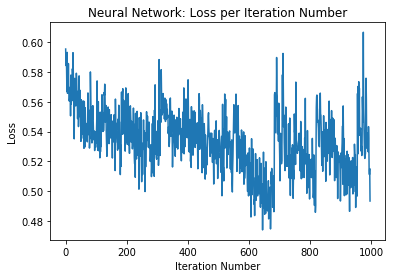

In [124]:
plt.plot(res[1])
plt.xlabel("Iteration Number")
plt.ylabel("Loss")
plt.title("Neural Network: Loss per Iteration Number")
plt.show()

In [125]:
test_DNN(data=X_test, target=y_test, model=res[0], batch_size=50)

Testing accuracy of the given model is 0.62.


0         0.0
1         1.0
2         0.0
3         0.0
4         0.0
5         0.0
6         0.0
7         0.0
8         0.0
9         0.0
10        0.0
11        1.0
12        0.0
13        0.0
14        0.0
15        0.0
16        0.0
17        0.0
18        0.0
19        1.0
20        0.0
21        0.0
22        0.0
23        0.0
24        0.0
25        0.0
26        1.0
27        0.0
28        0.0
29        0.0
         ... 
106818    1.0
106819    0.0
106820    0.0
106821    0.0
106822    0.0
106823    0.0
106824    0.0
106825    0.0
106826    1.0
106827    0.0
106828    1.0
106829    0.0
106830    0.0
106831    0.0
106832    0.0
106833    0.0
106834    0.0
106835    0.0
106836    0.0
106837    0.0
106838    0.0
106839    0.0
106840    1.0
106841    0.0
106842    0.0
106843    0.0
106844    0.0
106845    0.0
106846    0.0
106847    0.0
Length: 106848, dtype: float64